# Infant Hippocampal and Medial Temporal Lobe Segmentation Analyses

This code should execute and recreate the results reported in the manuscript. The figures should be identical and as long as all the cells are run in order the statistics will be identical.

To make this script work, edit the file path in the cell below to go to the directory needed:

    1. out_dir: The main path of the project directory (the cloned neuropipe repo)

If this is set up correctly then you should be able to run all cells

Abbreviations:

`ppt` = participant 

`HPC` = hippocampus  

`MTL` = medial temporal lobe

`ASHS` = automatic segmentation of hippocampal subfields

`IRR` = inter-rater reliability

`IMP` = improvement

`LOP` = left out participant
    
Table of Contents:
* [Setup](#chapter1)
* [Hippocampal Analyses](#chapter2)
    * [Segmentations](#section_2_0)
    * [Inter-Rater Reliability](#section_2_1)
    * [Repeat/Control Analysis](#section_2_2)
    * [Average Template Analysis ](#section_2_3)
    * [FreeSurfer](#section_2_4)
    * [Adult-Pretrained-ASHS](#section_2_5)
    * [CE-ASHS](#section_2_6)
    * [JF-ASHS](#section_2_7)
    * [Infant-Trained-ASHS](#section_2_8)
    * [Intersect Analysis](#section_2_9)
    * [Bland-Altman Plots](#section_2_10)
* [Supplementary/MTL Analyses](#chapter3)
    * [Segmentations](#section_3_0)
    * [Inter-Rater Reliability](#section_3_1)
    * [Repeat/Control DataTable](#section_3_2)
    * [Average Template Analysis](#section_3_3)
    * [CE-ASHS](#section_3_4)
    * [JF-ASHS](#section_3_5)
    * [Infant-Trained-ASHS](#section_3_6)
    * [LOP ASHS](#section_3_7)
    * [Bland-Altman Plots](#section_3_8)
    * [Average Template DataTable](#section_3_9)
    * [ASHS DataTable](#section_3_10)

# Setup <a class="anchor" id="chapter1"></a>
Run the cells below to set up the analysis. This sets up the modules in the first cell, defines the file paths containing the needed data in the second, stores segmentation file paths into appropriate variables in the third, and then defines all the necessary functions in the third.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
print('Note, some warnings have been suppressed. Take caution when running new code')

import nibabel as nib
import numpy as np
import seaborn as sns
from scipy import stats
import scipy
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.io import loadmat
import sys
import os
import nilearn.plotting
import scipy.spatial.distance as sp_distance
from scipy import stats, ndimage
from nilearn import datasets
from nilearn.input_data import NiftiMasker
import pandas as pd
import glob
from sklearn.metrics.pairwise import pairwise_distances
from statistics import stdev
from pylab import *
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from statsmodels.stats.anova import AnovaRM
from itertools import permutations 
from sklearn.linear_model import LinearRegression
sys.path.append("..")
from preprocessing_exploration import hash_participant_id_port

mpl.style.use('seaborn-poster')

%matplotlib inline

Note, some warnings have been suppressed. Take caution when running new code


In [2]:
# Setup some file paths
curr_dir = os.getcwd()
os.chdir('../../') # Move into the infant neuropipe root
base_dir = os.getcwd() + '/'
os.chdir(curr_dir)

out_dir = base_dir + '/data/MTL_Segmentations/'

# Path containing the anatomical images used for alignment and hippocampal segmentation.
out_dir_anatomicals = '%s/anatomicals/' % out_dir

# Path where the notebook stores the plots created in the analysis
out_dir_plots = '%s/plots/' % out_dir

# Path where the notebook stores the output names of the analyses 
out_dir_data_files = '%s/data_files/' % out_dir

# Path containing the segmentations of the participants in their native anatomical space.  
out_dir_segmentations_anatomical = '%s/segmentations_anatomical/' % out_dir

# Path containing the segmentations from each coder that were aligned to standard space using linear steps.
out_dir_segmentations_linear = '%s/segmentations_linear/' % out_dir

# Path containing the segmentations from each coder that were aligned to standard space using both linear and nonlinear steps.
out_dir_segmentations_nonlinear = '%s/segmentations_nonlinear/' % out_dir

#  Path containing the hippocampal segmentation from FreeSurfer.
out_dir_segmentations_freesurfer = '%s/segmentations_freesurfer/' % out_dir

# Path containing the hippocampal segmentations from an ASHS model pretrained on T1-weighted adult hippocampal segmentations 
out_dir_segmentations_adult_pretrained_ASHS = '%s/segmentations_adult_pretrained_ASHS/' % out_dir

# Path containing the hippocampal and MTL segmentations from an ASHS model trained on CE's manual data in a leave-one-scan-out fashion 
out_dir_segmentations_CE_ASHS = '%s/segmentations_CE_ASHS/' % out_dir

# Path containing the hippocampal and MTL segmentations from an ASHS model trained on CE's manual data in a leave-one-participant-out fashion 
out_dir_segmentations_LOP_CE_ASHS = '%s/segmentations_LOPO_CE_ASHS/' % out_dir

# Path containing the hippocampal and MTL segmentations from an ASHS model trained on JF's manual data in a leave-one-scan-out fashion 
out_dir_segmentations_JF_ASHS = '%s/segmentations_JF_ASHS/' % out_dir

# Path containing the hippocampal and MTL segmentations from an ASHS model trained on JF's manual data in a leave-one-participant-out fashion 
out_dir_segmentations_LOP_JF_ASHS = '%s/segmentations_LOPO_JF_ASHS/' % out_dir

# Path containing the hippocampal and MTL segmentations from an ASHS model trained on CE and JF's manual data in a leave-one-scan-out fashion 
out_dir_segmentations_infant_trained_ASHS = '%s/segmentations_infant_trained_ASHS/' % out_dir

# Path containing the hippocampal and MTL segmentations from an ASHS model trained on CE's and JF's manual data in a leave-one-participant-out fashion 
out_dir_segmentations_LOP_infant_trained_ASHS = '%s/segmentations_LOPO_infant_trained_ASHS/' % out_dir


In [3]:
# Set df equal to a DataFrame table with the demographic info for each participant scan
ppt_file = out_dir + '/participant_information.csv'
df = pd.read_csv(ppt_file)

# Returns the name of the participant in the format of sXXXX_X_X
def ppt_namer(file_path):
    
    # Index the beginning and end of the name
    start_index = file_path.find('nii.gz') - 13
    end_index = file_path.find('nii.gz') - 4
    
    # Generate the name
    ppt_name = file_path[start_index:end_index] 

    return ppt_name

# Collect the names of the 42 participant scans using the previously made function
ppt_names = []
files_segmentations_anatomical_CE = sorted(glob.glob(out_dir_segmentations_anatomical + '*CE.nii.gz'))
for file_name in files_segmentations_anatomical_CE:
    ppt_name = ppt_namer(file_name)
    ppt_names += [ppt_name]

# Collect the ages of the 42 participant scans to then order the participant files about to be made
ppt_ages = []
for ppt_name in ppt_names:
    index = np.where(df['hashed_name'] == ppt_name)[0][0]
    ppt_ages += [df['Age'][index]]

# Order the ages from youngest to oldest
ordered_ppt_ages = np.asarray(ppt_ages)[np.argsort(ppt_ages)]

# Order the scan names from youngest to oldest
ordered_ppt_names = np.asarray(ppt_names)[np.argsort(ppt_ages)]

# Store the paths for CE's manual data in a list and order it by age 
files_segmentations_anatomical_CE = sorted(glob.glob(out_dir_segmentations_anatomical + '*CE.nii.gz'))
ordered_files_segmentations_anatomical_CE = np.asarray(files_segmentations_anatomical_CE)[np.argsort(ppt_ages)]

# Store the paths for JF's manual data in a list and order it by age 
files_segmentations_anatomical_JF = sorted(glob.glob(out_dir_segmentations_anatomical + '*JF.nii.gz'))
ordered_files_segmentations_anatomical_JF = np.asarray(files_segmentations_anatomical_JF)[np.argsort(ppt_ages)]

# Store the paths for CE's linearly transformed manual data in a list and order it by age 
files_segmentations_linear_CE = sorted(glob.glob(out_dir_segmentations_linear + '*CE.nii.gz'))
ordered_files_segmentations_linear_CE = np.asarray(files_segmentations_linear_CE)[np.argsort(ppt_ages)]

# Store the paths for JF's linearly transformed manual data in a list and order it by age 
files_segmentations_linear_JF = sorted(glob.glob(out_dir_segmentations_linear + '*JF.nii.gz'))
ordered_files_segmentations_linear_JF = np.asarray(files_segmentations_linear_JF)[np.argsort(ppt_ages)]

# Store the paths for CE's nonlinearly transformed manual data in a list and order it by age 
files_segmentations_nonlinear_CE = sorted(glob.glob(out_dir_segmentations_nonlinear + '*CE.nii.gz'))
ordered_files_segmentations_nonlinear_CE = np.asarray(files_segmentations_nonlinear_CE)[np.argsort(ppt_ages)]

# Store the paths for JF's nonlinearly transformed manual data in a list and order it by age 
files_segmentations_nonlinear_JF = sorted(glob.glob(out_dir_segmentations_nonlinear + '*JF.nii.gz'))
ordered_files_segmentations_nonlinear_JF = np.asarray(files_segmentations_nonlinear_JF)[np.argsort(ppt_ages)]

# FreeSurfer has two fewer scans segmented and so requires its own list of 40 participant scan names to be stored in a list
freesurfer_ppt_names = []
files_segmentations_freesurfer = sorted(glob.glob(out_dir_segmentations_freesurfer + '*'))
for file_name in files_segmentations_freesurfer:
    start_index = file_name.find('freesurfer') + 11
    end_index = file_name.find('.nii.gz')
    ppt_name = file_name[start_index:end_index]
    freesurfer_ppt_names += [ppt_name]

# Store the FreeSurfer ages in a list
freesurfer_ppt_ages = []
for ppt_name in freesurfer_ppt_names:
    index = np.where(df['hashed_name'] == ppt_name)[0][0]
    freesurfer_ppt_ages += [df['Age'][index]]

# Store the paths for FreeSurfer's hippocampal segmentations and order it by age 
files_segmentations_freesurfer = sorted(glob.glob(out_dir_segmentations_freesurfer + '*'))
ordered_files_segmentations_freesurfer = np.asarray(files_segmentations_freesurfer)[np.argsort(freesurfer_ppt_ages)]

# Store the paths for Adult-Pretrained-ASHS' left hippocampal segmentations and order it by age 
files_segmentations_adult_pretrained_ASHS_left = sorted(glob.glob(out_dir_segmentations_adult_pretrained_ASHS + '*left.nii.gz'))
ordered_files_segmentations_adult_pretrained_ASHS_left = np.asarray(files_segmentations_adult_pretrained_ASHS_left)[np.argsort(ppt_ages)]

# Store the paths for Adult-Pretrained-ASHS' right hippocampal segmentations and order it by age 
files_segmentations_adult_pretrained_ASHS_right = sorted(glob.glob(out_dir_segmentations_adult_pretrained_ASHS + '*right.nii.gz'))
ordered_files_segmentations_adult_pretrained_ASHS_right = np.asarray(files_segmentations_adult_pretrained_ASHS_right)[np.argsort(ppt_ages)]

# Store the paths for CE-ASHS' left hippocampal segmentations and order it by age 
files_segmentations_CE_ASHS_left = sorted(glob.glob(out_dir_segmentations_CE_ASHS + '*left.nii.gz'))
ordered_files_segmentations_CE_ASHS_left = np.asarray(files_segmentations_CE_ASHS_left)[np.argsort(ppt_ages)]

# Store the paths for CE-ASHS' right hippocampal segmentations and order it by age 
files_segmentations_CE_ASHS_right = sorted(glob.glob(out_dir_segmentations_CE_ASHS + '*right.nii.gz'))
ordered_files_segmentations_CE_ASHS_right = np.asarray(files_segmentations_CE_ASHS_right)[np.argsort(ppt_ages)]

# Store the paths for LOP-CE-ASHS' left hippocampal segmentations and order it by age 
files_segmentations_LOP_CE_ASHS_left = sorted(glob.glob(out_dir_segmentations_LOP_CE_ASHS + '*left.nii.gz'))
ordered_files_segmentations_LOP_CE_ASHS_left = np.asarray(files_segmentations_LOP_CE_ASHS_left)[np.argsort(ppt_ages)]

# Store the paths for LOP-CE-ASHS' right hippocampal segmentations and order it by age 
files_segmentations_LOP_CE_ASHS_right = sorted(glob.glob(out_dir_segmentations_LOP_CE_ASHS + '*right.nii.gz'))
ordered_files_segmentations_LOP_CE_ASHS_right = np.asarray(files_segmentations_LOP_CE_ASHS_right)[np.argsort(ppt_ages)]

# Store the paths for JF-ASHS' left hippocampal segmentations and order it by age 
files_segmentations_JF_ASHS_left = sorted(glob.glob(out_dir_segmentations_JF_ASHS + '*left.nii.gz'))
ordered_files_segmentations_JF_ASHS_left = np.asarray(files_segmentations_JF_ASHS_left)[np.argsort(ppt_ages)]

# Store the paths for JF-ASHS' right hippocampal segmentations and order it by age 
files_segmentations_JF_ASHS_right = sorted(glob.glob(out_dir_segmentations_JF_ASHS + '*right.nii.gz'))
ordered_files_segmentations_JF_ASHS_right = np.asarray(files_segmentations_JF_ASHS_right)[np.argsort(ppt_ages)]

# Store the paths for LOP-JF-ASHS' left hippocampal segmentations and order it by age 
files_segmentations_LOP_JF_ASHS_left = sorted(glob.glob(out_dir_segmentations_LOP_JF_ASHS + '*left.nii.gz'))
ordered_files_segmentations_LOP_JF_ASHS_left = np.asarray(files_segmentations_LOP_JF_ASHS_left)[np.argsort(ppt_ages)]

# Store the paths for LOP-JF-ASHS' right hippocampal segmentations and order it by age 
files_segmentations_LOP_JF_ASHS_right = sorted(glob.glob(out_dir_segmentations_LOP_JF_ASHS + '*right.nii.gz'))
ordered_files_segmentations_LOP_JF_ASHS_right = np.asarray(files_segmentations_LOP_JF_ASHS_right)[np.argsort(ppt_ages)]

# Store the paths for Infant-Trained-ASHS' left hippocampal segmentations and order it by age 
files_segmentations_infant_trained_ASHS_left = sorted(glob.glob(out_dir_segmentations_infant_trained_ASHS + '*left.nii.gz'))
ordered_files_segmentations_infant_trained_ASHS_left = np.asarray(files_segmentations_infant_trained_ASHS_left)[np.argsort(ppt_ages)]

# Store the paths for Infant-Trained-ASHS' right hippocampal segmentations and order it by age 
files_segmentations_infant_trained_ASHS_right = sorted(glob.glob(out_dir_segmentations_infant_trained_ASHS + '*right.nii.gz'))
ordered_files_segmentations_infant_trained_ASHS_right = np.asarray(files_segmentations_infant_trained_ASHS_right)[np.argsort(ppt_ages)]

# Store the paths for LOP-Infant-Trained-ASHS' left hippocampal segmentations and order it by age 
files_segmentations_LOP_infant_trained_ASHS_left = sorted(glob.glob(out_dir_segmentations_LOP_infant_trained_ASHS + '*left.nii.gz'))
ordered_files_segmentations_LOP_infant_trained_ASHS_left = np.asarray(files_segmentations_LOP_infant_trained_ASHS_left)[np.argsort(ppt_ages)]

# Store the paths for LOP-Infant-Trained-ASHS' right hippocampal segmentations and order it by age 
files_segmentations_LOP_infant_trained_ASHS_right = sorted(glob.glob(out_dir_segmentations_LOP_infant_trained_ASHS + '*right.nii.gz'))
ordered_files_segmentations_LOP_infant_trained_ASHS_right = np.asarray(files_segmentations_LOP_infant_trained_ASHS_right)[np.argsort(ppt_ages)]


In [4]:
# Import some functions

# Perform bivariate bootstrap resampling: take N samples with replacement from x and y and compute the correlation. Do this X times and report the p value of the number of samples in the opposite direction from the true effect, doubled to make two tail
def randomise_corr(x_vals, y_vals, resample_num=10000, cov_vals=None): 
    
    # Set the seed so the analyses have a consistent p value
    np.random.seed(1)
    
    # Check that the metrics aren't lists
    x_vals = np.asarray(x_vals)
    y_vals = np.asarray(y_vals) 
    
    # Resample the participants
    resample_corr = []
    
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(x_vals), (1, len(x_vals)))
        
        if cov_vals is None:
            
            resample_corr += [np.corrcoef(x_vals[sub_idx], y_vals[sub_idx])[0, 1]]
            
        else:
            
            partial_corr_val, _ = partial_corr(x_vals[sub_idx], y_vals[sub_idx], cov_vals[sub_idx])
            
            resample_corr += [partial_corr_val]
            
    # Calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_corr) > 0) + 1) / (resample_num + 1))) * 2
    
    # If greater than 1 then subtract from 2
    if p_val > 1:
        p_val = 2 - p_val
        
    # return the corr p value
    return p_val


# Bootstrap resampling. Take N samples with replacement and compute a mean of the sample. Do this X times and report the p value of the number of samples in the opposite direction from the true effect, doubled to make two tail
def randomise_diff(diff_data, resample_num=10000, ): 
    
    # Set the seed so the analyses have a consistent p value
    np.random.seed(1)
    
    # Resample the participants
    resample_diff = []
    
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(diff_data), (1, len(diff_data)))
        resample_diff += [np.mean(diff_data[sub_idx])]
        
    # What direction was the effect
    sign_count = np.sum((diff_data) > 0)
    
    # Calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) > 0) + 1) / (resample_num + 1))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        
        p_val = 2 - p_val
        
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]

    return p_val, sign_count, CIs
    
def plot_manual_ROI(ppt, min_HPC_ROI=4, min_MTL_ROI = 0, MTL = False):

    # Where are the masks
    mask_dir = out_dir + '/segmentations_anatomical/'

    # Where is the reg folder
    reg_dir = out_dir + '/anatomicals/'

    suffix = ''
    cmap_CE = ListedColormap('blue')
    cmap_JF = ListedColormap('plum')

    mask_name_CE = '%s/%s-%s%s.nii.gz' % (mask_dir, ppt, 'CE', suffix)
    mask_name_JF = '%s/%s-%s%s.nii.gz' % (mask_dir, ppt, 'JF', suffix)

    
    # Load the mask
    mask_nii_CE = nib.load(mask_name_CE)
    mask_nii_JF = nib.load(mask_name_JF)
    
    
    # Load the anatomical image
    highres_nii = nib.load(reg_dir + '%s.nii.gz' % ppt)
    
    # Where is the centroid of the r_HPC
    r_HPC_mask_CE = mask_nii_CE.get_data() == 6 
       
    np_coords = np.round(scipy.ndimage.measurements.center_of_mass(r_HPC_mask_CE)).astype('int')

    mni_coords = nilearn.image.coord_transform(np_coords[0], np_coords[1], np_coords[2], mask_nii_CE.affine)
  
    fig = plt.figure(figsize=(15,15))
    fig = nilearn.plotting.plot_img(highres_nii, 
                                    draw_cross=False,
                                    #display_mode='yz',
                                    cut_coords=[mni_coords[0], mni_coords[1], mni_coords[2]],
                                    colorbar=False,
                                    title=ppt,
                                    cmap='Greys',
                                    figure=fig)
    if MTL == False:
        
        fig.add_overlay(img=mask_nii_CE, cmap=cmap_CE, threshold=min_HPC_ROI)
        fig.add_overlay(img=mask_nii_JF, cmap=cmap_JF, threshold=min_HPC_ROI)
        
    if MTL == True:
        
        mask_vol_CE = mask_nii_CE.get_data()
        mask_vol_JF = mask_nii_JF.get_data()
        
        mask_vol_CE[mask_vol_CE > 4] = 0
        mask_vol_JF[mask_vol_JF > 4] = 0
        
        mask_nii_CE = nib.Nifti1Image(mask_vol_CE, mask_nii_CE.affine)
        mask_nii_JF = nib.Nifti1Image(mask_vol_JF, mask_nii_JF.affine)
        
        fig.add_overlay(img=mask_nii_CE, cmap=cmap_CE)
        fig.add_overlay(img=mask_nii_JF, cmap=cmap_JF)

    plt.savefig(out_dir_plots + 'ROIs_%s%s.svg' % (ppt, suffix))


# Performs a Sørensen–Dice coefficient statistic calculation for two segmentations of the same corresponding participant   
def dice_coefficient(vol_1, vol_2, HPC = True):
    
    #For analyses that want to look at the HPC, this step renders all labeled MTL voxels of 4's AND 3's to a value of zero
    if HPC == True:
        
        vol_1[vol_1 < 5] = 0
        vol_2[vol_2 < 5] = 0
        
    #For analyses examining the MTL, this step renders all labeled HPC voxels of 6's AND 5's to zero for analyses looking at the MTL   
    else:
        
        vol_1[vol_1 >= 5] = 0
        vol_2[vol_2 >= 5] = 0
        
    #First, combine the two volumes to form a mask
    volume_mask = np.add(vol_1, vol_2)
    
    #Exclude all the unlabled voxels remaining from our mask
    volume_mask = volume_mask != 0
    
    #Using this mask, create one vectors that contains only the labeled voxels from one rater, and another vector for JF 
    vector_1 = vol_1[volume_mask]
    vector_2 = vol_2[volume_mask]
    
    #Generates a numbr representing the total number of union voxels — only the voxels that both CE and JF labeled
    vector_output = vector_1 == vector_2
    
    #Multpiply this numbr by 2
    numerator = sum(vector_output) * 2
    
    #We divide the numerator by the culmulative number of voxels that CE and JF labeled in total
    denominator = len(vol_1[vol_1 > 0]) + len(vol_2[vol_2 > 0])
    
    dice_co = numerator/denominator
    
    return dice_co


# Plots subplots of how CE and JF Dice values from a given analysis correlate with the age of the participant scan
def sub_plot(x_axis, y_axis_CE, y_axis_JF, graph_title_CE, graph_title_JF, lower_bound_CE, lower_bound_JF):
    
    # Set the seed so the analyses have a consistent p value
    np.random.seed(1)
    
    plt.figure()
    fig, ax = plt.subplots(1, 2, facecolor='white', figsize=(20, 8))

    # Plot CE's data
    ax[0].scatter(x = x_axis, y = y_axis_CE, s=150, color = 'lightskyblue')
    ax[0].set_xlabel('Ppt Age (Months)', fontsize = 15)
    ax[0].set_ylabel('Dice coef.', fontsize = 15)
    ax[0].set_ylim([0.0, 1.0])
    ax[0].set_title(graph_title_CE + ' (r=%0.2f' % np.corrcoef(x_axis, y_axis_CE)[0,1] + '; p=%0.3f'%  randomise_corr(x_axis, y_axis_CE) + ')', fontsize = 15)
 
    # Plot JF's data
    ax[1].scatter(x = x_axis, y = y_axis_JF, s=150, color = 'plum')
    ax[1].set_xlabel('Ppt Age (Months)', fontsize = 15)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_title(graph_title_JF + ' (r=%0.2f' % np.corrcoef(x_axis, y_axis_JF)[0,1] + '; p=%0.3f'%  randomise_corr(x_axis, y_axis_JF) + ')', fontsize = 15)
    
    #Plots a horizontal line that represents the average of CE and JF's "lower bound" control analyses 
        
    ax[0].axhline((np.mean(lower_bound_CE) + np.mean(lower_bound_JF))/2, color="black") 
    ax[1].axhline((np.mean(lower_bound_CE) + np.mean(lower_bound_JF))/2, color="black") 
        
        
# Plots the individual Dice comparison points atop a bar plot
def jitter_bar(dice_values, IRRs, rater, num, x_range=[0, 1], minimum_dist=0.025):
    
    while True:
        
        jitter_x = np.random.rand(num)
        
        # Change the range of the jitter x values
        jitter_x *= x_range[1] - x_range[0]
        jitter_x += x_range[0]
        pairwise_dist = pairwise_distances(np.vstack((jitter_x, dice_values)).T)
        pairwise_dist = np.triu(pairwise_dist)
        pairwise_dist[pairwise_dist == 0] = np.inf
        if np.min(pairwise_dist) > minimum_dist:
            
            break
            
    # Plots the lollipop lines to show if the Dice is greater (green) or less than (red) the IRR for that participant        
    for ppt_counter in range(num):
        
        if dice_values[ppt_counter] > IRRs[ppt_counter]:
            
            color = 'forestgreen'
            
        else:
            
            color = 'firebrick'
            
        plt.plot([jitter_x[ppt_counter], jitter_x[ppt_counter]], [dice_values[ppt_counter], IRRs[ppt_counter]], color = color, zorder=1, linewidth=.30)
        
        # Generates the correct corresponding color for each tracer
        if rater == 'CE':
            plt.scatter(jitter_x, dice_values, zorder=2, s=35, color='mediumblue')
            
        if rater == 'JF':
            plt.scatter(jitter_x, dice_values, zorder=2, s=35, color='darkorchid')
    
    
# The function used to calculate IRR and the reliability of FreeSurfer's segmentations 
def dice_compare(segmentation_list_1, segmentation_list_2, output_stem, analysis_name, HPC=True):
    
    if os.path.exists(out_dir_data_files + output_stem + '_HPC.npy') == 0:
        
        #Where we will store the Dice values
        Dice_HPC = []
        Dice_MTL = []
        
        # Zip through two lists (both ordered by age) of segmentations 
        for segmentation_1, segmentation_2 in zip(segmentation_list_1, segmentation_list_2):
                
            # Stores in the loaded volume data for each rater into HPC and MTL variables   
            vol_1_HPC = nib.load(segmentation_1).get_data()
            vol_1_MTL = nib.load(segmentation_1).get_data()

            vol_2_HPC = nib.load(segmentation_2).get_data()
            vol_2_MTL = nib.load(segmentation_2).get_data()
                
            # Uses the dice function to generate a HPC and MTL Dice for each participant
            Dice_HPC += [dice_coefficient(vol_1_HPC, vol_2_HPC, True)]
            Dice_MTL += [dice_coefficient(vol_1_MTL, vol_2_MTL, False)]
        
        #Convert the list of Dice values to an array
        Dice_HPC = np.asarray(Dice_HPC)
        Dice_MTL = np.asarray(Dice_MTL)
        
        np.save(out_dir_data_files + output_stem + '_HPC.npy', Dice_HPC)
        np.save(out_dir_data_files + output_stem + '_MTL.npy', Dice_MTL)
        
    # Load in the data            
    else:
        
        Dice_HPC = np.load(out_dir_data_files + output_stem + '_HPC.npy')
        Dice_MTL = np.load(out_dir_data_files + output_stem + '_MTL.npy')
    
    # Only look at HPC data
    if HPC == True:
        
        print(analysis_name + ' HPC Dice=%0.2f'% np.mean(Dice_HPC) + ' (SD=%0.2f'% stdev(Dice_HPC) + ', range=%0.2f'% np.min(Dice_HPC) + '-%0.2f)'% np.max(Dice_HPC))
        
        return Dice_HPC
    
    # Only look at MTL data   
    else:
        
        print(analysis_name + ' MTL Dice=%0.2f'% np.mean(Dice_MTL) + ' (SD=%0.2f'% stdev(Dice_MTL) + ', range=%0.2f'% np.min(Dice_MTL) + '-%0.2f)'% np.max(Dice_MTL))
        
        return Dice_MTL

    
# Investigate how similar a coder is when segmenting the same anatomy as well as the degree of subjectivity from a crossed version of this analysis
def repeat_test(ordered_files_segmentations_list_CE, ordered_files_segmentations_list_JF, out_dir_segmentations, transformation, HPC=True):
    
    # Set the seed so the analyses have a consistent p value
    np.random.seed(1)
    
    if os.path.exists(out_dir_data_files + transformation + '_CE_control_sample_HPC.npy') == 0:
        
        # Where the control Dices will be stored 
        CE_control_sample_HPC = []
        JF_control_sample_HPC = []
        
        CE_control_sample_MTL = []
        JF_control_sample_MTL = []
        
        # Where the repeat Dices will be stored
        CE_repeat_sample_HPC = []
        JF_repeat_sample_HPC = []
        
        CE_repeat_sample_MTL = []
        JF_repeat_sample_MTL = []
        
        # Where the crossed Dices will be stored
        cross_sample_HPC = []
        
        # Where the age diffs of the participant that generated the Dices will be stored
        control_age_diffs_list = []
        repeat_age_diffs_list = []
        
        # Where the match error between the age diff of the control pair and repeat pair will be stored
        match_error = []
        
        # Zip through the segmentations of the two raters
        for counter_1, (CE_segmentation_1, JF_segmentation_1) in enumerate(zip(ordered_files_segmentations_list_CE, ordered_files_segmentations_list_JF)):
            
            # Generate a participant name (because the two lists are ordered the same, the name can come from either CE or JF's list)
            ppt_name_1 = ppt_namer(CE_segmentation_1)
            
            # Generate an index from the partipant DataFrame for this given participant
            index_1 = np.where(df['hashed_name'] == ppt_name_1)[0][0]
            
            # Do the same for the same lists
            for counter_2, (CE_segmentation_2, JF_segmentation_2) in enumerate(zip(ordered_files_segmentations_list_CE, ordered_files_segmentations_list_JF)):

                ppt_name_2 = ppt_namer(CE_segmentation_2)

                index_2 = np.where(df['hashed_name'] == ppt_name_2)[0][0] 
                
                # When the sXXXX portion is the same between the two names (and they're not identical names), then the two names represent repeat sessions
                if (ppt_name_1[:6] == ppt_name_2[:6]) and (ppt_name_1 != ppt_name_2):
                    
                    # Store the repeat sessions 
                    CE_vol_1_HPC = nib.load(CE_segmentation_1).get_data()
                    JF_vol_1_HPC = nib.load(JF_segmentation_1).get_data() 
                    
                    CE_vol_1_MTL = nib.load(CE_segmentation_1).get_data()
                    JF_vol_1_MTL = nib.load(JF_segmentation_1).get_data()                                                
                                                             
                    CE_vol_2_HPC = nib.load(CE_segmentation_2).get_data()
                    JF_vol_2_HPC = nib.load(JF_segmentation_2).get_data() 
                    
                    CE_vol_2_MTL = nib.load(CE_segmentation_2).get_data()
                    JF_vol_2_MTL = nib.load(JF_segmentation_2).get_data() 
                                                             
                    # Calculate Dice values comparing repeat sessions from the same rater with eachother (CE with CE; JF with JF)                                        
                    CE_repeat_sample_HPC += [dice_coefficient(CE_vol_1_HPC, CE_vol_2_HPC, True)]
                    JF_repeat_sample_HPC += [dice_coefficient(JF_vol_1_HPC, JF_vol_2_HPC, True)]                                                
                    
                    CE_repeat_sample_MTL += [dice_coefficient(CE_vol_1_MTL, CE_vol_2_MTL, False)]
                    JF_repeat_sample_MTL += [dice_coefficient(JF_vol_1_MTL, JF_vol_2_MTL, False)]
                    
                    # Run a HPC cross sample (i.e.; CE with JF and JF with CE)
                    cross_sample_HPC += [dice_coefficient(CE_vol_1_HPC, JF_vol_2_HPC, True)]
                    cross_sample_HPC += [dice_coefficient(JF_vol_1_HPC, CE_vol_2_HPC, True)]

                    # In order to obtain a control, non-repeat participant (controlling for age as well), first find the age of each repeat session using the index generated earlier
                    repeat_age_1 = df['Age'][index_1]
                    repeat_age_2 = df['Age'][index_2]
                    
                    # Subtract the two ages to get the age diff of the repeat sessions; store it in a list
                    repeat_age_diff = repeat_age_2 - repeat_age_1
                    repeat_age_diffs_list += [np.abs(repeat_age_diff)]
    
                    # Generate an array of all 42 ages and subtract the age of the first repeat session from each age 
                    age_diffs = np.asarray(ordered_ppt_ages) - repeat_age_1
            
                    # Subtract the age difference of the repeat sessions from the array of ages
                    diff_of_diffs = age_diffs - repeat_age_diff
                    
                    # From our list of ages, remove the age differences generated from the two repeat participants 
                    diff_of_diffs[counter_1] = np.nan
                    diff_of_diffs[counter_2] = np.nan
                    
                    # Generate an index for the control participant that has the smallest age difference from the 40 that remain () 
                    match_index = np.nanargmin(np.abs(diff_of_diffs))
                    
                    # Store this age difference 
                    match_error += [diff_of_diffs[match_index]]
                    
                    # Use the index to find the age and name of the control participant
                    control_age = ordered_ppt_ages[match_index] 
                    control_age_diff = control_age - repeat_age_1
                    control_age_diffs_list += [np.abs(control_age_diff)]
                    
                    control_name_unedited = ordered_files_segmentations_list_CE[match_index]
                    ppt_name = ppt_namer(control_name_unedited)
                    index_3 = np.where(df['hashed_name'] == ppt_name)[0][0]
                    control_name = df['hashed_name'][index_3]
                    
                    # Load in the control volumes 
                    CE_vol_3_HPC = nib.load(out_dir_segmentations + control_name + '-CE.nii.gz').get_data() 
                    JF_vol_3_HPC = nib.load(out_dir_segmentations + control_name + '-JF.nii.gz').get_data() 
                                                
                    CE_vol_3_MTL = nib.load(out_dir_segmentations + control_name + '-CE.nii.gz').get_data()
                    JF_vol_3_MTL = nib.load(out_dir_segmentations + control_name + '-JF.nii.gz').get_data()
                    
                    # Generate and store the control Dice values
                    CE_control_sample_HPC += [dice_coefficient(CE_vol_1_HPC, CE_vol_3_HPC, True)]
                    JF_control_sample_HPC += [dice_coefficient(JF_vol_1_HPC, JF_vol_3_HPC, True)]
                    
                    CE_vol_1_MTL = nib.load(CE_segmentation_1).get_data()
                    JF_vol_1_MTL = nib.load(JF_segmentation_1).get_data()
                    
                    CE_control_sample_MTL += [dice_coefficient(CE_vol_1_MTL, CE_vol_3_MTL, False)]
                    JF_control_sample_MTL += [dice_coefficient(JF_vol_1_MTL, JF_vol_3_MTL, False)]

        # Save the control output data
        np.save(out_dir_data_files + transformation + '_CE_control_sample_HPC.npy', CE_control_sample_HPC)
        np.save(out_dir_data_files + transformation + '_CE_control_sample_MTL.npy', CE_control_sample_MTL)
        np.save(out_dir_data_files + transformation + '_JF_control_sample_HPC.npy', JF_control_sample_HPC)
        np.save(out_dir_data_files + transformation + '_JF_control_sample_MTL.npy', JF_control_sample_MTL) 
        
        # Save the repeat output data
        np.save(out_dir_data_files + transformation + '_CE_repeat_sample_HPC.npy', CE_repeat_sample_HPC)
        np.save(out_dir_data_files + transformation + '_CE_repeat_sample_MTL.npy', CE_repeat_sample_MTL)
        np.save(out_dir_data_files + transformation + '_JF_repeat_sample_HPC.npy', JF_repeat_sample_HPC)
        np.save(out_dir_data_files + transformation + '_JF_repeat_sample_MTL.npy', JF_repeat_sample_MTL)  
        
        # Save the cross-sample output data
        np.save(out_dir_data_files + transformation + '_cross_sample_HPC.npy', cross_sample_HPC)
         
        # Save the age diffs output data
        np.save(out_dir_data_files + transformation + '_control_age_diffs_list.npy', control_age_diffs_list)
        np.save(out_dir_data_files + transformation + '_repeat_age_diffs_list.npy', repeat_age_diffs_list )
        
        # Save the match error data
        np.save(out_dir_data_files + transformation + '_match_error.npy', match_error)
        
    else:
        
        # Load the control output data
        CE_control_sample_HPC = np.load(out_dir_data_files + transformation + '_CE_control_sample_HPC.npy')
        CE_control_sample_MTL = np.load(out_dir_data_files + transformation + '_CE_control_sample_MTL.npy')
        JF_control_sample_HPC = np.load(out_dir_data_files + transformation + '_JF_control_sample_HPC.npy')
        JF_control_sample_MTL = np.load(out_dir_data_files + transformation + '_JF_control_sample_MTL.npy')
        
        # Load the repeat output data
        CE_repeat_sample_HPC = np.load(out_dir_data_files + transformation + '_CE_repeat_sample_HPC.npy')
        CE_repeat_sample_MTL = np.load(out_dir_data_files + transformation + '_CE_repeat_sample_MTL.npy')
        JF_repeat_sample_HPC = np.load(out_dir_data_files + transformation + '_JF_repeat_sample_HPC.npy')
        JF_repeat_sample_MTL = np.load(out_dir_data_files + transformation + '_JF_repeat_sample_MTL.npy')
        
        # Load the cross-sample output data
        cross_sample_HPC = np.load(out_dir_data_files + transformation + '_cross_sample_HPC.npy')                                                         
        
        # Load the age diffs output data 
        control_age_diffs_list = np.load(out_dir_data_files + transformation + '_control_age_diffs_list.npy')
        repeat_age_diffs_list = np.load(out_dir_data_files + transformation + '_repeat_age_diffs_list.npy')
        
        # Load the match error output data
        match_error = np.load(out_dir_data_files + transformation + '_match_error.npy')
   
    # Only look at HPC data, specifically repeat data, control data, and cross-sample data
    if HPC == True:
      
        print(transformation + ' CE Repeat HPC Dice: %0.2f'% np.mean(CE_repeat_sample_HPC)+ ' (SD=%0.2f'% stdev(CE_repeat_sample_HPC) + ', range=%0.2f'% np.min(CE_repeat_sample_HPC) + '-%0.2f)'% np.max(CE_repeat_sample_HPC))
        print(transformation + ' JF Repeat HPC Dice: %0.2f'% np.mean(JF_repeat_sample_HPC)+ ' (SD=%0.2f'% stdev(JF_repeat_sample_HPC) + ', range=%0.2f'% np.min(JF_repeat_sample_HPC) + '-%0.2f)'% np.max(JF_repeat_sample_HPC)), print('') 
        
        print(transformation + ' CE Control HPC Dice: %0.2f'% np.mean(CE_control_sample_HPC)+ ' (SD=%0.2f'% stdev(CE_control_sample_HPC) + ', range=%0.2f'% np.min(CE_control_sample_HPC) + '-%0.2f)'% np.max(CE_control_sample_HPC))
        print(transformation + ' JF Control HPC Dice: %0.2f'% np.mean(JF_control_sample_HPC)+ ' (SD=%0.2f'% stdev(JF_control_sample_HPC) + ', range=%0.2f'% np.min(JF_control_sample_HPC) + '-%0.2f)'% np.max(JF_control_sample_HPC)), print('') 

        print(transformation + ' Cross-Sample HPC Dice: %0.2f'% np.mean(cross_sample_HPC)+ ' (SD=%0.2f'% stdev(cross_sample_HPC) + ', range=%0.2f'% np.min(cross_sample_HPC) + '-%0.2f)'% np.max(cross_sample_HPC)), print()
        
        return CE_control_sample_HPC, JF_control_sample_HPC
    
    # Load all the repeat/control data            
    else:
        
        regions = ['CE HPC', 'JF HPC', 'CE MTL', 'JF MTL']
        
        # Control data
        control_sample = ['Dice=%0.2f'% np.mean(CE_control_sample_HPC) + ', SD=%0.2f'% stdev(CE_control_sample_HPC) + ', range=%0.2f'% np.min(CE_control_sample_HPC) + '-%0.2f'% np.max(CE_control_sample_HPC) + ' (r=%0.2f'% np.corrcoef(CE_control_sample_HPC, control_age_diffs_list)[0,1] + ', p=%0.3f)'% randomise_corr(CE_control_sample_HPC, control_age_diffs_list), 'Dice=%0.2f'% np.mean(JF_control_sample_HPC) + ', SD=%0.2f'% stdev(JF_control_sample_HPC) + ', range=%0.2f'% np.min(JF_control_sample_HPC) + '-%0.2f'% np.max(JF_control_sample_HPC) + ' (r=%0.2f'% np.corrcoef(JF_control_sample_HPC, control_age_diffs_list)[0,1] + ', p=%0.3f)'%randomise_corr(JF_control_sample_HPC, control_age_diffs_list), 'Dice=%0.2f'% np.mean(CE_control_sample_MTL) + ', SD=%0.2f'% stdev(CE_control_sample_MTL) + ', range=%0.2f'% np.min(CE_control_sample_MTL) + '-%0.2f'% np.max(CE_control_sample_MTL) + ' (r=%0.2f'% np.corrcoef(CE_control_sample_MTL, control_age_diffs_list)[0,1] + ', p=%0.3f)'%randomise_corr(CE_control_sample_MTL, control_age_diffs_list), 'Dice=%0.2f'% np.mean(JF_control_sample_MTL) + ', SD=%0.2f'% stdev(JF_control_sample_MTL) + ', range=%0.2f'% np.min(JF_control_sample_MTL) + '-%0.2f'% np.max(JF_control_sample_MTL) + ' (r=%0.2f'% np.corrcoef(JF_control_sample_MTL, control_age_diffs_list)[0,1] + ', p=%0.3f)'%randomise_corr(JF_control_sample_MTL, control_age_diffs_list)]
        
        # Repeat data
        repeat_sample = ['Dice=%0.2f'% np.mean(CE_repeat_sample_HPC) + ', SD=%0.2f'% stdev(CE_repeat_sample_HPC) + ', range=%0.2f'% np.min(CE_repeat_sample_HPC) + '-%0.2f'% np.max(CE_repeat_sample_HPC) + ' (r=%0.2f'% np.corrcoef(CE_repeat_sample_HPC, repeat_age_diffs_list)[0,1] + ', p=%0.3f)'% randomise_corr(CE_repeat_sample_HPC, repeat_age_diffs_list), 'Dice=%0.2f'% np.mean(JF_repeat_sample_HPC) + ', SD=%0.2f'% stdev(JF_repeat_sample_HPC) + ', range=%0.2f'% np.min(JF_repeat_sample_HPC) + '-%0.2f'% np.max(JF_repeat_sample_HPC) + ' (r=%0.2f'% np.corrcoef(JF_repeat_sample_HPC, repeat_age_diffs_list)[0,1] + ', p=%0.3f)' % randomise_corr(JF_repeat_sample_HPC, repeat_age_diffs_list), 'Dice=%0.2f'% np.mean(CE_repeat_sample_MTL) + ', SD=%0.2f'% stdev(CE_repeat_sample_MTL) + ', range=%0.2f'% np.min(CE_repeat_sample_MTL) + '-%0.2f'% np.max(CE_repeat_sample_MTL) + ' (r=%0.2f'% np.corrcoef(CE_repeat_sample_MTL, repeat_age_diffs_list)[0,1] + ', p=%0.3f)' % randomise_corr(CE_repeat_sample_MTL, repeat_age_diffs_list), 'Dice=%0.2f'% np.mean(JF_repeat_sample_MTL) + ', SD=%0.2f'% stdev(JF_repeat_sample_MTL) + ', range=%0.2f'% np.min(JF_repeat_sample_MTL) + '-%0.2f'% np.max(JF_repeat_sample_MTL) + ' (r=%0.2f'% np.corrcoef(JF_repeat_sample_MTL, repeat_age_diffs_list)[0,1] + ', p=%0.3f)' % randomise_corr(JF_repeat_sample_MTL, repeat_age_diffs_list)]
        
        # Differences between repeat and control data
        p_val_CE_HPC, sign_count, CIs_CE_HPC = randomise_diff(CE_repeat_sample_HPC - CE_control_sample_HPC)
        p_val_JF_HPC, sign_count, CIs_JF_HPC = randomise_diff(JF_repeat_sample_HPC - JF_control_sample_HPC)
        
        p_val_CE_MTL, sign_count, CIs_CE_MTL = randomise_diff(CE_repeat_sample_MTL - CE_control_sample_MTL)
        p_val_JF_MTL, sign_count, CIs_JF_MTL = randomise_diff(JF_repeat_sample_MTL - JF_control_sample_MTL)

        diff = ['M=%0.2f' %(np.mean(CE_repeat_sample_HPC - CE_control_sample_HPC)) + ', p=%0.3f'% p_val_CE_HPC + ', C.I.=%0.3f' % CIs_CE_HPC[0] + '-%0.3f' % CIs_CE_HPC[1], 'M=%0.2f'% (np.mean(JF_repeat_sample_HPC - JF_control_sample_HPC)) + ', p=%0.3f'% p_val_JF_HPC + ', C.I.=%0.3f' % CIs_JF_HPC[0] + '-%0.3f' % CIs_JF_HPC[1], 'M= %0.2f'% (np.mean(CE_repeat_sample_MTL - CE_control_sample_MTL)) + ', p=%0.3f'% p_val_CE_MTL + ', C.I.=%0.3f' % CIs_CE_MTL[0] + '-%0.3f' % CIs_CE_MTL[1], 'M=%0.2f'% (np.mean(JF_repeat_sample_MTL - JF_control_sample_MTL)) + ' (p=%0.3f'% p_val_JF_MTL + ', C.I.=%0.3f' % CIs_JF_MTL[0] + '-%0.3f' % CIs_JF_MTL[1]]

        col_names = ['Brain Region', '%s Repeat Sample Mean' % (transformation), '%s Control Sample Mean'  % (transformation), '%s Difference' % (transformation)]
        
        # Plot the repeat and control data in a DataFrame table
        Repeats_Controls_Table = pd.DataFrame(columns=col_names)
        
        Repeats_Controls_Table['Brain Region'] = regions
        
        Repeats_Controls_Table['%s Repeat Sample Mean' % (transformation)] = repeat_sample
        Repeats_Controls_Table['%s Control Sample Mean' % (transformation)] = control_sample
        
        Repeats_Controls_Table['%s Difference' % (transformation)] = diff
        
        fig, ax = plt.subplots(1,2, figsize=(20, 8))
        
        # Plot the HPC repeat and control data in a scatterplot
        I = ax[0].scatter(control_age_diffs_list, CE_control_sample_HPC, s=250, facecolors='none', edgecolors='lightskyblue', linewidths=1.3)
        II = ax[0].scatter(control_age_diffs_list, JF_control_sample_HPC, s=250, facecolors='none', edgecolors='plum', linewidths=1.3)        
        III = ax[0].scatter(repeat_age_diffs_list, CE_repeat_sample_HPC, s=250, c='lightskyblue')
        IV = ax[0].scatter(repeat_age_diffs_list, JF_repeat_sample_HPC, s=250, c='plum')
        
        ax[0].set_xlabel('Age Diff (months)')
        ax[0].set_ylabel('Dice coef.')
        ax[0].set_ylim([0.0, 1.0])
        ax[0].set_title('%s HPC Repeats and Controls vs. Age Diff' % (transformation) + '')

        # Plot the MTL repeat and control data in a scatterplot
        I = ax[1].scatter(control_age_diffs_list, CE_control_sample_MTL, s=250, facecolors='none', edgecolors='lightskyblue', linewidths=1.3)
        II = ax[1].scatter(control_age_diffs_list, JF_control_sample_MTL, s=250, facecolors='none', edgecolors='plum', linewidths=1.3)        
        III = ax[1].scatter(repeat_age_diffs_list, CE_repeat_sample_MTL, s=250, c='lightskyblue')
        IV = ax[1].scatter(repeat_age_diffs_list, JF_repeat_sample_MTL, s=250, c='plum')
        
        ax[1].set_xlabel('Age Diff (months)')
        ax[1].set_ylabel('Dice coef.')
        ax[1].set_ylim([0.0, 1.0])
        ax[1].set_title('%s MTL Repeats and Controls vs. Age Diff' % (transformation))
        
        plt.legend((I, II, III, IV),
                    ('CE Control', 'JF Control', 'CE Repeat', 'JF Repeat'),
                    scatterpoints=1,
                    loc='upper right',
                    ncol=2,
                    fontsize=10)
        
        plt.savefig(out_dir_plots + '%s_repeats_and_controls_scatter_plot.svg' % (transformation))
        
        return CE_repeat_sample_HPC, CE_control_sample_HPC, CE_repeat_sample_MTL, CE_control_sample_MTL, JF_repeat_sample_HPC, JF_control_sample_HPC, JF_repeat_sample_MTL, JF_control_sample_MTL, Repeats_Controls_Table, match_error

            
# Make an average infant template via leave-one-out           
def infant_average(left_out_CE_segmentation, left_out_JF_segmentation, transformation):
    
    ROI_names = ['Left_MTL', 'Right_MTL', 'Left_HPC', 'Right_HPC']
    ROI_values = [3, 4, 5, 6]
    
    # Load in the raters' corresponding volumes of the left out participant  
    vol_individual_CE = nib.load(left_out_CE_segmentation).get_data()
    vol_individual_JF = nib.load(left_out_JF_segmentation).get_data()
    
    # Zip through the ROI names and values  
    for ROI_name, ROI_value in zip(ROI_names, ROI_values):
        
        # Load in the proportion files for both raters
        vol_piece_CE = nib.load(out_dir + '/proportion_voxels_shared/CE_%s_proportion_voxels_shared_' % (transformation) + ROI_name + '.nii.gz').get_data()
        vol_piece_JF = nib.load(out_dir + '/proportion_voxels_shared/JF_%s_proportion_voxels_shared_' % (transformation) + ROI_name + '.nii.gz').get_data()

        # Generate empty shells in the size of the standardized volume 
        vol_output_piece_CE = np.zeros((182,218,182),int)
        vol_output_piece_JF = np.zeros((182,218,182),int)
        
        # Binzarize the volume of the left-out participant for each rater
        vol_binarize_piece_CE = vol_individual_CE == ROI_value
        vol_binarize_piece_JF = vol_individual_JF == ROI_value
       
        # Store this binarized volume in its appropriate shell 
        vol_output_piece_JF += vol_binarize_piece_JF
        vol_output_piece_CE += vol_binarize_piece_CE

        # Multiply the proportions by the number of infant segmentations to give you a whole number for each voxel
        vol_piece_JF = vol_piece_JF * (len(ordered_files_segmentations_linear_JF))
        vol_piece_CE = vol_piece_CE * (len(ordered_files_segmentations_linear_CE))

        #Subtract the binarized left-out participant from the proportions
        vol_piece_JF = vol_piece_JF - vol_output_piece_JF
        vol_piece_CE = vol_piece_CE - vol_output_piece_CE
        
        # Combine CE and JF's volumes
        vol_piece_combine = vol_piece_JF + vol_piece_CE
        
        # Divide by the total number of segmentations between the two tracers, and because CE and JF each had a volume left out, we subtracted 2 
        vol_piece_combine = vol_piece_combine /(len(ordered_files_segmentations_linear_JF) + len(ordered_files_segmentations_linear_CE) - 2)
        
        # Only select for voxels that were labeled in more than half of the total number of segmentations 
        vol_piece_combine = vol_piece_combine > .5
        
        # With our now-binarized volume, multiply by the ROI value
        vol_piece_combine = [i * ROI_value for i in vol_piece_combine]
        
        # Store lMTL average volume
        if ROI_value == 3:
            vol_LMTL = vol_piece_combine
       
        # Store rMTL average volume
        if ROI_value == 4:
            vol_RMTL = vol_piece_combine
           
        # Store lHPC average volume
        if ROI_value == 5:
            vol_LHPC = vol_piece_combine
            
        # Store rHPC average volume
        if ROI_value == 6:
            vol_RHPC = vol_piece_combine
    
    # Combine the left and right MTL into one MTL average
    vol_MTL = np.add(vol_LMTL, vol_RMTL)
    
    # Combine the left and right HPC into one HPC average 
    vol_HPC = np.add(vol_LHPC, vol_RHPC)
    
    # Combine the MTL and HPC into one infant average
    vol_average = np.add(vol_MTL, vol_HPC)
    
    return vol_average

# Investigate how well an average infant and adult template approximate the manual data of both raters
def average_test(ordered_files_segmentations_list_CE, ordered_files_segmentations_list_JF, transformation_dir, transformation, HPC=True): 

    # Set the seed so the analyses have a consistent p value
    np.random.seed(1)
    
    if os.path.exists(out_dir_data_files + transformation + '_infant_average_approx_CE_HPC.npy') == 0:
        
        # Where the average infant HPC Dice values will be stored
        infant_average_approx_CE_HPC = []
        infant_average_approx_JF_HPC = []
        
        # Where the average infant MTL Dice values will be stored
        infant_average_approx_CE_MTL = []
        infant_average_approx_JF_MTL = []
        
        # Wehre the average adult HPC Dice values will be stored
        adult_average_approx_CE_HPC = []
        adult_average_approx_JF_HPC = []

        # Zip through the volumes of both raters
        for CE_segmentation, JF_segmentation in zip(ordered_files_segmentations_list_CE, ordered_files_segmentations_list_JF):

            # Load in each rater's volume data into appropriate variables
            vol_CE_HPC = nib.load(CE_segmentation).get_data()
            vol_JF_HPC = nib.load(JF_segmentation).get_data()
            
            vol_CE_MTL = nib.load(CE_segmentation).get_data()
            vol_JF_MTL = nib.load(JF_segmentation).get_data()
           
            # Use the infant_average function to construct a singular average infant template, leaving out the two rater's volumes
            infant_average_HPC = infant_average(CE_segmentation, JF_segmentation, transformation_dir)
            infant_average_MTL = infant_average(CE_segmentation, JF_segmentation, transformation_dir)
            
            # Generate and store HPC and MTL Dice values with this average infant template
            infant_average_approx_CE_HPC += [dice_coefficient(vol_CE_HPC, infant_average_HPC, True)]
            infant_average_approx_JF_HPC += [dice_coefficient(vol_JF_HPC, infant_average_HPC, True)]
            
            infant_average_approx_CE_MTL += [dice_coefficient(vol_CE_MTL, infant_average_MTL, False)]
            infant_average_approx_JF_MTL += [dice_coefficient(vol_JF_MTL, infant_average_MTL, False)]
            
            # Generate and store HPC Dice values with an average adult template
            adult_average_approx_CE_HPC += [dice_coefficient(vol_CE_HPC, adult_average_HPC, True)]
            adult_average_approx_JF_HPC += [dice_coefficient(vol_JF_HPC, adult_average_HPC, True)]
        
        # Save the infant average output data
        np.save(out_dir_data_files + transformation + '_infant_average_approx_CE_HPC.npy', infant_average_approx_CE_HPC)
        np.save(out_dir_data_files + transformation + '_infant_average_approx_CE_MTL.npy', infant_average_approx_CE_MTL)
        np.save(out_dir_data_files + transformation + '_infant_average_approx_JF_HPC.npy', infant_average_approx_JF_HPC) 
        np.save(out_dir_data_files + transformation + '_infant_average_approx_JF_MTL.npy', infant_average_approx_JF_MTL) 
         
        # Save the adult average output data
        np.save(out_dir_data_files + transformation + '_adult_average_approx_CE_HPC.npy', adult_average_approx_CE_HPC) 
        np.save(out_dir_data_files + transformation + '_adult_average_approx_JF_HPC.npy', adult_average_approx_JF_HPC)

    else:

        # Load the infant average output data
        infant_average_approx_CE_HPC = np.load(out_dir_data_files + transformation + '_infant_average_approx_CE_HPC.npy')
        infant_average_approx_CE_MTL = np.load(out_dir_data_files + transformation + '_infant_average_approx_CE_MTL.npy')
        infant_average_approx_JF_HPC = np.load(out_dir_data_files + transformation + '_infant_average_approx_JF_HPC.npy')
        infant_average_approx_JF_MTL = np.load(out_dir_data_files + transformation + '_infant_average_approx_JF_MTL.npy')
        
        # Load the adult average output data
        adult_average_approx_CE_HPC = np.load(out_dir_data_files + transformation + '_adult_average_approx_CE_HPC.npy')
        adult_average_approx_JF_HPC = np.load(out_dir_data_files + transformation + '_adult_average_approx_JF_HPC.npy')
        
    # Only look at HPC data
    if HPC == True:
        
        # Analyze the mean of the infant templates' CE HPC Dice values
        print(transformation + ' Average Infant Approximating CE HPC: Dice=%0.2f'% np.mean(infant_average_approx_CE_HPC) + ' (SD=%0.2f'% stdev(infant_average_approx_CE_HPC) + ', range=%0.2f'% np.min(infant_average_approx_CE_HPC) + '-%0.2f)'% np.max(infant_average_approx_CE_HPC))
        
        # Analyze how well it approximated the HPC IRR of this study
        p_val, sign_count, CIs = randomise_diff(infant_average_approx_CE_HPC - inter_rater_reliability_HPC)
        print(transformation + ' Average Infant vs JF Approximating CE HPC: M=%0.2f'% np.mean(infant_average_approx_CE_HPC - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()
        
        # Analyze the mean of the infant templates' JF HPC Dice values
        print(transformation + ' Average Infant Approximating JF HPC: Dice=%0.2f'% np.mean(infant_average_approx_JF_HPC) + ' (SD=%0.2f'% stdev(infant_average_approx_JF_HPC) + ', range=%0.2f'% np.min(infant_average_approx_JF_HPC) + '-%0.2f)'% np.max(infant_average_approx_JF_HPC))
        
        # Analyze how well it approximated the HPC IRR of this study
        p_val, sign_count, CIs = randomise_diff(infant_average_approx_JF_HPC - inter_rater_reliability_HPC)
        print(transformation + ' Average Infant vs CE Approximating JF HPC: M=%0.2f'% np.mean(infant_average_approx_JF_HPC - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()
        
        # Plot and save the correlation data
        if transformation == 'Linear':
            
            sub_plot(ordered_ppt_ages, infant_average_approx_CE_HPC, infant_average_approx_JF_HPC, '%s Average Infant Approximating CE HPC vs Age' % (transformation), '%s Average Infant Approximating JF HPC vs age' % (transformation), CE_linear_lower_bound_HPC, JF_linear_lower_bound_HPC)
       
        if transformation == 'Nonlinear':
            
            sub_plot(ordered_ppt_ages, infant_average_approx_CE_HPC, infant_average_approx_JF_HPC, '%s Average Infant Approximating CE HPC vs Age' % (transformation), '%s Average Infant Approximating JF HPC vs age' % (transformation), CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC)
        
        plt.savefig(out_dir_plots + '%s_average_infant_template_approx_HPC_scatter_plot.svg' % (transformation))
    
        plt.show()
        
        # Analyzes the mean of the adult template's HPC Dice values and how well it approximated the HPC IRR of this study
        print('Average Adult Approximating ' + transformation + 'ly Aligned CE HPC: Dice=%0.2f'% np.mean(adult_average_approx_CE_HPC) + ' (SD=%0.2f'% stdev(adult_average_approx_CE_HPC) + ', range=%0.2f'% np.min(adult_average_approx_CE_HPC) + '-%0.2f)'% np.max(adult_average_approx_CE_HPC))
        
        p_val, sign_count, CIs = randomise_diff(adult_average_approx_CE_HPC - inter_rater_reliability_HPC)
        print('Average Adult vs JF Approximating ' + transformation + 'ly Aligned CE HPC: M=%0.2f'% np.mean(adult_average_approx_CE_HPC - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()
        
        print('Average Adult Approximating '  + transformation + 'ly Aligned JF HPC: Dice=%0.2f'% np.mean(adult_average_approx_JF_HPC) + ' (SD=%0.2f'% stdev(adult_average_approx_JF_HPC) + ', range=%0.2f'% np.min(adult_average_approx_JF_HPC) + '-%0.2f)'% np.max(adult_average_approx_JF_HPC))
        
        p_val, sign_count, CIs = randomise_diff(adult_average_approx_JF_HPC - inter_rater_reliability_HPC)
        print('Average Adult vs CE Approximating ' + transformation + 'ly Aligned JF HPC: M=%0.2f'% np.mean(adult_average_approx_JF_HPC - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()
        
        # Plot and save the correlation data
        if transformation == 'Linear':
            
            sub_plot(ordered_ppt_ages, adult_average_approx_CE_HPC, adult_average_approx_JF_HPC, '%s Average Adult Approximating CE HPC vs Age' % (transformation), '%s Average Adult Approximating JF HPC vs Age' % (transformation), CE_linear_lower_bound_HPC, JF_linear_lower_bound_HPC)
        
        if transformation == 'Nonlinear':
            
            sub_plot(ordered_ppt_ages, adult_average_approx_CE_HPC, adult_average_approx_JF_HPC, '%s Average Adult Approximating CE HPC vs Age' % (transformation), '%s Average Adult Approximating JF HPC vs Age' % (transformation), CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC)
            
        plt.savefig(out_dir_plots + '%s_average_adult_template_approx_HPC_scatter_plot.svg' % (transformation))
    
        plt.show()
        
        regions =["CE HPC", "JF HPC"]
        
        # Average infant data
        
        p_val_CE, sign_count_CE, CIs_CE = randomise_diff(infant_average_approx_CE_HPC - inter_rater_reliability_HPC)
        p_val_JF, sign_count_JF, CIs_JF = randomise_diff(infant_average_approx_JF_HPC - inter_rater_reliability_HPC)
        infant_average_vs_infant_sample = ['Dice=%0.2f'% np.mean(infant_average_approx_CE_HPC) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', C.I.=%0.2f'%CIs_CE[0] + '-%0.2f)'%CIs_CE[1], 'Dice=%0.2f'% np.mean(infant_average_approx_JF_HPC) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', C.I.=%0.2f'%CIs_JF[0] + '-%0.2f'%CIs_JF[1]]
       
        infant_corr = ['r=%0.2f'% np.corrcoef(infant_average_approx_CE_HPC, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(infant_average_approx_CE_HPC, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(infant_average_approx_JF_HPC, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(infant_average_approx_JF_HPC, ordered_ppt_ages)]
        
        # Average adult data
        p_val_CE, sign_count_CE, CIs_CE = randomise_diff(adult_average_approx_CE_HPC- inter_rater_reliability_HPC)
        p_val_JF, sign_count_JF, CIs_JF = randomise_diff(adult_average_approx_JF_HPC - inter_rater_reliability_HPC)
        adult_average_vs_infant_sample = ['Dice=%0.2f'% np.mean(adult_average_approx_CE_HPC) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', C.I.=%0.2f'%CIs_CE[0] + '-%0.2f)'%CIs_CE[1], 'Dice=%0.2f'% np.mean(adult_average_approx_JF_HPC) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', C.I.=%0.2f'%CIs_JF[0] + '-%0.2f)'%CIs_JF[1]]
        
        adult_corr = ['r=%0.2f'% np.corrcoef(adult_average_approx_CE_HPC, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(adult_average_approx_CE_HPC, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(adult_average_approx_JF_HPC, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(adult_average_approx_JF_HPC, ordered_ppt_ages)]

        col_names = ['Brain Region', '%s Infant Dice' % (transformation), '%s Infant Corr' % (transformation), '%s Adult Dice' % (transformation), '%s Adult Corr' % (transformation)]
        
        # Plot the average infant and adult data in a DataFrame table
        Average_Table = pd.DataFrame(columns=col_names)

        Average_Table['Brain Region'] = regions

        Average_Table['%s Infant Dice' % (transformation)] = infant_average_vs_infant_sample
        Average_Table['%s Infant Corr' % (transformation)] = infant_corr

        Average_Table['%s Adult Dice' % (transformation)] = adult_average_vs_infant_sample
        Average_Table['%s Adult Corr' % (transformation)] = adult_corr

        Average_Table

        return Average_Table, infant_average_approx_CE_HPC, infant_average_approx_JF_HPC, adult_average_approx_CE_HPC, adult_average_approx_JF_HPC 

    # Only look at MTL data
    if HPC == False:
        
        # Analyze the mean of the infant templates' CE MTL Dice values
        print(transformation + ' Average Infant Approximating CE MTL: Dice=%0.2f'% np.mean(infant_average_approx_CE_MTL) + ', SD=%0.2f'% stdev(infant_average_approx_CE_MTL) + ', range=%0.2f'% np.min(infant_average_approx_CE_MTL) + '-%0.2f)'% np.max(infant_average_approx_CE_MTL))
        
        # Analyze how well it approximated the MTL IRR of this study
        p_val, sign_count, CIs = randomise_diff(infant_average_approx_CE_MTL - inter_rater_reliability_MTL)
        print(transformation + ' Average Infant vs JF Approximating CE MTL: M=%0.2f'% np.mean(infant_average_approx_CE_MTL - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()
        
        # Analyze the mean of the infant templates' JF MTL Dice values
        print(transformation + ' Average Infant Approximating JF MTL: Dice=%0.2f'% np.mean(infant_average_approx_JF_MTL) + ', SD=%0.2f'% stdev(infant_average_approx_JF_MTL) + ', range=%0.2f'% np.min(infant_average_approx_JF_MTL) + '-%0.2f'% np.max(infant_average_approx_JF_MTL))
        
        # Analyze how well it approximated the MTL IRR of this study
        p_val, sign_count, CIs = randomise_diff(infant_average_approx_JF_MTL - inter_rater_reliability_MTL)
        print(transformation + ' Average Infant vs CE Approximating JF MTL: M=%0.2f'% np.mean(infant_average_approx_JF_MTL - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()
        
        # Plot the correlation data
        if transformation == 'Linear':
            
            sub_plot(ordered_ppt_ages, infant_average_approx_CE_MTL, infant_average_approx_JF_MTL, '%s Average Infant Approximating CE MTL vs Age' % (transformation), '%s Average Infant Approximating JF MTL vs Age' % (transformation), CE_linear_lower_bound_MTL, JF_linear_lower_bound_MTL)
        
        if transformation == 'Nonlinear':
            
            sub_plot(ordered_ppt_ages, infant_average_approx_CE_MTL, infant_average_approx_JF_MTL, '%s Average Infant Approximating CE MTL vs Age' % (transformation), '%s Average Infant Approximating JF MTL vs Age' % (transformation), CE_nonlinear_lower_bound_MTL, JF_nonlinear_lower_bound_MTL)
            
        plt.savefig(out_dir_plots + '%s_average_infant_template_approx_MTL_scatter_plot.svg' % (transformation))
    
        plt.show()
        
        regions =["CE MTL", "JF MTL"]
        
        # Average infant data
        p_val_CE, sign_count_CE, CIs_CE = randomise_diff(infant_average_approx_CE_MTL - inter_rater_reliability_MTL)
        p_val_JF, sign_count_JF, CIs_JF = randomise_diff(infant_average_approx_JF_MTL - inter_rater_reliability_MTL) 
        infant_average_vs_infant_sample = ['Dice=%0.2f'% np.mean(infant_average_approx_CE_MTL) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', C.I.=%0.2f'%CIs_CE[0] + '–%0.2f)'%CIs_CE[1], 'Dice=%0.2f'% np.mean(infant_average_approx_JF_MTL) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', C.I.=%0.2f'%CIs_JF[0] + '–%0.2f)'%CIs_JF[1]]
        
        infant_corr = ['r=%0.2f'% np.corrcoef(infant_average_approx_CE_MTL, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(infant_average_approx_CE_MTL, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(infant_average_approx_JF_MTL, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(infant_average_approx_JF_MTL, ordered_ppt_ages)]
        
        col_names = ['Brain Region', '%s Infant Dice' % (transformation), '%s Infant Corr' % (transformation)]

        # Plot the average infant data in a DataFrame table
        Average_Infant_Table = pd.DataFrame(columns=col_names)

        Average_Infant_Table['Brain Region'] = regions

        Average_Infant_Table['%s Infant Dice' % (transformation)] = infant_average_vs_infant_sample
        Average_Infant_Table['%s Infant Corr' % (transformation)] = infant_corr 
             
        return Average_Infant_Table, infant_average_approx_CE_MTL, infant_average_approx_JF_MTL 
    

# Because FreeSurfer segmented the HPC in 40 of the 42 scans, we need to remove the appropriate files from the rater's lists of volumes to give us "FreeSurfer files"
def FreeSurfer_file_generator(anatomical_list_CE, anatomical_list_JF, age_list, IRR_HPC):
    
    # Amend the list of segmentations from each rater to only include the 40 that FreeSurfer segmented
    FreeSurfer_ordered_files_segmentations_anatomical_CE = list(anatomical_list_CE)
    del FreeSurfer_ordered_files_segmentations_anatomical_CE[15]
    del FreeSurfer_ordered_files_segmentations_anatomical_CE[39]

    FreeSurfer_ordered_files_segmentations_anatomical_JF = list(anatomical_list_JF)
    del FreeSurfer_ordered_files_segmentations_anatomical_JF[15]
    del FreeSurfer_ordered_files_segmentations_anatomical_JF[39]

    # Amend the ages in the same way
    FreeSurfer_ordered_ppt_ages = list(age_list)
    del FreeSurfer_ordered_ppt_ages[15]
    del FreeSurfer_ordered_ppt_ages[39]

    # Amend the HPC IRR in the same way
    FreeSurfer_Inter_Rater_Reliability_HPC = list(IRR_HPC)
    del FreeSurfer_Inter_Rater_Reliability_HPC[15]
    del FreeSurfer_Inter_Rater_Reliability_HPC[39]
    
    return FreeSurfer_ordered_files_segmentations_anatomical_CE, FreeSurfer_ordered_files_segmentations_anatomical_JF, FreeSurfer_ordered_ppt_ages, FreeSurfer_Inter_Rater_Reliability_HPC
    

# Takes in the left and right volumes from adult-pretrained-ASHS and combines them into one volume
def pretrained_ASHS_combiner(right_output_name, left_output_name):
    
    # Load in the right volume
    vol_right = nib.load(right_output_name).get_data()
    
    # Change the values of ASHS' rHPC voxels to match the value used by the raters (6)
    vol_right[(vol_right == 1) | (vol_right == 2)] = 6
    
    # Change the values of ASHS' rMTL voxels to match the value used by the raters (4)
    vol_right[(vol_right == 7) | (vol_right == 9) | (vol_right == 10) | (vol_right == 11) | (vol_right == 12) | (vol_right == 13) | (vol_right == 14) | (vol_right == 16) | (vol_right == 17)] = 4
   
    # Load in the left volume
    vol_left = nib.load(left_output_name).get_data()
    
    # Change the values of ASHS' lHPC voxels to match the value used by the raters (5)
    vol_left[(vol_left == 1) | (vol_left == 2)] = 5
    
    # Change the values of ASHS' lMTL voxels to match the value used by the raters (3)
    vol_left[(vol_left == 7) | (vol_left == 9) | (vol_left == 10) | (vol_left == 11) | (vol_left == 12) | (vol_left == 13) | (vol_left == 14) | (vol_left == 16) | (vol_left == 17)] = 3 
    
    # Combine the right and left volumes
    vol_pretrained_ASHS_total = vol_right + vol_left
    
    return vol_pretrained_ASHS_total


# Takes in the left and right volumes from CE-ASHS or JF-ASHS and combines them into one volume
def trained_ASHS_combiner(right_output_name, left_output_name):
    
    # Load in the right volume
    vol_right = nib.load(right_output_name).get_data()
    
    # Load in the left volume
    vol_left = nib.load(left_output_name).get_data()
    
    # Combine the right and left volumes
    vol_trained_ASHS_total = vol_right + vol_left
    
    return vol_trained_ASHS_total

   
# The function used to assess how well ASHS approximated manual data
def dice_compare_ASHS(right_output_names, left_output_names, manual_segmentations, output_stem, analysis_name, pretrained=False, trained=False, HPC=True):
    
    if os.path.exists(out_dir_data_files + output_stem + '_HPC.npy') == 0:
        
        #Where we will store the Dice values
        Dice_HPC = []
        Dice_MTL = []
        
        # Zip through the right and left volumes generated by ASHS, along with the segmentations of a rater 
        for right_output_name, left_output_name, manual_segmentation in zip(right_output_names, left_output_names, manual_segmentations):
            
            # We want to analyze the performance of adult_pretrained_ASHS
            if pretrained == True:   
             
                # Combine the left and right volumes from adult_pretrained_ASHS and store in HPC and MTL lists 
                vol_1_HPC = pretrained_ASHS_combiner(right_output_name, left_output_name)
                vol_1_MTL = pretrained_ASHS_combiner(right_output_name, left_output_name)
                
            # We want to analyze the performance of a trained ASHS model        
            if trained == True:
            
                # Combine the left and right volumes from a trained ASHS model and store in HPC and MTL lists 
                vol_1_HPC = trained_ASHS_combiner(right_output_name, left_output_name)
                vol_1_MTL = trained_ASHS_combiner(right_output_name, left_output_name)
                
            # Load in the manual data
            vol_2_HPC = nib.load(manual_segmentation).get_data()
            vol_2_MTL = nib.load(manual_segmentation).get_data()
                
            # Generate a HPC and MTL Dice values
            Dice_HPC += [dice_coefficient(vol_1_HPC, vol_2_HPC, True)]
            Dice_MTL += [dice_coefficient(vol_1_MTL, vol_2_MTL, False)]
       
        #Convert the list of Dice values to an array
        Dice_HPC = np.asarray(Dice_HPC)
        Dice_MTL = np.asarray(Dice_MTL)
        
        np.save(out_dir_data_files + output_stem + '_HPC.npy', Dice_HPC)
        np.save(out_dir_data_files + output_stem + '_MTL.npy', Dice_MTL)
    
    # Load in the data
    else:
        
        Dice_HPC = np.load(out_dir_data_files + output_stem + '_HPC.npy')
        Dice_MTL = np.load(out_dir_data_files + output_stem + '_MTL.npy')
    
    # Only look at HPC data
    if HPC == True:
        
        print(analysis_name + ' HPC Dice=%0.2f'% np.mean(Dice_HPC) + ' (SD=%0.2f'% stdev(Dice_HPC) + ', range=%0.2f'% np.min(Dice_HPC) + '-%0.2f)'% np.max(Dice_HPC))
        
        return Dice_HPC
    
    # Only look at MTL data   
    else:
        
        print(analysis_name + ' MTL Dice=%0.2f'% np.mean(Dice_MTL) + ' (SD=%0.2f'% stdev(Dice_MTL) + ', range=%0.2f'% np.min(Dice_MTL) + '-%0.2f)'% np.max(Dice_MTL))
        
        return Dice_MTL
    
        
# Generates bias plots for FreeSurfer, Adult-Pretrained-ASHS, CE-ASHS, JF-ASHS, and Infant-Trained-ASHS
def bland_altman_plots(ordered_files_anatomical_segmentations_list_CE, ordered_files_anatomical_segmentations_list_JF, ordered_files_nonlinear_segmentations_list_CE, ordered_files_nonlinear_segmentations_list_JF, ordered_files_segmentations_freesurfer_list_CE, ordered_files_segmentations_freesurfer_list_JF, output_stem):
    
    if os.path.exists(out_dir_data_files + output_stem + '_X_axis_freesurfer.npy') == 0:
        
        # Where the averge total HPC voxel count of between the raters' 42 manual segmentations will be stored
        manual_average_anatomical_voxel_count_42 = []
        
        # Where the averge total HPC voxel count of between the raters' 42 nonlinearly aligned manual segmentations will be stored
        manual_average_nonlinear_voxel_count_42 = []
        
        # Where the average total HPC voxel count between the raters will be stored for only the 40 participants that FreeSurfer segmented
        manual_average_voxel_count_40 = []
        
        # Where the total HPC voxel count for FreeSurfer will be stored
        freesurfer_voxel_count = []
        
        # Where the total HPC voxel count for Asult-Pretrained-ASHS will be stored
        adult_pretrained_ASHS_voxel_count = []
        
        # Where the total HPC voxel count for CE-ASHS will be stored
        CE_ASHS_voxel_count = []
        
        # Where the total HPC voxel count for JF-ASHS will be stored
        JF_ASHS_voxel_count = []
        
        # Where the total HPC voxel count for Infant-Trained-ASHS will be stored 
        infant_trained_ASHS_voxel_count = []
        
        # Zip through the volumes of both raters
        for CE_anatomical_segmentation, JF_anatomical_segmentation, CE_nonlinear_segmentation, JF_nonlinear_segmentation  in zip(ordered_files_anatomical_segmentations_list_CE, ordered_files_anatomical_segmentations_list_JF, ordered_files_nonlinear_segmentations_list_CE, ordered_files_nonlinear_segmentations_list_JF):
            
            # Load in the volume data
            anatomical_vol_total_CE = nib.load(CE_anatomical_segmentation).get_data()
            anatomical_vol_total_JF = nib.load(JF_anatomical_segmentation).get_data()
            
            nonlinear_vol_total_CE = nib.load(CE_nonlinear_segmentation).get_data()
            nonlinear_vol_total_JF = nib.load(JF_nonlinear_segmentation).get_data()
            
            # Count and store, for each participant, the total number of HPC voxels (5s and 6s) that CE and JF labeled and find the average
            manual_average_anatomical_voxel_count_42 += [((np.sum(anatomical_vol_total_CE == 5)) + (np.sum(anatomical_vol_total_CE == 6)) + (np.sum(anatomical_vol_total_JF == 5)) + (np.sum(anatomical_vol_total_JF == 6)))/2]
            manual_average_nonlinear_voxel_count_42 += [((np.sum(nonlinear_vol_total_CE == 5)) + (np.sum(nonlinear_vol_total_CE == 6)) + (np.sum(nonlinear_vol_total_JF == 5)) + (np.sum(nonlinear_vol_total_JF == 6)))/2]
        
        # Zip through the volumes of both raters that correspond to the participants FreeSurfer segmented
        for CE_segmentation, JF_segmentation in zip(ordered_files_segmentations_freesurfer_list_CE, ordered_files_segmentations_freesurfer_list_JF):
            
            # Load in the volume data
            vol_total_CE = nib.load(CE_segmentation).get_data()
            vol_total_JF = nib.load(JF_segmentation).get_data()
            
            # Count and store, for each participant, the total number of HPC voxels (5s and 6s) that CE and JF labeled and find the average
            manual_average_voxel_count_40 += [((np.sum(vol_total_CE == 5)) + (np.sum(vol_total_CE == 6)) + (np.sum(vol_total_JF == 5)) + (np.sum(vol_total_JF == 6)))/2]
        
        # Loop through the volumes of FreeSurfer
        for segmentation in ordered_files_segmentations_freesurfer:
        
            # Count and store, for each participant, the total number of HPC voxels (5s and 6s) that FreeSurfer labeled
            vol_total_freesurfer = nib.load(segmentation).get_data()
            freesurfer_voxel_count += [(np.sum(vol_total_freesurfer == 5)) + (np.sum(vol_total_freesurfer == 6))]
           
        # Zip through the left and right volumes of adult_pretrained_ASHS, CE_ASHS, JF_ASHS, and infant_trained_ASHS 
        for adult_pretrained_ASHS_right_output_name, adult_pretrained_ASHS_left_output_name, CE_ASHS_right_output_name, CE_ASHS_left_output_name, JF_ASHS_right_output_name, JF_ASHS_left_output_name, infant_trained_ASHS_right_output_name, infant_trained_ASHS_left_output_name in zip(ordered_files_segmentations_adult_pretrained_ASHS_right, ordered_files_segmentations_adult_pretrained_ASHS_left, ordered_files_segmentations_CE_ASHS_right, ordered_files_segmentations_CE_ASHS_left, ordered_files_segmentations_JF_ASHS_right, ordered_files_segmentations_JF_ASHS_left, ordered_files_segmentations_infant_trained_ASHS_right, ordered_files_segmentations_infant_trained_ASHS_left):
            
            # Combine the left and right volumes to form one total volume
            vol_total_adult_pretrained_ASHS = pretrained_ASHS_combiner(adult_pretrained_ASHS_right_output_name, adult_pretrained_ASHS_left_output_name)
            vol_total_CE_ASHS = trained_ASHS_combiner(CE_ASHS_right_output_name, CE_ASHS_left_output_name)
            vol_total_JF_ASHS = trained_ASHS_combiner(JF_ASHS_right_output_name, JF_ASHS_left_output_name)
            vol_total_infant_trained_ASHS = trained_ASHS_combiner(infant_trained_ASHS_right_output_name, infant_trained_ASHS_left_output_name)
            
            # Count and store, for each participant, the total number of HPC voxels (5s and 6s) that each ASHS model labeled
            adult_pretrained_ASHS_voxel_count += [(np.sum(vol_total_adult_pretrained_ASHS == 5)) + np.sum(vol_total_adult_pretrained_ASHS == 6)]
            CE_ASHS_voxel_count += [(np.sum(vol_total_CE_ASHS == 5)) + (np.sum(vol_total_CE_ASHS == 6))]
            JF_ASHS_voxel_count += [(np.sum(vol_total_JF_ASHS == 5)) + (np.sum(vol_total_JF_ASHS == 6))]
            infant_trained_ASHS_voxel_count += [(np.sum(vol_total_infant_trained_ASHS == 5)) + (np.sum(vol_total_infant_trained_ASHS == 6))]
            
        # Combine (add) the total voxel counts of FreeSurfer, adult_pretrained_ASHS, CE_ASHS, JF_ASHS, and infant_trained_ASHS with Manual, for each participant, to form the x-axis 
        X_axis_freesurfer = [sum(x) for x in zip(manual_average_voxel_count_40, freesurfer_voxel_count)]
        X_axis_adult_pretrained_ASHS = [sum(x) for x in zip(manual_average_anatomical_voxel_count_42, adult_pretrained_ASHS_voxel_count)]
        X_axis_CE_ASHS = [sum(x) for x in zip(manual_average_nonlinear_voxel_count_42, CE_ASHS_voxel_count)]
        X_axis_JF_ASHS = [sum(x) for x in zip(manual_average_nonlinear_voxel_count_42, JF_ASHS_voxel_count)]
        X_axis_infant_trained_ASHS = [sum(x) for x in zip(manual_average_nonlinear_voxel_count_42, infant_trained_ASHS_voxel_count)]
        
        # Subtract the total voxel count of Manual from the totel voxel count of FreeSurfer, adult_pretrained_ASHS, CE_ASHS, JF_ASHS, and infant_trained_ASHS, for each participant, to form the y-axis
        Y_axis_freesurfer = [a - b for a, b in zip(freesurfer_voxel_count, manual_average_voxel_count_40)]
        Y_axis_adult_pretrained_ASHS = [a - b for a, b in zip(adult_pretrained_ASHS_voxel_count, manual_average_anatomical_voxel_count_42)]
        Y_axis_CE_ASHS = [a - b for a, b in zip(CE_ASHS_voxel_count, manual_average_nonlinear_voxel_count_42)]
        Y_axis_JF_ASHS = [a - b for a, b in zip(JF_ASHS_voxel_count, manual_average_nonlinear_voxel_count_42)]
        Y_axis_infant_trained_ASHS = [a - b for a, b in zip(infant_trained_ASHS_voxel_count, manual_average_nonlinear_voxel_count_42)]
        
        # Save the FreeSurfer data
        np.save(out_dir_data_files + output_stem + '_X_axis_freesurfer.npy', X_axis_freesurfer)
        np.save(out_dir_data_files + output_stem + '_Y_axis_freesurfer.npy', Y_axis_freesurfer)
        
        # Save the adult-pretrained ASHS output
        np.save(out_dir_data_files + output_stem + '_X_axis_adult_pretrained_ASHS.npy', X_axis_adult_pretrained_ASHS)
        np.save(out_dir_data_files + output_stem + '_Y_axis_adult_pretrained_ASHS.npy', Y_axis_adult_pretrained_ASHS)
        
        # Save the CE-ASHS output
        np.save(out_dir_data_files + output_stem + '_X_axis_CE_ASHS.npy', X_axis_CE_ASHS)
        np.save(out_dir_data_files + output_stem + '_Y_axis_CE_ASHS.npy', Y_axis_CE_ASHS)
        
        # Save the JF-ASHS output
        np.save(out_dir_data_files + output_stem + '_X_axis_JF_ASHS.npy', X_axis_JF_ASHS)
        np.save(out_dir_data_files + output_stem + '_Y_axis_JF_ASHS.npy', Y_axis_JF_ASHS)
        
        # Save the infant-trained-ASHS output
        np.save(out_dir_data_files + output_stem + '_X_axis_infant_trained_ASHS.npy', X_axis_infant_trained_ASHS)
        np.save(out_dir_data_files + output_stem + '_Y_axis_infant_trained_ASHS.npy', Y_axis_infant_trained_ASHS)
        
    else:
        
        # Load the FreeSurfer data
        X_axis_freesurfer = np.load(out_dir_data_files + output_stem + '_X_axis_freesurfer.npy')
        Y_axis_freesurfer = np.load(out_dir_data_files + output_stem + '_Y_axis_freesurfer.npy')
        
        # Load the adult-pretrained-ASHS data
        X_axis_adult_pretrained_ASHS = np.load(out_dir_data_files + output_stem + '_X_axis_adult_pretrained_ASHS.npy')
        Y_axis_adult_pretrained_ASHS = np.load(out_dir_data_files + output_stem + '_Y_axis_adult_pretrained_ASHS.npy')
        
        # Load the CE-ASHS data
        X_axis_CE_ASHS = np.load(out_dir_data_files + output_stem + '_X_axis_CE_ASHS.npy')
        Y_axis_CE_ASHS = np.load(out_dir_data_files + output_stem + '_Y_axis_CE_ASHS.npy')
        
        # Load the JF-ASHS data
        X_axis_JF_ASHS = np.load(out_dir_data_files + output_stem + '_X_axis_JF_ASHS.npy')
        Y_axis_JF_ASHS = np.load(out_dir_data_files + output_stem + '_Y_axis_JF_ASHS.npy')
         
        # Load the infant-trained-ASHS data
        X_axis_infant_trained_ASHS = np.load(out_dir_data_files + output_stem + '_X_axis_infant_trained_ASHS.npy')
        Y_axis_infant_trained_ASHS = np.load(out_dir_data_files + output_stem + '_Y_axis_infant_trained_ASHS.npy')
    
    
    # Calculate the differences from zero for each automated algorithm 
    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_freesurfer))
    print('FreeSurfer difference from zero: %0.2f' %np.mean(Y_axis_freesurfer) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'%p_val), print()

    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_adult_pretrained_ASHS))
    print('Adult-pretrained-ASHS difference from zero: %0.2f '%np.mean(Y_axis_adult_pretrained_ASHS) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1]+ ', p=%0.3f'%p_val), print()

    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_CE_ASHS))
    print('CE-ASHS difference from zero: %0.2f '%np.mean(Y_axis_CE_ASHS) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'%p_val), print()

    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_JF_ASHS))
    print('JF-ASHS difference from zero: %0.2f '%np.mean(Y_axis_JF_ASHS) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'%p_val), print()

    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_infant_trained_ASHS))
    print('Infant-trained-ASHS difference from zero: %0.2f '%np.mean(Y_axis_infant_trained_ASHS) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'%p_val)

    plt.figure()
    fig, ax = plt.subplots(1,5, figsize=(60, 10))
    custom_xlim = (2000, 16000)
    custom_ylim = (-2600, 4900)
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
        
    # Plot the FreeSurfer bias data
    ax[0].scatter(X_axis_freesurfer, Y_axis_freesurfer, s=300, color = 'grey')
    ax[0].set_ylabel('Volume Difference', fontsize=30)
    ax[0].set_title('Freesurfer Bias (R = %0.2f '% np.corrcoef(X_axis_freesurfer, Y_axis_freesurfer)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_freesurfer, Y_axis_freesurfer) +')', fontsize=30)
    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[0].axhline(0, color="black")
            
    # Plot the adult-pretrained-ASHS bias data
    ax[1].scatter(X_axis_adult_pretrained_ASHS, Y_axis_adult_pretrained_ASHS, s=300, color = 'grey')
    ax[1].set_title('Adult-Pretrained ASHS Bias (R = %0.2f '% np.corrcoef(X_axis_adult_pretrained_ASHS, Y_axis_adult_pretrained_ASHS)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_adult_pretrained_ASHS, Y_axis_adult_pretrained_ASHS) +')', fontsize=25)
    ax[1].tick_params(axis='both', which='major', labelsize=20)
    ax[1].axhline(0, color="black")
        
    # Plot the CE-ASHS bias data
    ax[2].scatter(X_axis_CE_ASHS, Y_axis_CE_ASHS, s=300, color = 'grey')
    ax[2].set_title('CE-ASHS Bias (R = %0.2f '% np.corrcoef(X_axis_CE_ASHS, Y_axis_CE_ASHS)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_CE_ASHS, Y_axis_CE_ASHS) +')', fontsize=25)
    ax[2].tick_params(axis='both', which='major', labelsize=20)
    ax[2].axhline(0, color="black")
        
    # Plot the JF-ASHS bias data
    ax[3].scatter(X_axis_JF_ASHS, Y_axis_JF_ASHS, s=300, color = 'grey')
    ax[3].set_title('JF-ASHS Bias (R = %0.2f '% np.corrcoef(X_axis_JF_ASHS, Y_axis_JF_ASHS)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_JF_ASHS, Y_axis_JF_ASHS) +')', fontsize=25)
    ax[3].tick_params(axis='both', which='major', labelsize=20)
    ax[3].axhline(0, color="black")
    
    # Plot the infant-trained-ASHS bias data
    ax[4].scatter(X_axis_infant_trained_ASHS, Y_axis_infant_trained_ASHS, s=300, color = 'grey')
    ax[4].set_title('Infant-Trained-ASHS Bias (R = %0.2f '% np.corrcoef(X_axis_infant_trained_ASHS, Y_axis_infant_trained_ASHS)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_infant_trained_ASHS, Y_axis_infant_trained_ASHS) +')', fontsize=25)
    ax[4].tick_params(axis='both', which='major', labelsize=20)
    ax[4].axhline(0, color="black")

    
# Generates bias plots for LOP-CE-ASHS, LOP-JF-ASHS, and LOP-Infant-Trained-ASHS
def LOP_bland_altman_plots(ordered_files_segmentations_list_CE, ordered_files_segmentations_list_JF, output_stem):
    
    if os.path.exists(out_dir_data_files + output_stem + '_X_axis_LOP_CE_ASHS.npy') == 0:
        
        # Where the averge total HPC voxel count of between the raters' 42 manual segmentations will be stored
        manual_average_voxel_count = []
        
        # Where the total HPC voxel count for LOP-CE-ASHS will be stored
        LOP_CE_ASHS_voxel_count = []
        
        # Where the total HPC voxel count for LOP-JF-ASHS will be stored
        LOP_JF_ASHS_voxel_count = []
        
        # Where the total HPC voxel count for LOP-Infant-Trained-ASHS will be stored 
        LOP_infant_trained_ASHS_voxel_count = []
        
        # Zip through the volumes of both raters
        for CE_segmentation, JF_segmentation in zip(ordered_files_segmentations_list_CE, ordered_files_segmentations_list_JF):
            
            # Load in the volume data
            vol_total_CE = nib.load(CE_segmentation).get_data()
            vol_total_JF = nib.load(JF_segmentation).get_data()
            
            # Count and store, for each participant, the total number of HPC voxels (5s and 6s) that CE and JF labeled and find the average
            manual_average_voxel_count += [((np.sum(vol_total_CE == 5)) + (np.sum(vol_total_CE == 6)) + (np.sum(vol_total_JF == 5)) + (np.sum(vol_total_JF == 6)))/2]
            
            # Zip through the left and right volumes of LOP_CE_ASHS, LOP_JF_ASHS, and LOP_infant_trained_ASHS 
        for LOP_CE_ASHS_right_output_name, LOP_CE_ASHS_left_output_name, LOP_JF_ASHS_right_output_name, LOP_JF_ASHS_left_output_name, LOP_infant_trained_ASHS_right_output_name, LOP_infant_trained_ASHS_left_output_name in zip(ordered_files_segmentations_LOP_CE_ASHS_right, ordered_files_segmentations_LOP_CE_ASHS_left, ordered_files_segmentations_LOP_JF_ASHS_right, ordered_files_segmentations_LOP_JF_ASHS_left, ordered_files_segmentations_LOP_infant_trained_ASHS_right, ordered_files_segmentations_LOP_infant_trained_ASHS_left):
            
            # Combine the left and right volumes to form one total volume
            vol_total_LOP_CE_ASHS = trained_ASHS_combiner(LOP_CE_ASHS_right_output_name, LOP_CE_ASHS_left_output_name)
            vol_total_LOP_JF_ASHS = trained_ASHS_combiner(LOP_JF_ASHS_right_output_name, LOP_JF_ASHS_left_output_name)
            vol_total_LOP_infant_trained_ASHS = trained_ASHS_combiner(LOP_infant_trained_ASHS_right_output_name, LOP_infant_trained_ASHS_left_output_name)
            
            # Count and store, for each participant, the total number of HPC voxels (5s and 6s) that each ASHS model labeled
            LOP_CE_ASHS_voxel_count += [(np.sum(vol_total_LOP_CE_ASHS == 5)) + (np.sum(vol_total_LOP_CE_ASHS == 6))]
            LOP_JF_ASHS_voxel_count += [(np.sum(vol_total_LOP_JF_ASHS == 5)) + (np.sum(vol_total_LOP_JF_ASHS == 6))]
            LOP_infant_trained_ASHS_voxel_count += [(np.sum(vol_total_LOP_infant_trained_ASHS == 5)) + (np.sum(vol_total_LOP_infant_trained_ASHS == 6))]
            
        # Combine (add) the total voxel counts of LOP_CE_ASHS, LOP_JF_ASHS, and LOP_infant_trained_ASHS with Manual, for each participant, to form the x-axis 
        X_axis_LOP_CE_ASHS = [sum(x) for x in zip(manual_average_voxel_count, LOP_CE_ASHS_voxel_count)]
        X_axis_LOP_JF_ASHS = [sum(x) for x in zip(manual_average_voxel_count, LOP_JF_ASHS_voxel_count)]
        X_axis_LOP_infant_trained_ASHS = [sum(x) for x in zip(manual_average_voxel_count, LOP_infant_trained_ASHS_voxel_count)]
        
        # Subtract the total voxel count of Manual from the totel voxel count of LOP_CE_ASHS, LOP_JF_ASHS, and LOP_infant_trained_ASHS, for each participant, to form the y-axis
        Y_axis_LOP_CE_ASHS = [a - b for a, b in zip(LOP_CE_ASHS_voxel_count, manual_average_voxel_count)]
        Y_axis_LOP_JF_ASHS = [a - b for a, b in zip(LOP_JF_ASHS_voxel_count, manual_average_voxel_count)]
        Y_axis_LOP_infant_trained_ASHS = [a - b for a, b in zip(LOP_infant_trained_ASHS_voxel_count, manual_average_voxel_count)]
        
        # Save the LOP-CE-ASHS output
        np.save(out_dir_data_files + output_stem + '_X_axis_LOP_CE_ASHS.npy', X_axis_LOP_CE_ASHS)
        np.save(out_dir_data_files + output_stem + '_Y_axis_LOP_CE_ASHS.npy', Y_axis_LOP_CE_ASHS)
        
        # Save the LOP-JF-ASHS output
        np.save(out_dir_data_files + output_stem + '_X_axis_LOP_JF_ASHS.npy', X_axis_LOP_JF_ASHS)
        np.save(out_dir_data_files + output_stem + '_Y_axis_LOP_JF_ASHS.npy', Y_axis_LOP_JF_ASHS)
        
        # Save the LOP-infant-trained-ASHS output
        np.save(out_dir_data_files + output_stem + '_X_axis_LOP_infant_trained_ASHS.npy', X_axis_LOP_infant_trained_ASHS)
        np.save(out_dir_data_files + output_stem + '_Y_axis_LOP_infant_trained_ASHS.npy', Y_axis_LOP_infant_trained_ASHS)
        
    else:
        
        # Load the LOP-CE-ASHS data
        X_axis_LOP_CE_ASHS = np.load(out_dir_data_files + output_stem + '_X_axis_LOP_CE_ASHS.npy')
        Y_axis_LOP_CE_ASHS = np.load(out_dir_data_files + output_stem + '_Y_axis_LOP_CE_ASHS.npy')
        
        # Load the LOP-JF-ASHS data
        X_axis_LOP_JF_ASHS = np.load(out_dir_data_files + output_stem + '_X_axis_LOP_JF_ASHS.npy')
        Y_axis_LOP_JF_ASHS = np.load(out_dir_data_files + output_stem + '_Y_axis_LOP_JF_ASHS.npy')
         
        # Load the LOP-infant-trained-ASHS data
        X_axis_LOP_infant_trained_ASHS = np.load(out_dir_data_files + output_stem + '_X_axis_LOP_infant_trained_ASHS.npy')
        Y_axis_LOP_infant_trained_ASHS = np.load(out_dir_data_files + output_stem + '_Y_axis_LOP_infant_trained_ASHS.npy')
    
    # Calculate the differences from zero for each automated algorithm 
    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_LOP_CE_ASHS))
    print('LOP-CE-ASHS difference from zero: %0.2f '%np.mean(Y_axis_LOP_CE_ASHS) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'%p_val), print()

    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_LOP_JF_ASHS))
    print('LOP-JF-ASHS difference from zero: %0.2f '%np.mean(Y_axis_LOP_JF_ASHS) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'%p_val), print()

    p_val, sign_count, CIs = randomise_diff(np.array(Y_axis_LOP_infant_trained_ASHS))
    print('LOP-Infant-trained-ASHS difference from zero: %0.2f '%np.mean(Y_axis_LOP_infant_trained_ASHS) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'%p_val)

    plt.figure()
    fig, ax = plt.subplots(1,3, figsize=(52, 10))
    custom_xlim = (3500, 15999)
    custom_ylim = (-2600, 4900)
    plt.setp(ax,xlim=custom_xlim, ylim=custom_ylim)
        
    # Plot the LOP-CE-ASHS bias data
    ax[0].scatter(X_axis_LOP_CE_ASHS, Y_axis_LOP_CE_ASHS, s=300, color = 'grey')
    ax[0].set_title('LOP-CE-ASHS Bias (R = %0.2f '% np.corrcoef(X_axis_LOP_CE_ASHS, Y_axis_LOP_CE_ASHS)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_LOP_CE_ASHS, Y_axis_LOP_CE_ASHS) +')', fontsize=25)
    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[0].axhline(0, color="black")
        
    # Plot the LOP-JF-ASHS bias data
    ax[1].scatter(X_axis_LOP_JF_ASHS, Y_axis_LOP_JF_ASHS, s=300, color = 'grey')
    ax[1].set_title('LOP-JF-ASHS Bias (R = %0.2f '% np.corrcoef(X_axis_LOP_JF_ASHS, Y_axis_LOP_JF_ASHS)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_LOP_JF_ASHS, Y_axis_LOP_JF_ASHS) +')', fontsize=25)
    ax[1].tick_params(axis='both', which='major', labelsize=20)
    ax[1].axhline(0, color="black")
    
    # Plot the LOP-infant-trained-ASHS bias data
    ax[2].scatter(X_axis_LOP_infant_trained_ASHS, Y_axis_LOP_infant_trained_ASHS, s=300, color = 'grey')
    ax[2].set_title('LOP-Infant-Trained-ASHS Bias (R = %0.2f '% np.corrcoef(X_axis_LOP_infant_trained_ASHS, Y_axis_LOP_infant_trained_ASHS)[0,1] + '; p=%0.3f'% randomise_corr(X_axis_LOP_infant_trained_ASHS, Y_axis_LOP_infant_trained_ASHS) +')', fontsize=25)
    ax[2].tick_params(axis='both', which='major', labelsize=20)
    ax[2].axhline(0, color="black")
    
print('Functions imported!')

Functions imported!


# Hippocampal Data <a class="anchor" id="chapter2"></a>

### Plot Hippocampal Segmentations <a class="anchor" id="section_2_0"></a>

Load in each manual HPC segmentation and overlay them on the anatomical images for each participant. By default this plots solely the HPC segmentations, but if MTL is True then it will generate the MTL plots. CE is in blue and JF is in purple. 

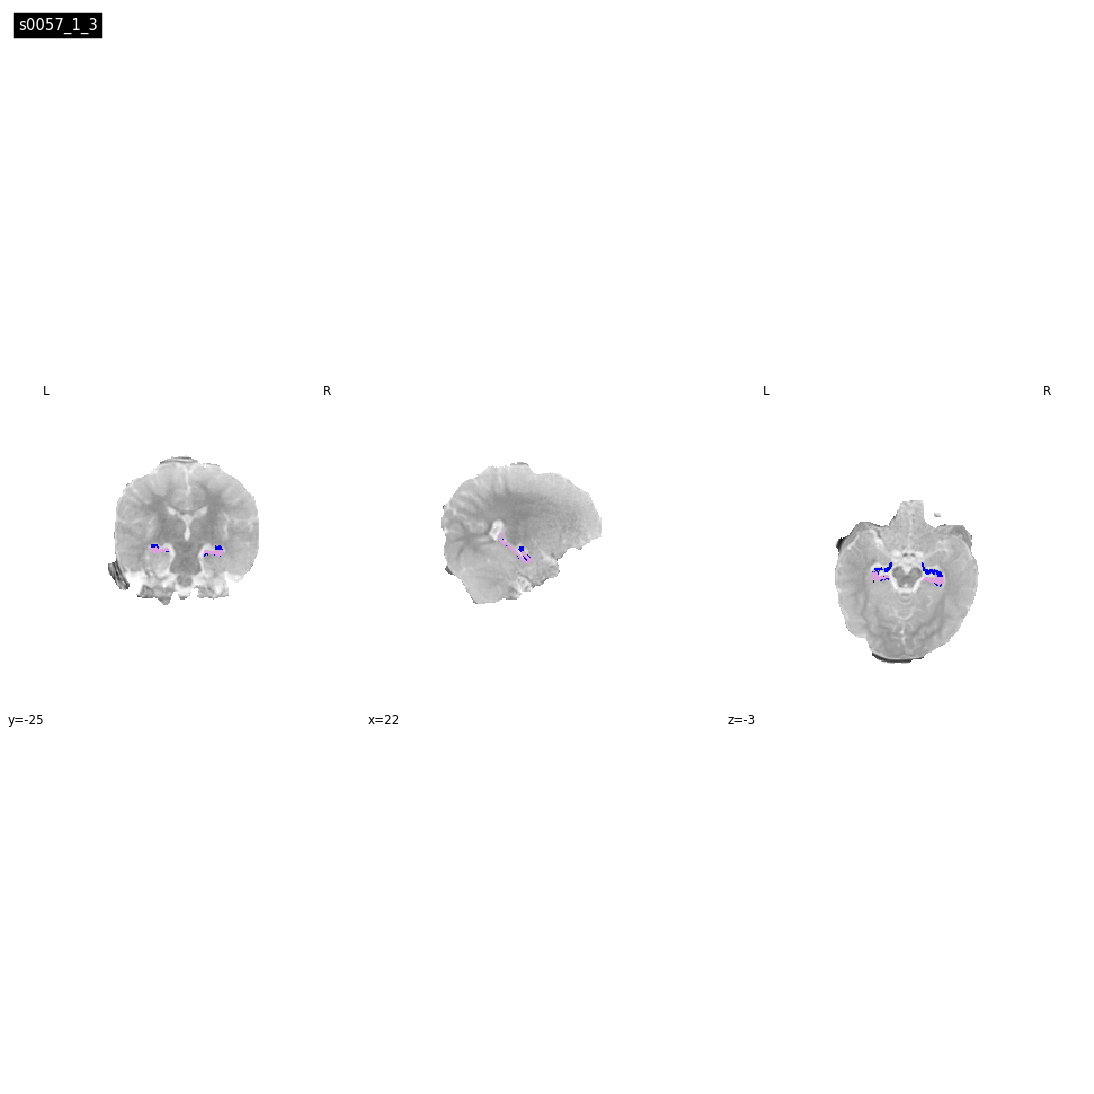

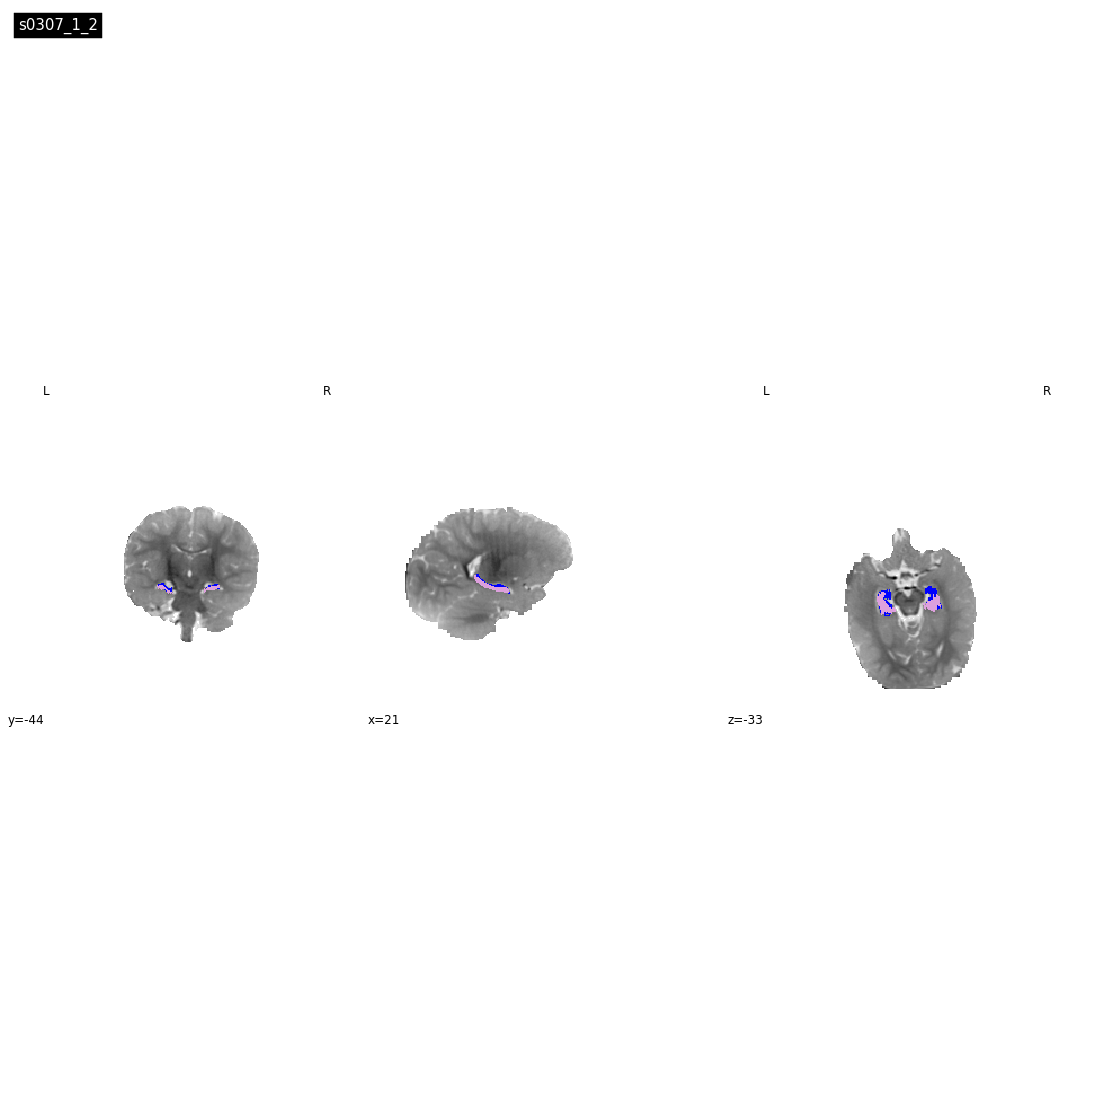

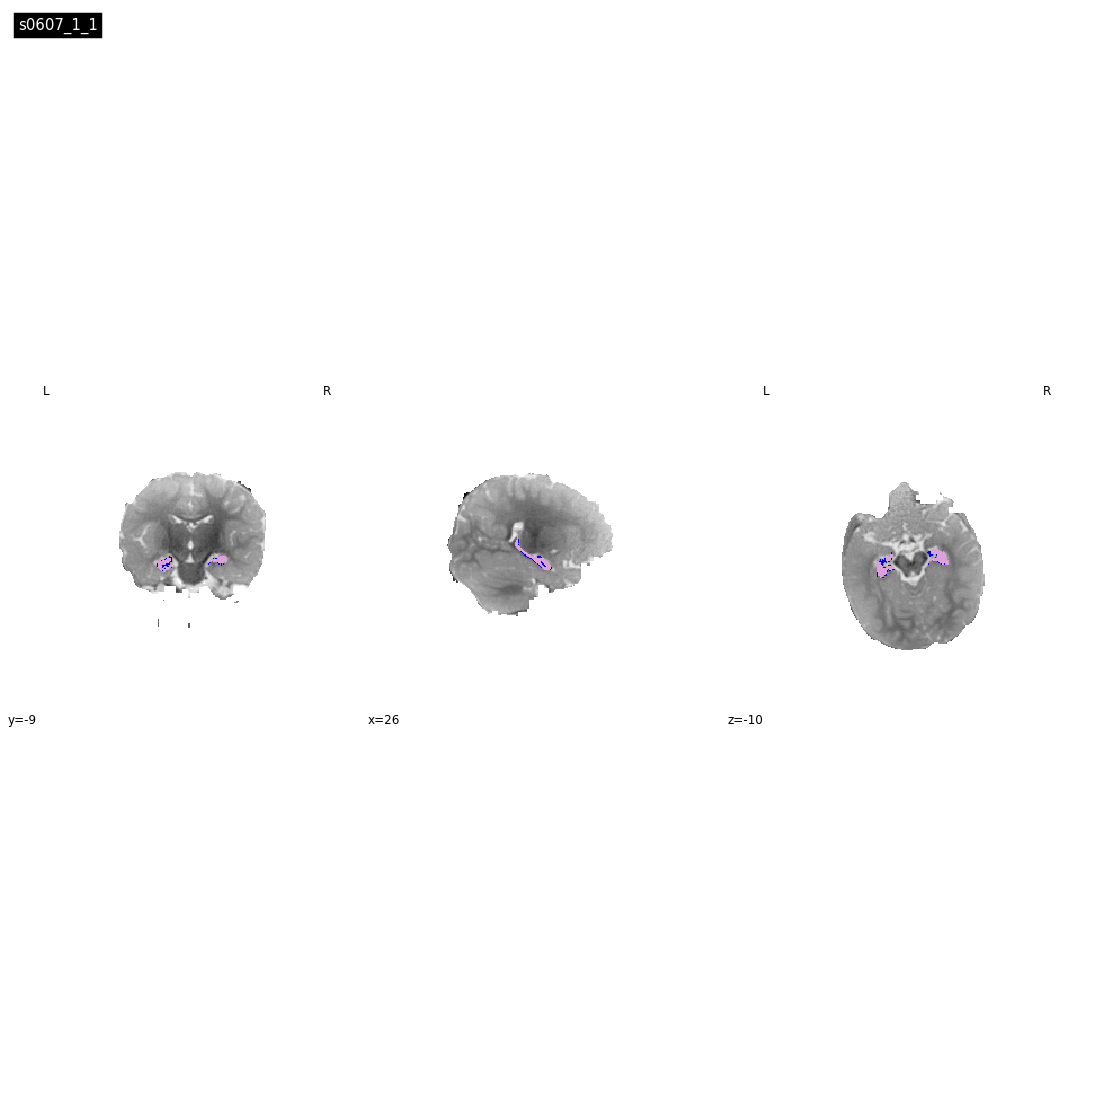

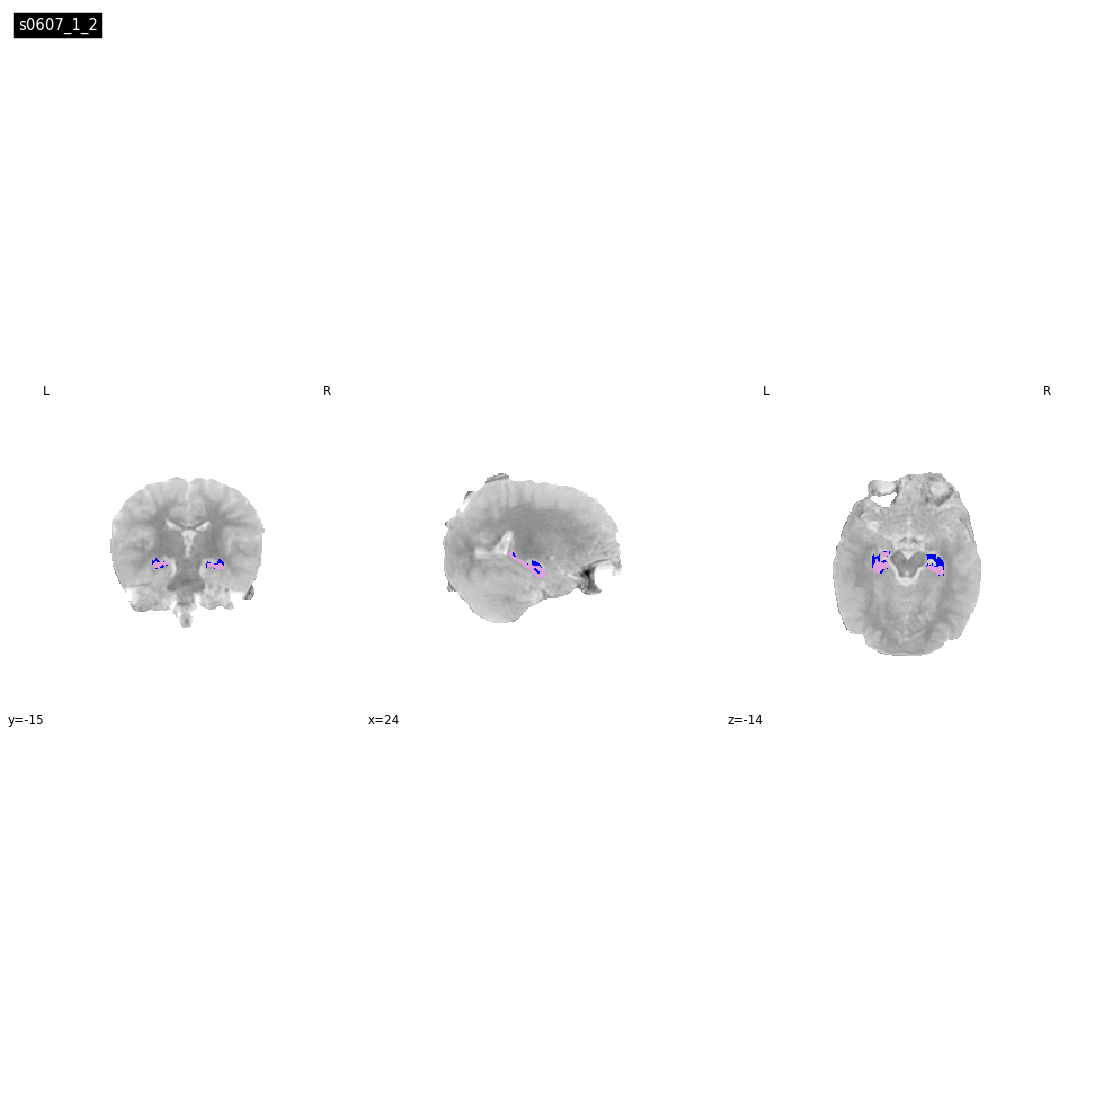

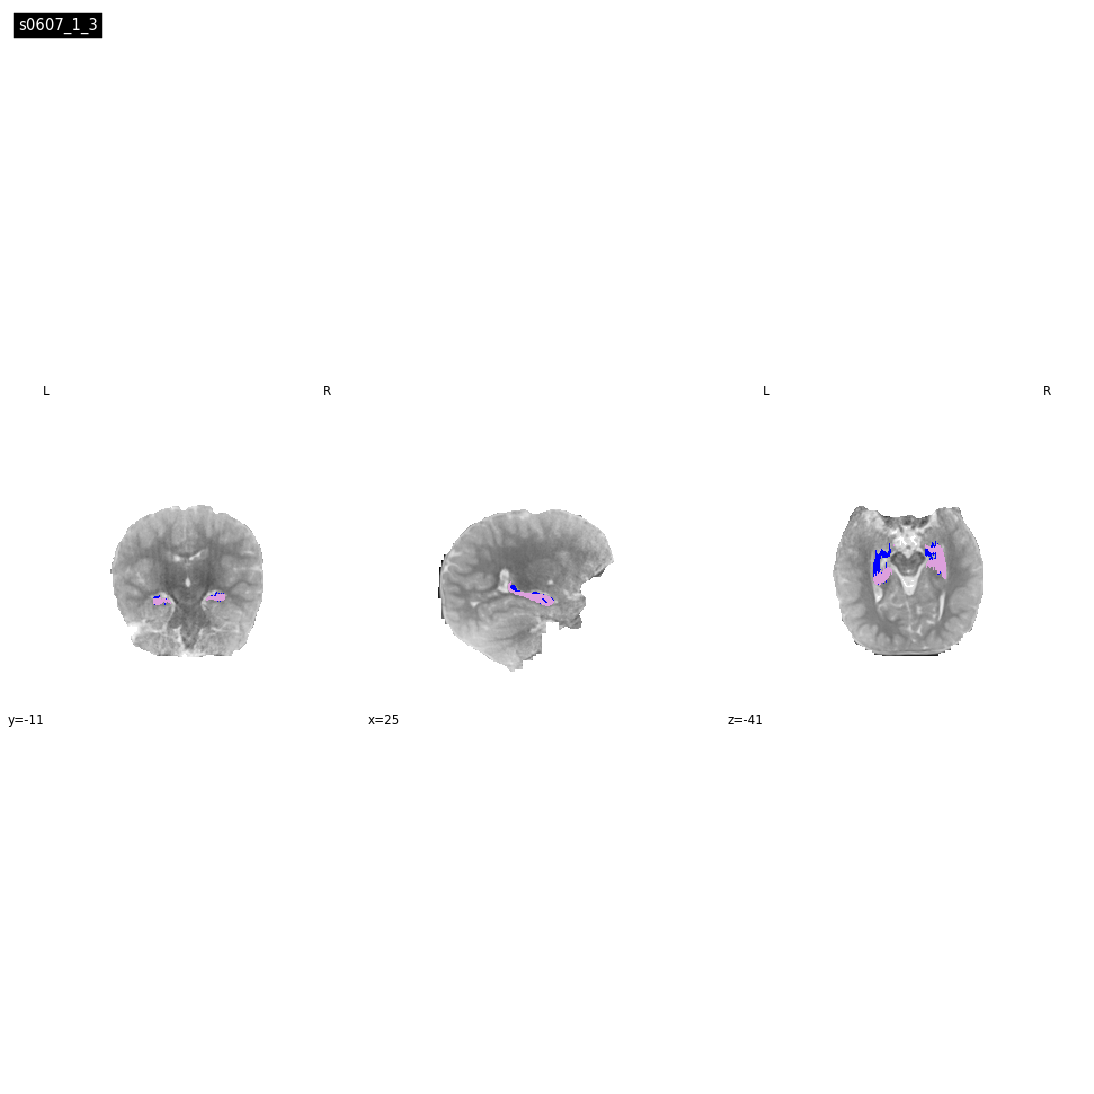

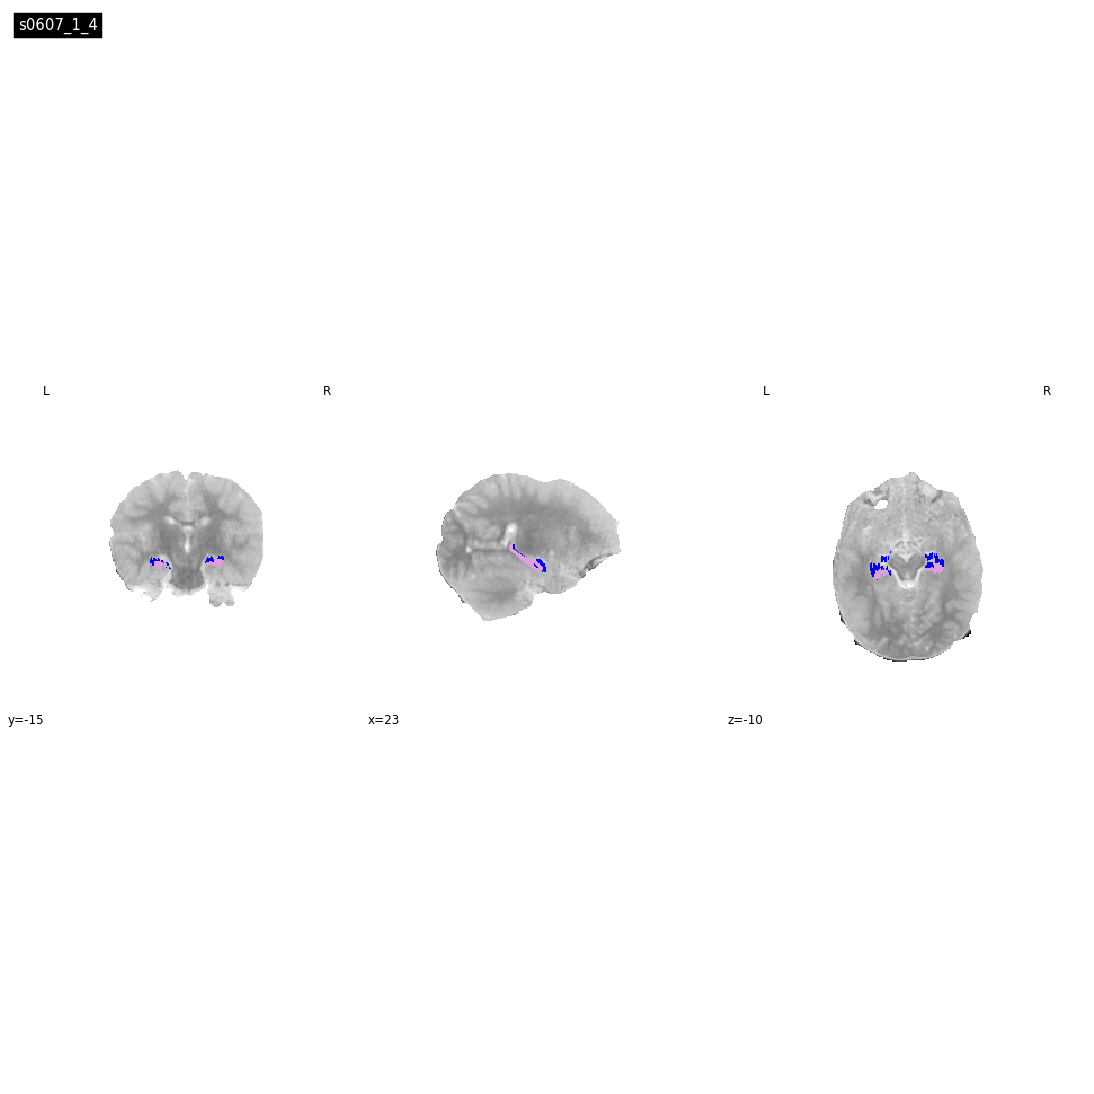

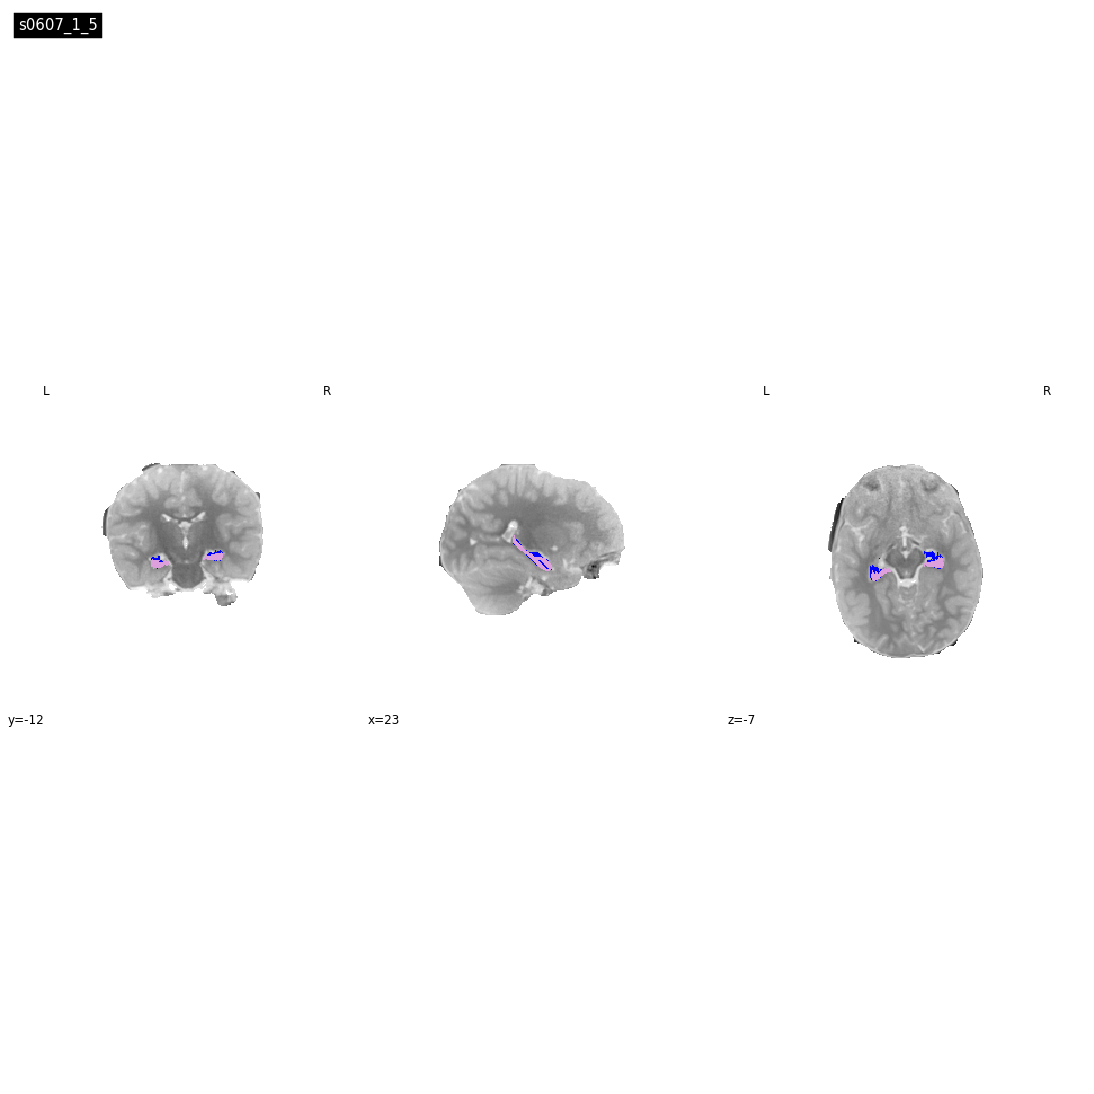

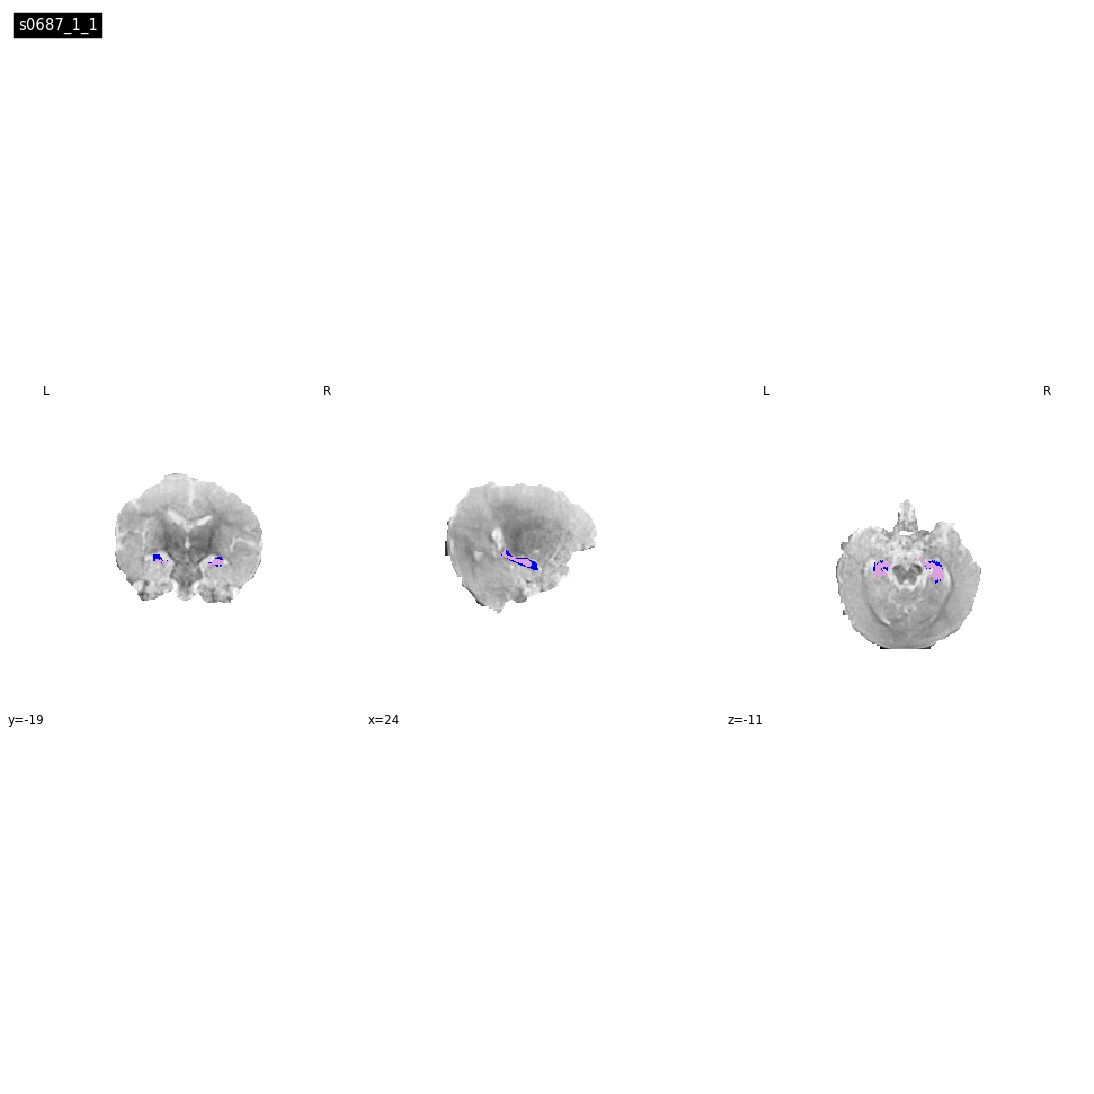

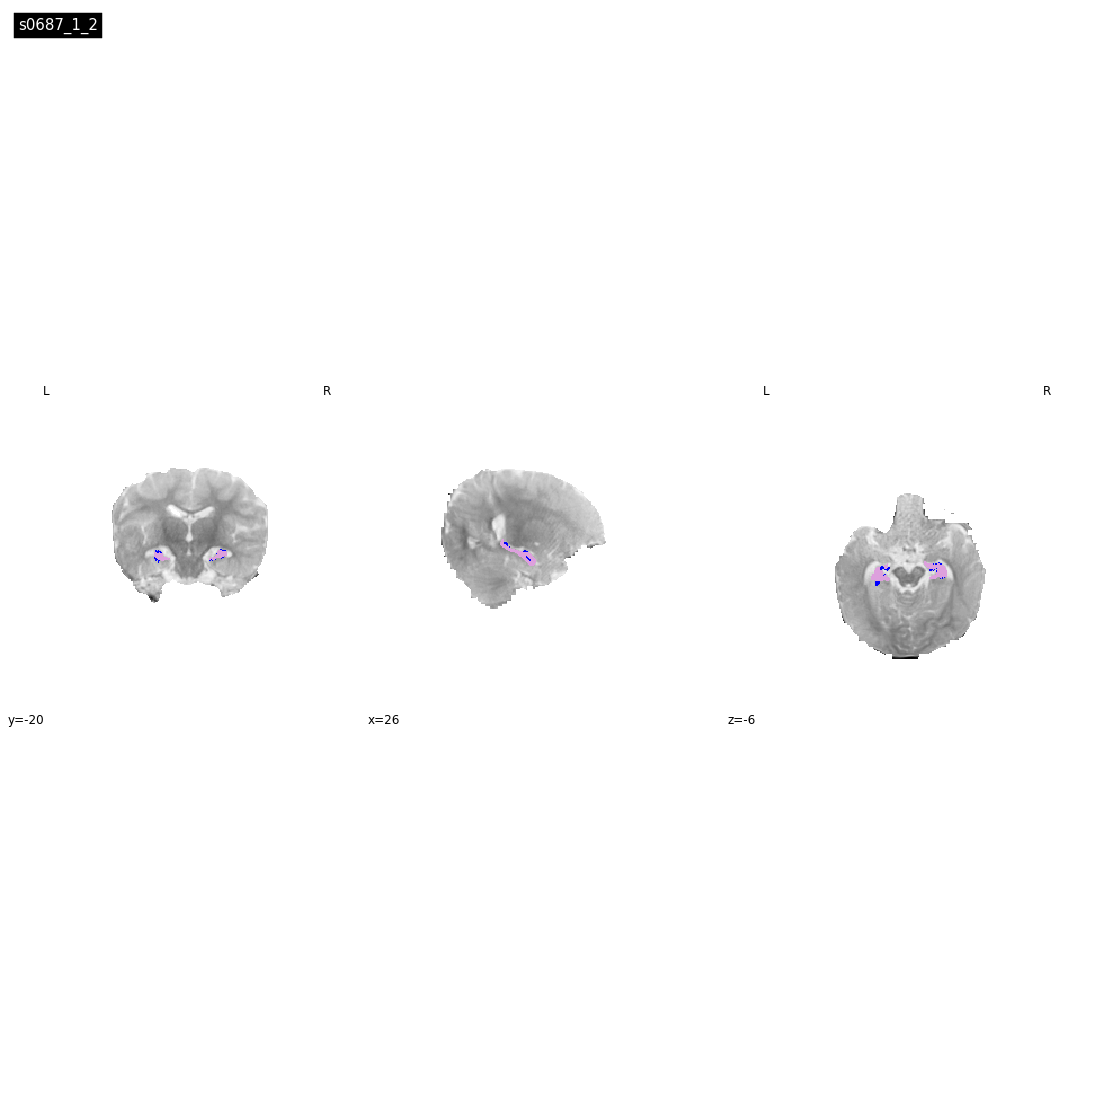

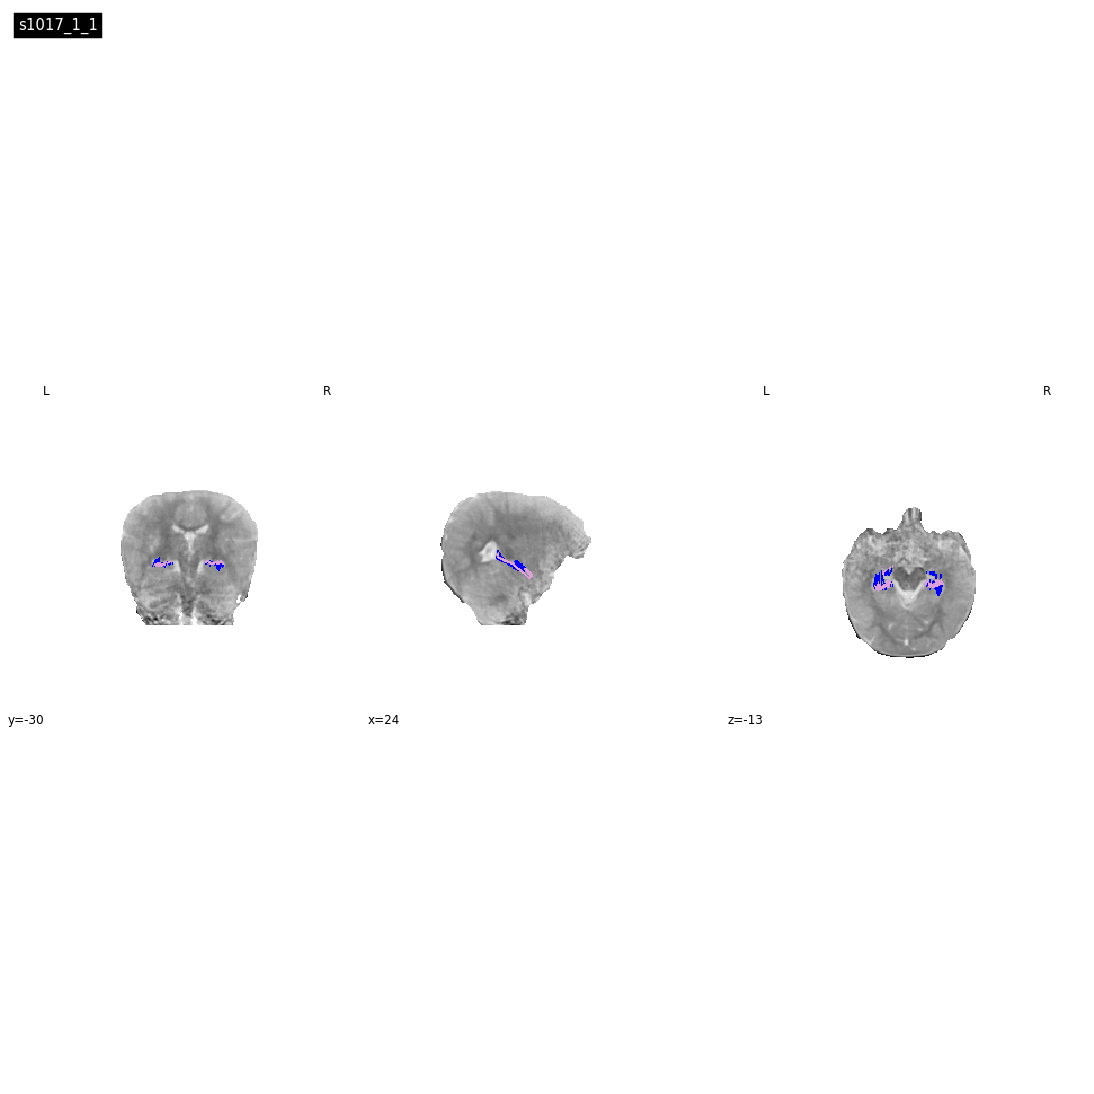

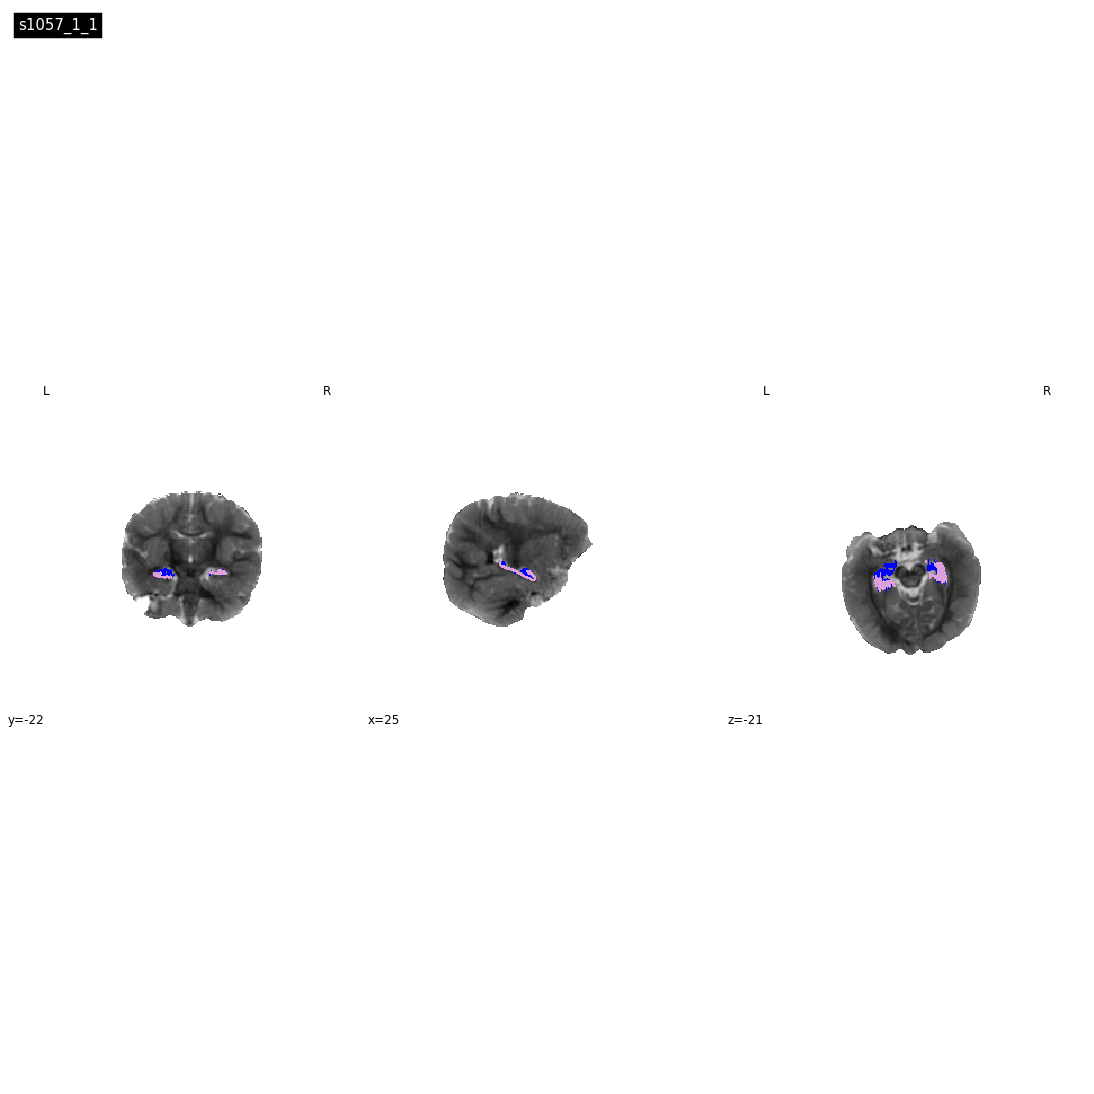

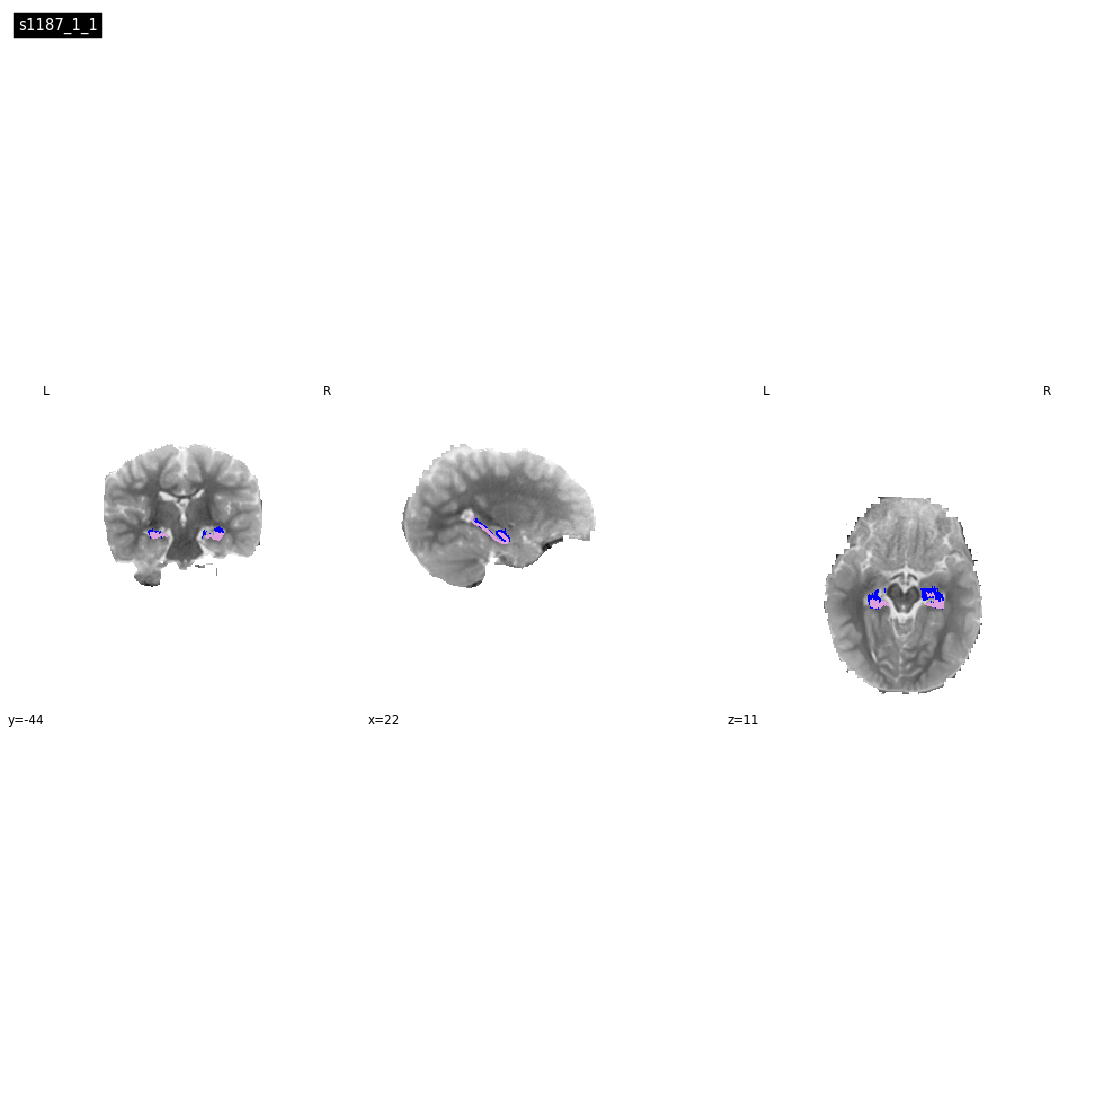

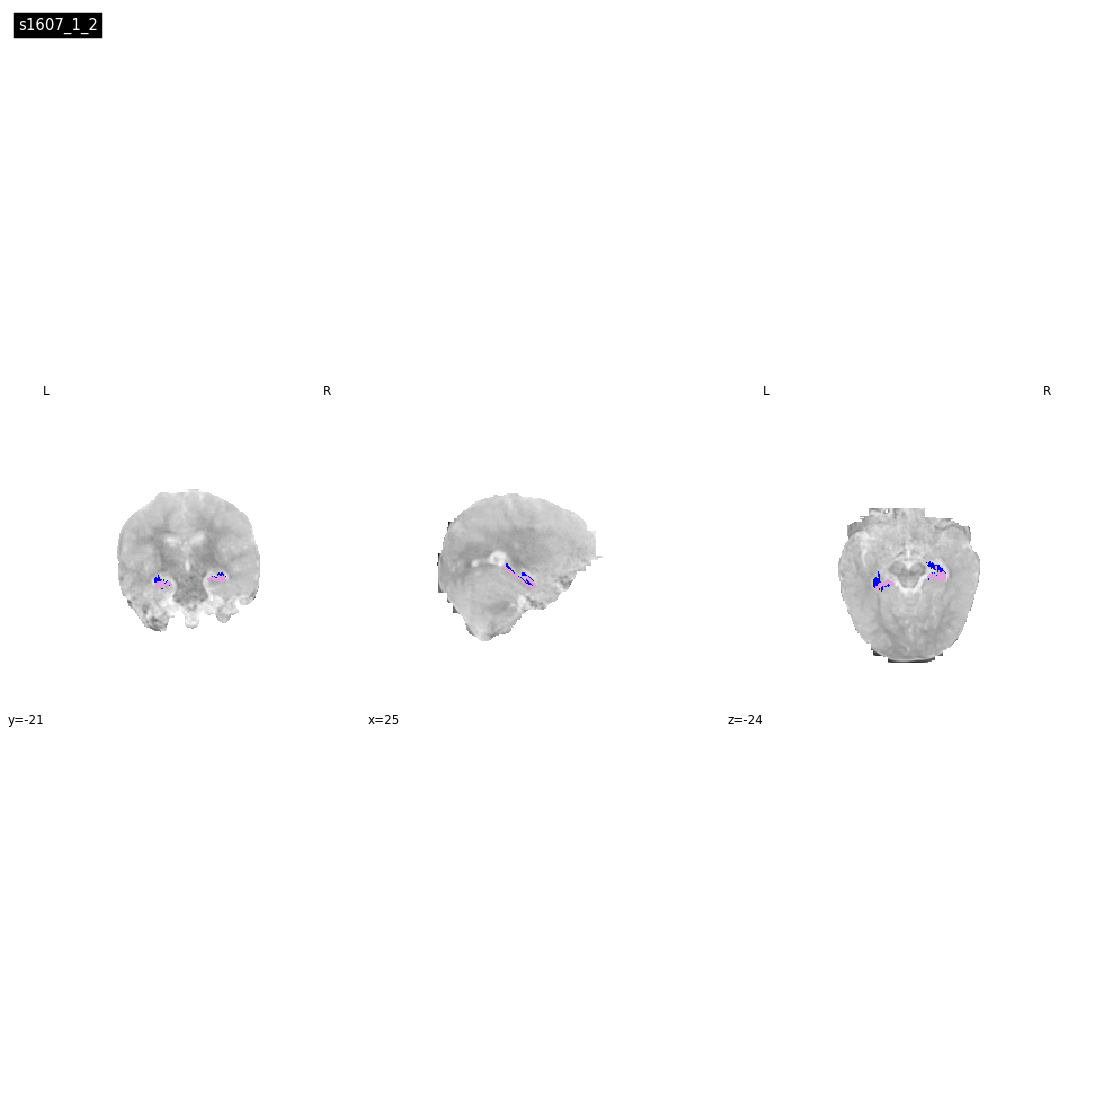

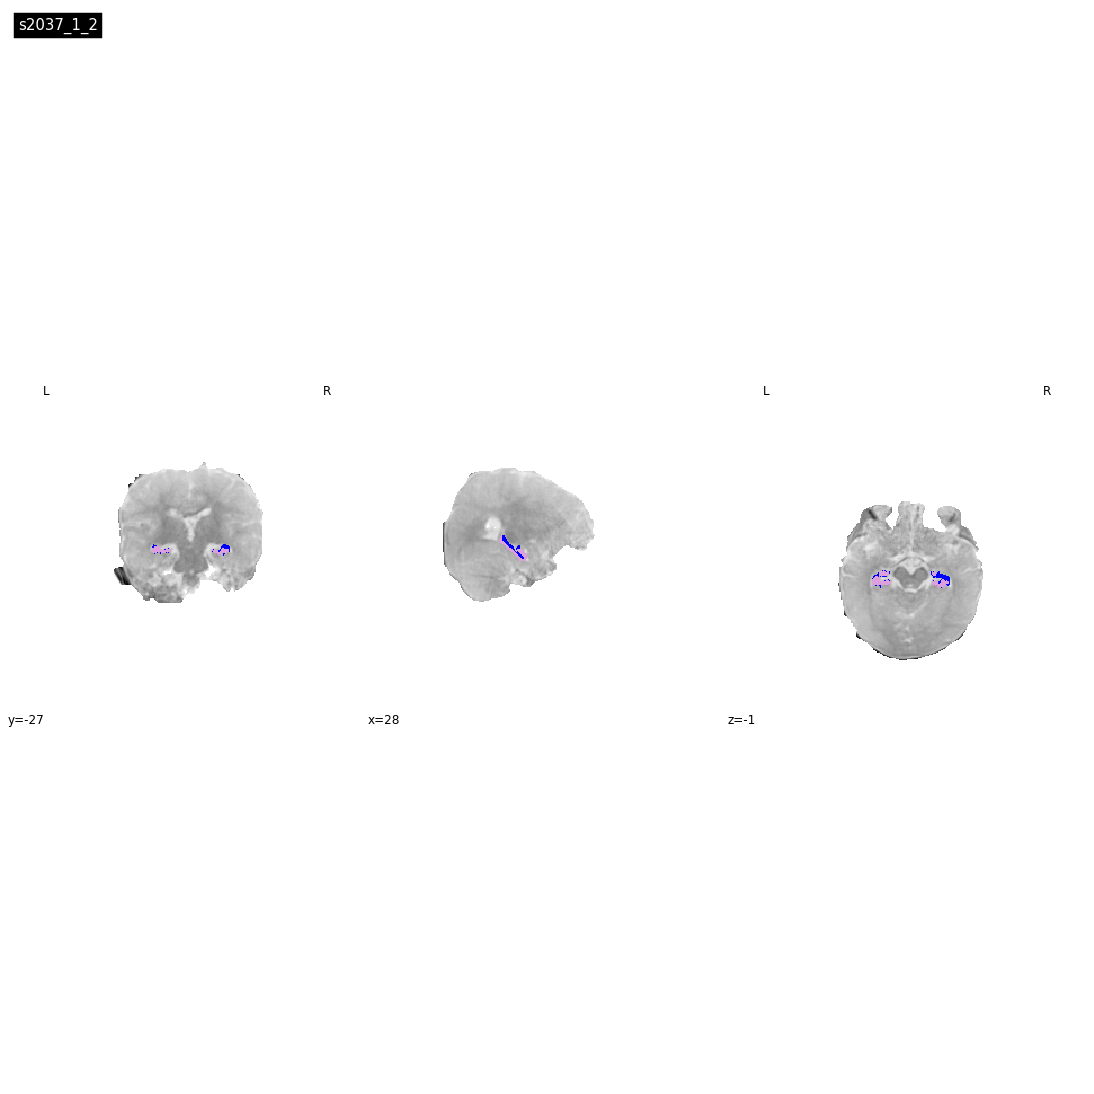

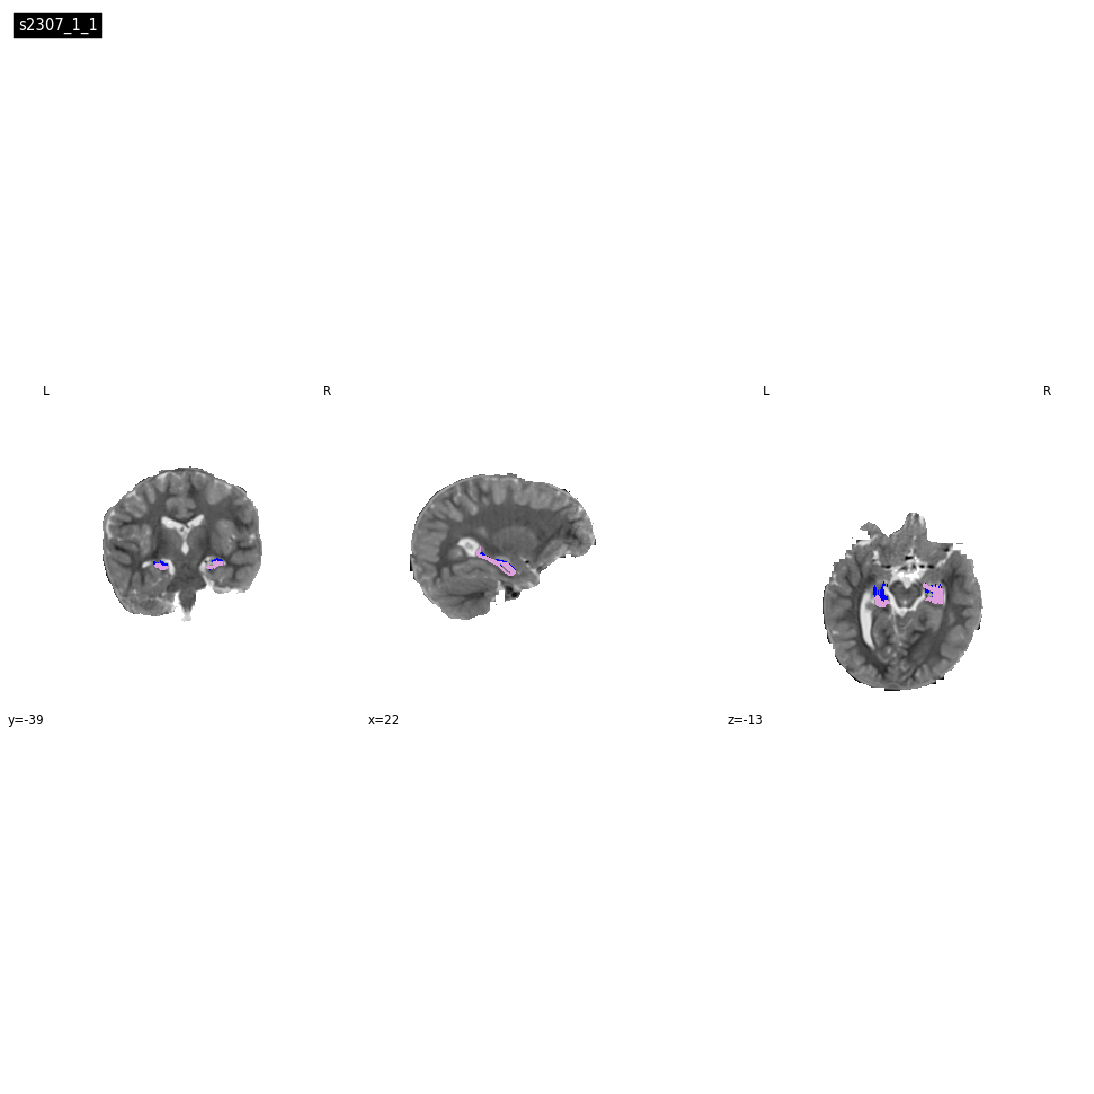

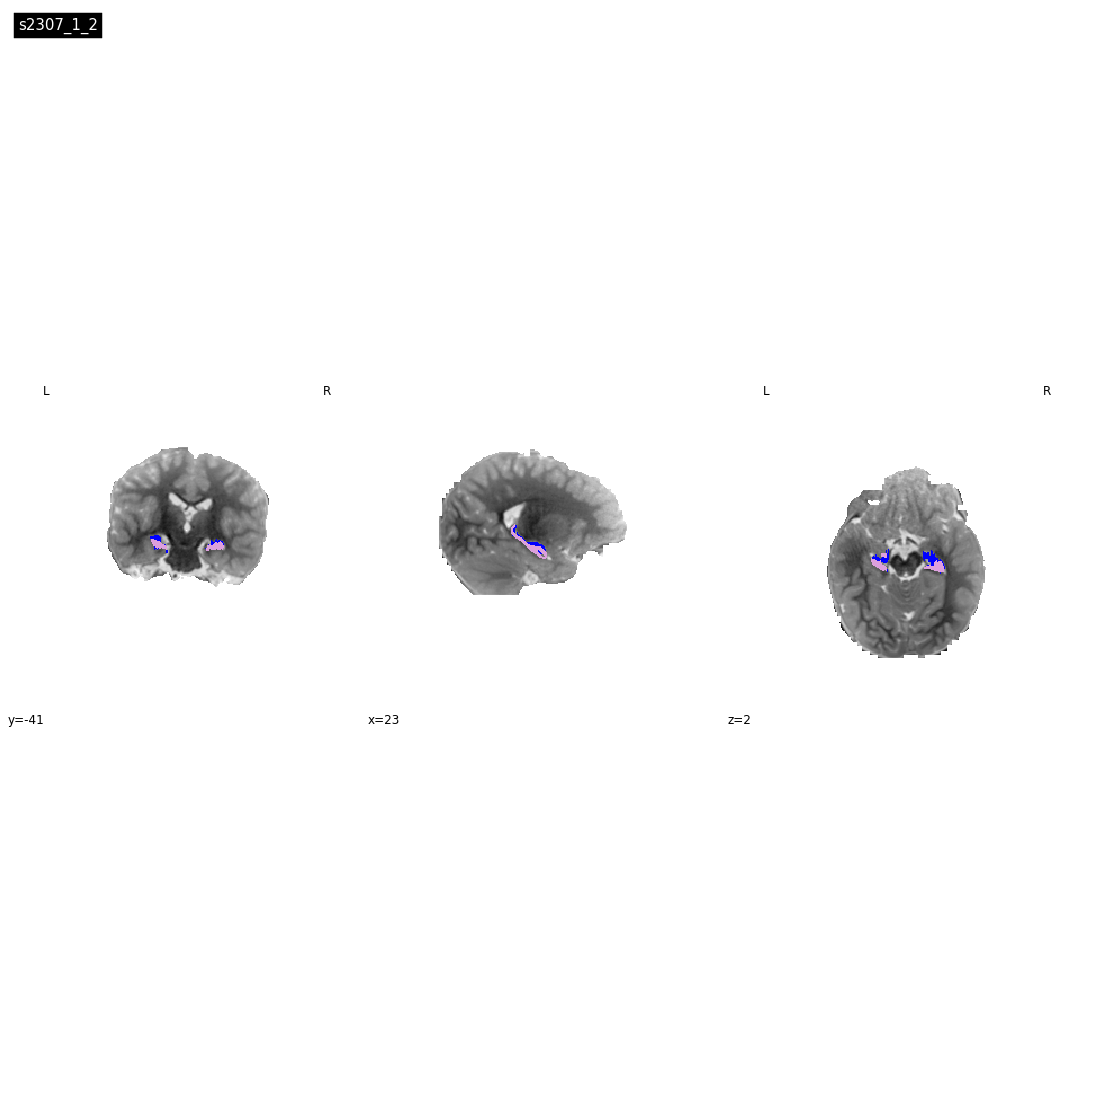

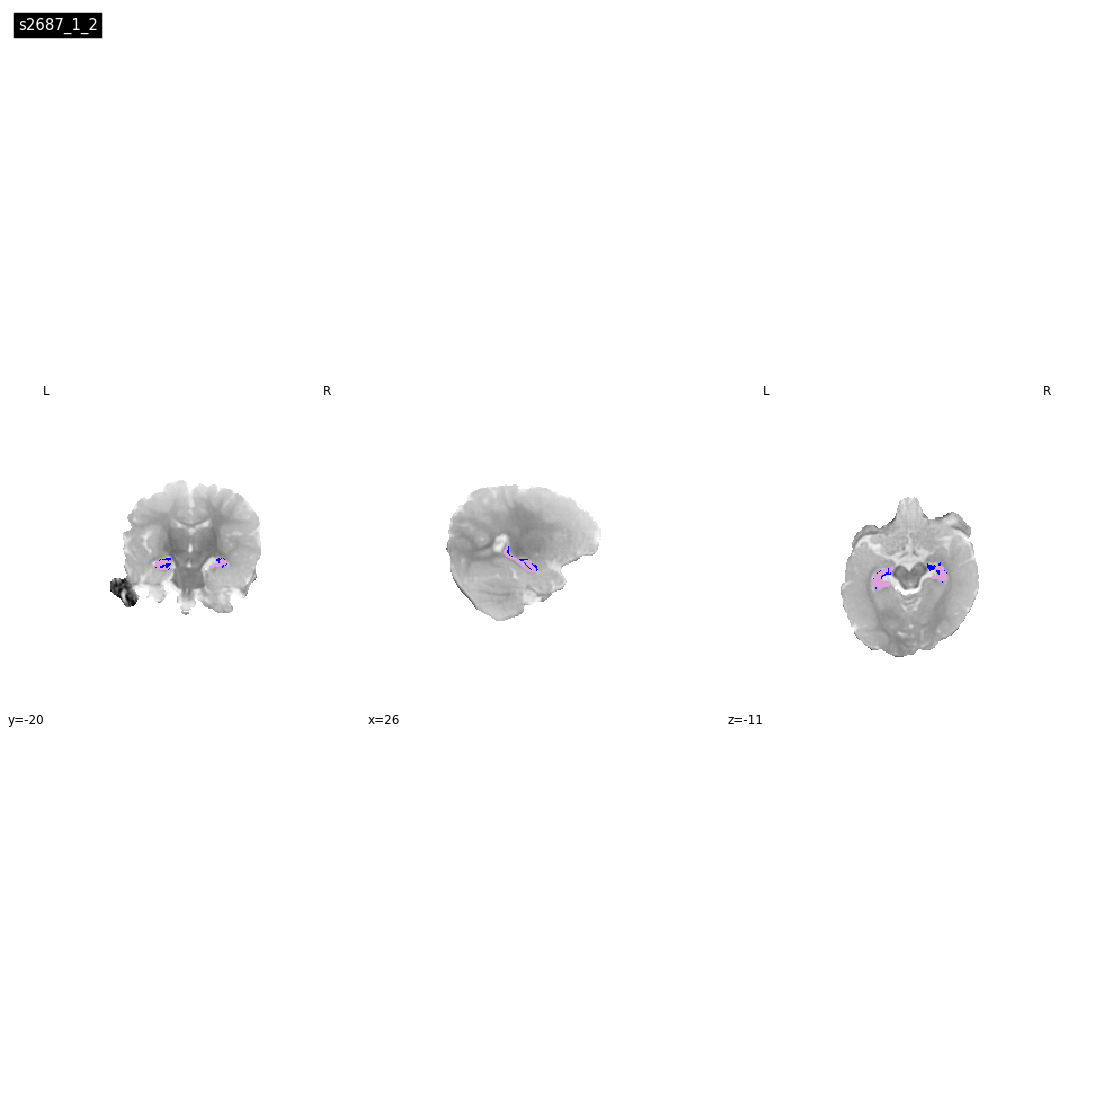

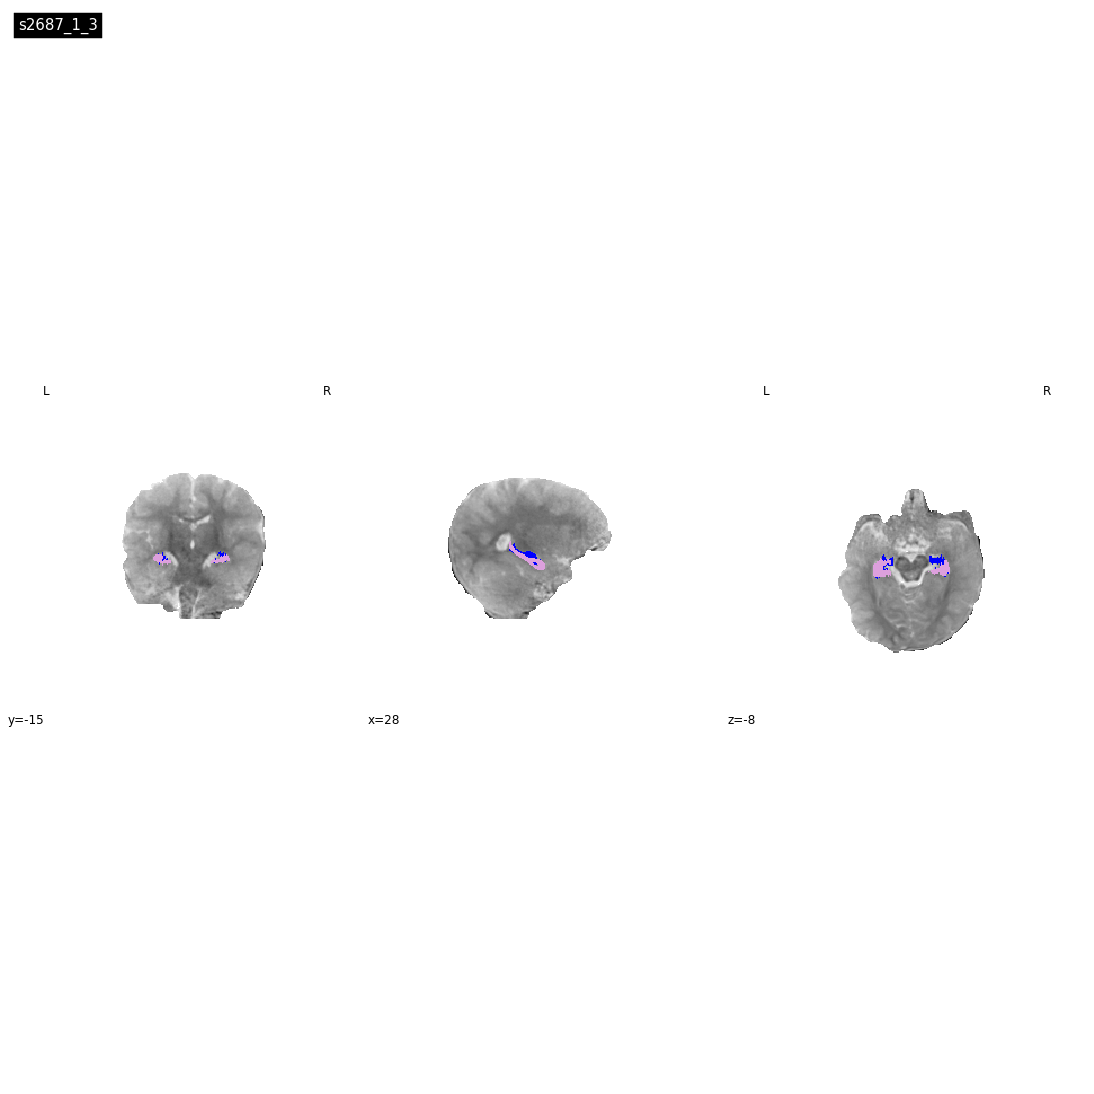

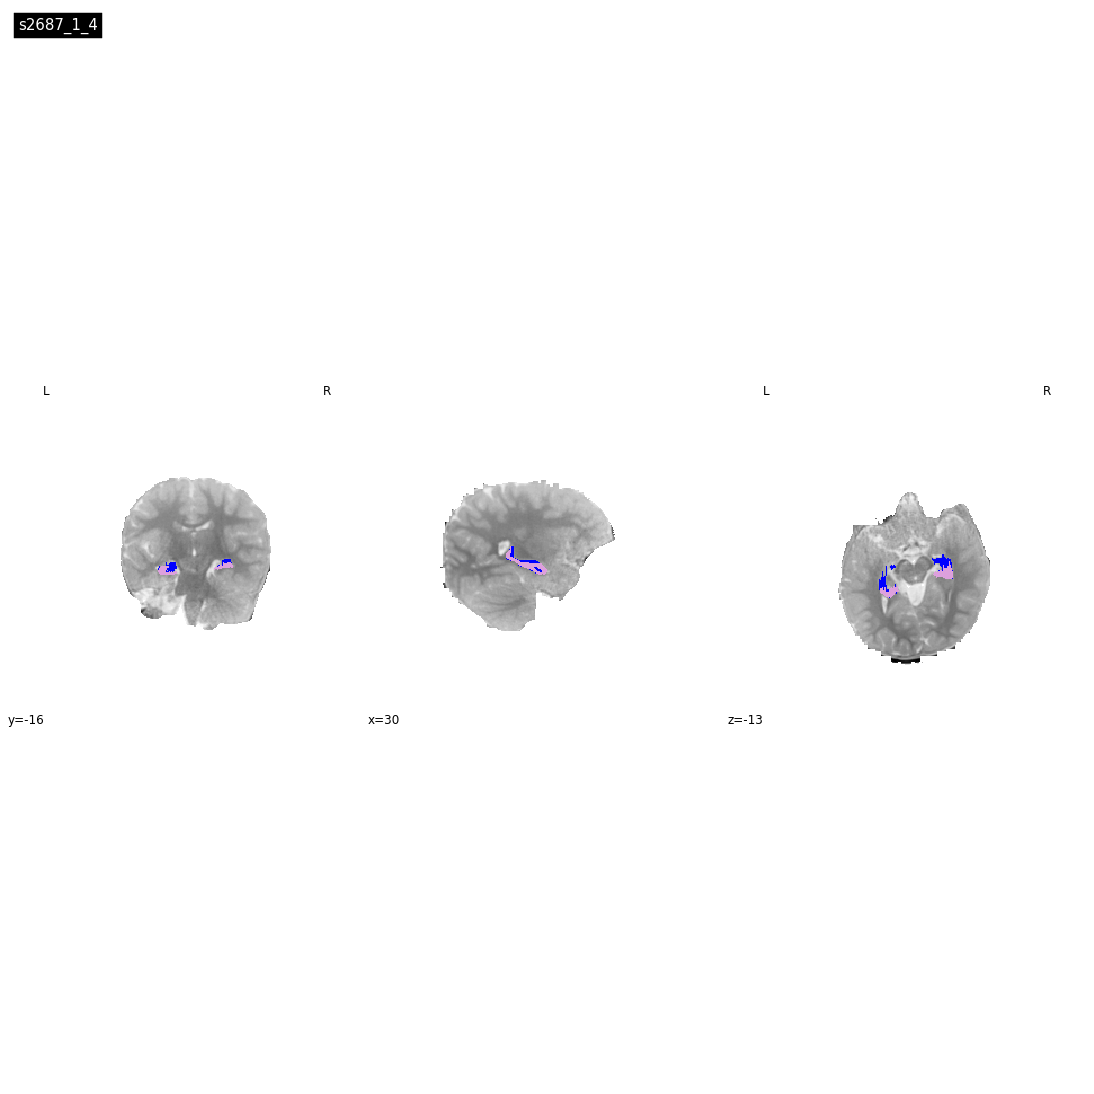

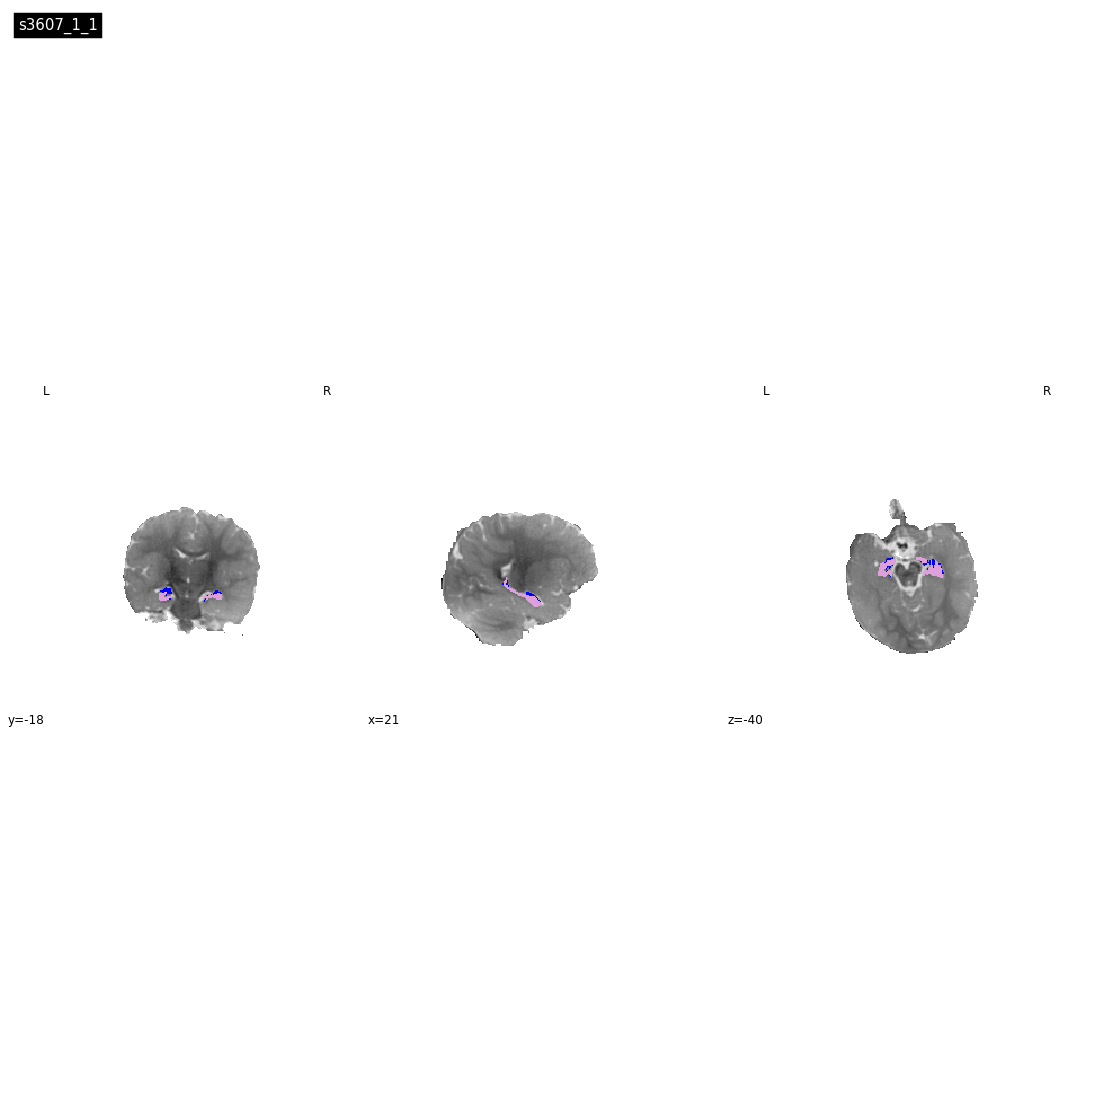

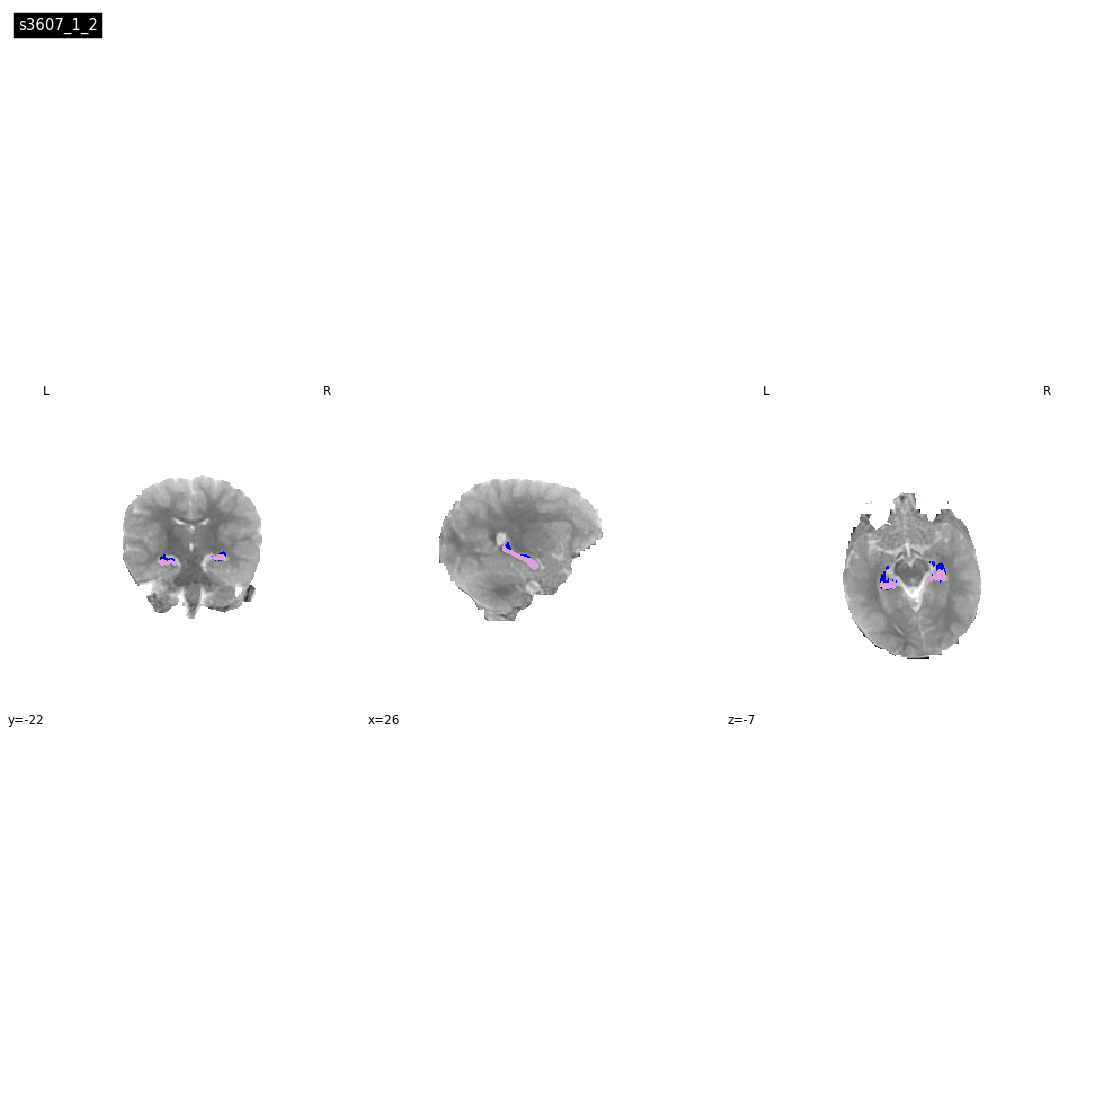

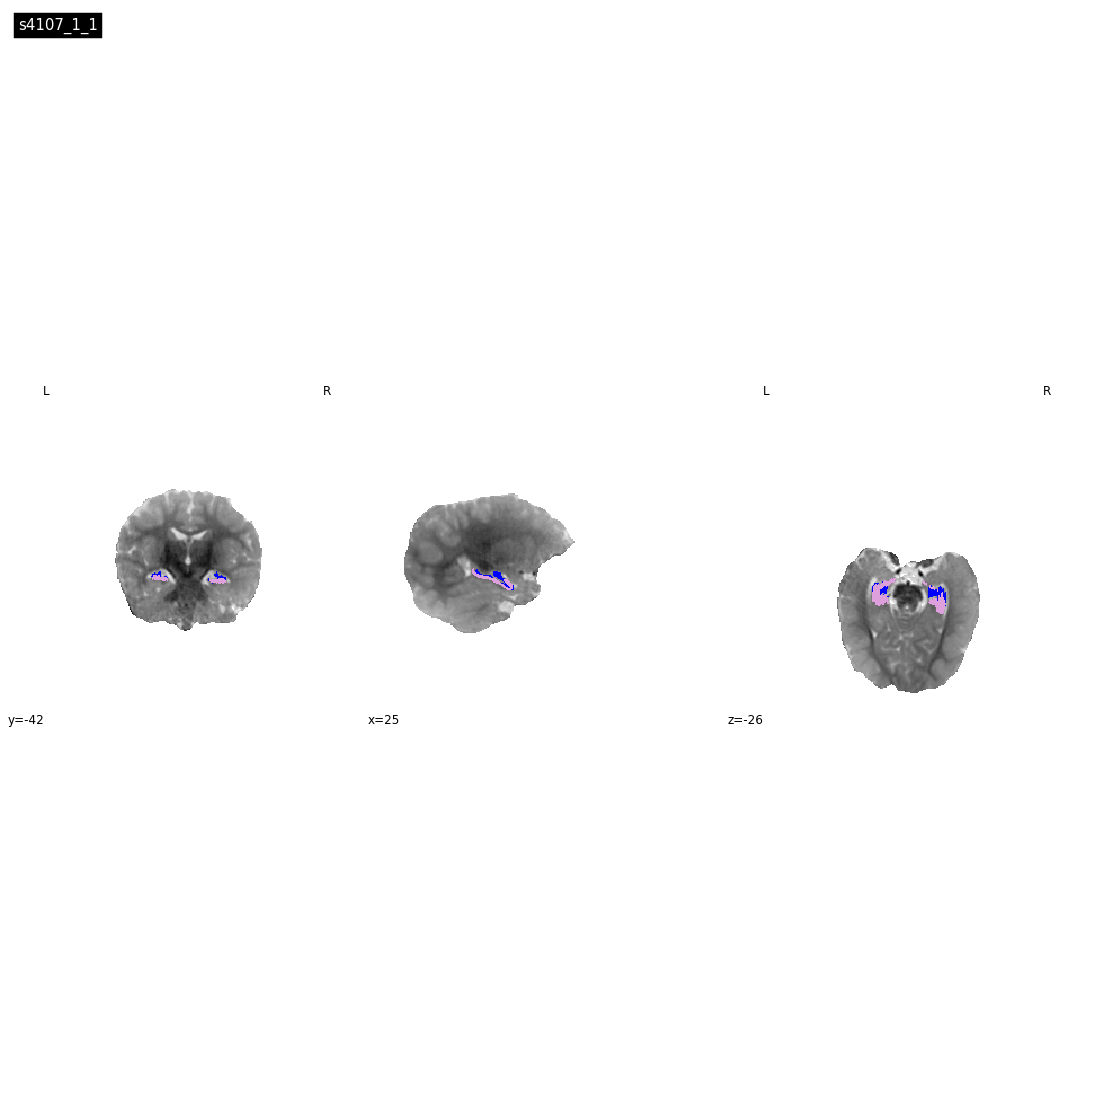

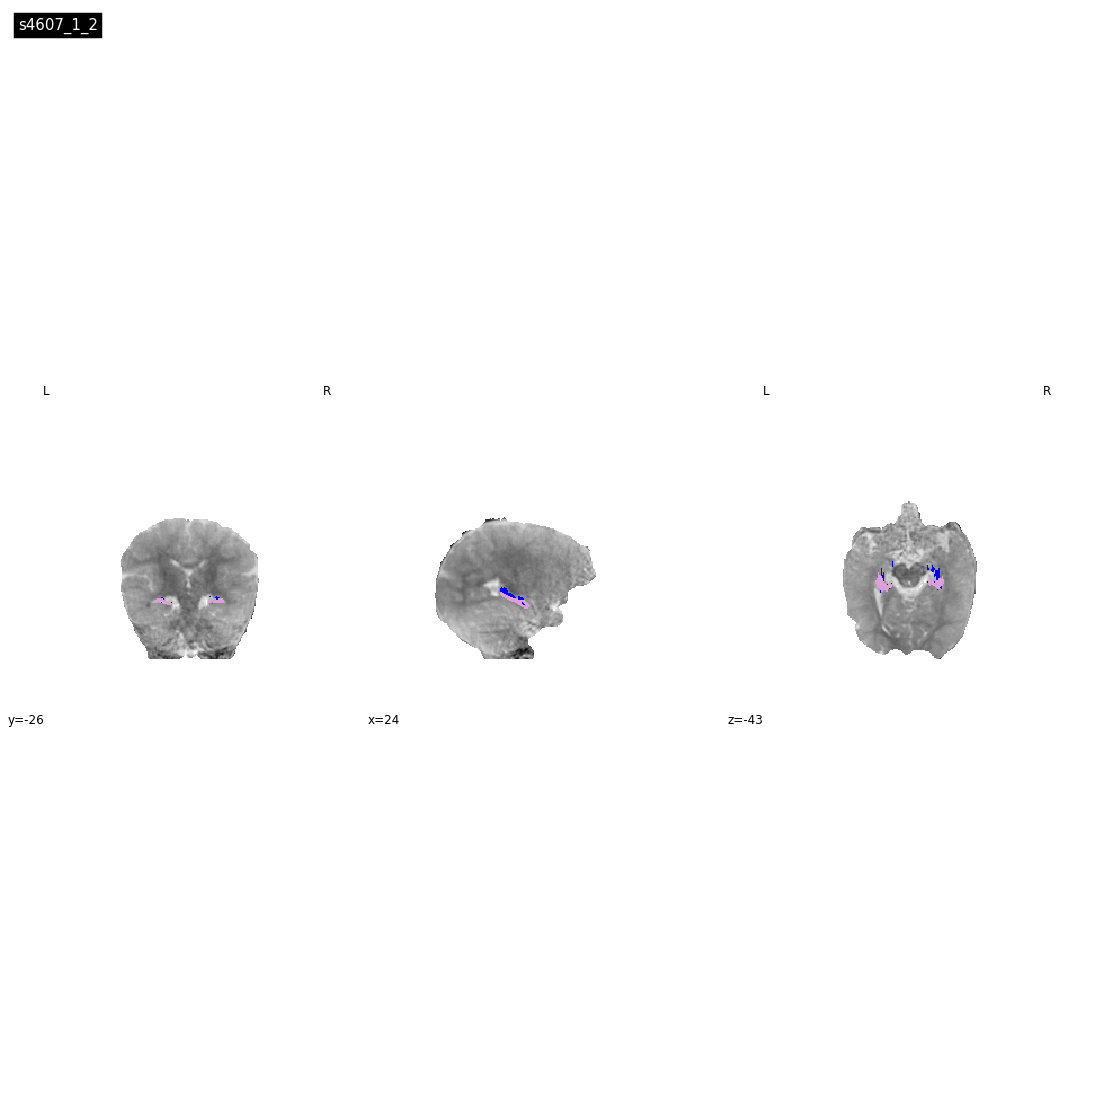

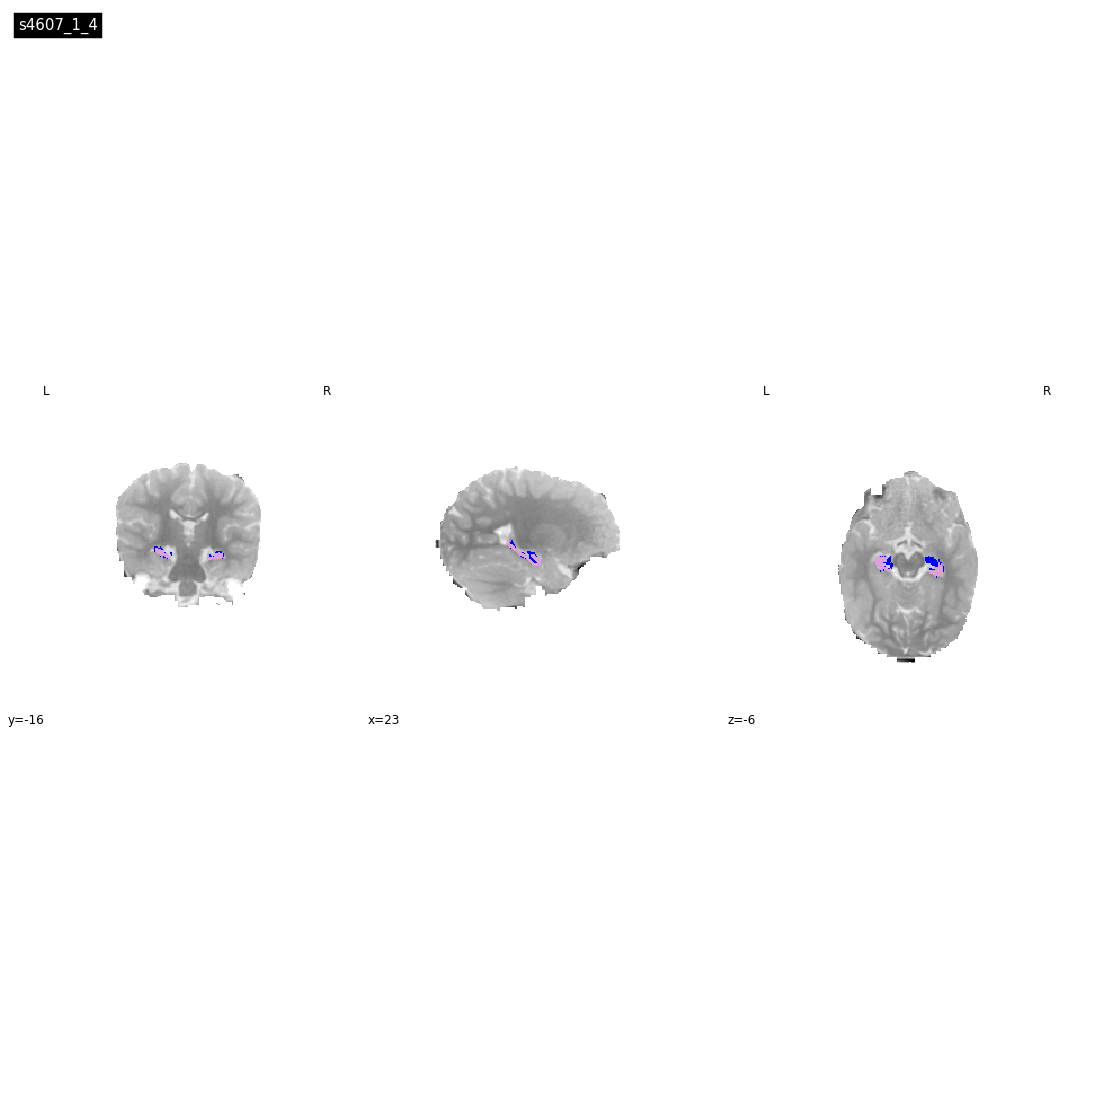

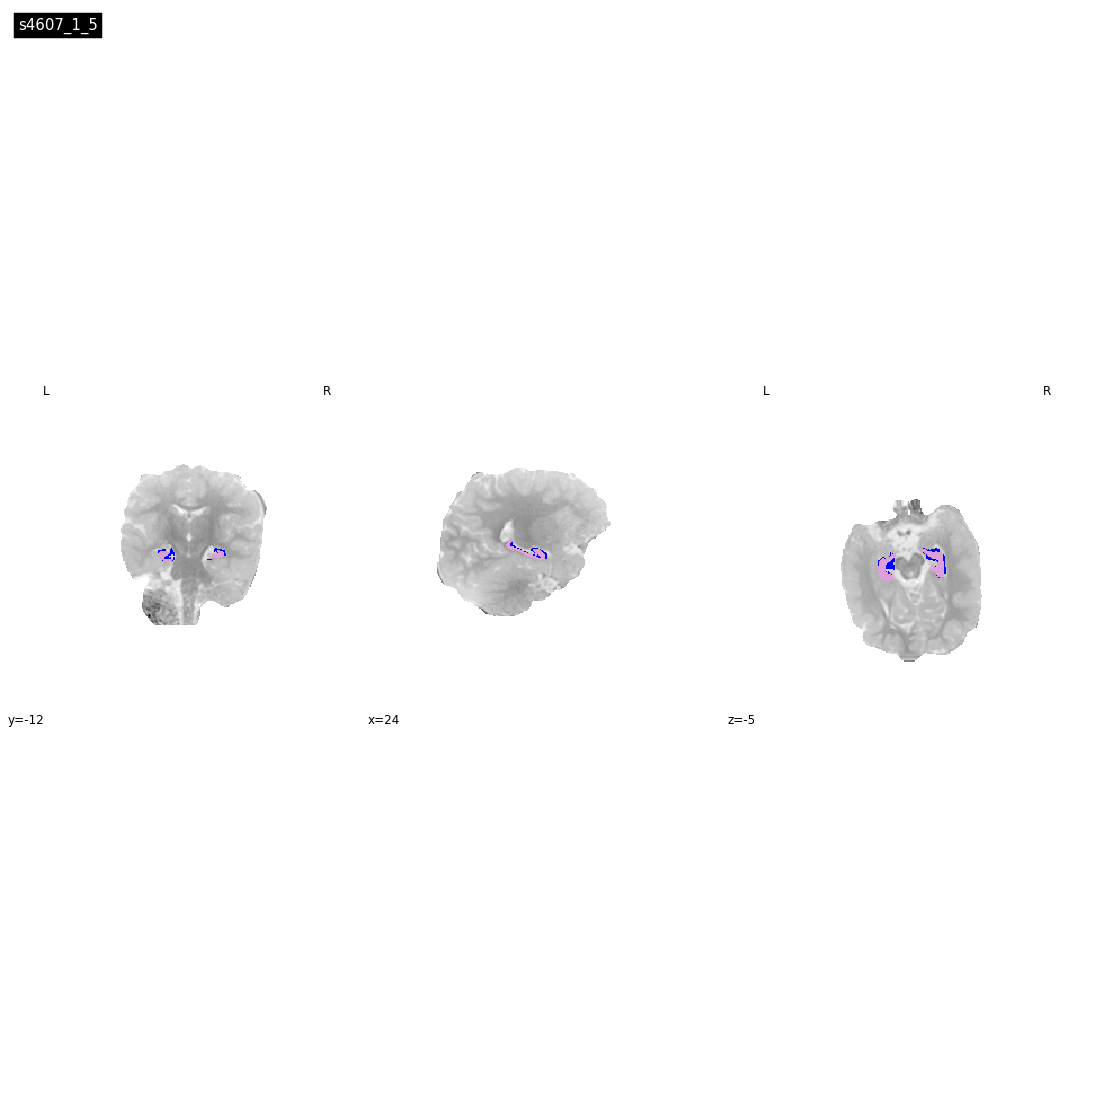

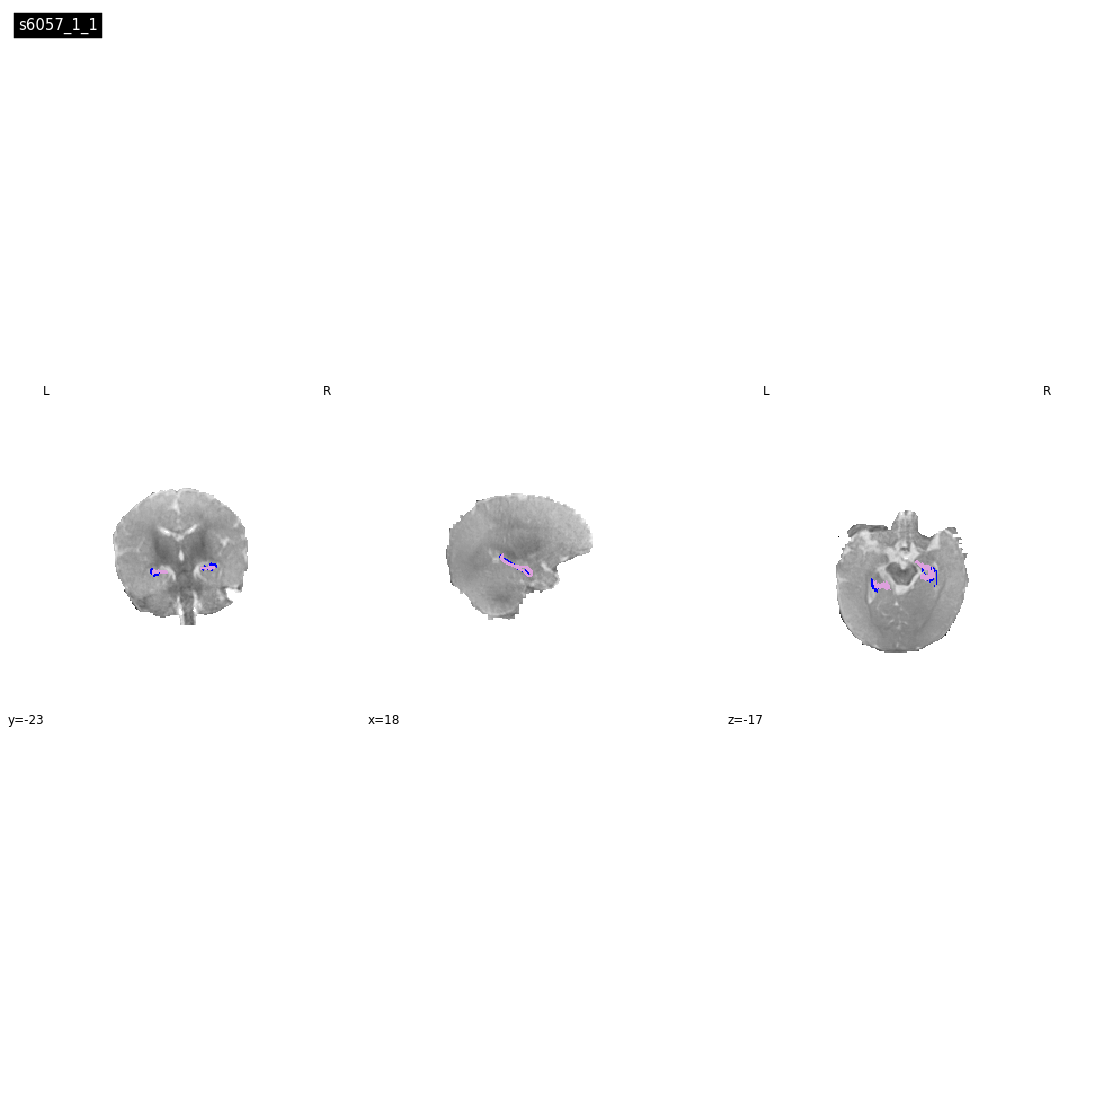

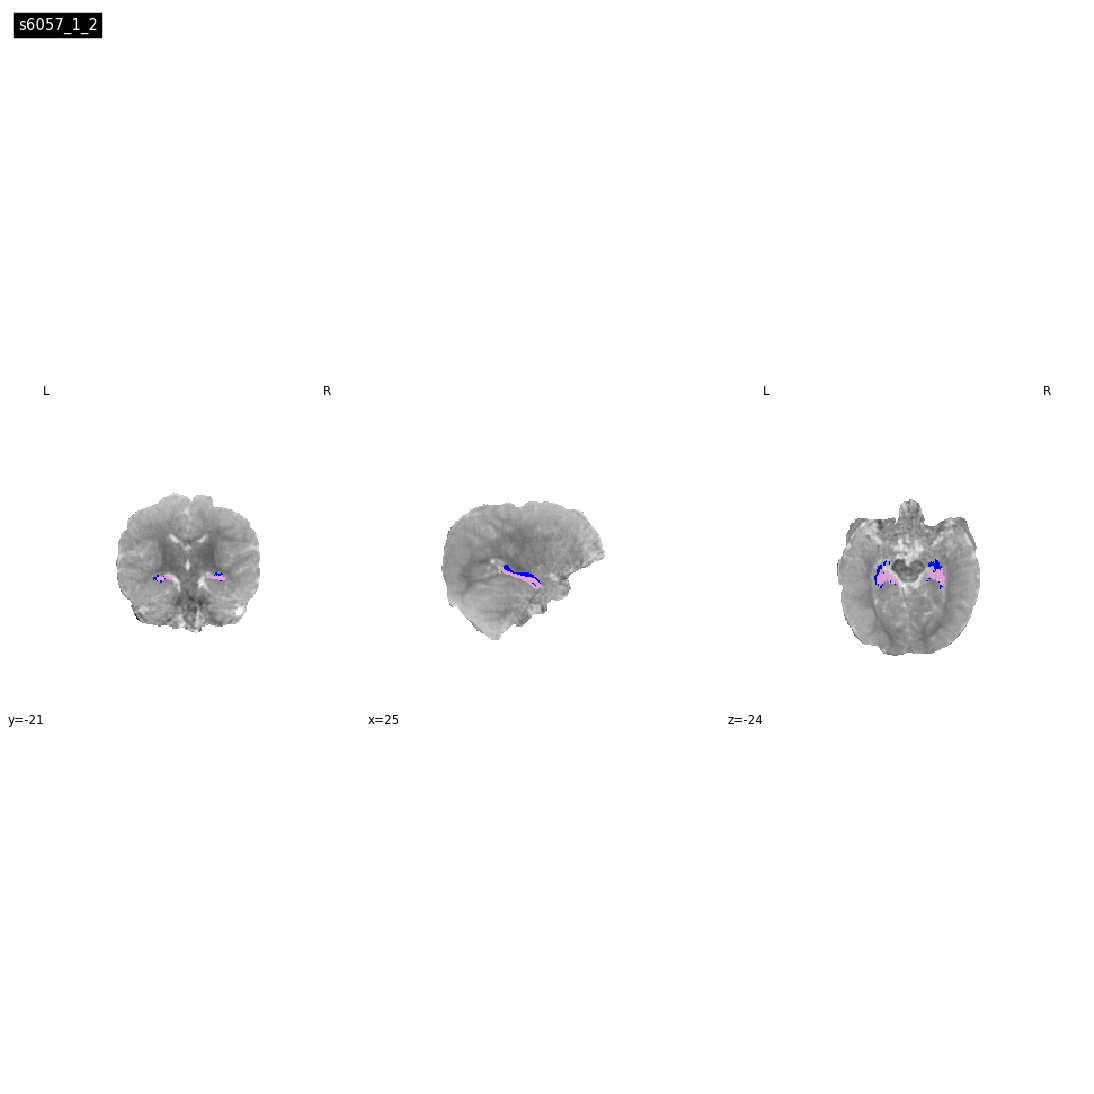

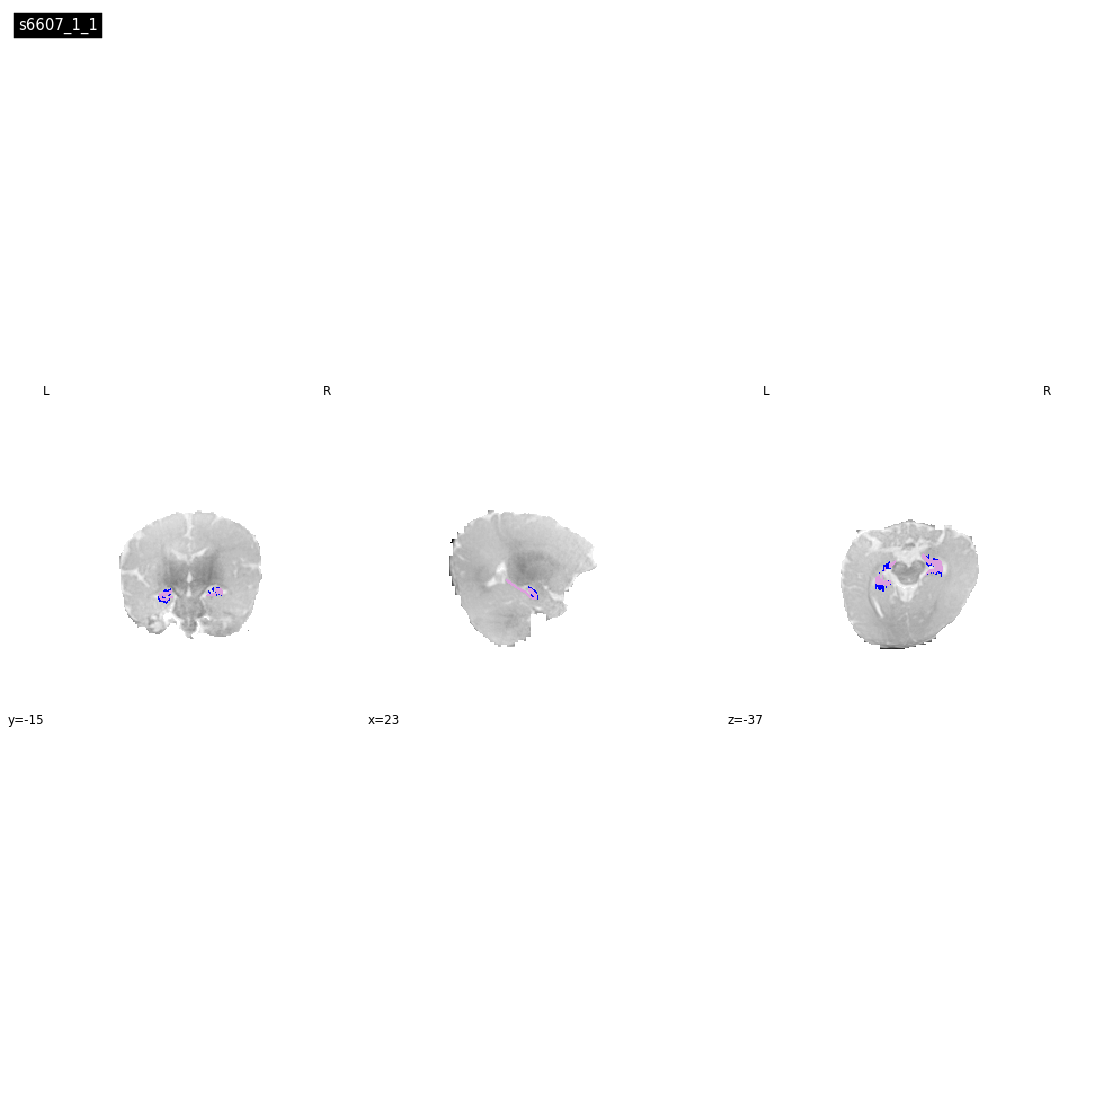

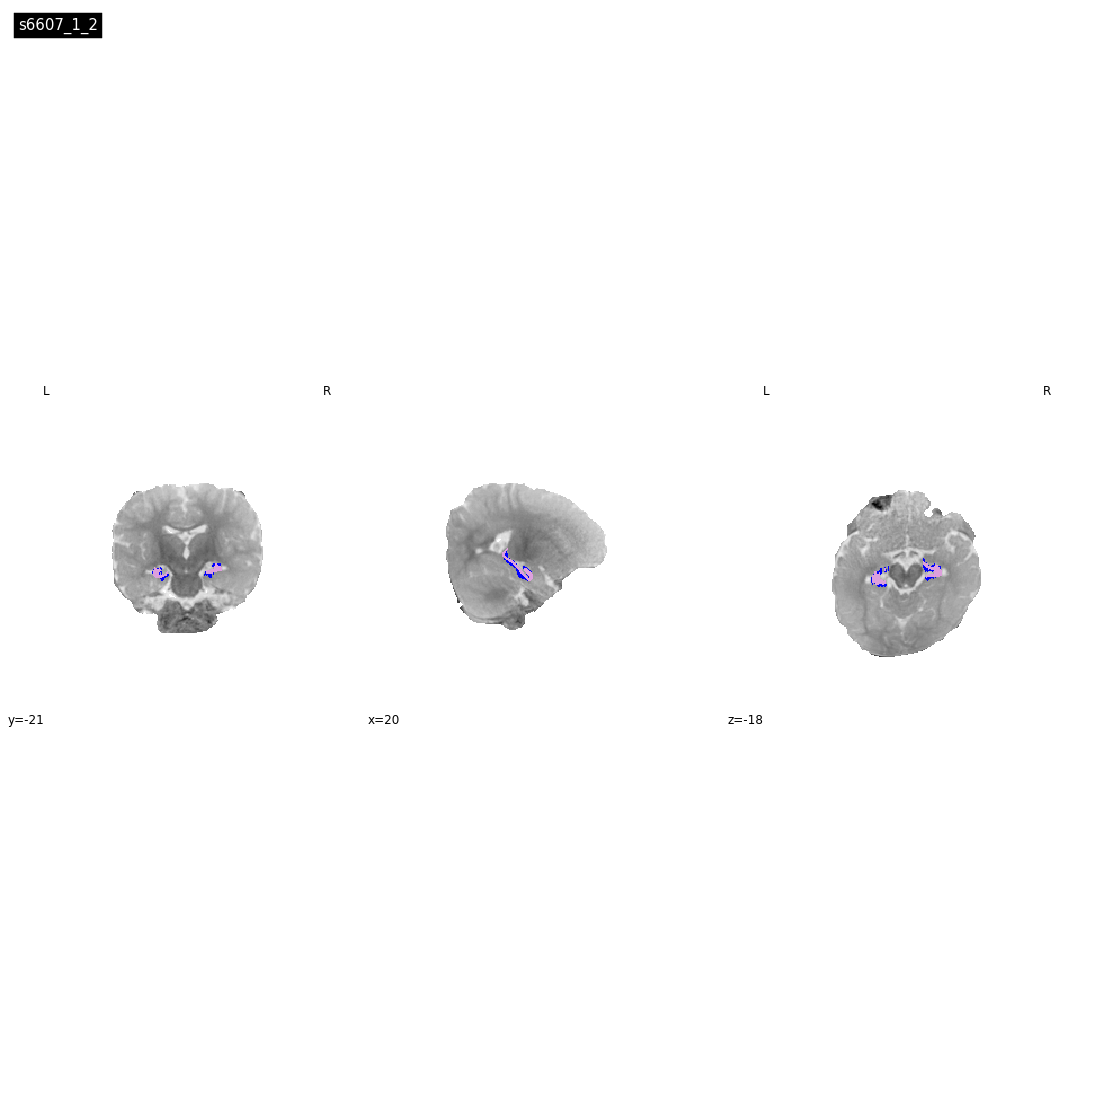

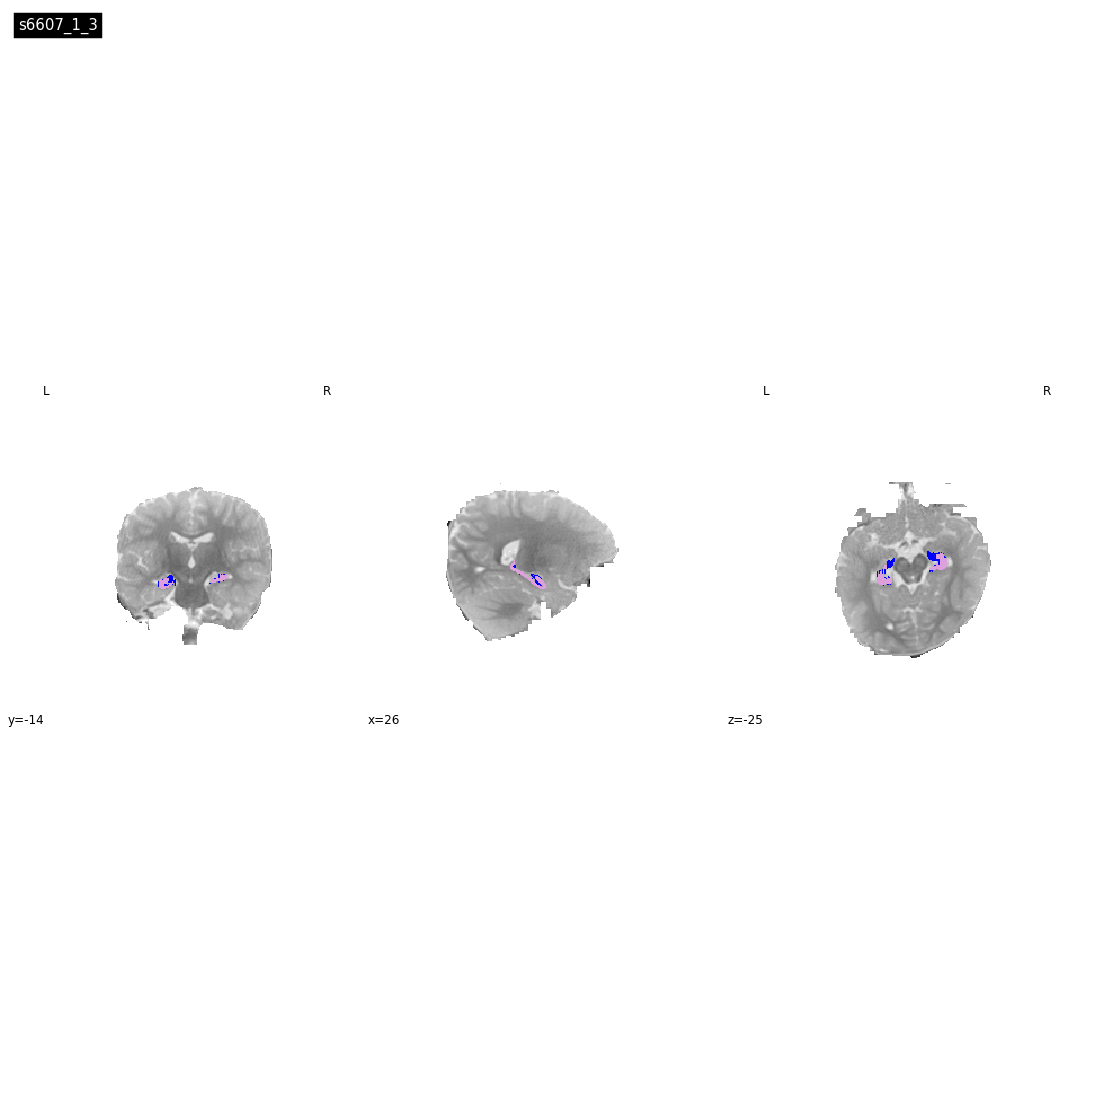

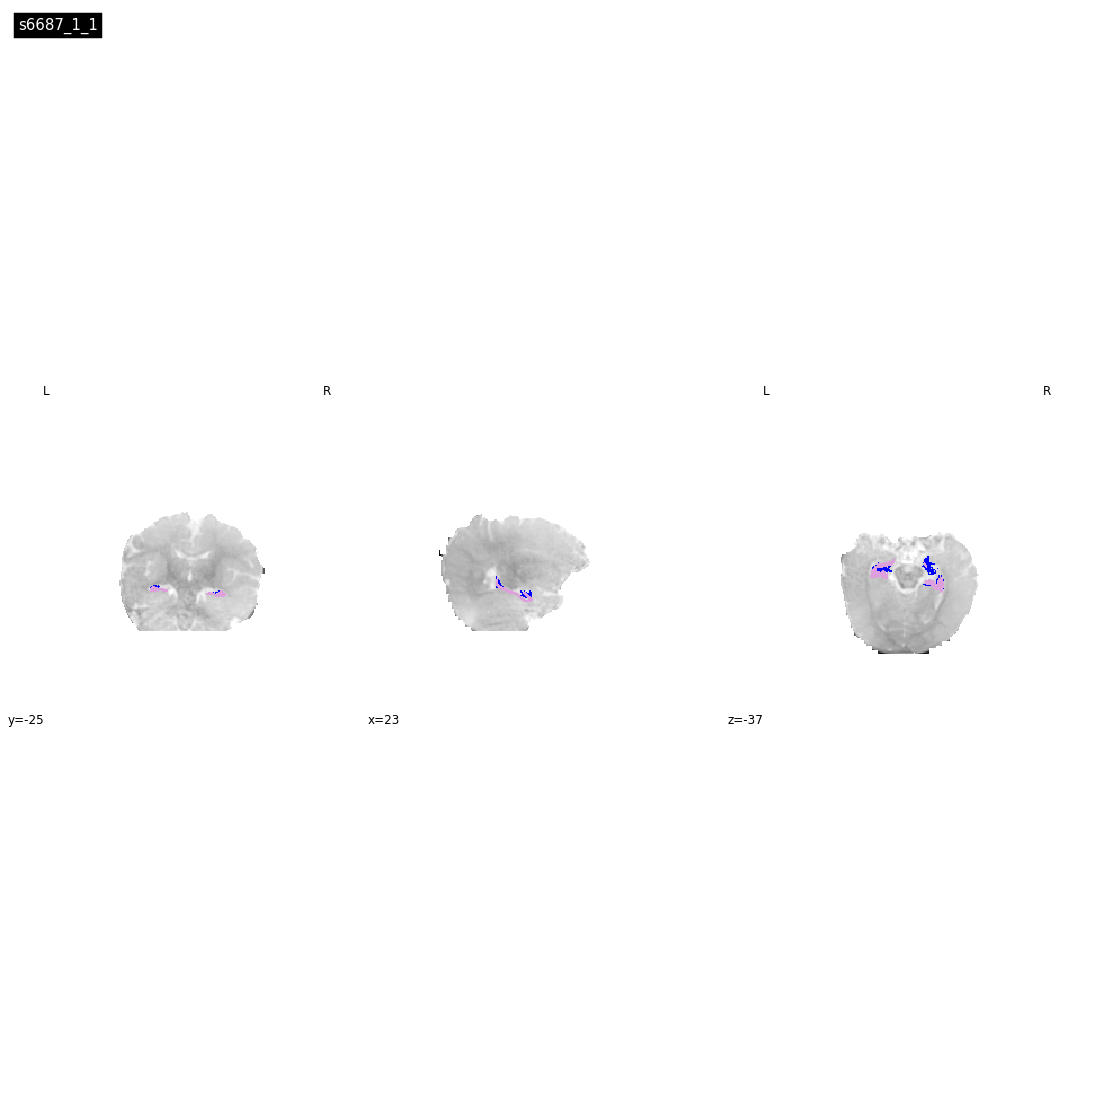

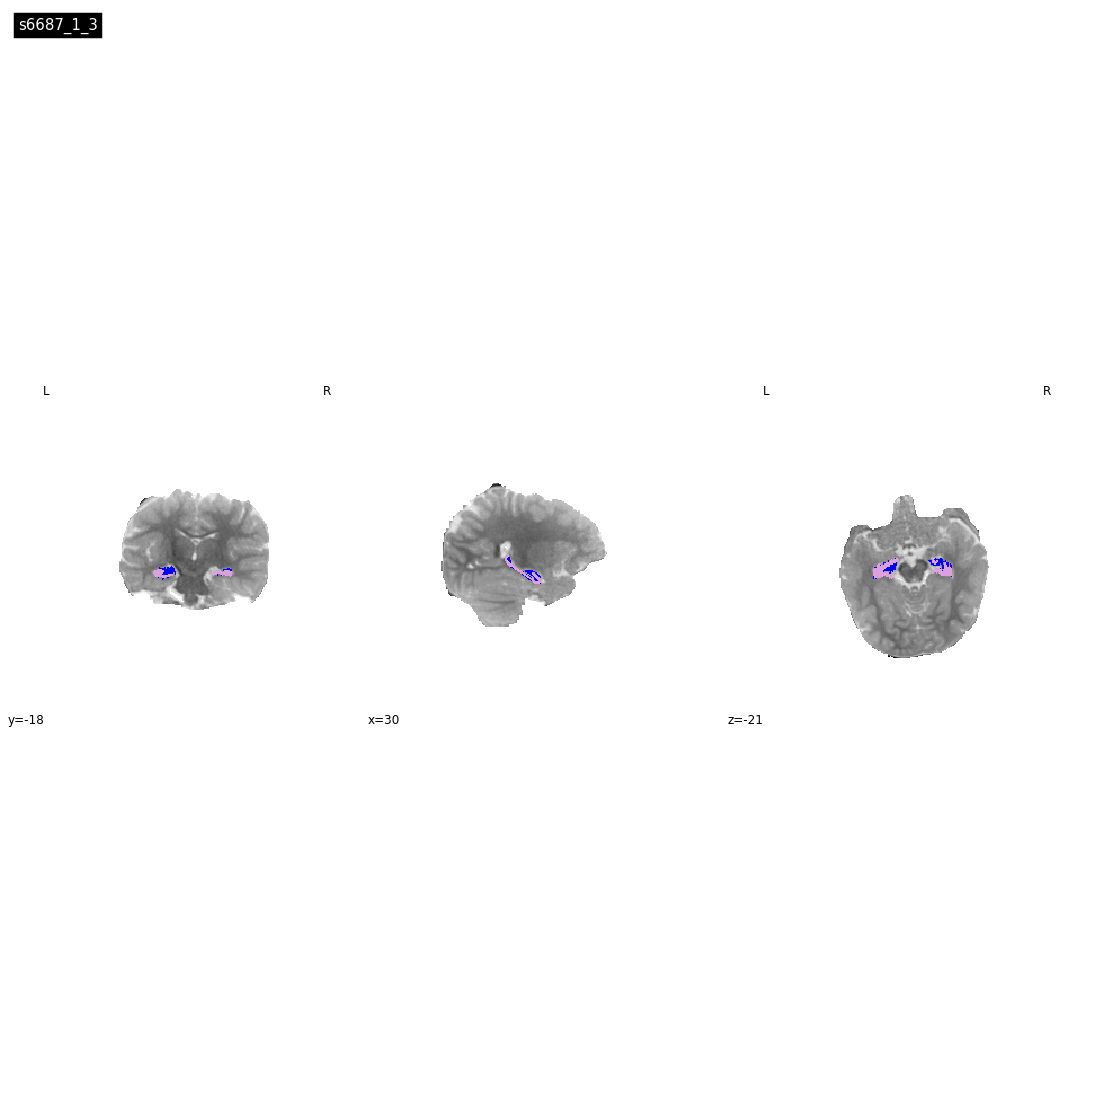

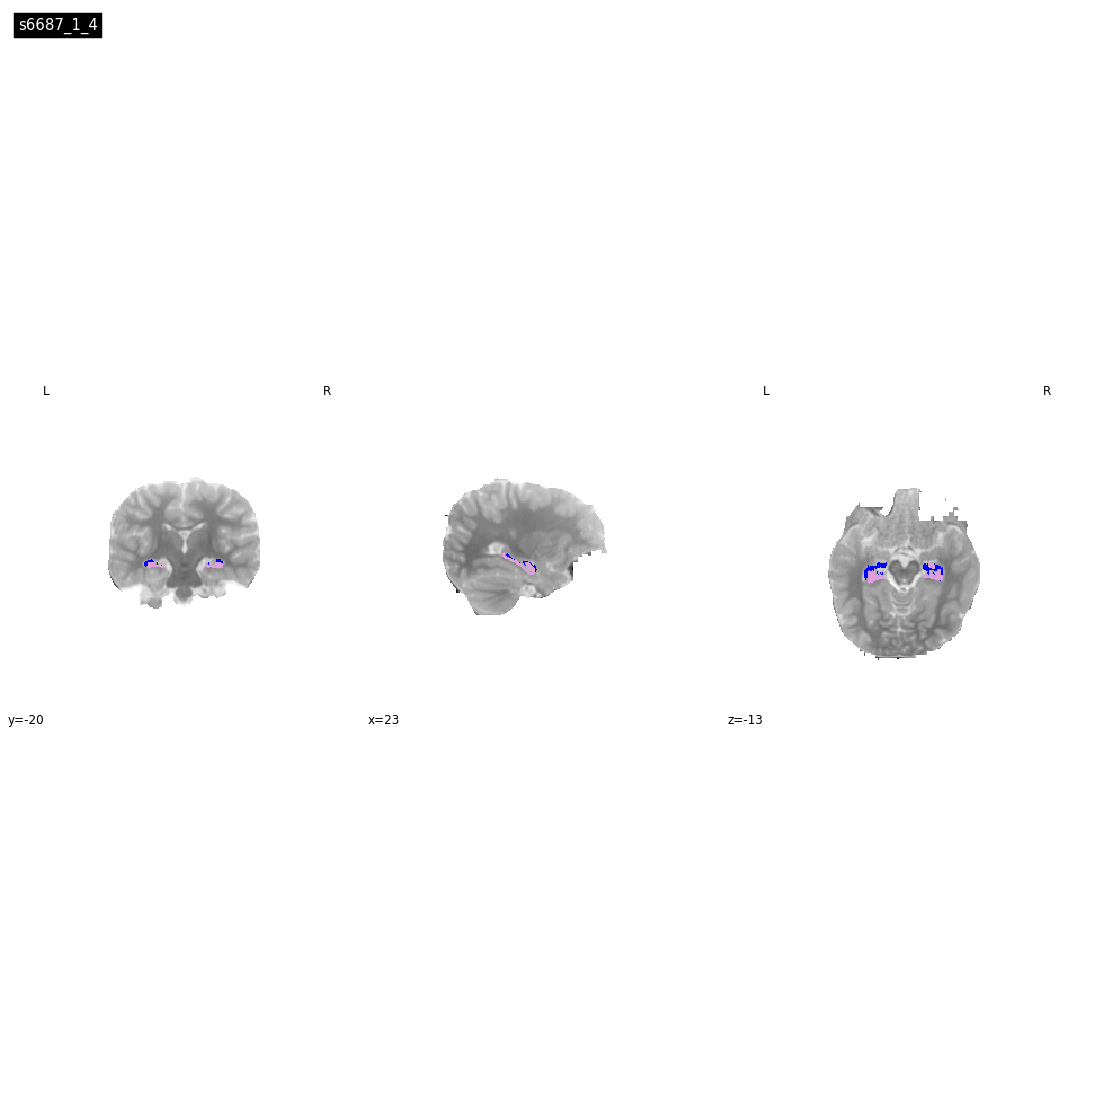

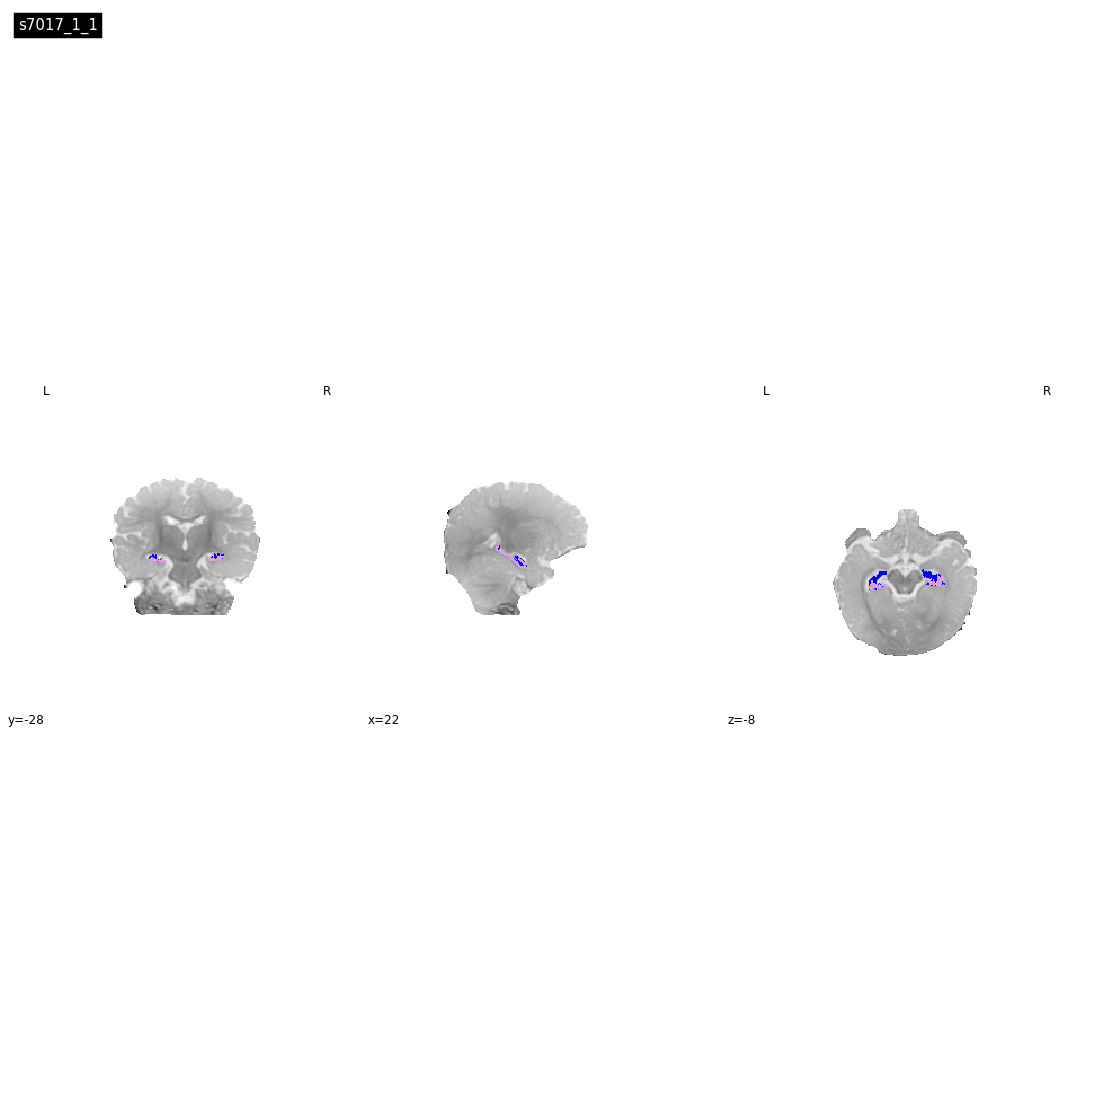

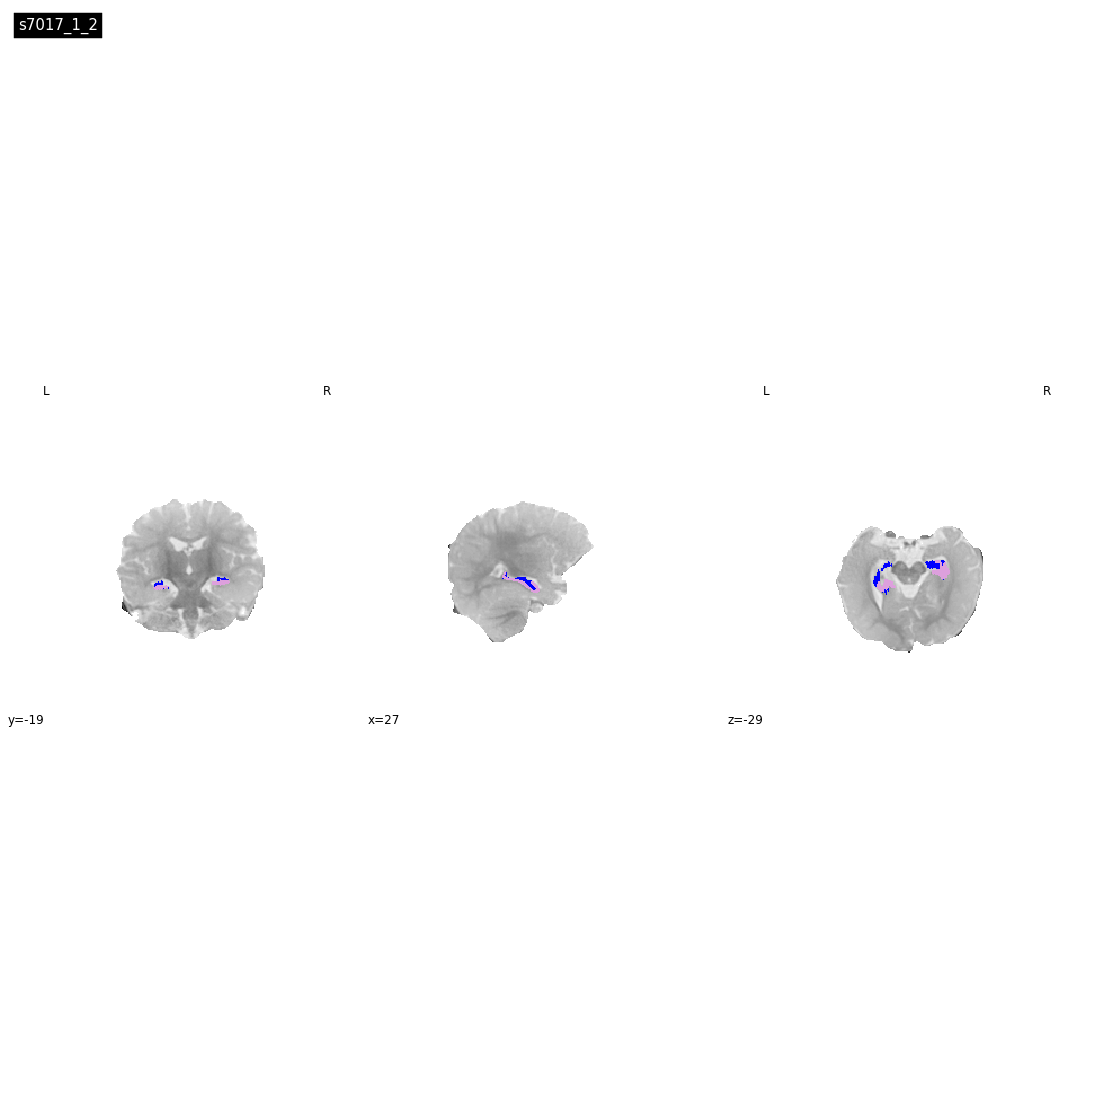

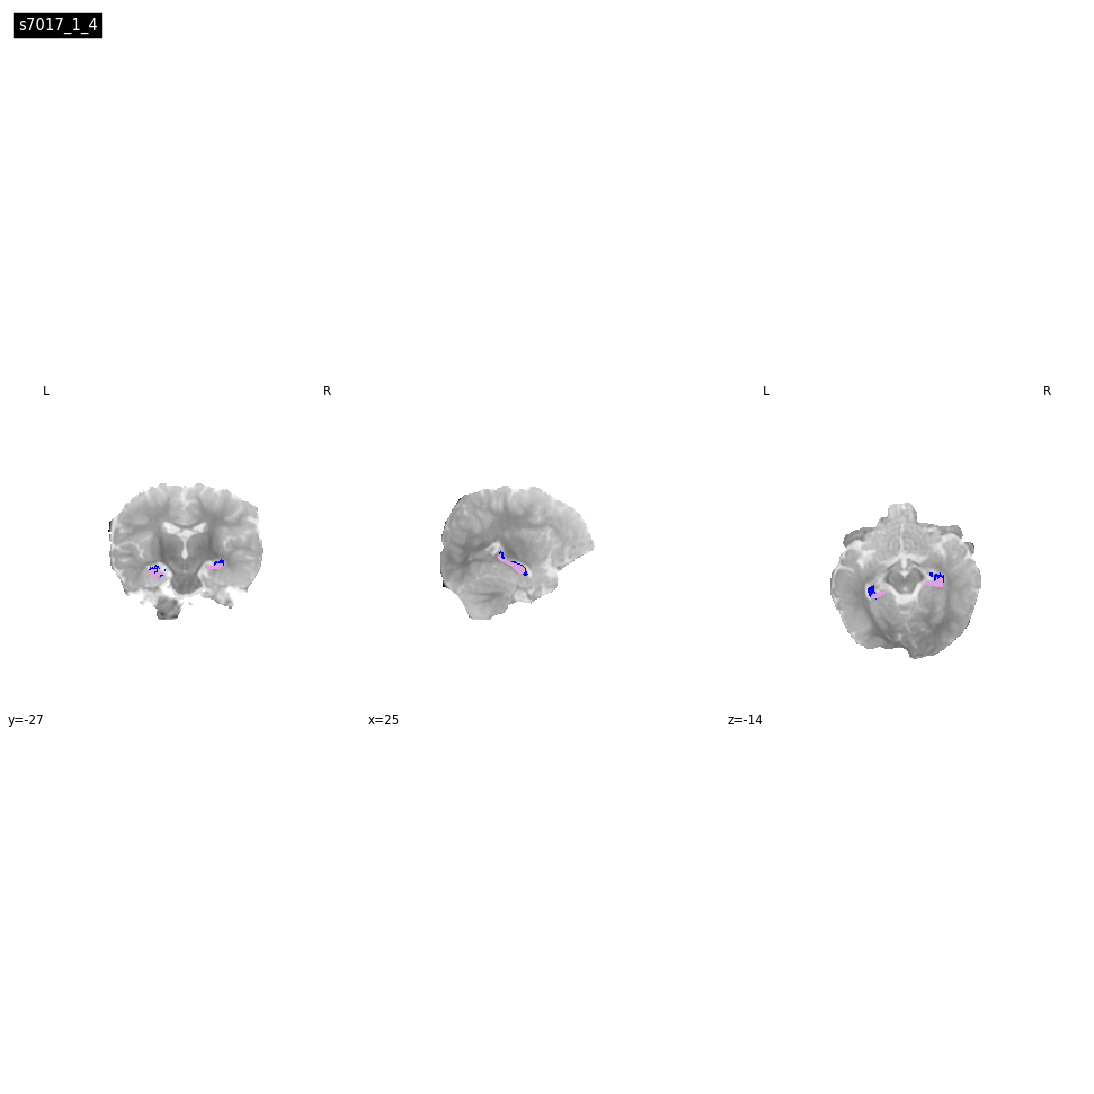

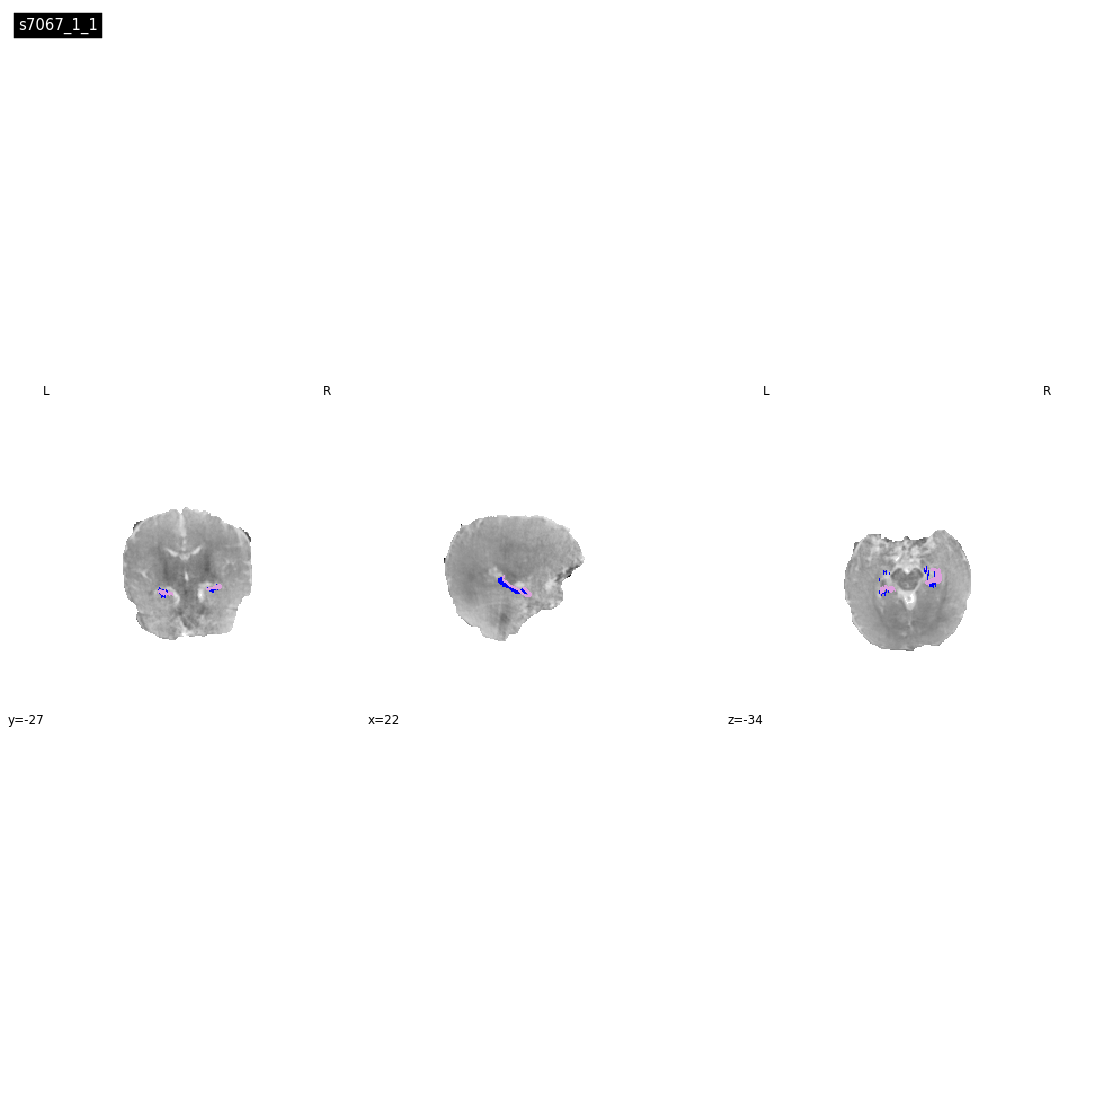

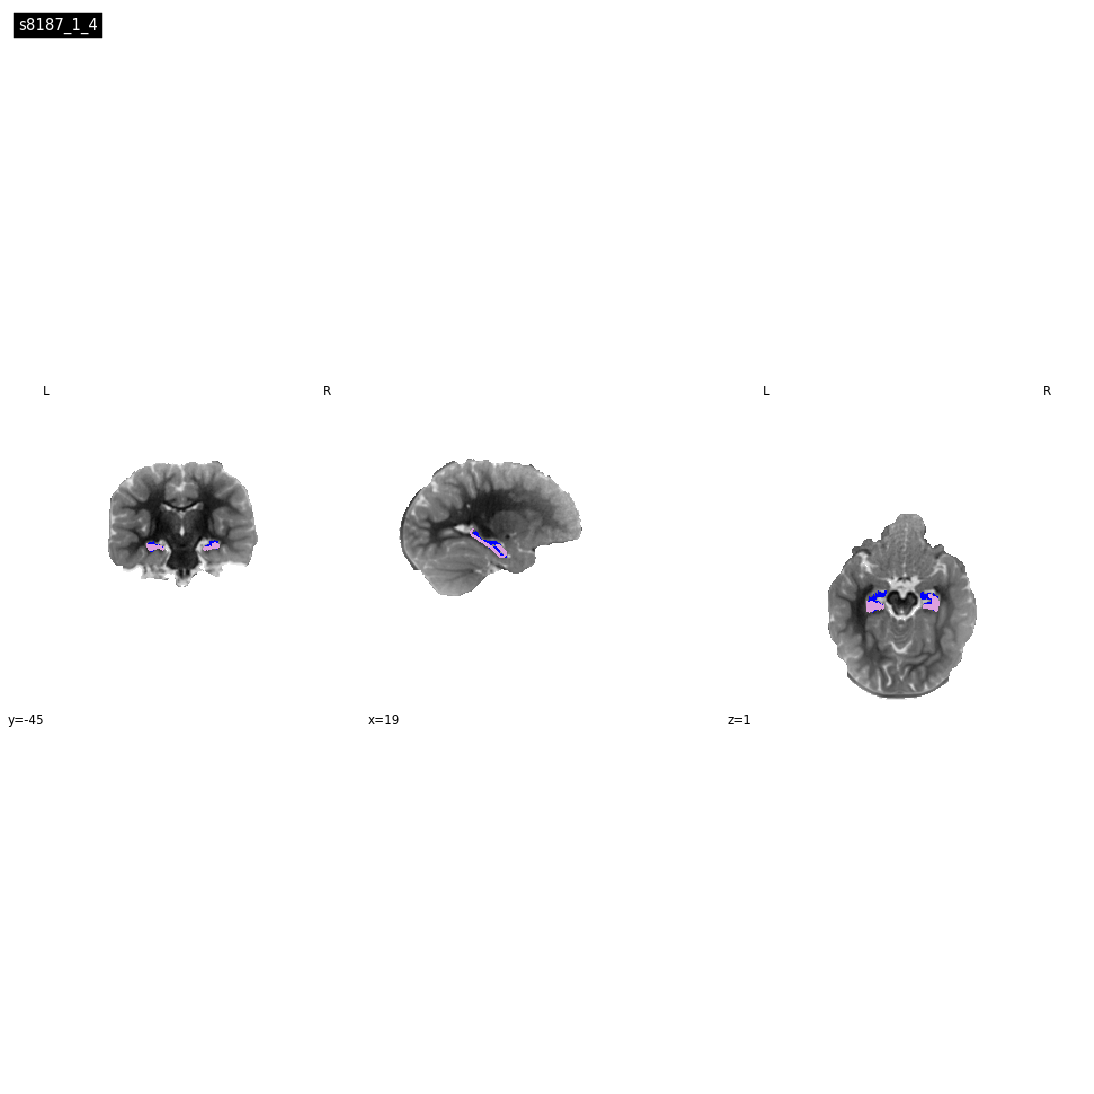

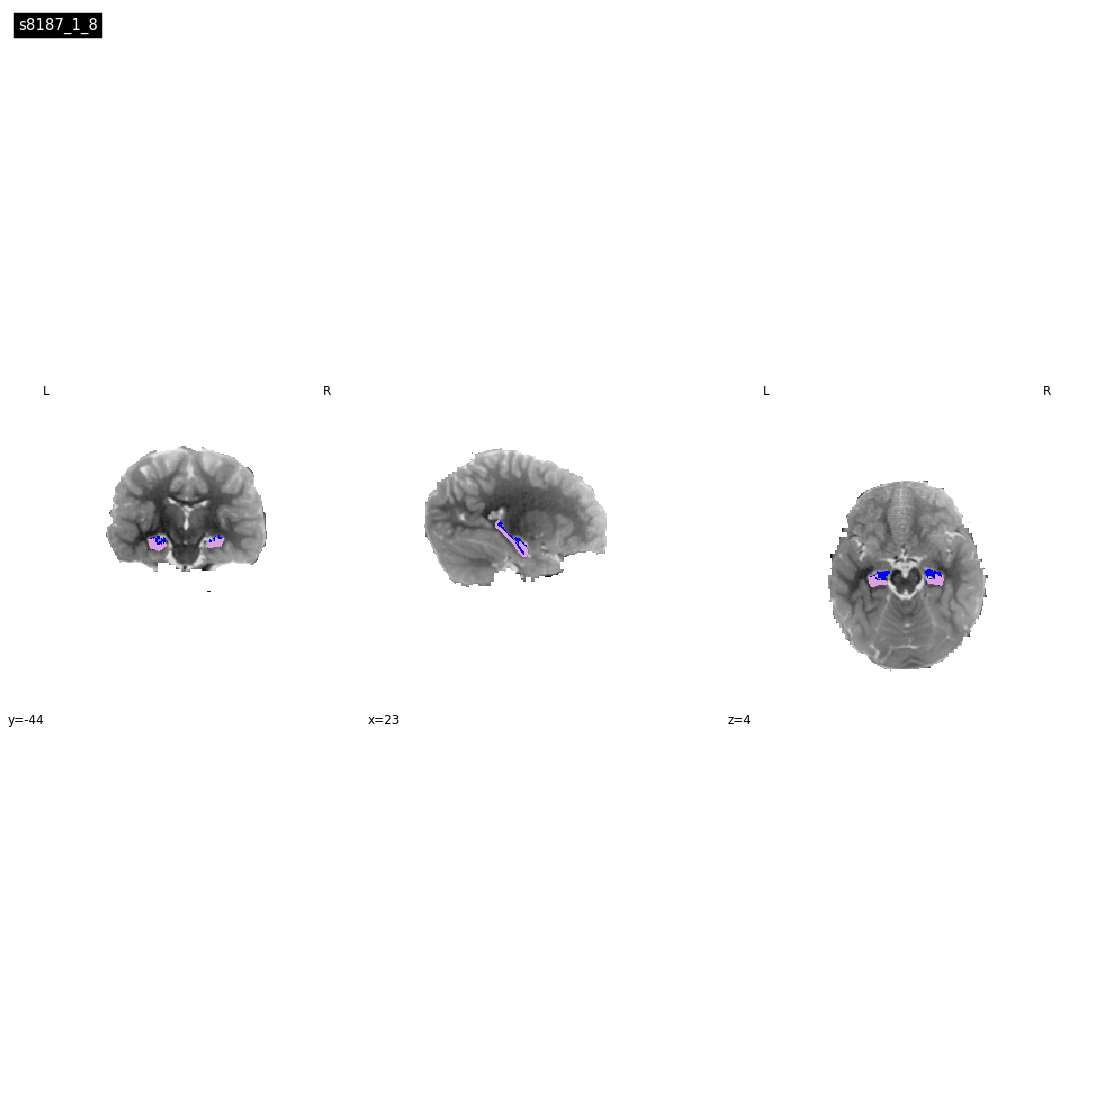

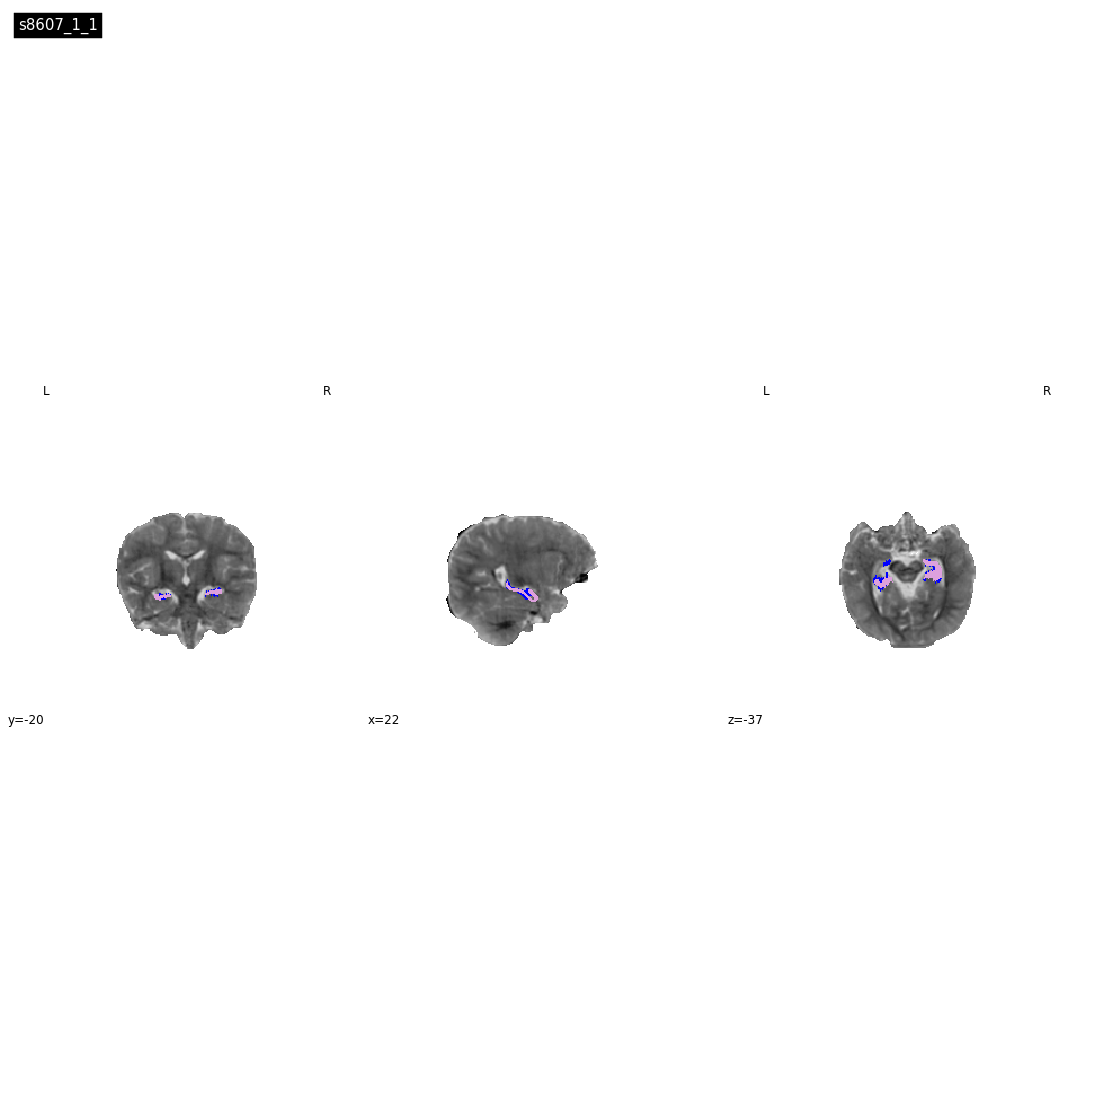

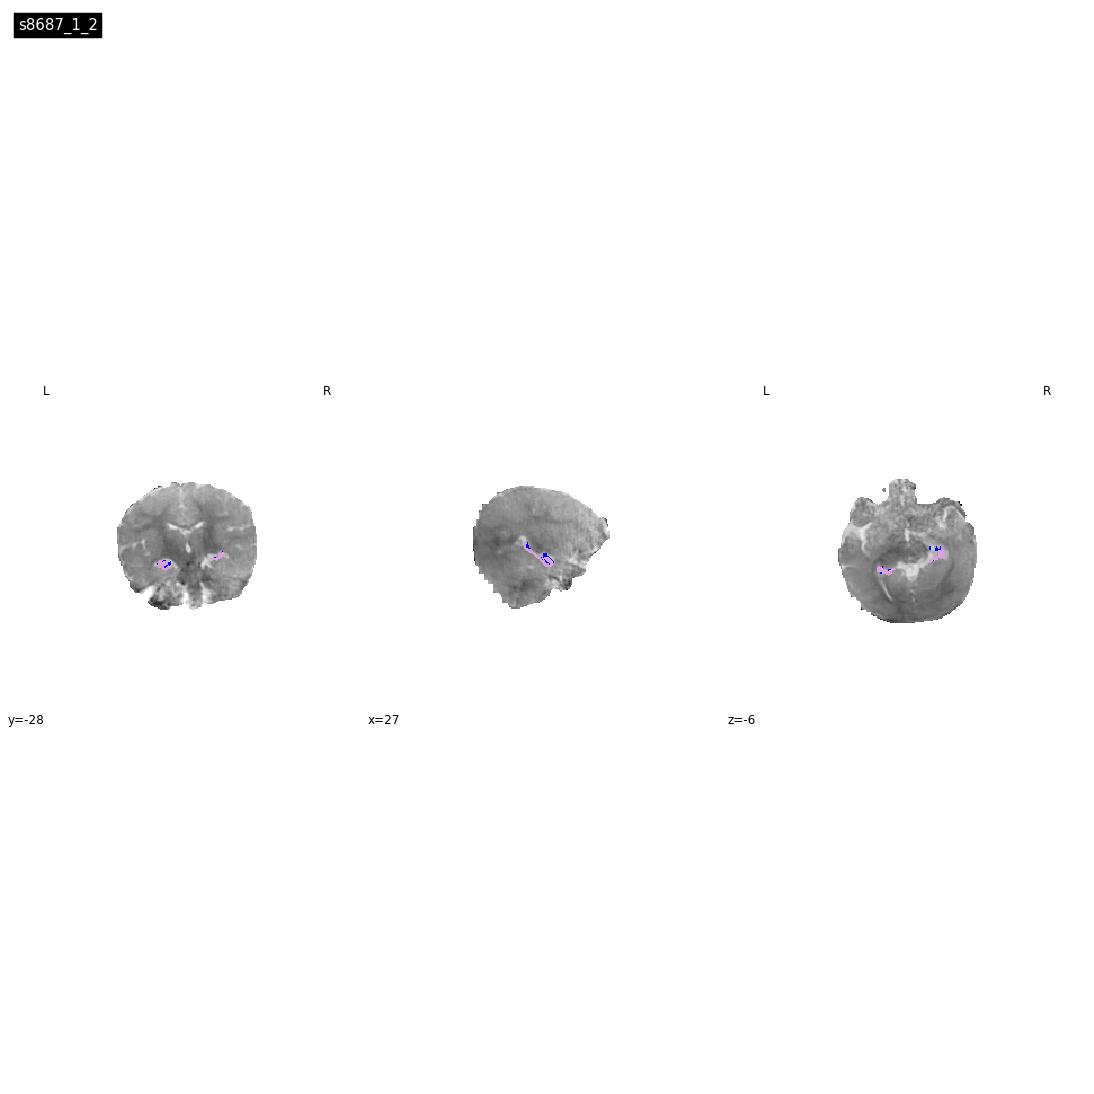

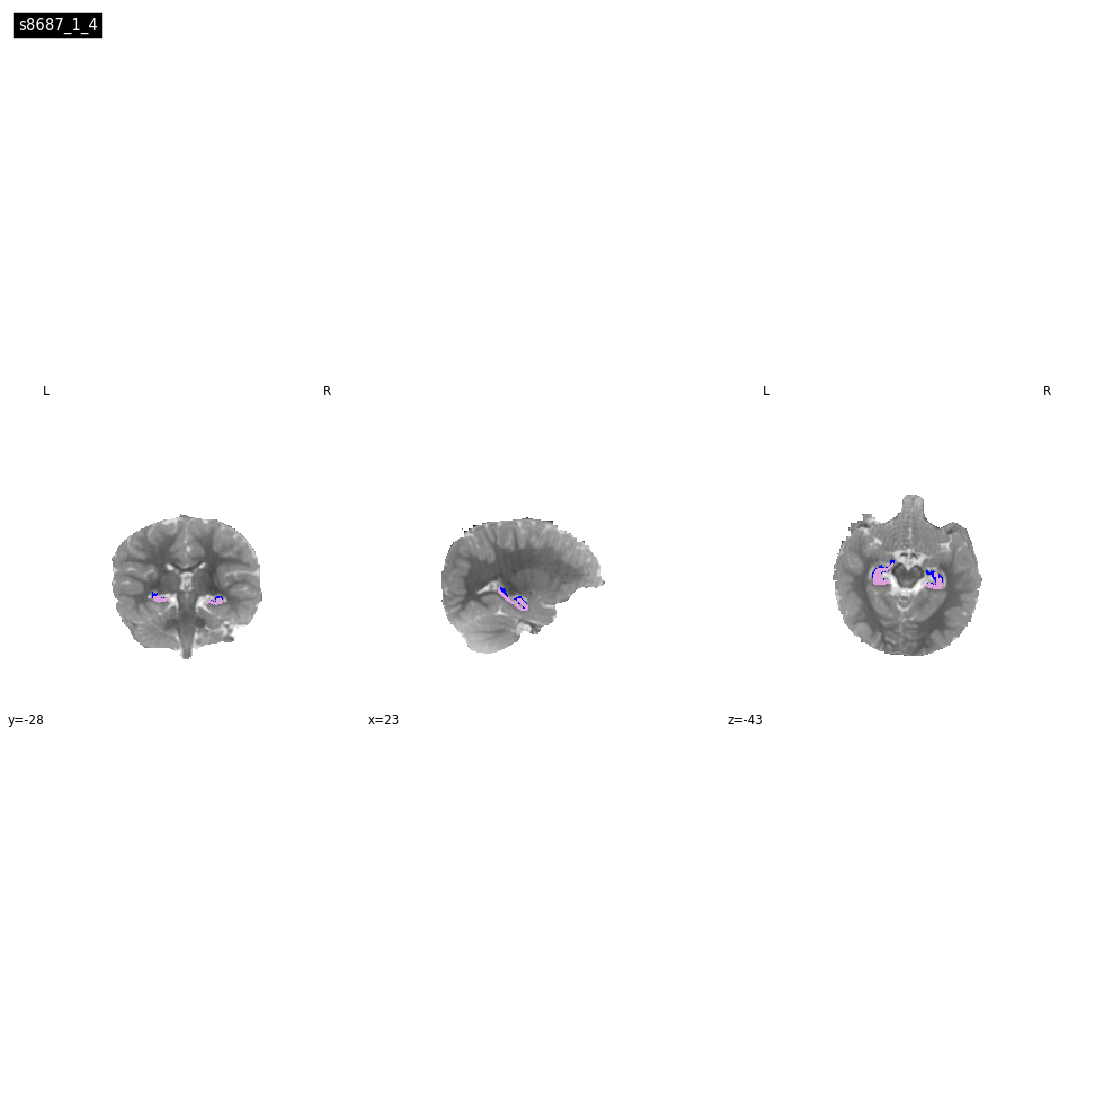

In [38]:
# Plot the data    
for ppt in ppt_names:
    
    plot_manual_ROI(ppt)

### Hippocampal Inter-Rater Reliability   <a class="anchor" id="section_2_1"></a>
In order to determine what the HPC IRR was, Dice values between the 42 corresponding participants that CE and JF segmented were calculated.

In [6]:
# Measure the IRR of the hippocampal data between the two raters
inter_rater_reliability_HPC = dice_compare(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF, 'Inter_Rater_Reliability', 'IRR')


IRR HPC Dice=0.57 (SD=0.07, range=0.43-0.70)


### Repeat Analysis <a class="anchor" id="section_2_2"></a>
12 participants were scanned multiple times, which gives us the ability to compare segmentations from the same participant aligned linearly to standard space, as well as a crossed verison of this analysis. 

In [7]:
# Calculate Dice averages of a rater's segmentations from the same repeat participant seessions and a crossed version
CE_linear_lower_bound_HPC, JF_linear_lower_bound_HPC = repeat_test(ordered_files_segmentations_linear_CE, ordered_files_segmentations_linear_JF, out_dir_segmentations_linear, 'Linear')

# Calculate Dice averages of a rater's segmentations from the now nonlinearly aligned repeat participant seessions and a crossed version
CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC = repeat_test(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF, out_dir_segmentations_nonlinear, 'Nonlinear')


Linear CE Repeat HPC Dice: 0.45 (SD=0.13, range=0.13-0.70)
Linear JF Repeat HPC Dice: 0.39 (SD=0.14, range=0.10-0.68)

Linear CE Control HPC Dice: 0.39 (SD=0.11, range=0.16-0.62)
Linear JF Control HPC Dice: 0.32 (SD=0.10, range=0.07-0.56)

Linear Cross-Sample HPC Dice: 0.38 (SD=0.13, range=0.05-0.62)

Nonlinear CE Repeat HPC Dice: 0.60 (SD=0.08, range=0.45-0.76)
Nonlinear JF Repeat HPC Dice: 0.60 (SD=0.07, range=0.43-0.72)

Nonlinear CE Control HPC Dice: 0.51 (SD=0.07, range=0.28-0.63)
Nonlinear JF Control HPC Dice: 0.47 (SD=0.07, range=0.28-0.60)

Nonlinear Cross-Sample HPC Dice: 0.51 (SD=0.08, range=0.32-0.63)



### Average Template Hippocampal Analyses   <a class="anchor" id="section_2_3"></a>

We next analyzed how well average infant anatomical templates, constructed via linearly and nonlinearly aligning infant data to standard space, along with an adult anatomical template in predicting the manual hippocampal data of the two raters.


In [15]:
# Load in the adult data
adult_vol_average = nib.load(out_dir + '/HarvardOxford-sub-prob-1mm.nii.gz').get_data()

# Generate the proportions for the left and right HPC
adult_vol_LHPC = adult_vol_average[:, :, :, 8,]/100
adult_vol_RHPC = adult_vol_average[:, :, :, 18,]/100

# Select only the rHPC voxels that have a greater than .5 proportion
adult_vol_RHPC = adult_vol_RHPC > .5

# Multiply the binarized voxels by the rHPC value used by the raters (6)
adult_vol_RHPC_average = [i * 6 for i in adult_vol_RHPC]

# Select only the lHPC voxels that have a greater than .5 proportion
adult_vol_LHPC = adult_vol_LHPC > .5

# Multiply the binarized voxels by the rHPC value used by the raters (5)
adult_vol_LHPC_average = [i * 5 for i in adult_vol_LHPC]

# Combine the left and right HPC to contruct a total adult average HPC template
adult_average_HPC = np.add(adult_vol_LHPC_average, adult_vol_RHPC_average)

print('Average adult template created!')


Average adult template created!


Linear Average Infant Approximating CE HPC: Dice=0.34 (SD=0.09, range=0.15-0.49)
Linear Average Infant vs JF Approximating CE HPC: M=-0.23, CI=[-0.263, -0.194], p=0.000, 1 scan improvement from IRR

Linear Average Infant Approximating JF HPC: Dice=0.29 (SD=0.08, range=0.03-0.42)
Linear Average Infant vs CE Approximating JF HPC: M=-0.29, CI=[-0.315, -0.256], p=0.000, 0 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

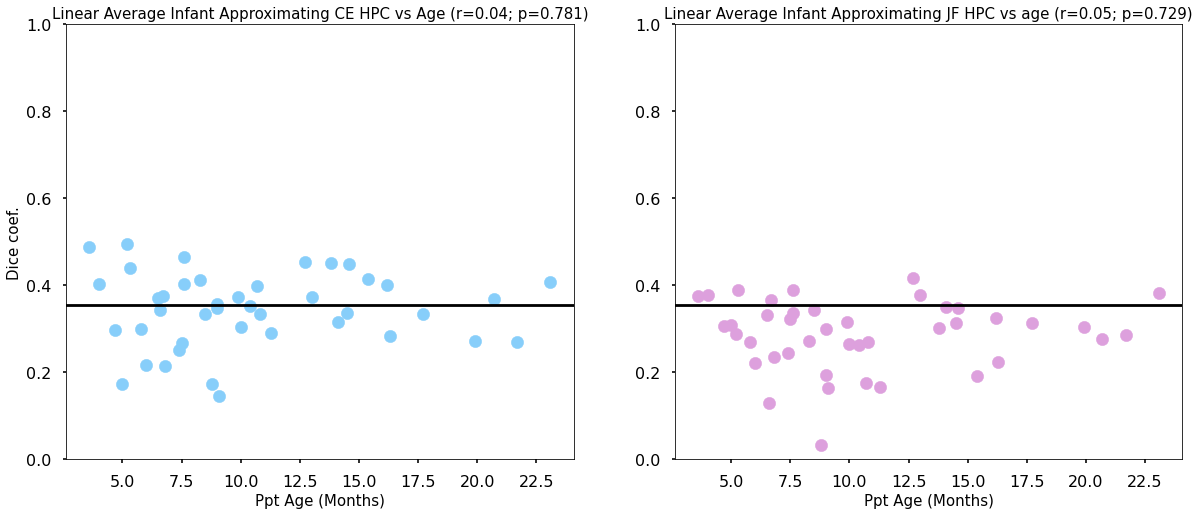

Average Adult Approximating Linearly Aligned CE HPC: Dice=0.45 (SD=0.12, range=0.16-0.66)
Average Adult vs JF Approximating Linearly Aligned CE HPC: M=-0.12, CI=[-0.168, -0.079], p=0.000, 11 scan improvement from IRR

Average Adult Approximating Linearly Aligned JF HPC: Dice=0.42 (SD=0.09, range=0.19-0.59)
Average Adult vs CE Approximating Linearly Aligned JF HPC: M=-0.15, CI=[-0.184, -0.115], p=0.000, 4 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

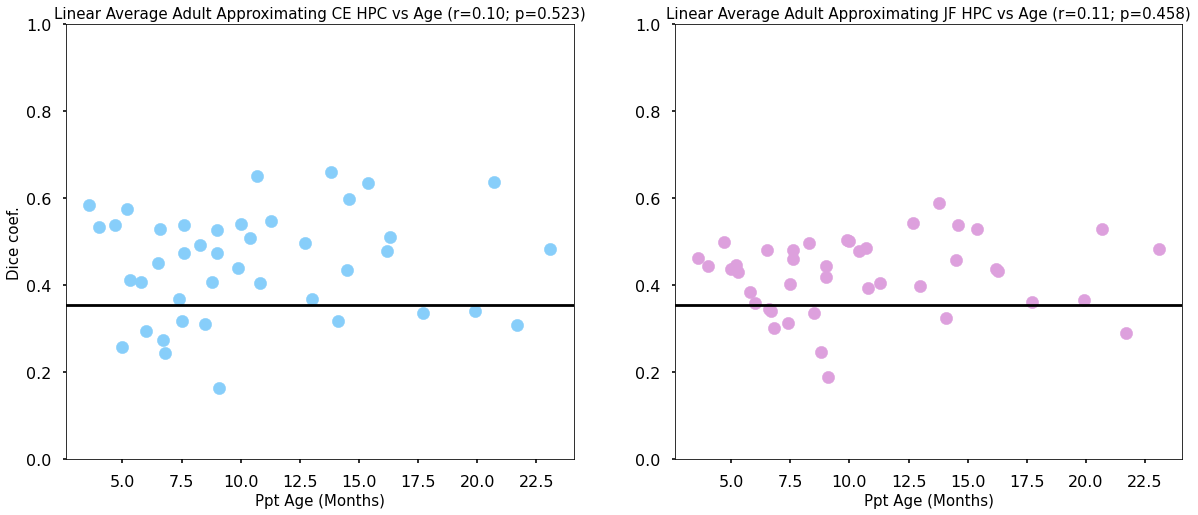

Nonlinear Average Infant Approximating CE HPC: Dice=0.55 (SD=0.07, range=0.36-0.67)
Nonlinear Average Infant vs JF Approximating CE HPC: M=-0.02, CI=[-0.048, 0.001], p=0.064, 12 scan improvement from IRR

Nonlinear Average Infant Approximating JF HPC: Dice=0.51 (SD=0.07, range=0.35-0.63)
Nonlinear Average Infant vs CE Approximating JF HPC: M=-0.06, CI=[-0.087, -0.043], p=0.000, 7 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

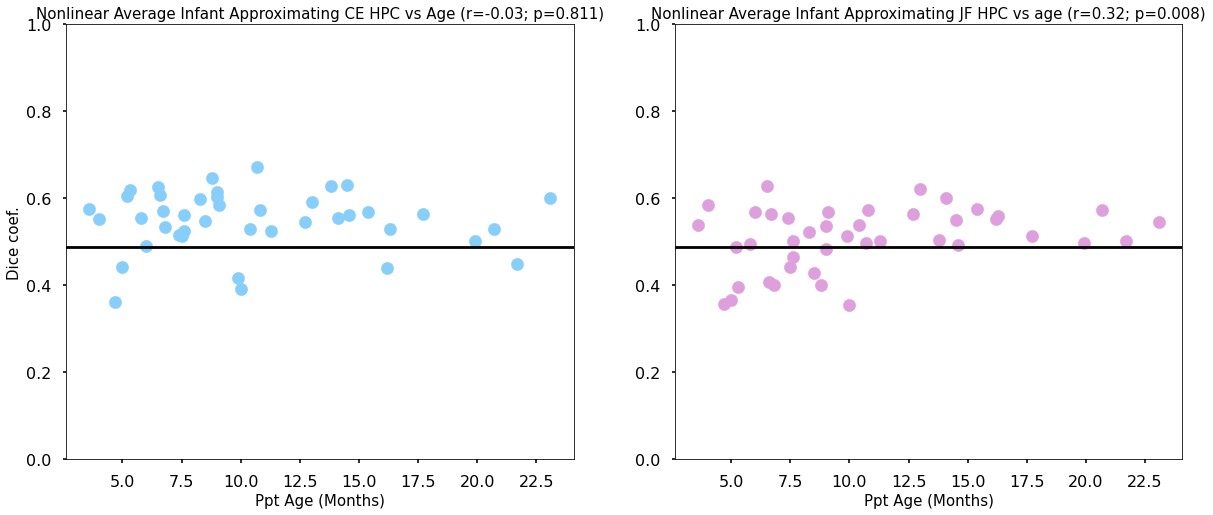

Average Adult Approximating Nonlinearly Aligned CE HPC: Dice=0.42 (SD=0.09, range=0.26-0.58)
Average Adult vs JF Approximating Nonlinearly Aligned CE HPC: M=-0.15, CI=[-0.179, -0.115], p=0.000, 5 scan improvement from IRR

Average Adult Approximating Nonlinearly Aligned JF HPC: Dice=0.47 (SD=0.07, range=0.30-0.60)
Average Adult vs CE Approximating Nonlinearly Aligned JF HPC: M=-0.10, CI=[-0.130, -0.074], p=0.000, 7 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

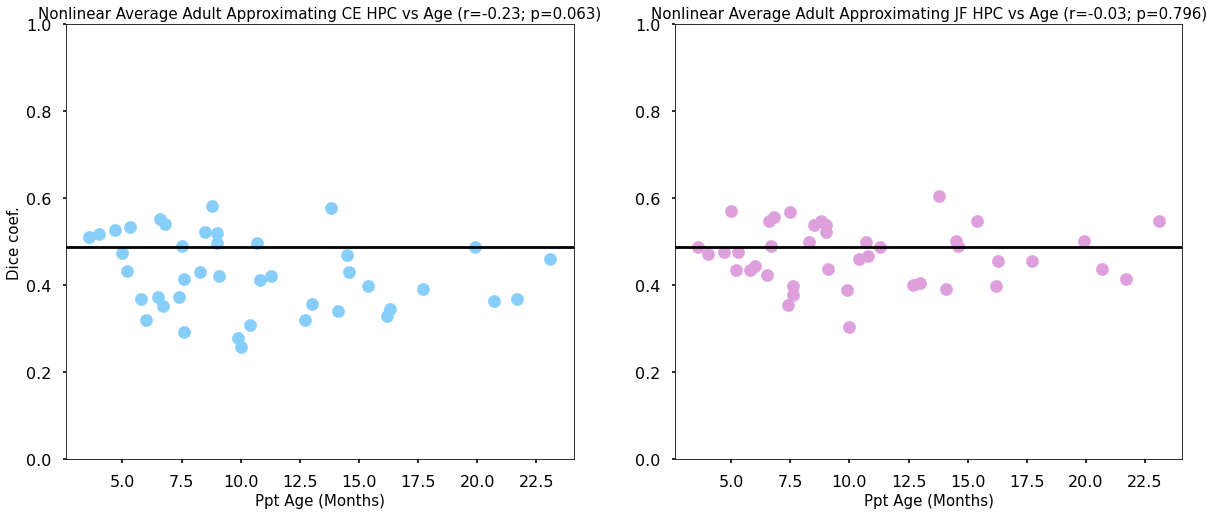

Nonlinear Infant vs Linear Infant Approximating CE HPC: M=0.20, CI=[0.178, 0.232], p=0.000, 42 scan improvement from nonlinear alignment

Nonlinear Infant vs Linear Infant Approximating JF HPC: M=0.22, CI=[0.192, 0.249], p=0.000, 42 scan improvement from nonlinear alignment

Nonlinear Adult vs Linear Adult Approximating CE HPC: M=-0.02, CI=[-0.067, 0.019], p=0.277, 18 scan improvement from nonlinear alignment

Nonlinear Adult vs Linear Adult Approximating JF HPC: M=0.05, CI=[0.015, 0.079], p=0.003, 30 scan improvement from nonlinear alignment



Brain Region                                 Linear Infant Dice  \
0       CE HPC  Dice=0.34 (IMP from IRR = 1, p=0.000, C.I.=-0....   
1       JF HPC  Dice=0.29 (IMP from IRR = 0, p=0.000, C.I.=-0....   

  Linear Infant Corr                                  Linear Adult Dice  \
0    r=0.04, p=0.781  Dice=0.45 (IMP from IRR = 11, p=0.000, C.I.=-0...   
1    r=0.05, p=0.729  Dice=0.42 (IMP from IRR = 4, p=0.000, C.I.=-0....   

  Linear Adult Corr Brain Region  \
0   r=0.10, p=0.523       CE HPC   
1   r=0.11, p=0.458       JF HPC   

                               Nonlinear Infant Dice Nonlinear Infant Corr  \
0  Dice=0.55 (IMP from IRR = 12, p=0.064, C.I.=-0...      r=-0.03, p=0.811   
1  Dice=0.51 (IMP from IRR = 7, p=0.000, C.I.=-0....       r=0.32, p=0.008   

                                Nonlinear Adult Dice Nonlinear Adult Corr  
0  Dice=0.42 (IMP from IRR = 5, p=0.000, C.I.=-0....     r=-0.23, p=0.063  
1  Dice=0.47 (IMP from IRR = 7, p=0.000, C.I.=-0....     r=-0.03, p=0.796

In [8]:
# Asses how well both a linearly constructed average infant HPC template and an average adult HPC template approximates Manual in linear standard space
Linear_Average_Table, linear_infant_average_approx_linear_CE_HPC, linear_infant_average_approx_linear_JF_HPC, adult_average_approx_linear_CE_HPC, adult_average_approx_linear_JF_HPC = average_test(ordered_files_segmentations_linear_CE, ordered_files_segmentations_linear_JF, 'linear', 'Linear') 

# Asses how well a nonlinearly constructed average infant HPC template approximates Manual in nonlinear standard space
Nonlinear_Average_Table, nonlinear_infant_average_approx_nonlinear_CE_HPC, nonlinear_infant_average_approx_nonlinear_JF_HPC , adult_average_approx_nonlinear_CE_HPC, adult_average_approx_nonlinear_JF_HPC = average_test(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF, 'nonlinear','Nonlinear') 

# Compare CE's nonlinear vs linear infant
p_val, sign_count, CIs = randomise_diff(nonlinear_infant_average_approx_nonlinear_CE_HPC - linear_infant_average_approx_linear_CE_HPC)
print('Nonlinear Infant vs Linear Infant Approximating CE HPC: M=%0.2f'% np.mean(nonlinear_infant_average_approx_nonlinear_CE_HPC - linear_infant_average_approx_linear_CE_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()
 
# Compare JF's nonlinear vs linear infant
p_val, sign_count, CIs = randomise_diff(nonlinear_infant_average_approx_nonlinear_JF_HPC - linear_infant_average_approx_linear_JF_HPC)
print('Nonlinear Infant vs Linear Infant Approximating JF HPC: M=%0.2f'% np.mean(nonlinear_infant_average_approx_nonlinear_JF_HPC - linear_infant_average_approx_linear_JF_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()

# Compare CE's nonlinear vs linear adult
p_val, sign_count, CIs = randomise_diff(adult_average_approx_nonlinear_CE_HPC - adult_average_approx_linear_CE_HPC)
print('Nonlinear Adult vs Linear Adult Approximating CE HPC: M=%0.2f'% np.mean(adult_average_approx_nonlinear_CE_HPC - adult_average_approx_linear_CE_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()
 
# Compare JF's nonlinear vs linear adult
p_val, sign_count, CIs = randomise_diff(adult_average_approx_nonlinear_JF_HPC - adult_average_approx_linear_JF_HPC)
print('Nonlinear Adult vs Linear Adult Approximating JF HPC: M=%0.2f'% np.mean(adult_average_approx_nonlinear_JF_HPC - adult_average_approx_linear_JF_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()

# Combine the linear and nonlinear DataFrames together
pd.concat([Linear_Average_Table.reset_index(drop=1), Nonlinear_Average_Table.reset_index(drop=1)], axis=1).fillna('')


#### Bar Plot: Linear average templates  predicting manual hippocampal data

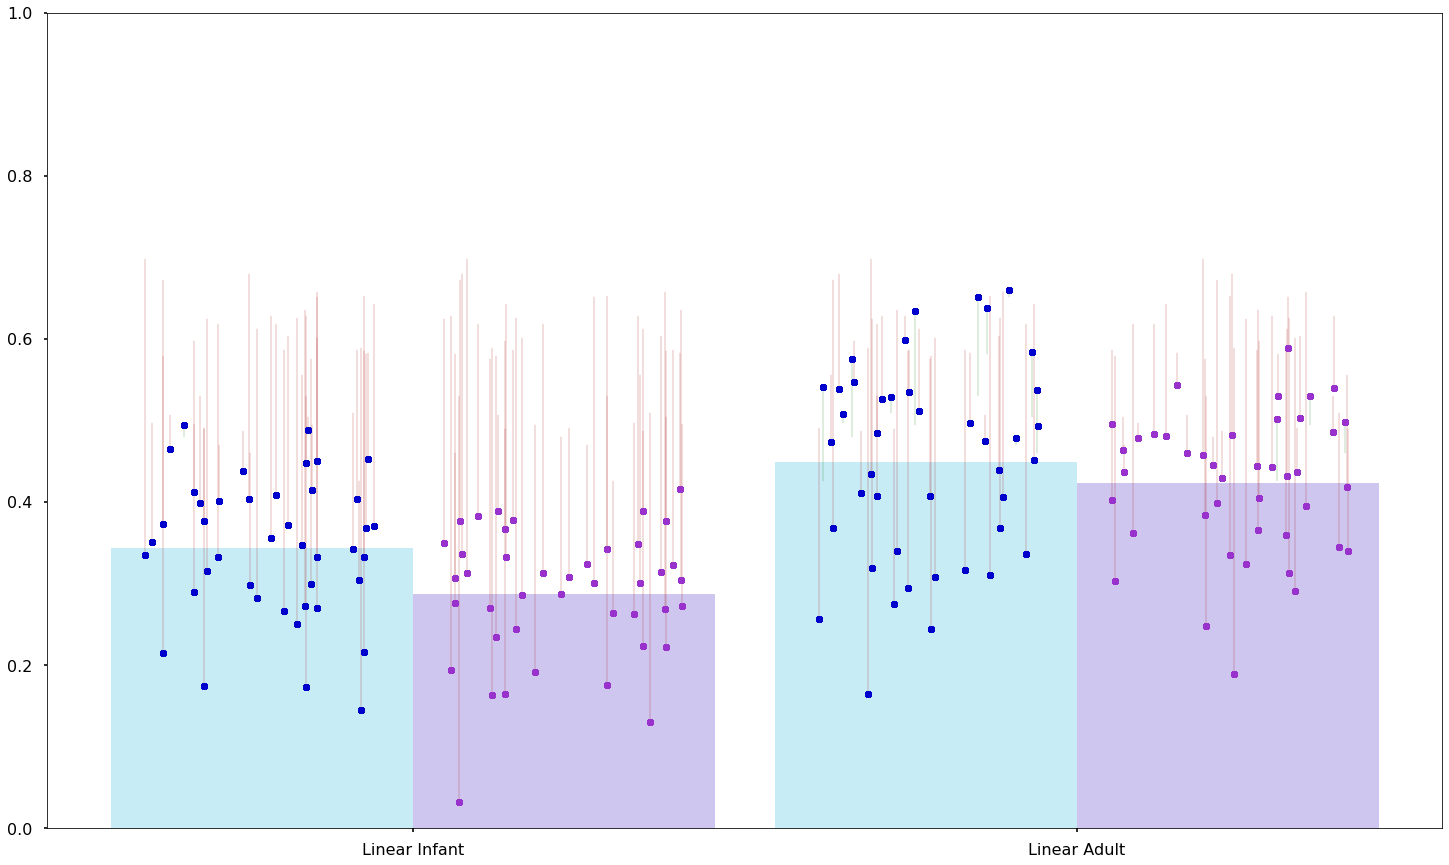

In [8]:
# Contruct a bar graph for this average template analysis
plt.figure(figsize=(25,15))
plt.ylim([0.0, 1.0])
plt.xticks([])

# Put the average tempaltes for both tracers into lists 
CE_templates = [linear_infant_average_approx_linear_CE_HPC, adult_average_approx_linear_CE_HPC]
JF_templates = [linear_infant_average_approx_linear_JF_HPC, adult_average_approx_linear_JF_HPC]

# Set the x-value for the bar 
CE_ticker = 0.5
JF_ticker = 1.5

# Set the x_range for the individual points
CE_point_range = [0.1,0.9]
JF_point_range = [1.1, 1.9]

# Loop through correpsonding template data from both tracers
for CE_template, JF_template in zip(CE_templates, JF_templates):
    
    # Plot CE's data
    jitter_bar(CE_template, inter_rater_reliability_HPC, 'CE', 42, x_range = CE_point_range)
    plt.bar(CE_ticker, np.mean(CE_template), width=1, color=[0.780, 0.924, 0.960])
    
    # Increase the ticker and x_range values for the next loop
    CE_ticker = CE_ticker + 2.2
    CE_point_range = np.add(CE_point_range, [2.2, 2.2])
    
    # Plot JF's data
    jitter_bar(JF_template, inter_rater_reliability_HPC, 'JF', 42, x_range = JF_point_range)
    plt.bar(JF_ticker, np.mean(JF_template), width=1, color=[0.808, 0.776, 0.936])

    # Increase the ticker and x_range values for the next loop
    JF_ticker = JF_ticker + 2.2
    JF_point_range = np.add(JF_point_range, [2.2, 2.2])

plt.xticks([1, 3.2], ['Linear Infant', 'Linear Adult'])

plt.savefig(out_dir_plots + 'Average_linear_templates_approx_linear_HPC_bar_graph.svg')


### FreeSurfer Hippocampal Analyses <a class="anchor" id="section_2_4"></a>

Segmented infant hippocampal data (no MTL cortex available) were extracted using an adult FreeSurfer reconstruction pipeline (Iglesias et al., 2015). In some sessions, FreeSurfer failed to identify the hippocampus. In such cases, FreeSurfer was ap-plied to other versions of the same scan (e.g., with skull stripping). With this procedure, FreeSurfer succeeded on 40 of 42 scans. The two scans that FreeSurfer was unable to segment were excluded from the calculation of the FreeSurfer IRR metric. 

FreeSurfer Approximating CE HPC Dice=0.55 (SD=0.13, range=0.03-0.71)
FreeSurfer vs JF Approximating CE HPC: M=-0.02, CI=[-0.060, 0.013], p=0.283, 20 scan improvement from IRR

FreeSurfer Approximating JF HPC Dice=0.54 (SD=0.12, range=0.03-0.67)
FreeSurfer vs CE Approximating JF HPC: M=-0.04, CI=[-0.075, -0.007], p=0.013, 17 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

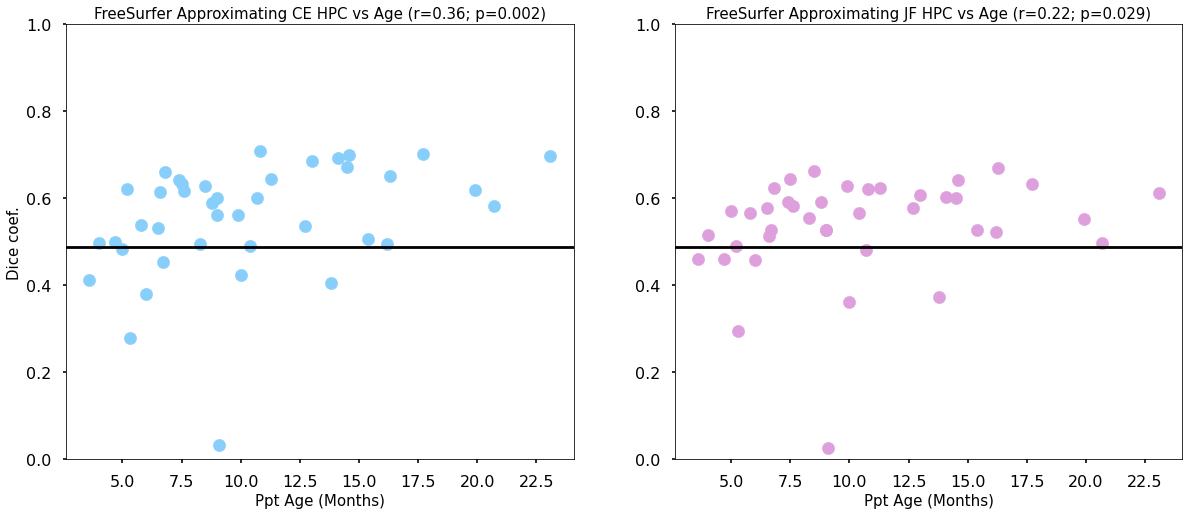

In [9]:
# Generate the appropriate FreeSurfer segmentation and IRR files
ordered_40_files_segmentations_anatomical_CE, ordered_40_files_segmentations_anatomical_JF, ordered_40_ppt_ages, freesurfer_inter_rater_reliability_HPC = FreeSurfer_file_generator(ordered_files_segmentations_anatomical_CE, ordered_files_segmentations_anatomical_JF, ordered_ppt_ages, inter_rater_reliability_HPC)

# Measure Dice values between FreeSurfer and CE
freesurfer_approx_CE_HPC = dice_compare(ordered_files_segmentations_freesurfer, ordered_40_files_segmentations_anatomical_CE, 'FreeSurfer_approximating_CE', 'FreeSurfer Approximating CE')

# Compare FreeSurfer's performance of approximating CE with IRR
p_val, sign_count, CIs = randomise_diff(freesurfer_approx_CE_HPC - freesurfer_inter_rater_reliability_HPC)
print('FreeSurfer vs JF Approximating CE HPC: M=%0.2f'% np.mean(freesurfer_approx_CE_HPC - freesurfer_inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between FreeSurfer and JF
freesurfer_approx_JF_HPC = dice_compare(ordered_files_segmentations_freesurfer, ordered_40_files_segmentations_anatomical_JF, 'FreeSurfer_approximating_JF', 'FreeSurfer Approximating JF')

# Compare FreeSurfer's performance of approximating JF with IRR
p_val, sign_count, CIs = randomise_diff(freesurfer_approx_JF_HPC - freesurfer_inter_rater_reliability_HPC)
print('FreeSurfer vs CE Approximating JF HPC: M=%0.2f'% np.mean(freesurfer_approx_JF_HPC - freesurfer_inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Plot and save the FreeSurfer data
sub_plot(ordered_40_ppt_ages, freesurfer_approx_CE_HPC, freesurfer_approx_JF_HPC, 'FreeSurfer Approximating CE HPC vs Age', 'FreeSurfer Approximating JF HPC vs Age', CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC)

plt.savefig(out_dir_plots + 'FreeSurfer_approx_HPC_scatter_plot.svg')
    
plt.show()


### Adult-Pretrained-ASHS Hippocampal Analyses  <a class="anchor" id="section_2_5"></a>
An adult-pretrained-ASHS model was used to give a baseline measurement for how well an ASHS algorithm that had not received any infant hippocampal training data would segment infant T1-weighted scans.

Adult-Pretrained-ASHS Approximating CE HPC Dice=0.68 (SD=0.08, range=0.51-0.78)
Adult-Pretrained-ASHS vs JF Approximating CE HPC: M=0.10, CI=[0.086, 0.123], p=0.000, 40 scan improvement from IRR

Adult-Pretrained-ASHS Approximating JF HPC Dice=0.61 (SD=0.05, range=0.48-0.71)
Adult-Pretrained-ASHS vs CE Approximating JF HPC: M=0.04, CI=[0.030, 0.052], p=0.000, 35 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

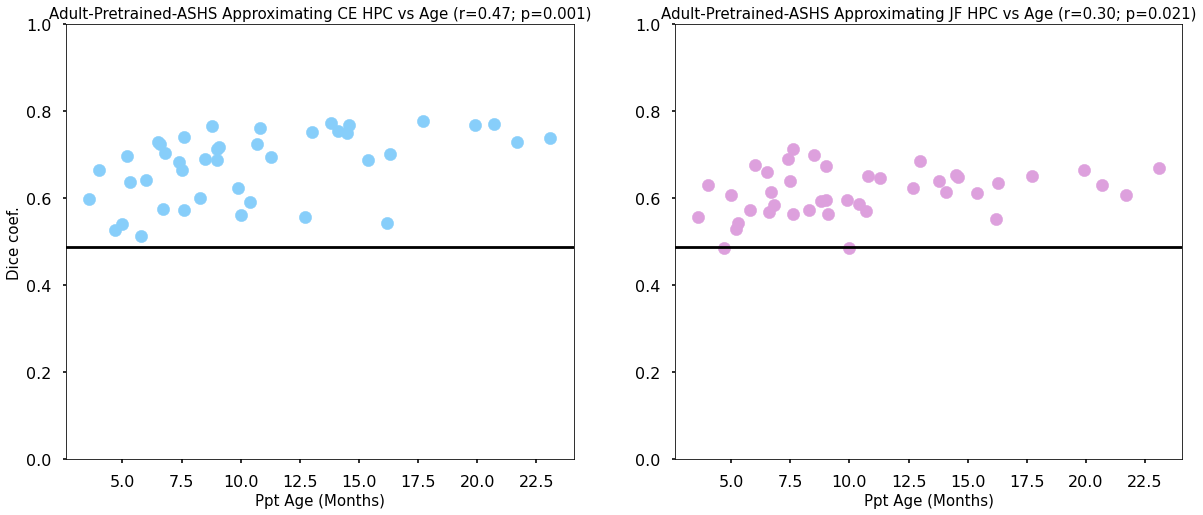

In [10]:
# Measure Dice values between Adult-Pretrained-ASHS and CE
adult_pretrained_ASHS_approx_CE_HPC = dice_compare_ASHS(ordered_files_segmentations_adult_pretrained_ASHS_right, ordered_files_segmentations_adult_pretrained_ASHS_left, ordered_files_segmentations_anatomical_CE, 'Adult_pretrained_ASHS_approximating_CE', 'Adult-Pretrained-ASHS Approximating CE', pretrained = True)

# Assess how well Adult-Pretrained-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(adult_pretrained_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
print('Adult-Pretrained-ASHS vs JF Approximating CE HPC: M=%0.2f'% np.mean(adult_pretrained_ASHS_approx_CE_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between Adult-Pretrained-ASHS and JF
adult_pretrained_ASHS_approx_JF_HPC = dice_compare_ASHS(ordered_files_segmentations_adult_pretrained_ASHS_right, ordered_files_segmentations_adult_pretrained_ASHS_left, ordered_files_segmentations_anatomical_JF, 'Adult_pretrained_ASHS_approximating_JF', 'Adult-Pretrained-ASHS Approximating JF', pretrained = True)

# Assess how well Adult-Pretrained-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(adult_pretrained_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
print('Adult-Pretrained-ASHS vs CE Approximating JF HPC: M=%0.2f'% np.mean(adult_pretrained_ASHS_approx_JF_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Plot and save the correlation data
sub_plot(ordered_ppt_ages, adult_pretrained_ASHS_approx_CE_HPC, adult_pretrained_ASHS_approx_JF_HPC, 'Adult-Pretrained-ASHS Approximating CE HPC vs Age', 'Adult-Pretrained-ASHS Approximating JF HPC vs Age', CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC)

# Plot and save the data
plt.savefig(out_dir_plots + 'Adult_pretrained_ASHS_approx_HPC_scatter_plot.svg')
    
plt.show()

### CE-ASHS Hippocampal Analyses  <a class="anchor" id="section_2_6"></a>
Analyses assessing an ASHS model trained on CE's infant hippocampal data (CE-ASHS)

CE-ASHS Approximating CE HPC Dice=0.73 (SD=0.06, range=0.59-0.82)
CE-ASHS vs JF Approximating CE HPC: M=0.15, CI=[0.137, 0.171], p=0.000, 42 scan improvement from IRR

CE-ASHS Approximating JF HPC Dice=0.58 (SD=0.05, range=0.46-0.65)
CE-ASHS vs CE Approximating JF HPC:  M=0.00, CI=[-0.009, 0.018], p=0.578, 20 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

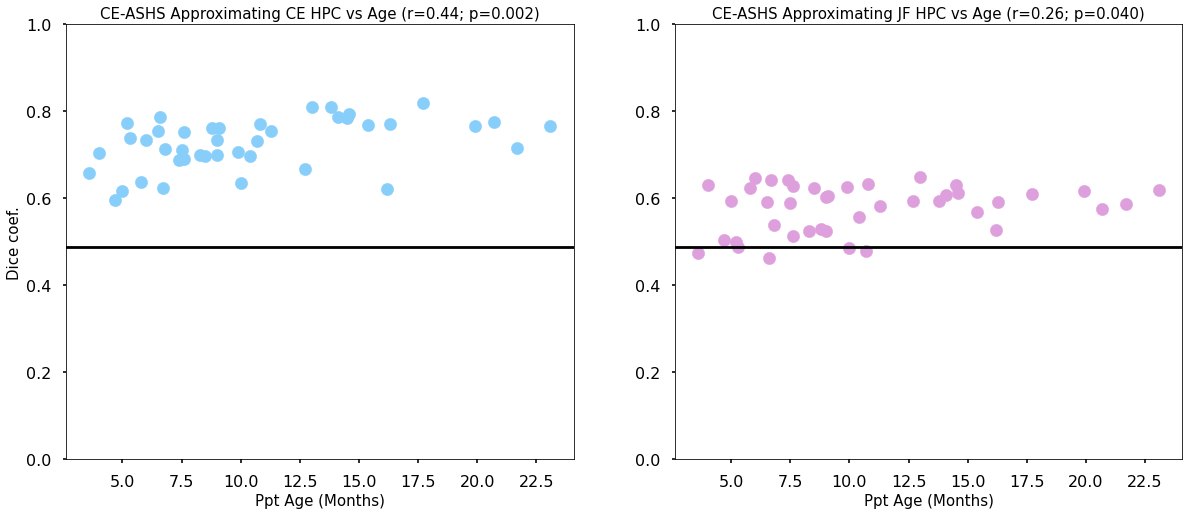

In [11]:
# Measure Dice values between CE-ASHS and CE
CE_ASHS_approx_CE_HPC = dice_compare_ASHS(ordered_files_segmentations_CE_ASHS_right, ordered_files_segmentations_CE_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'CE_ASHS_approximating_CE', 'CE-ASHS Approximating CE', trained = True)

# Assess how well CE-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(CE_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
print('CE-ASHS vs JF Approximating CE HPC: M=%0.2f'% np.mean(CE_ASHS_approx_CE_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between CE-ASHS and JF
CE_ASHS_approx_JF_HPC = dice_compare_ASHS(ordered_files_segmentations_CE_ASHS_right, ordered_files_segmentations_CE_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'CE_ASHS_approximating_JF', 'CE-ASHS Approximating JF', trained = True)

# Assess how well CE-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(CE_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
print('CE-ASHS vs CE Approximating JF HPC:  M=%0.2f'% np.mean(CE_ASHS_approx_JF_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Plot and save the correlation data
sub_plot(ordered_ppt_ages, CE_ASHS_approx_CE_HPC, CE_ASHS_approx_JF_HPC, 'CE-ASHS Approximating CE HPC vs Age', 'CE-ASHS Approximating JF HPC vs Age', CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC)

plt.savefig(out_dir_plots + 'CE_ASHS_approx_HPC_scatter_plot.svg')
    
plt.show()

### JF-ASHS Hippocampal Analyses  <a class="anchor" id="section_2_7"></a>
Analyses assessing an ASHS model trained on JF's infant hippocampal data (JF-ASHS)

JF-ASHS Approximating CE HPC Dice=0.59 (SD=0.07, range=0.43-0.70)
JF-ASHS vs JF Approximating CE HPC:  M=0.01, CI=[-0.002, 0.029], p=0.094, 27 scan improvement from IRR

JF-ASHS Approximating JF HPC Dice=0.72 (SD=0.06, range=0.58-0.80)
JF-ASHS vs CE Approximating JF HPC:  M=0.14, CI=[0.129, 0.158], p=0.000, 42 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

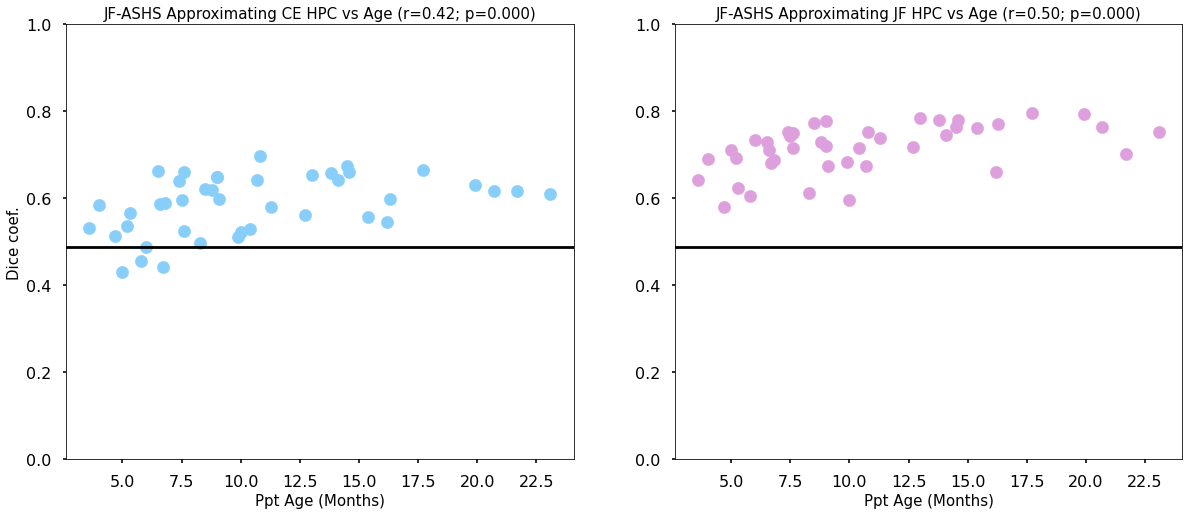

In [12]:
# Measure Dice values between JF-ASHS and CE
JF_ASHS_approx_CE_HPC = dice_compare_ASHS(ordered_files_segmentations_JF_ASHS_right, ordered_files_segmentations_JF_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'JF_ASHS_approximating_CE', 'JF-ASHS Approximating CE', trained = True)

# Assess how well JF-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(JF_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
print('JF-ASHS vs JF Approximating CE HPC:  M=%0.2f'% np.mean(JF_ASHS_approx_CE_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between JF-ASHS and JF
JF_ASHS_approx_JF_HPC = dice_compare_ASHS(ordered_files_segmentations_JF_ASHS_right, ordered_files_segmentations_JF_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'JF_ASHS_approximating_JF', 'JF-ASHS Approximating JF', trained = True)

# Assess how well JF-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(JF_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
print('JF-ASHS vs CE Approximating JF HPC:  M=%0.2f'% np.mean(JF_ASHS_approx_JF_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Plot and save the correlation data
sub_plot(ordered_ppt_ages, JF_ASHS_approx_CE_HPC, JF_ASHS_approx_JF_HPC, 'JF-ASHS Approximating CE HPC vs Age', 'JF-ASHS Approximating JF HPC vs Age', CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC)

plt.savefig(out_dir_plots + 'JF_ASHS_approx_HPC_scatter_plot.svg')
    
plt.show()

### Infant-Trained-ASHS Hippocampal Analyses  <a class="anchor" id="section_2_8"></a>
Analyses assessing an ASHS model trained on both CE and JF's infant hippocampal data (infant-trained-ASHS)

Infant-Trained-ASHS Approximating CE HPC Dice=0.67 (SD=0.06, range=0.54-0.78)
Infant-Trained-ASHS vs JF Approximating CE HPC:  M=0.10, CI=[0.086, 0.118], p=0.000, 42 scan improvement from IRR

Infant-Trained-ASHS Approximating JF HPC Dice=0.67 (SD=0.06, range=0.52-0.76)
Infant-Trained-ASHS vs CE Approximating JF HPC:  M=0.10, CI=[0.089, 0.113], p=0.000, 42 scan improvement from IRR

Infant-Trained-ASHS vs CE-ASHS Approximating CE HPC:  M=-0.05, CI=[-0.062, -0.041], p=0.000, 1 scan improvement from CE-ASHS

Infant-Trained-ASHS vs CE-ASHS Approximating JF HPC:  M=0.10, CI=[0.087, 0.107], p=0.000, 42 scan improvement from CE-ASHS

Infant-Trained-ASHS vs JF-ASHS Approximating JF HPC:  M=-0.04, CI=[-0.052, -0.034], p=0.000, 2 scan improvement from JF-ASHS

Infant-Trained-ASHS vs JF-ASHS Approximating CE HPC:  M=0.09, CI=[0.080, 0.097], p=0.000, 42 scan improvement from JF-ASHS



<Figure size 432x288 with 0 Axes>

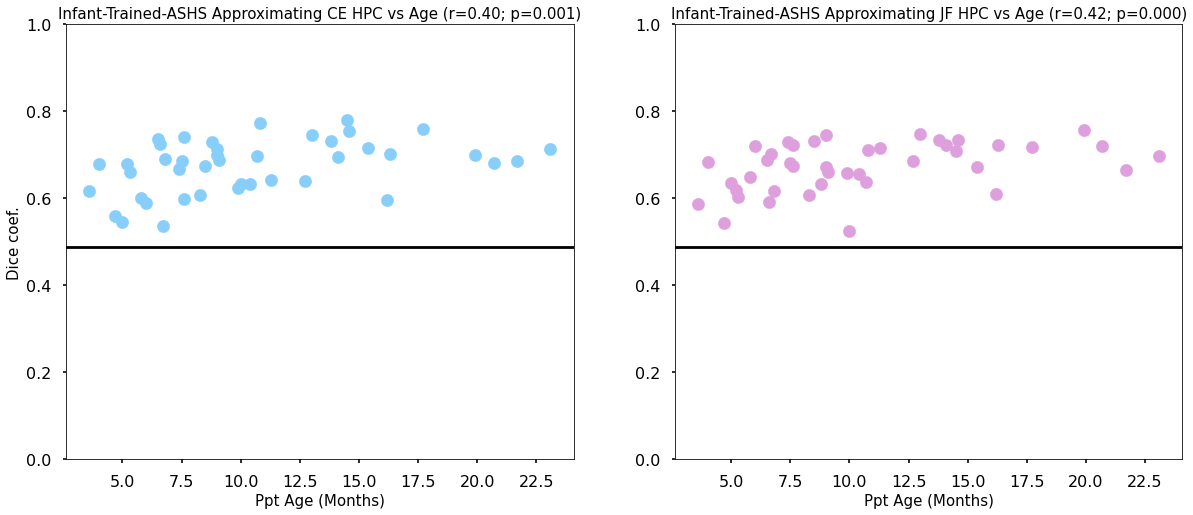

In [13]:
# Measure Dice values between infant-trained-ASHS and CE
infant_trained_ASHS_approx_CE_HPC = dice_compare_ASHS(ordered_files_segmentations_infant_trained_ASHS_right, ordered_files_segmentations_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'Infant_trained_ASHS_approximating_CE', 'Infant-Trained-ASHS Approximating CE', trained = True)

# Assess how well infant-trained-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
print('Infant-Trained-ASHS vs JF Approximating CE HPC:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between infant-trained-ASHS and JF
infant_trained_ASHS_approx_JF_HPC = dice_compare_ASHS(ordered_files_segmentations_infant_trained_ASHS_right, ordered_files_segmentations_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'Infant_trained_ASHS_approximating_JF', 'Infant-Trained-ASHS Approximating JF', trained = True)

# Assess how well infant-trained-ASHS approximated the HPC IRR of this study
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
print('Infant-Trained-ASHS vs CE Approximating JF HPC:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_HPC  - inter_rater_reliability_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating CE with CE-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_CE_HPC - CE_ASHS_approx_CE_HPC)
print('Infant-Trained-ASHS vs CE-ASHS Approximating CE HPC:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_HPC - CE_ASHS_approx_CE_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from CE-ASHS'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating JF with CE-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_JF_HPC - CE_ASHS_approx_JF_HPC)
print('Infant-Trained-ASHS vs CE-ASHS Approximating JF HPC:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_HPC - CE_ASHS_approx_JF_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from CE-ASHS'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating JF with JF-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_JF_HPC - JF_ASHS_approx_JF_HPC)
print('Infant-Trained-ASHS vs JF-ASHS Approximating JF HPC:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_HPC - JF_ASHS_approx_JF_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from JF-ASHS'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating CE with JF-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_CE_HPC - JF_ASHS_approx_CE_HPC)
print('Infant-Trained-ASHS vs JF-ASHS Approximating CE HPC:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_HPC - JF_ASHS_approx_CE_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from JF-ASHS'), print()

# Plot and save the correlation data
sub_plot(ordered_ppt_ages, infant_trained_ASHS_approx_CE_HPC, infant_trained_ASHS_approx_JF_HPC, 'Infant-Trained-ASHS Approximating CE HPC vs Age', 'Infant-Trained-ASHS Approximating JF HPC vs Age', CE_nonlinear_lower_bound_HPC, JF_nonlinear_lower_bound_HPC)

plt.savefig(out_dir_plots + 'Infant_trained_ASHS_approx_HPC_scatter_plot.svg')
    
plt.show()

#### DataTable: ASHS 
Hippocampal Dice averages and age correlations from: Adult-Pretrained-ASHS predicting CE and JF; CE-ASHS pre-dicting CE and JF; JF-ASHS predicting CE and JF; and Infant-Trained-ASHS predicting CE and JF.

In [14]:
# Construct a DataFrame table containing the ASHS hippocampal data
regions =["CE HPC", "JF HPC"]

# Adult-Pretrained-ASHS data
p_val_CE, sign_count_CE, CIs_CE = randomise_diff(adult_pretrained_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
p_val_JF, sign_count_JF, CIs_JF = randomise_diff(adult_pretrained_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
adult_pretrained_ASHS = ['Dice=%0.2f'% np.mean(adult_pretrained_ASHS_approx_CE_HPC) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', CI=[%0.3f'%CIs_CE[0] + ', %0.3f]'%CIs_CE[1], 'Dice=%0.2f'% np.mean(adult_pretrained_ASHS_approx_JF_HPC) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', CI=[%0.3f'%CIs_JF[0] + ', %0.3f])'%CIs_JF[1]]

adult_pretrained_ASHS_corr = ['r=%0.2f'% np.corrcoef(adult_pretrained_ASHS_approx_CE_HPC, ordered_ppt_ages)[0,1] + '; p=%0.3f'% randomise_corr(adult_pretrained_ASHS_approx_CE_HPC, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(adult_pretrained_ASHS_approx_JF_HPC, ordered_ppt_ages)[0,1] +', p=%0.3f'% randomise_corr(adult_pretrained_ASHS_approx_JF_HPC, ordered_ppt_ages)]

# CE-ASHS data
p_val_CE, sign_count_CE, CIs_CE = randomise_diff(CE_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
p_val_JF, sign_count_JF, CIs_JF = randomise_diff(CE_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
CE_ASHS = ['Dice=%0.2f'% np.mean(CE_ASHS_approx_CE_HPC) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', CI=[%0.3f'%CIs_CE[0] + ', %0.3f'%CIs_CE[1], 'Dice=%0.2f'% np.mean(CE_ASHS_approx_JF_HPC) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', CI=[%0.3f'%CIs_JF[0] + ', %0.3f]'%CIs_JF[1]]

CE_ASHS_corr = ['r=%0.2f'% np.corrcoef(CE_ASHS_approx_CE_HPC, ordered_ppt_ages)[0,1] + '; p=%0.3f'% randomise_corr(CE_ASHS_approx_CE_HPC, ordered_ppt_ages),'r=%0.2f'% np.corrcoef(CE_ASHS_approx_JF_HPC, ordered_ppt_ages)[0,1] +'; p=%0.3f'% randomise_corr(CE_ASHS_approx_JF_HPC, ordered_ppt_ages)]

# JF-ASHS data
p_val_CE, sign_count_CE, CIs_CE = randomise_diff(JF_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
p_val_JF, sign_count_JF, CIs_JF = randomise_diff(JF_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
JF_ASHS = ['Dice=%0.2f'% np.mean(JF_ASHS_approx_CE_HPC) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', CI=[%0.3f'%CIs_CE[0] + ', %0.3f]'%CIs_CE[1], 'Dice=%0.2f'% np.mean(JF_ASHS_approx_JF_HPC) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', CI=[%0.3f'%CIs_JF[0] + ', %0.3f]'%CIs_JF[1]]

JF_ASHS_corr = ['r=%0.2f'% np.corrcoef(JF_ASHS_approx_CE_HPC, ordered_ppt_ages)[0,1] + '; p=%0.3f'% randomise_corr(JF_ASHS_approx_CE_HPC, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(JF_ASHS_approx_JF_HPC, ordered_ppt_ages)[0,1] +'; p=%0.3f'% randomise_corr(JF_ASHS_approx_JF_HPC, ordered_ppt_ages)]

# Infant-Trained-ASHS data
p_val_CE, sign_count_CE, CIs_CE = randomise_diff(infant_trained_ASHS_approx_CE_HPC - inter_rater_reliability_HPC)
p_val_JF, sign_count_JF, CIs_JF = randomise_diff(infant_trained_ASHS_approx_JF_HPC - inter_rater_reliability_HPC)
infant_trained_ASHS = ['Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_HPC) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', CI=[%0.3f'%CIs_CE[0] + ', %0.3f]'%CIs_CE[1], 'Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_HPC) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', CI=[%0.3f'%CIs_JF[0] + ', %0.3f])'%CIs_JF[1]]

infant_trained_ASHS_corr = ['r=%0.2f'% np.corrcoef(infant_trained_ASHS_approx_CE_HPC, ordered_ppt_ages)[0,1] + '; p=%0.3f'% randomise_corr(infant_trained_ASHS_approx_CE_HPC, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(infant_trained_ASHS_approx_JF_HPC, ordered_ppt_ages)[0,1] +', p=%0.3f'% randomise_corr(infant_trained_ASHS_approx_JF_HPC, ordered_ppt_ages)]

col_names = ['Brain Region', 'Adult-Pretrained-ASHS', 'Adult-Pretrained-ASHS Corr', 'CE-ASHS', 'CE-ASHS Corr', 'JF-ASHS', 'JF-ASHS Corr', 'Infant-Trained-ASHS', 'Infant-Trained-ASHS Corr']

Dice_Matrix_Table = pd.DataFrame(columns=col_names)

Dice_Matrix_Table['Brain Region'] = regions

Dice_Matrix_Table['Adult-Pretrained-ASHS'] = adult_pretrained_ASHS
Dice_Matrix_Table['Adult-Pretrained-ASHS Corr'] = adult_pretrained_ASHS_corr

Dice_Matrix_Table['CE-ASHS'] = CE_ASHS
Dice_Matrix_Table['CE-ASHS Corr'] = CE_ASHS_corr

Dice_Matrix_Table['JF-ASHS'] = JF_ASHS
Dice_Matrix_Table['JF-ASHS Corr'] = JF_ASHS_corr

Dice_Matrix_Table['Infant-Trained-ASHS'] = infant_trained_ASHS
Dice_Matrix_Table['Infant-Trained-ASHS Corr'] = infant_trained_ASHS_corr

Dice_Matrix_Table

Brain Region                              Adult-Pretrained-ASHS  \
0       CE HPC  Dice=0.68 (IMP from IRR = 40, p=0.000, CI=[0.0...   
1       JF HPC  Dice=0.61 (IMP from IRR = 35, p=0.000, CI=[0.0...   

  Adult-Pretrained-ASHS Corr  \
0            r=0.47; p=0.001   
1            r=0.30, p=0.021   

                                             CE-ASHS     CE-ASHS Corr  \
0  Dice=0.73 (IMP from IRR = 42, p=0.000, CI=[0.1...  r=0.44; p=0.002   
1  Dice=0.58 (IMP from IRR = 20, p=0.578, CI=[-0....  r=0.26; p=0.040   

                                             JF-ASHS     JF-ASHS Corr  \
0  Dice=0.59 (IMP from IRR = 27, p=0.094, CI=[-0....  r=0.42; p=0.000   
1  Dice=0.72 (IMP from IRR = 42, p=0.000, CI=[0.1...  r=0.50; p=0.000   

                                 Infant-Trained-ASHS Infant-Trained-ASHS Corr  
0  Dice=0.67 (IMP from IRR = 42, p=0.000, CI=[0.0...          r=0.40; p=0.001  
1  Dice=0.67 (IMP from IRR = 42, p=0.000, CI=[0.0...          r=0.42, p=0.000

#### Bar Plot: ASHS models predicting manual hippocampal segmentations

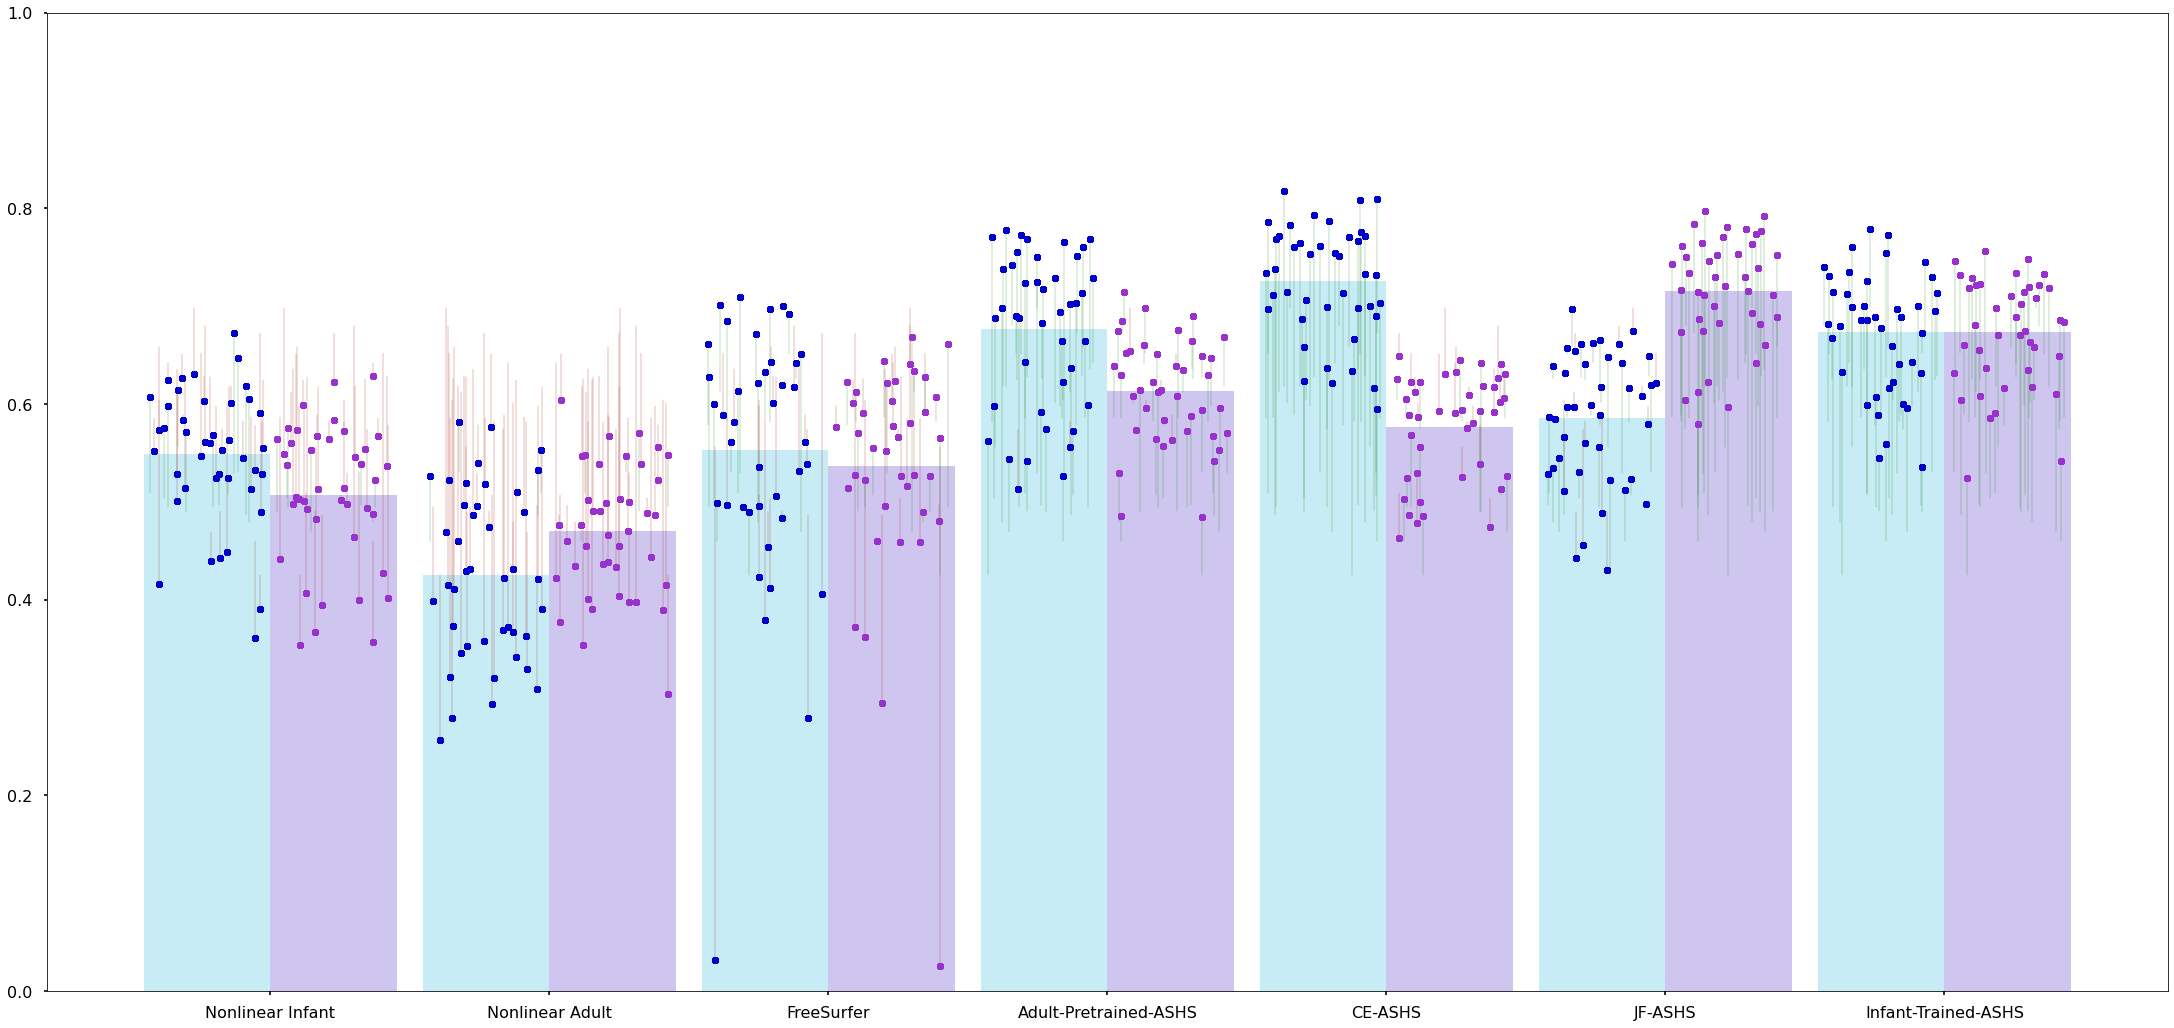

In [18]:
# Contruct a bar graph for this average template analysis
plt.figure(figsize=(38,18))
plt.ylim([0.0, 1.0])
plt.xticks([])

# Place the average tempaltes for both tracers into lists 
CE_models = [nonlinear_infant_average_approx_nonlinear_CE_HPC, adult_average_approx_nonlinear_CE_HPC, freesurfer_approx_CE_HPC, adult_pretrained_ASHS_approx_CE_HPC, CE_ASHS_approx_CE_HPC, JF_ASHS_approx_CE_HPC, infant_trained_ASHS_approx_CE_HPC]
JF_models = [nonlinear_infant_average_approx_nonlinear_JF_HPC, adult_average_approx_nonlinear_JF_HPC, freesurfer_approx_JF_HPC,adult_pretrained_ASHS_approx_JF_HPC, CE_ASHS_approx_JF_HPC, JF_ASHS_approx_JF_HPC, infant_trained_ASHS_approx_JF_HPC]

# Set the x-value for the first bar coupling
CE_ticker = 0.5
JF_ticker = 1.5

# Set the x-range for the individual points
CE_point_range = [0.05,0.95]
JF_point_range = [1.05, 1.95]

# Loop through correpsonding template data from both tracers
for CE_model, JF_model in zip(CE_models, JF_models):
    
    if len(CE_model) == 42:
        
        # Plot CE's data
        jitter_bar(CE_model, inter_rater_reliability_HPC, 'CE', 42, x_range = CE_point_range)
        plt.bar(CE_ticker, np.mean(CE_model), width=1, color=[0.780, 0.924, 0.960])
    
        # Plot JF's data
        jitter_bar(JF_model, inter_rater_reliability_HPC, 'JF', 42, x_range = JF_point_range)
        plt.bar(JF_ticker, np.mean(JF_model), width=1,color=[0.808, 0.776, 0.936])
        
    if len(CE_model) == 40:
        
        # Plot CE's FreeSurfer data
        jitter_bar(CE_model, inter_rater_reliability_HPC, 'CE', 40, x_range = CE_point_range)
        plt.bar(CE_ticker, np.mean(CE_model), width=1, color=[0.780, 0.924, 0.960])
    
        # Plot JF's FreeSurfer data
        jitter_bar(JF_model, inter_rater_reliability_HPC, 'JF', 40, x_range = JF_point_range)
        plt.bar(JF_ticker, np.mean(JF_model), width=1,color=[0.808, 0.776, 0.936])
  
    # Increase the ticker and x_range values for the next loop
    CE_ticker = CE_ticker + 2.2
    CE_point_range = np.add(CE_point_range, [2.2, 2.2])
   
    # Increase the ticker and x_range values for the next loop
    JF_ticker = JF_ticker + 2.2
    JF_point_range = np.add(JF_point_range, [2.2, 2.2])


plt.xticks([1, 3.2, 5.4, 7.6, 9.8, 12, 14.2], ['Nonlinear Infant', 'Nonlinear Adult', 'FreeSurfer', 'Adult-Pretrained-ASHS', 'CE-ASHS', 'JF-ASHS', 'Infant-Trained-ASHS'])

# Plot and save the data
plt.savefig(out_dir_plots + 'Average_templates_FreeSurfer_ASHS_approx_HPC_bar_graph.svg')

### Intersect Hippocampal Analyses  <a class="anchor" id="section_2_9"></a>
Analyses assessing the degree to which the segmentations generated from the three ASHS models above matched an optimal representation of what was shared across tracers — an intersection of the manual segmentations from CE and JF.

In [10]:
# Path containing the intersect data.
out_dir_segmentations_intersect = '%s/segmentations_intersect/' % out_dir

# Store the paths for the intersect data in a list and order it by age 
files_segmentations_intersect = sorted(glob.glob(out_dir_segmentations_intersect + '*'))
ordered_files_segmentations_intersect = np.asarray(files_segmentations_intersect)[np.argsort(ppt_ages)]

# Run Dice comparison's between CE's data and the intersect data
CE_vs_Intersect = dice_compare(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_intersect, 'CE_vs_Intersect', 'CE vs Intersect')

# Run Dice comparison's between JF's data and the intersect data
JF_vs_Intersect = dice_compare(ordered_files_segmentations_nonlinear_JF, ordered_files_segmentations_intersect, 'JF_vs_Intersect', 'JF vs Intersect')
print()

# Calculate the Optimal Dice (i.e., the average between CE and JF's optimals)
Dice_Optimal = (CE_vs_Intersect + JF_vs_Intersect)/2

# Print the Optimal Dice info out
print('Optimal Dice=%0.2f'% np.mean(Dice_Optimal) + ' (SD=%0.2f'% stdev(Dice_Optimal) + ', range=%0.2f'% np.min(Dice_Optimal) + '-%0.2f)'% np.max(Dice_Optimal))
print()

# Measure Dice values between CE-ASHS and the Intersect
CE_ASHS_vs_Intersect = dice_compare_ASHS(ordered_files_segmentations_CE_ASHS_right, ordered_files_segmentations_CE_ASHS_left, ordered_files_segmentations_intersect, 'CE_ASHS_approximating_Intersect', 'CE-ASHS Approximating Intersect', trained = True)

# Assess how well CE-ASHS approximated the Optimal of this study
p_val, sign_count, CIs = randomise_diff(CE_ASHS_vs_Intersect - CE_vs_Intersect)
print('CE-ASHS vs CE Approximating Intersect: M=%0.2f'% np.mean(CE_ASHS_vs_Intersect - CE_vs_Intersect) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from Optimal'), print()

# Measure Dice values between JF-ASHS and the Intersect
JF_ASHS_vs_Intersect = dice_compare_ASHS(ordered_files_segmentations_JF_ASHS_right, ordered_files_segmentations_JF_ASHS_left, ordered_files_segmentations_intersect, 'JF_ASHS_approximating_Intersect', 'JF-ASHS Approximating Intersect', trained = True)

# Assess how well JF-ASHS approximated the Optimal of this study
p_val, sign_count, CIs = randomise_diff(JF_ASHS_vs_Intersect - JF_vs_Intersect)
print('JF-ASHS vs JF Approximating Intersect:  M=%0.2f'% np.mean(JF_ASHS_vs_Intersect  - JF_vs_Intersect) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from Optimal'), print()

# Measure Dice values between Infant-Trained-ASHS and the Intersect
infant_trained_ASHS_vs_Intersect = dice_compare_ASHS(ordered_files_segmentations_infant_trained_ASHS_right, ordered_files_segmentations_infant_trained_ASHS_left, ordered_files_segmentations_intersect, 'Infant_Trained_ASHS_approximating_Intersect', 'Infant-Trained-ASHS Approximating Intersect', trained = True)

# Assess how much better the Infant-Trained ASHS approximated the Optimal of this study compared to CE-ASHS and JF-ASHS
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_vs_Intersect - CE_ASHS_vs_Intersect)
print('Infant-Trained-ASHS vs CE-ASHS Approximating Intersect:  M=%0.2f'% np.mean(infant_trained_ASHS_vs_Intersect - CE_ASHS_vs_Intersect) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from CE-ASHS')

p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_vs_Intersect - JF_ASHS_vs_Intersect)
print('Infant-Trained-ASHS vs JF-ASHS Approximating Intersect:  M=%0.2f'% np.mean(infant_trained_ASHS_vs_Intersect - JF_ASHS_vs_Intersect) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from JF-ASHS')


CE vs Intersect HPC Dice=0.74 (SD=0.06, range=0.59-0.84)
JF vs Intersect HPC Dice=0.72 (SD=0.07, range=0.57-0.84)

Optimal Dice=0.73 (SD=0.06, range=0.60-0.82)
CE-ASHS Approximating Intersect HPC Dice=0.60 (SD=0.06, range=0.48-0.70)
CE-ASHS vs CE Approximating Intersect: M=-0.13, CI=[-0.146, -0.121], p=0.000, 0 scan improvement from Optimal

JF-ASHS Approximating Intersect HPC Dice=0.60 (SD=0.09, range=0.43-0.74)
JF-ASHS vs JF Approximating Intersect:  M=-0.12, CI=[-0.133, -0.104], p=0.000, 0 scan improvement from Optimal

Infant-Trained-ASHS Approximating Intersect HPC Dice=0.64 (SD=0.07, range=0.49-0.75)
Infant-Trained-ASHS vs CE-ASHS Approximating Intersect:  M=0.03, CI=[0.024, 0.043], p=0.000, 37 scan improvement from CE-ASHS
Infant-Trained-ASHS vs JF-ASHS Approximating Intersect:  M=0.03, CI=[0.027, 0.043], p=0.000, 41 scan improvement from JF-ASHS


### FreeSurfer/ASHS Bland-Altman Plots  <a class="anchor" id="section_2_10"></a>
Bias plots used to quantify the extent to which the volume of the hippocampus volume was over- or under-estimated by FreeSurfer and the trained ASHS models. 

FreeSurfer difference from zero: 1881.36, CI=[1484.223, 2261.903], p=0.000

Adult-pretrained-ASHS difference from zero: 175.56 , CI=[41.199, 309.907], p=0.010

CE-ASHS difference from zero: -544.49 , CI=[-728.257, -363.664], p=0.000

JF-ASHS difference from zero: -174.27 , CI=[-342.289, -4.928], p=0.044

Infant-trained-ASHS difference from zero: -463.37 , CI=[-647.516, -279.450], p=0.000


<Figure size 432x288 with 0 Axes>

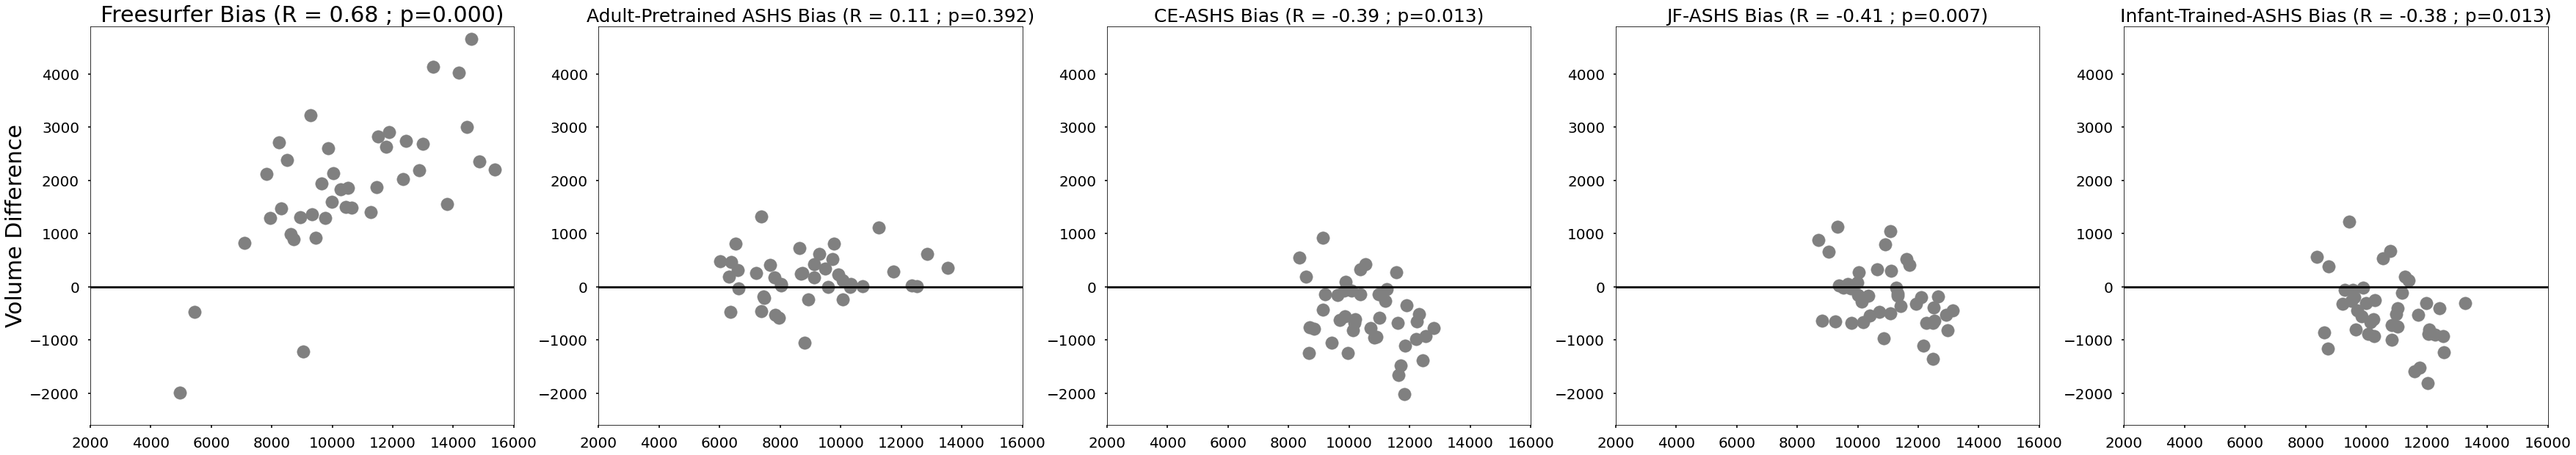

In [16]:
# Generate Bland-Altman plots
bland_altman_plots(ordered_files_segmentations_anatomical_CE, ordered_files_segmentations_anatomical_JF, ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF, ordered_40_files_segmentations_anatomical_CE, ordered_40_files_segmentations_anatomical_JF, 'Bland_Altman_plots')
plt.savefig(out_dir_plots + 'Bland_Altman_scatter_plots.svg')

# Supplementary Data <a class="anchor" id="chapter3"></a>

Contains repeat/control scatterplots, MTL data, LOP ASHS data, and tables containing every Dice value generated in this study

### Plot MTL Segmentations <a class="anchor" id="section_3_0"></a>

Load in each manual MTL segmentation and overlay them on the anatomical images for each participant. CE is in blue and JF is in purple.

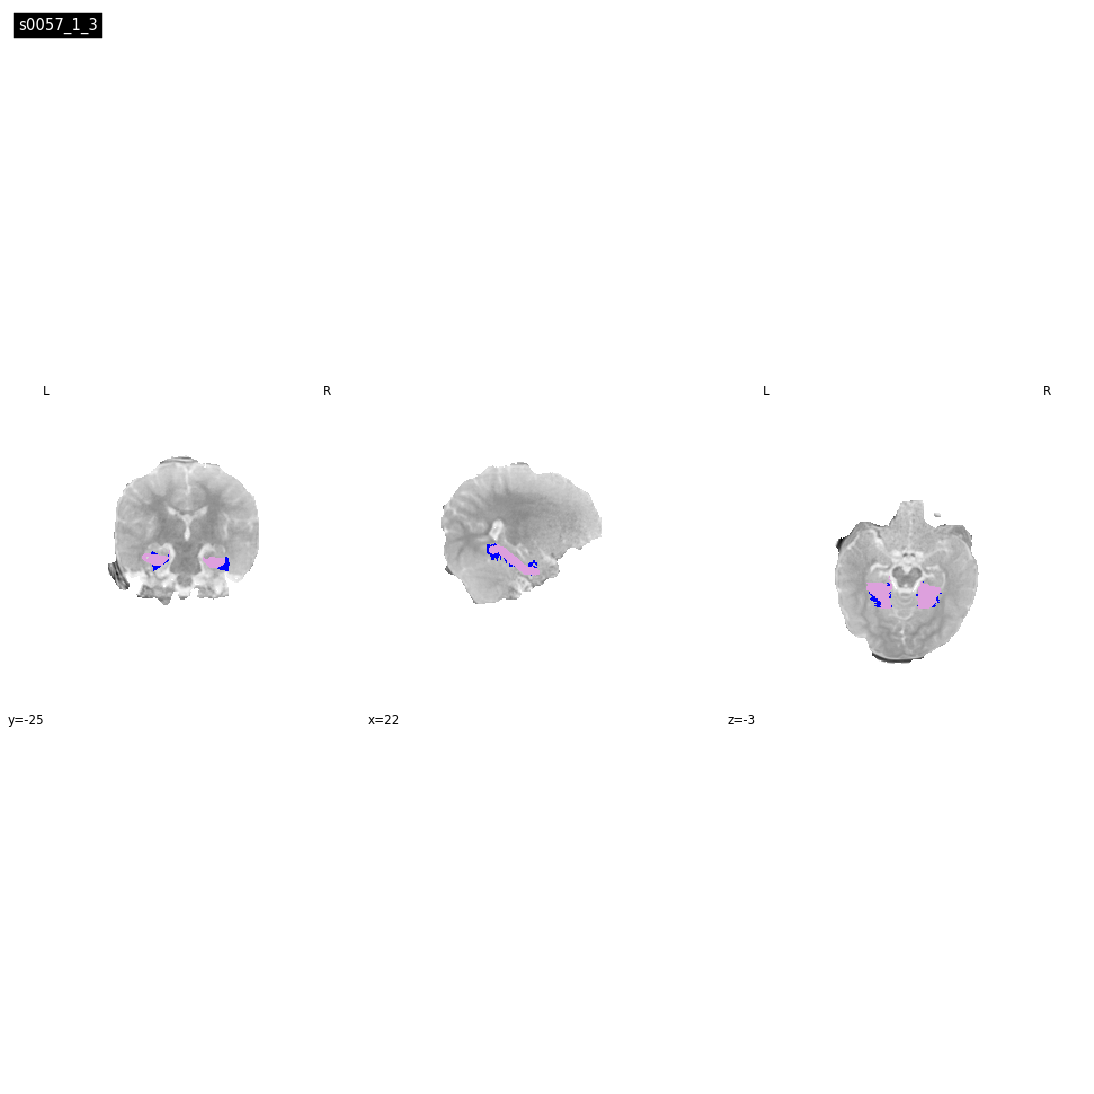

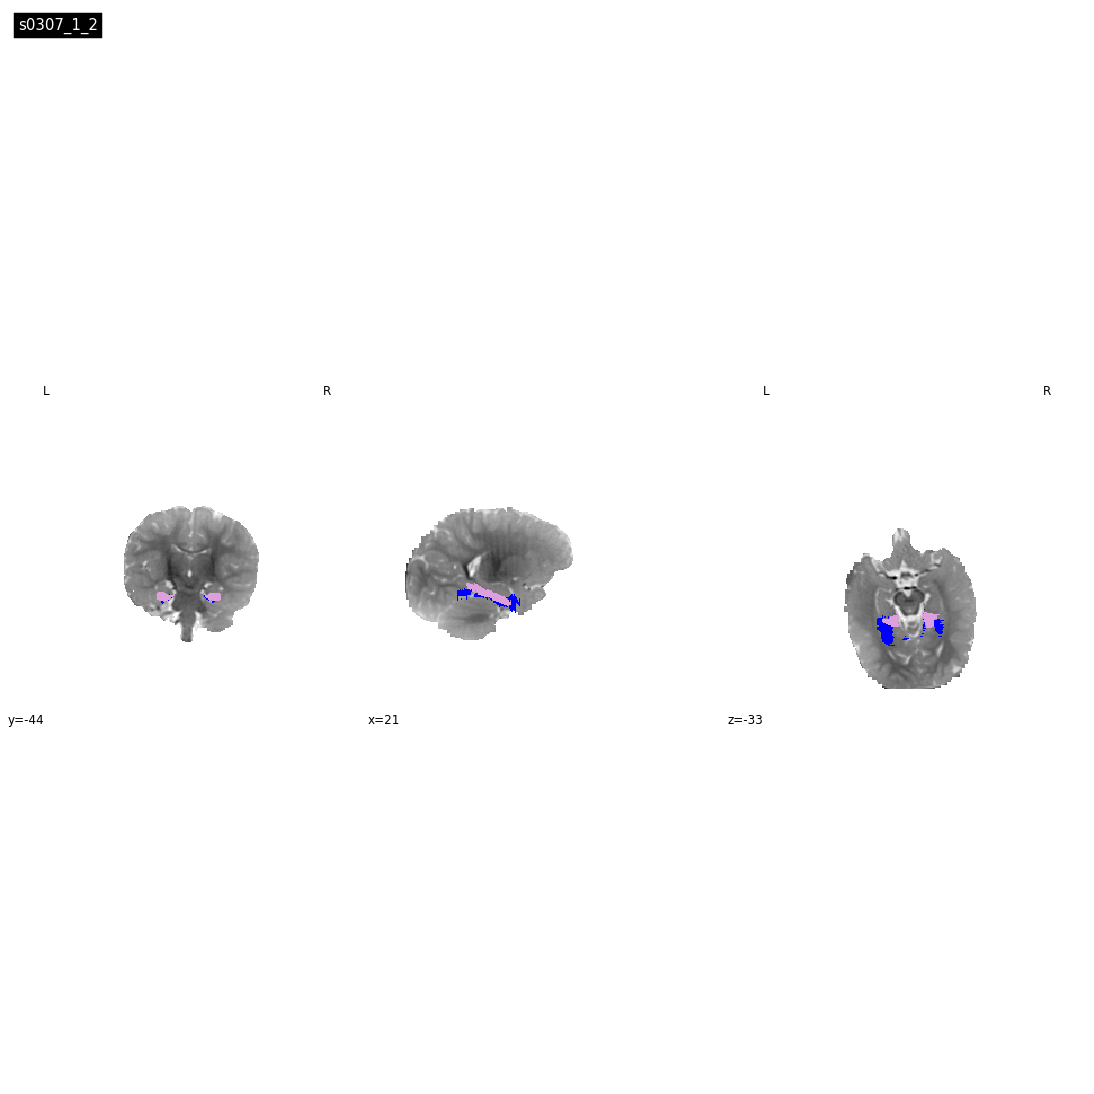

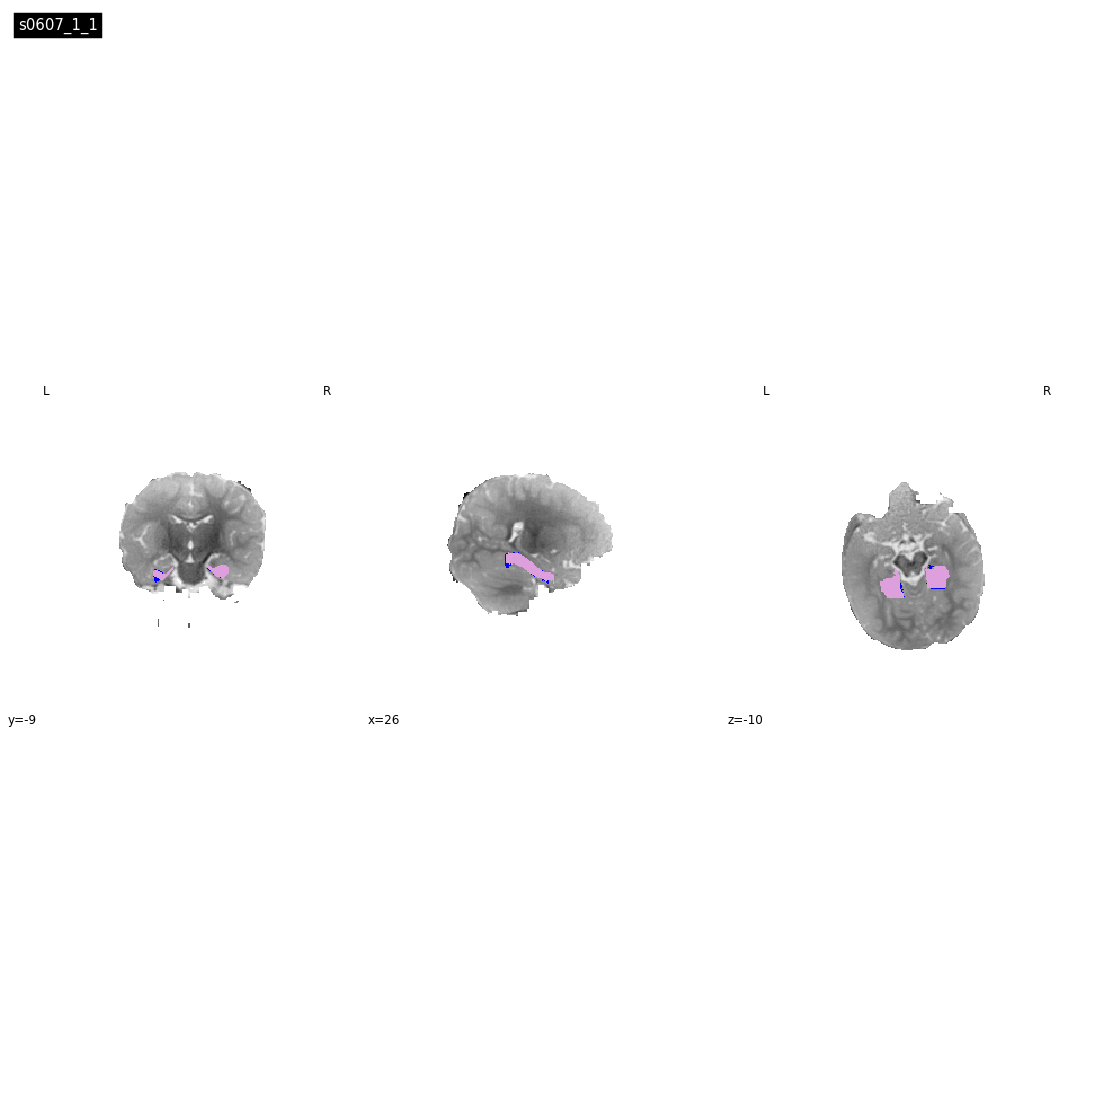

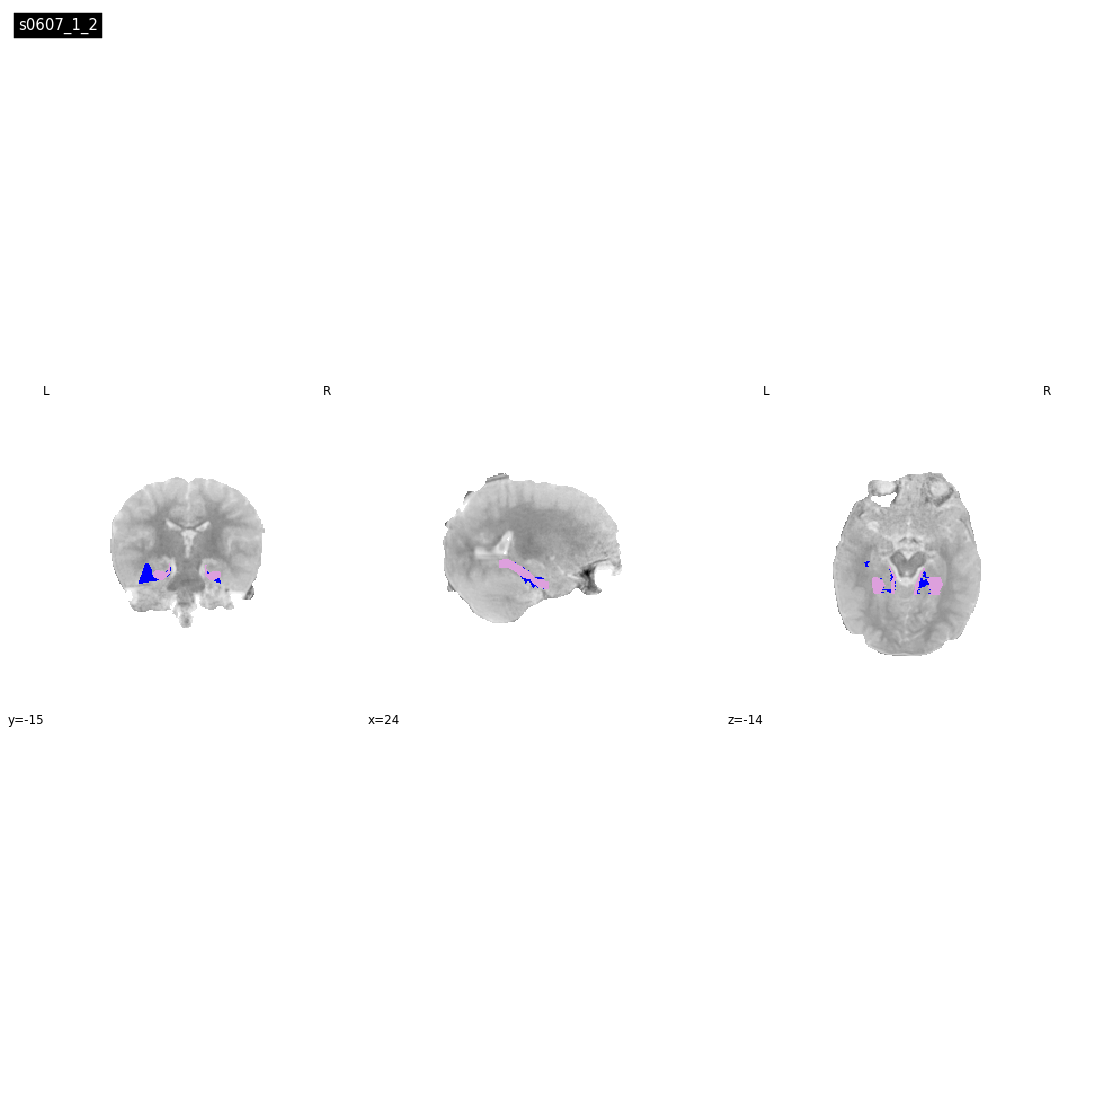

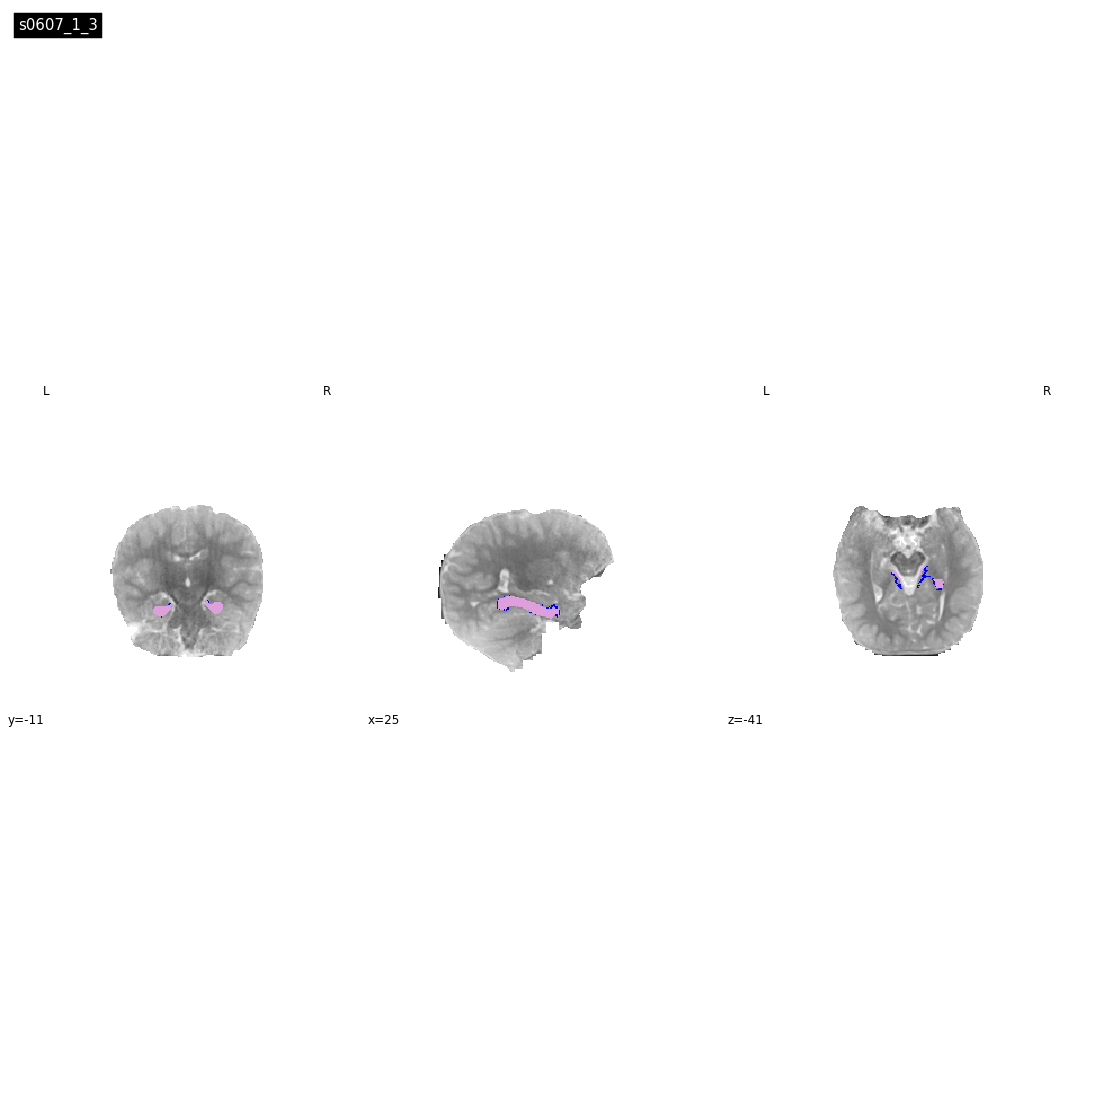

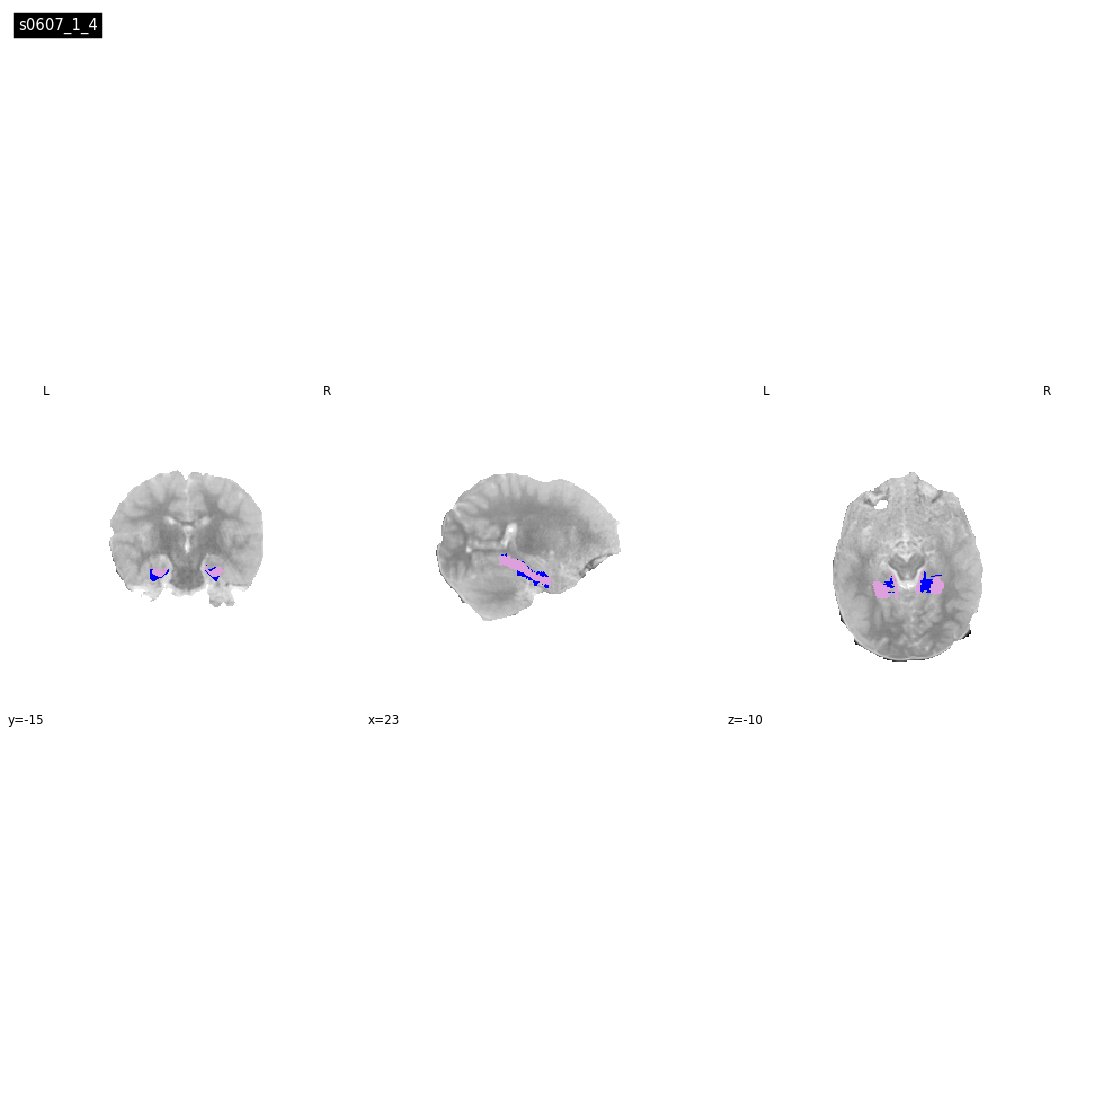

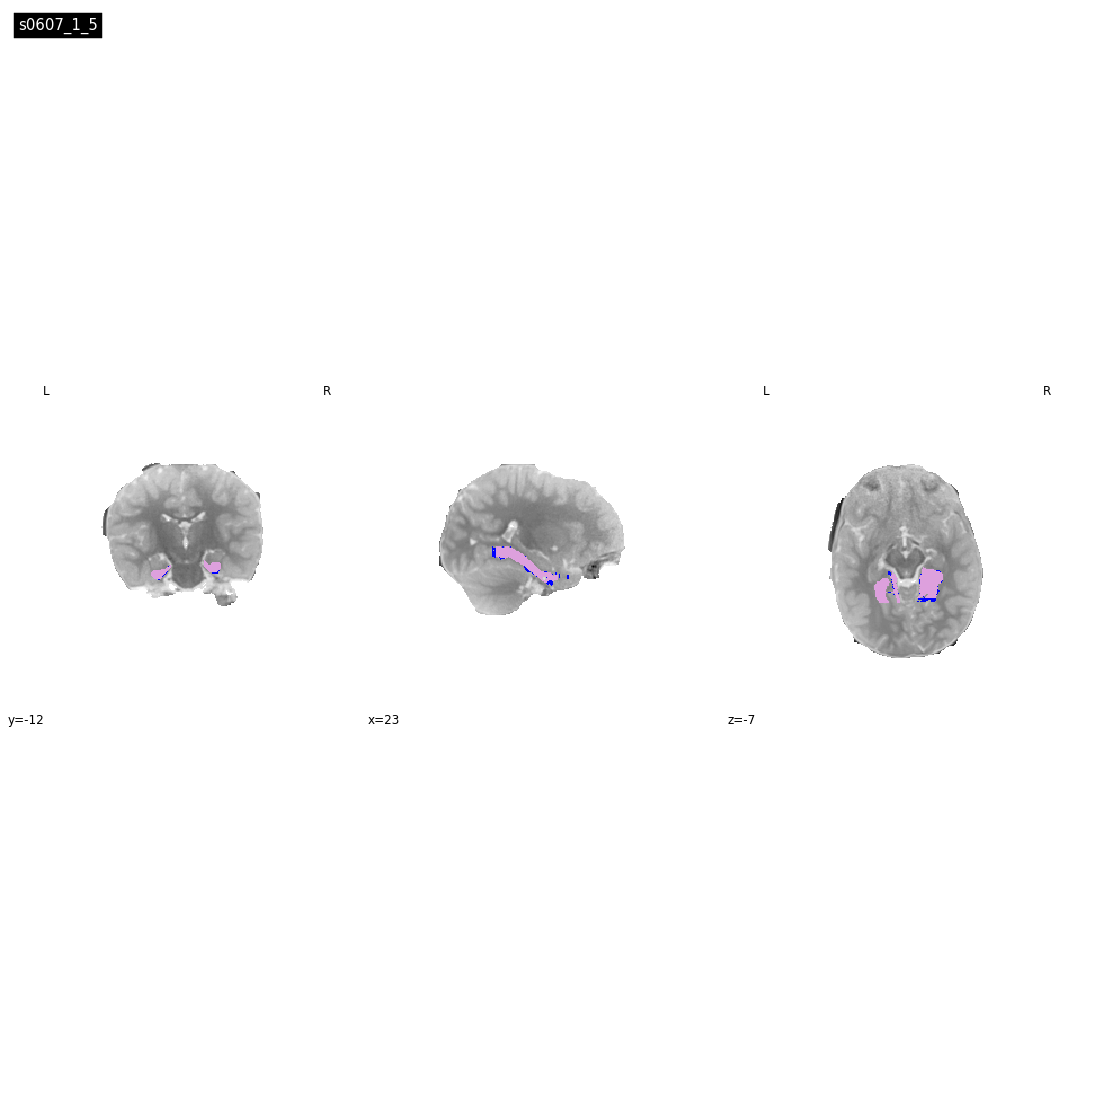

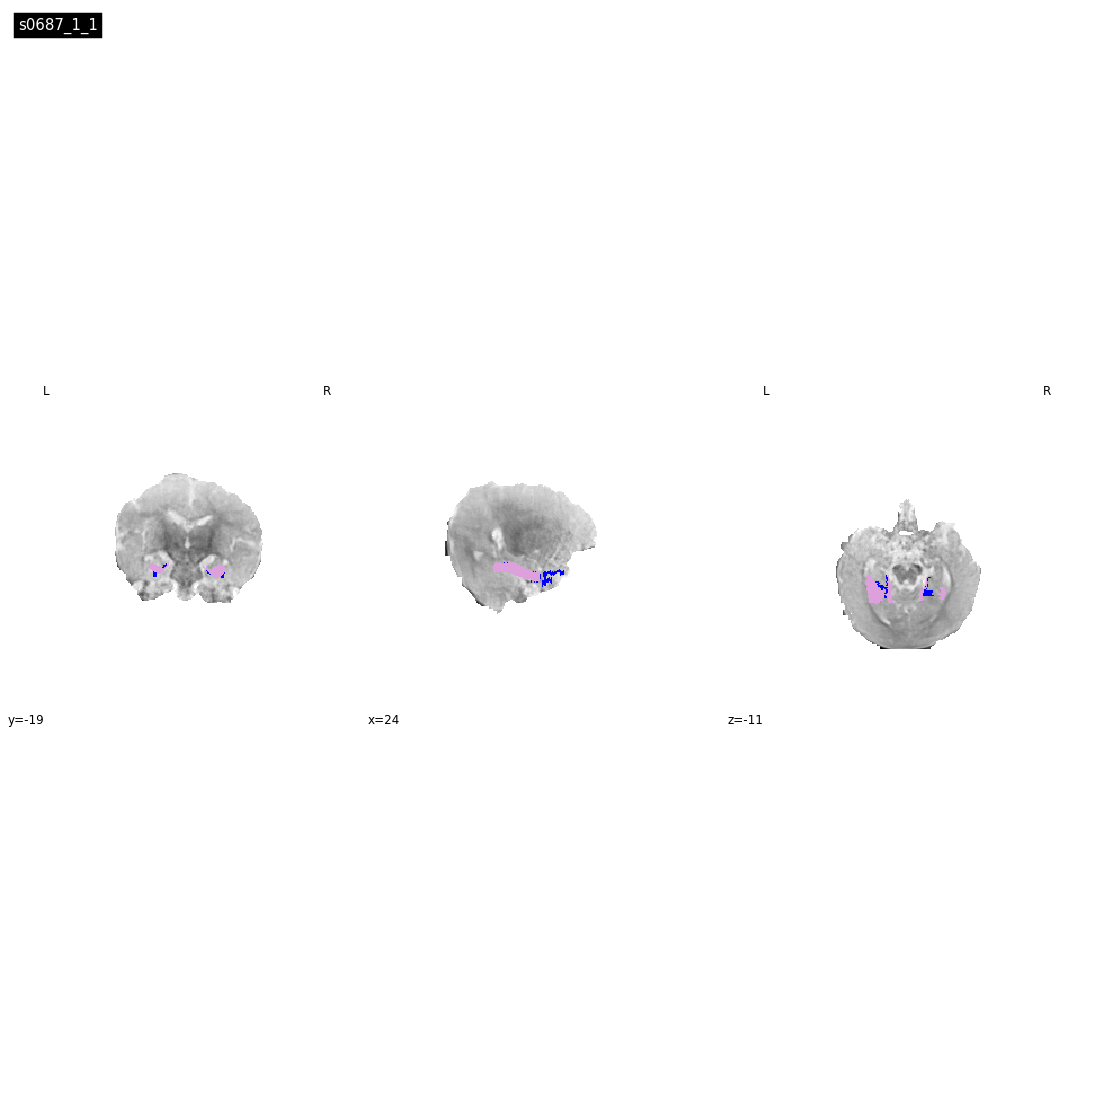

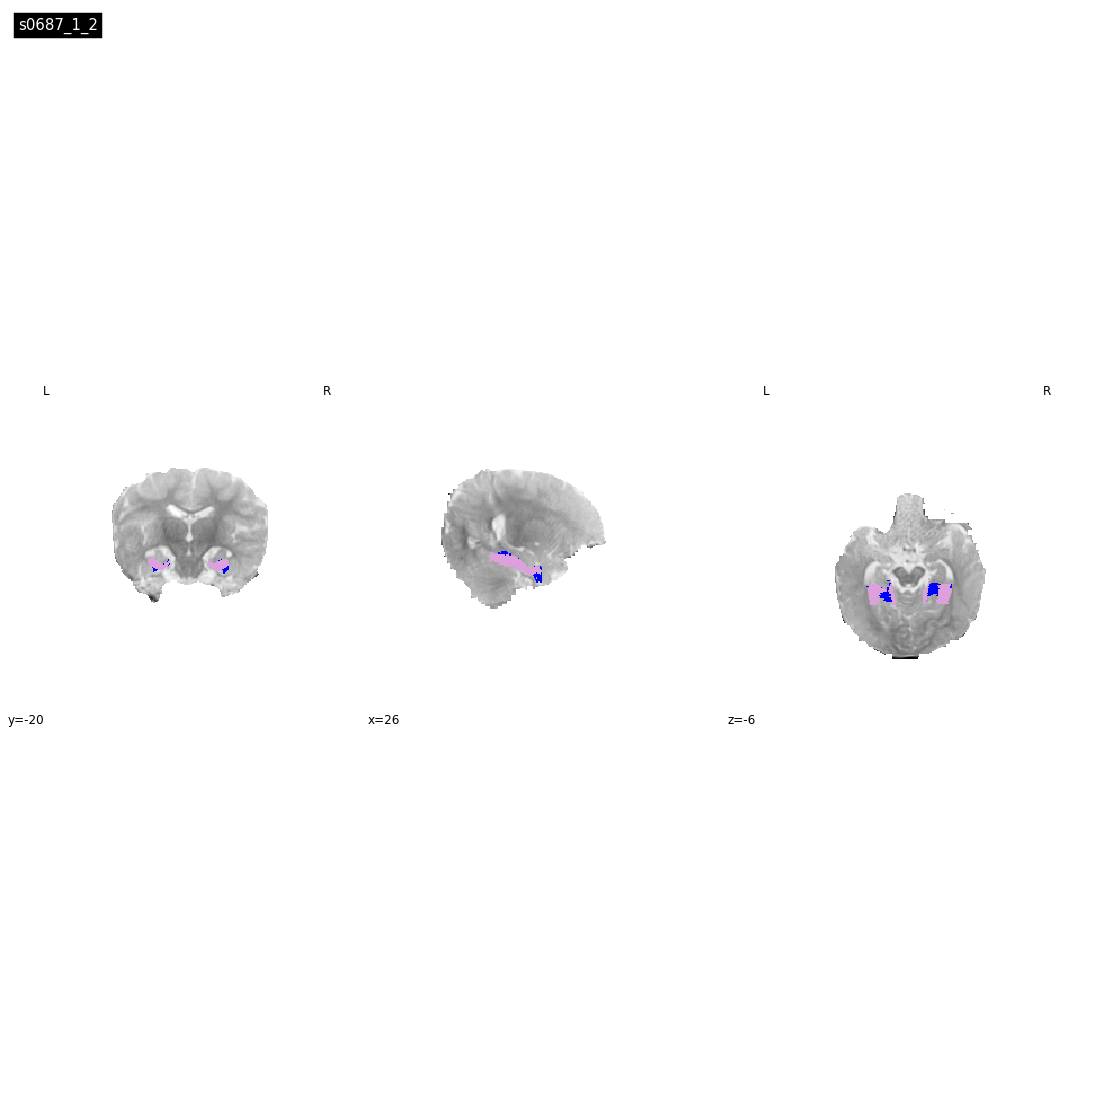

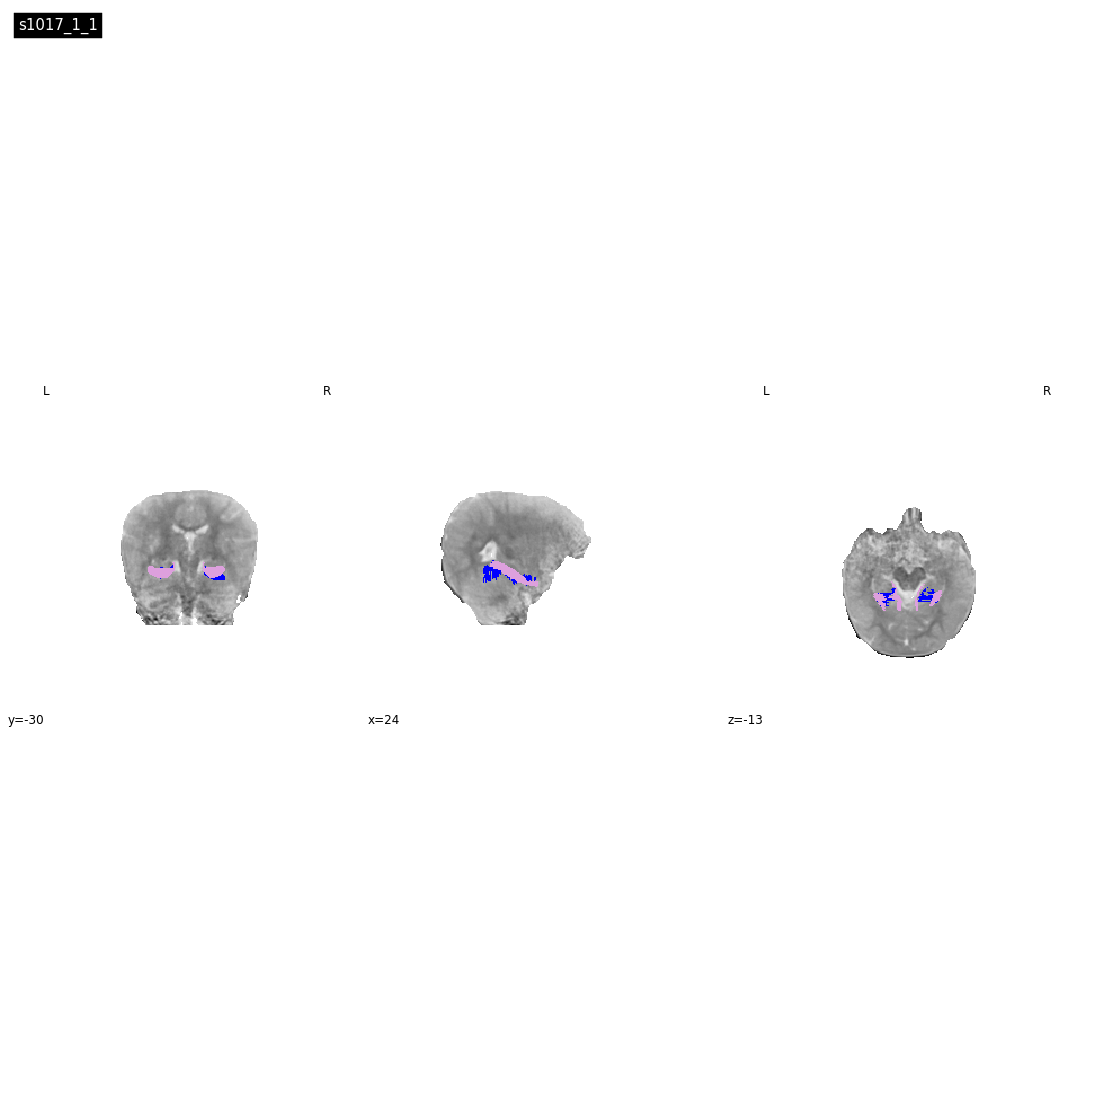

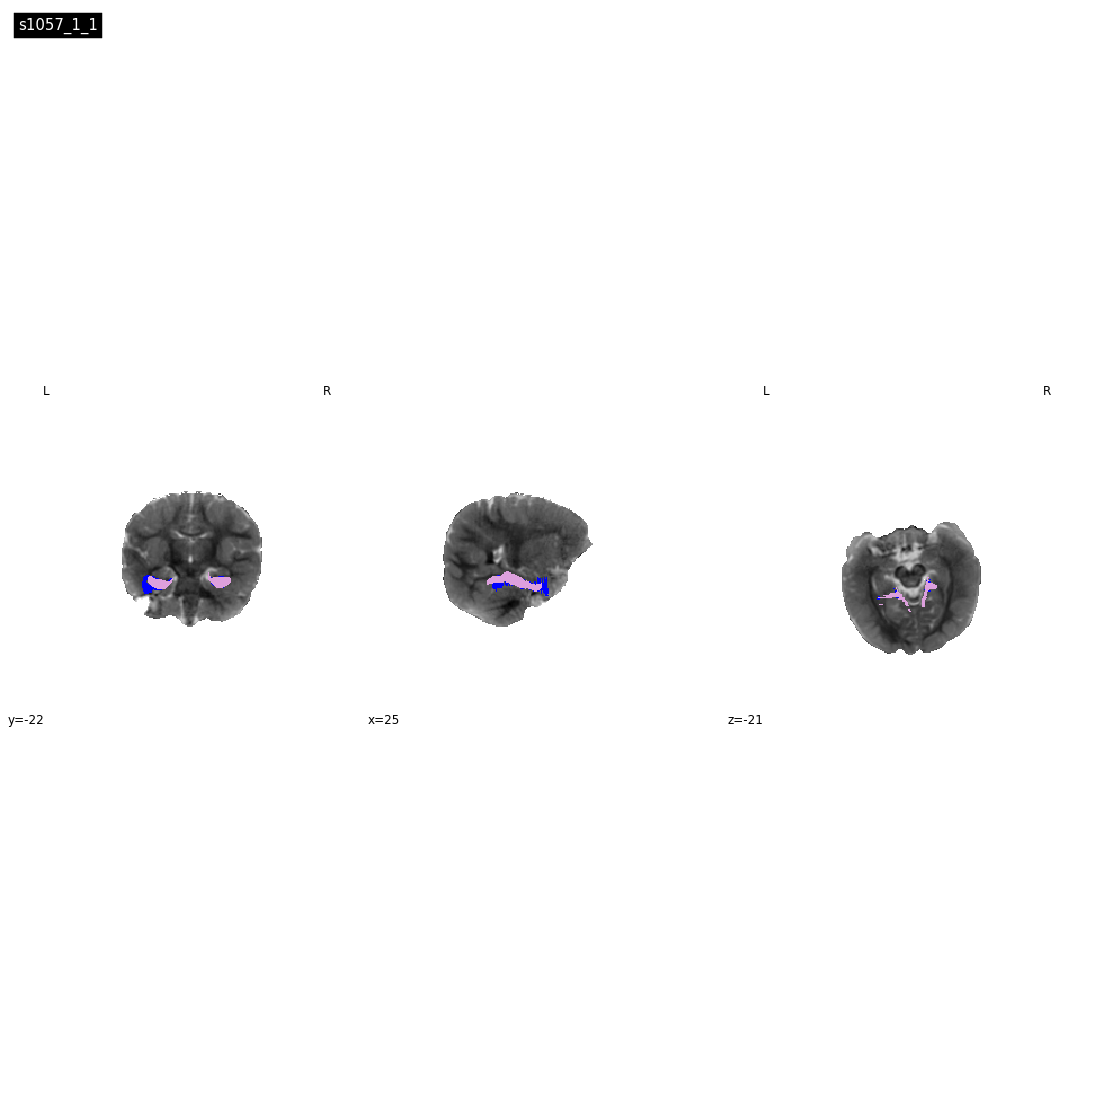

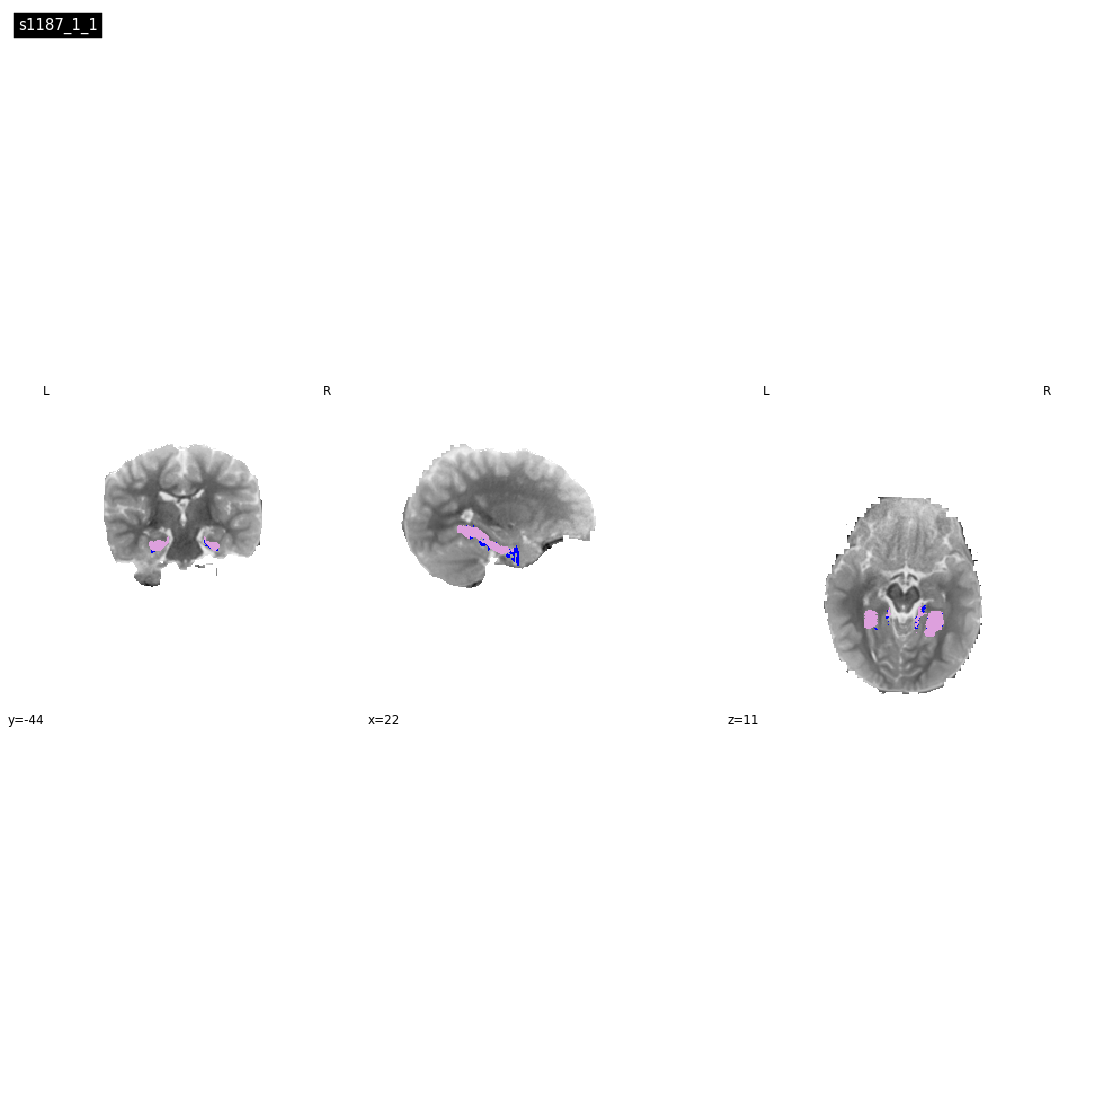

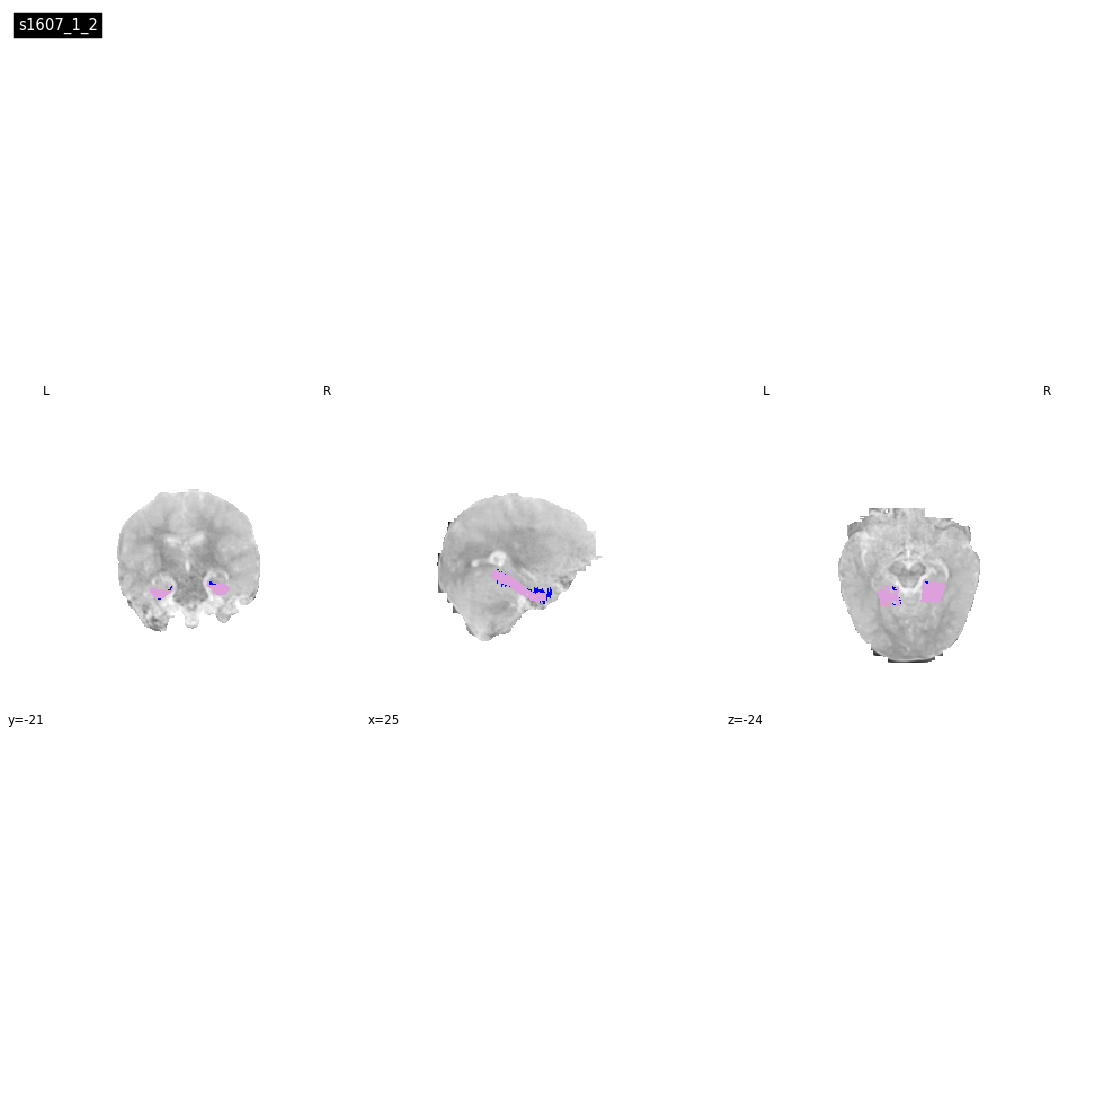

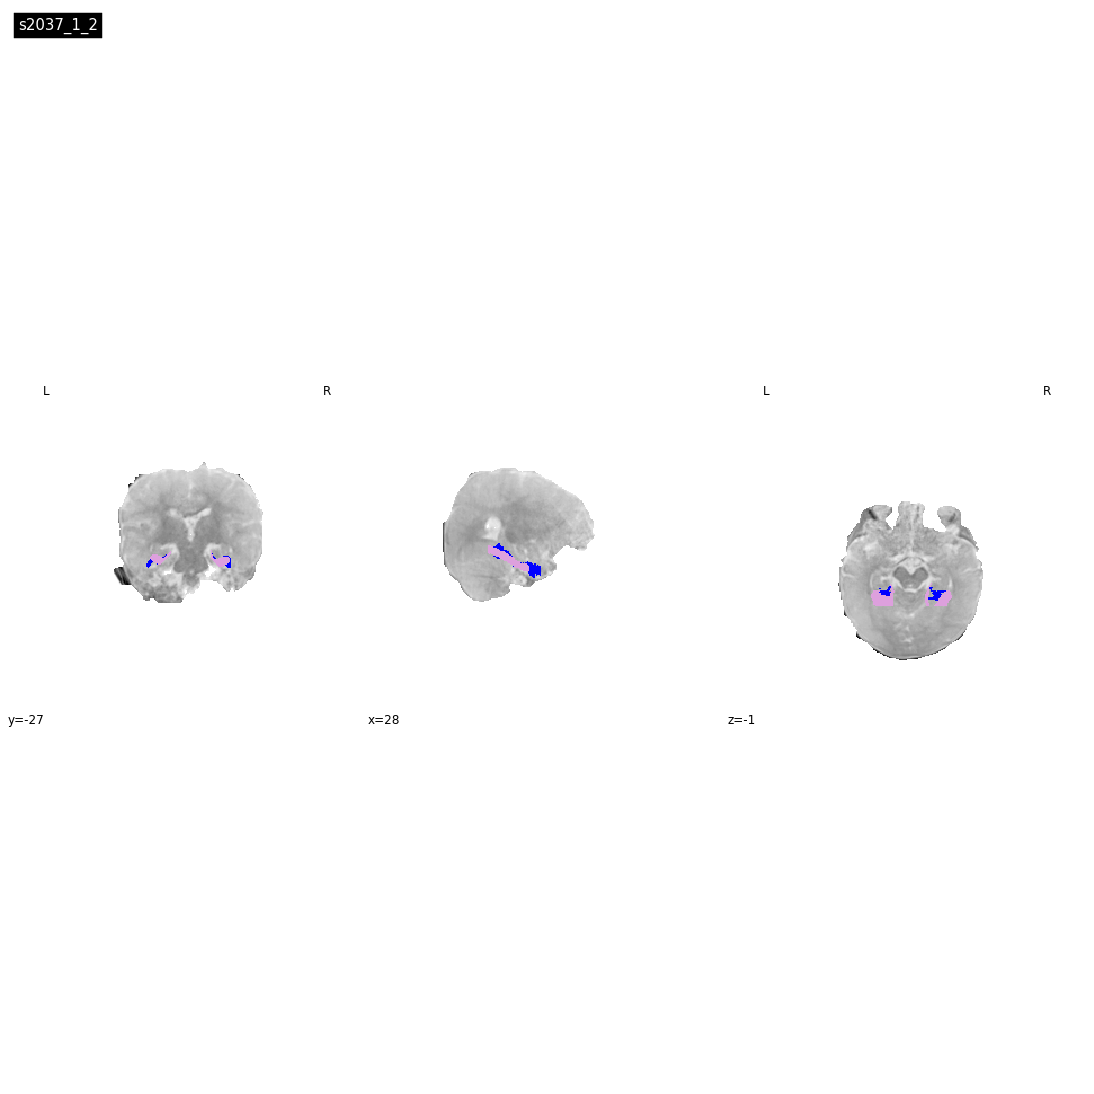

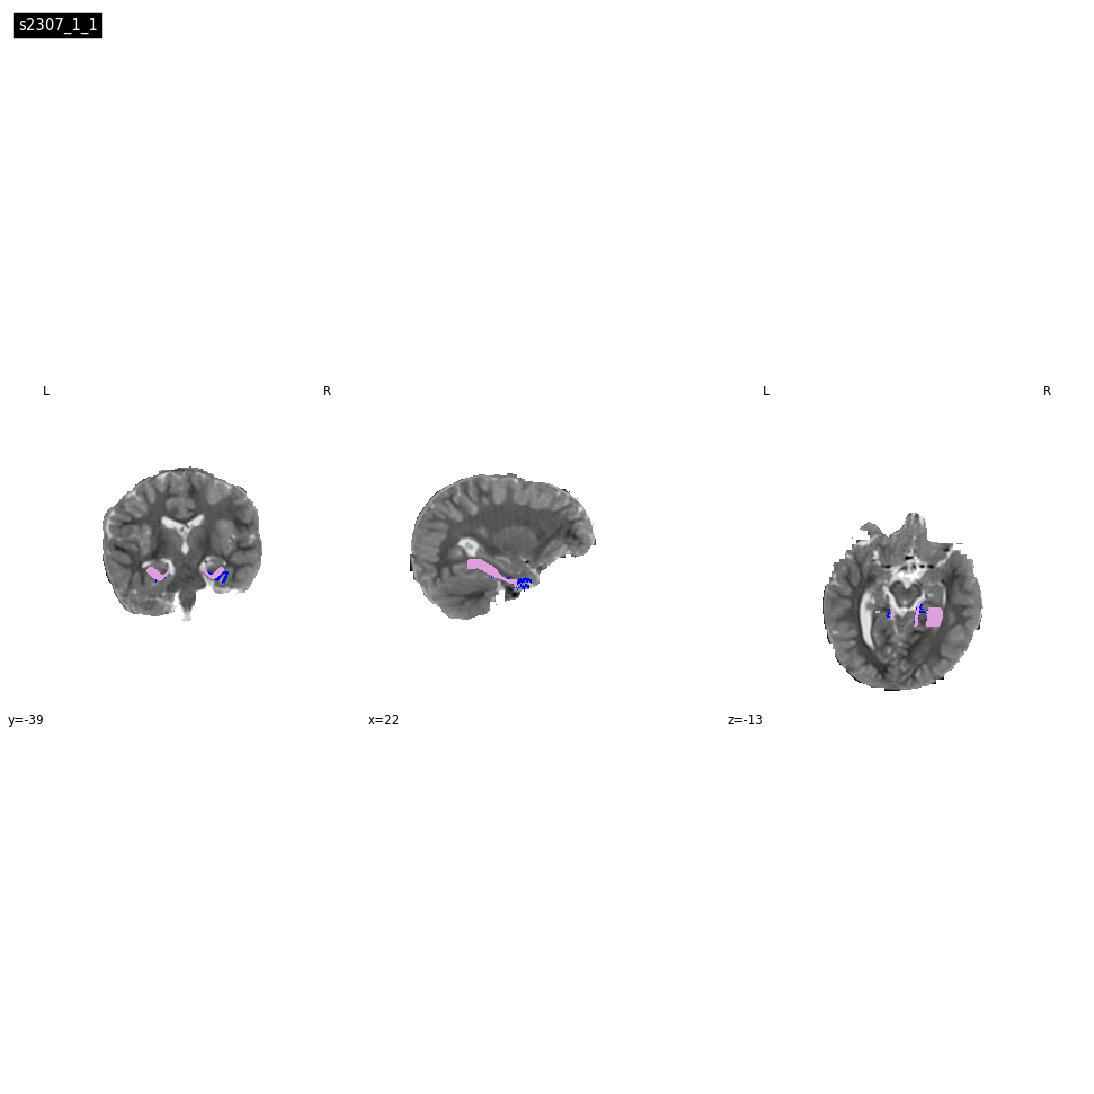

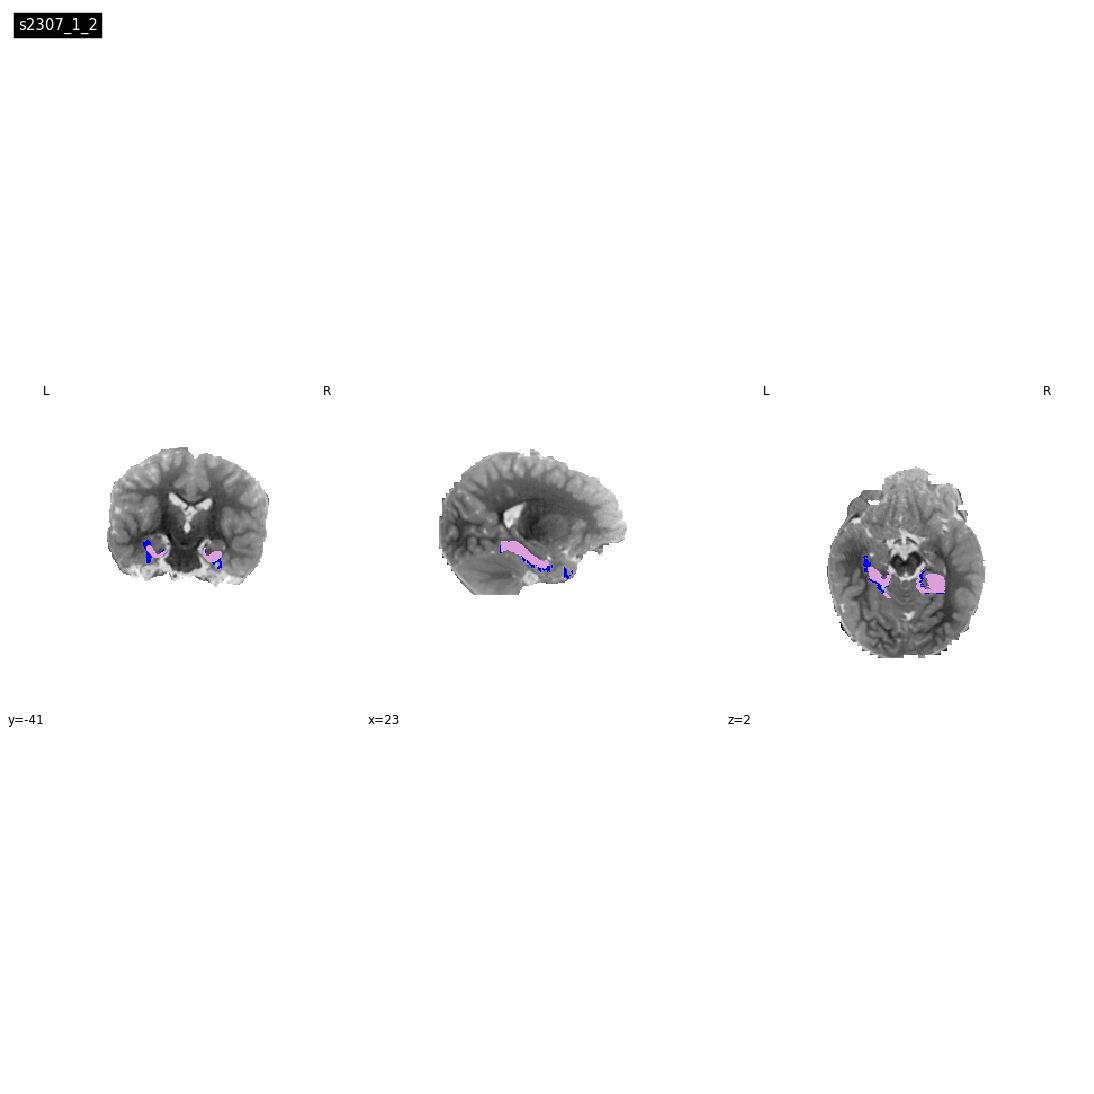

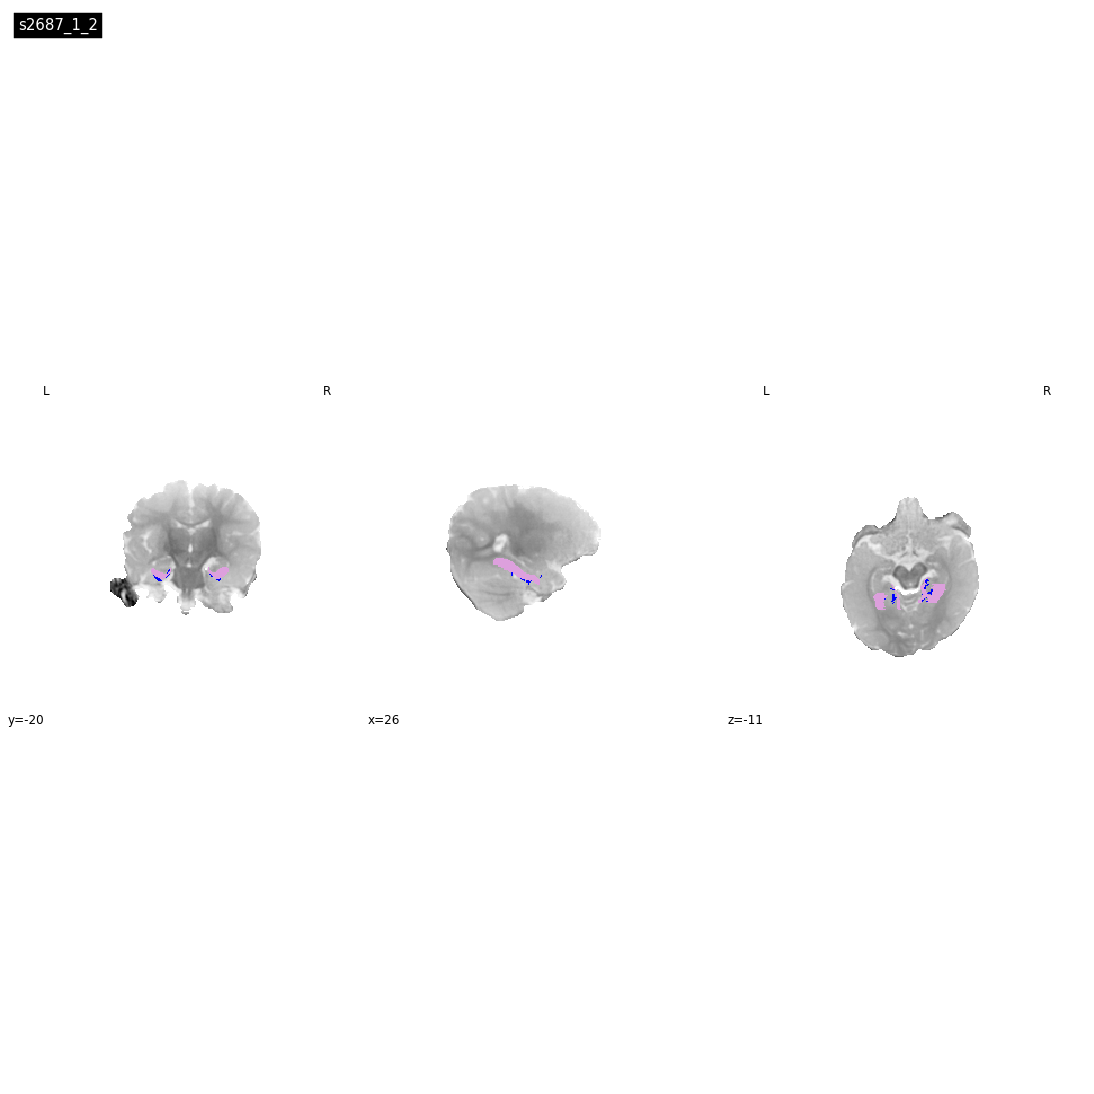

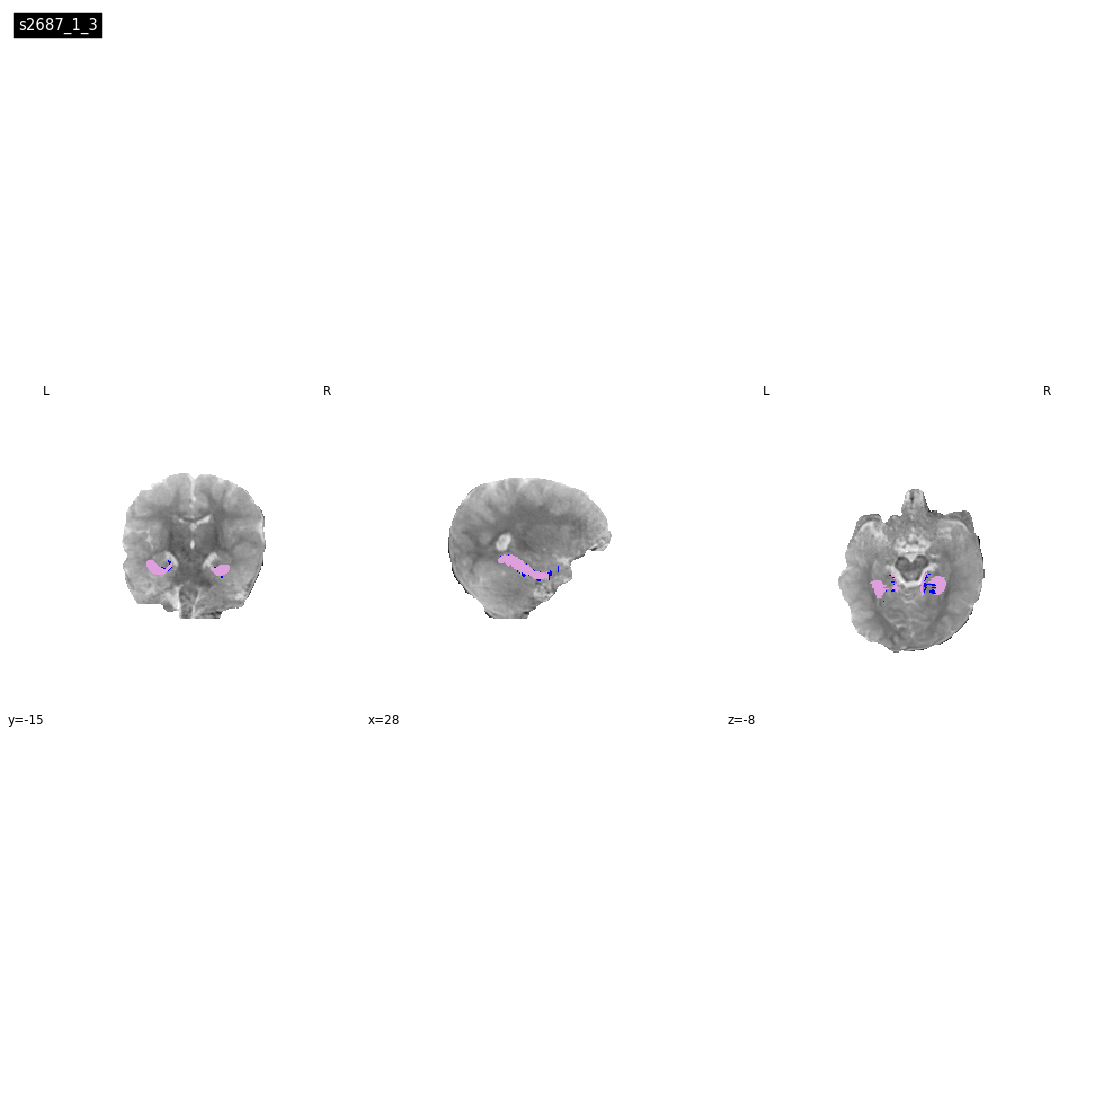

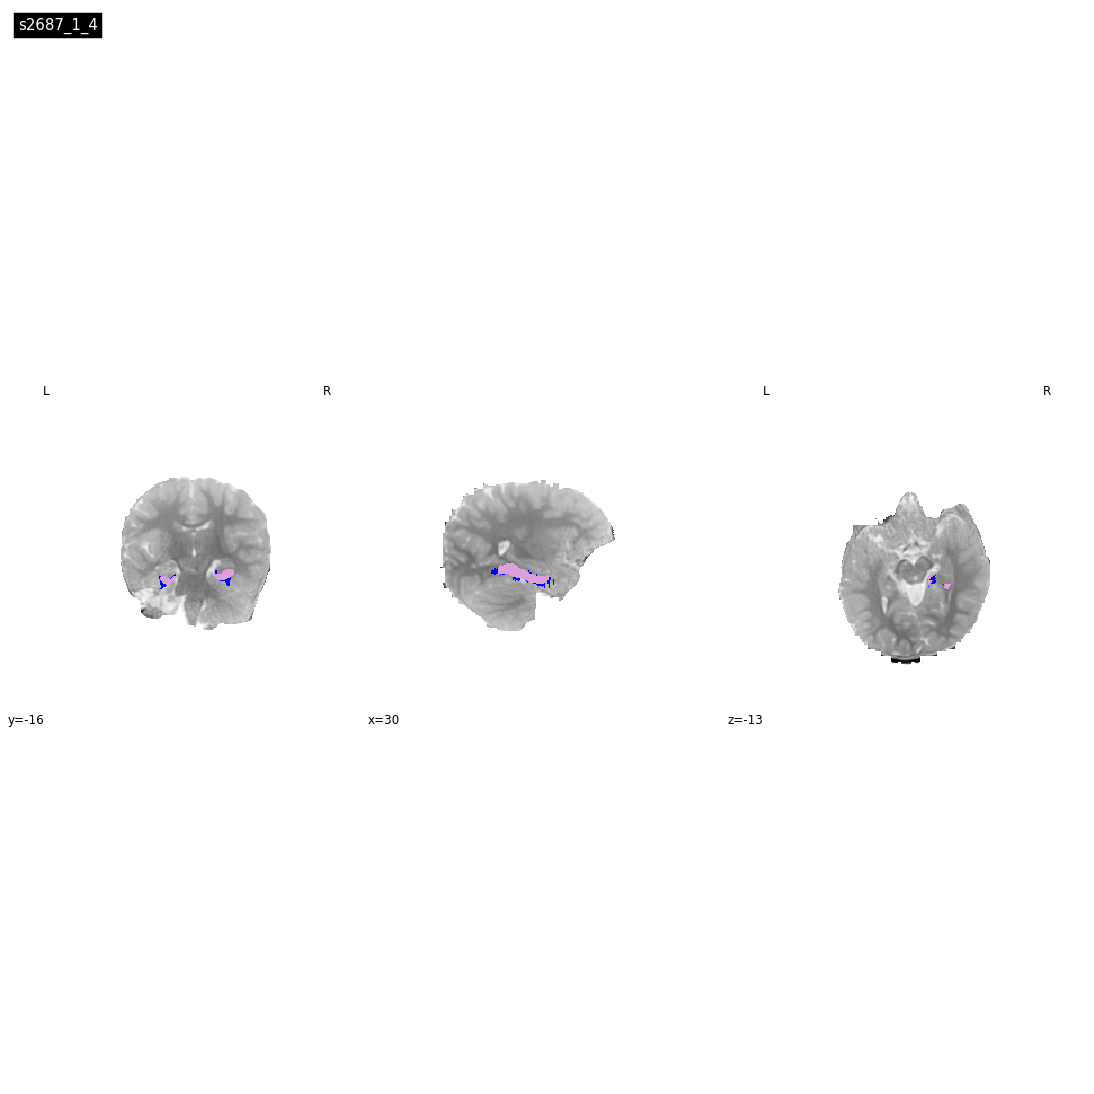

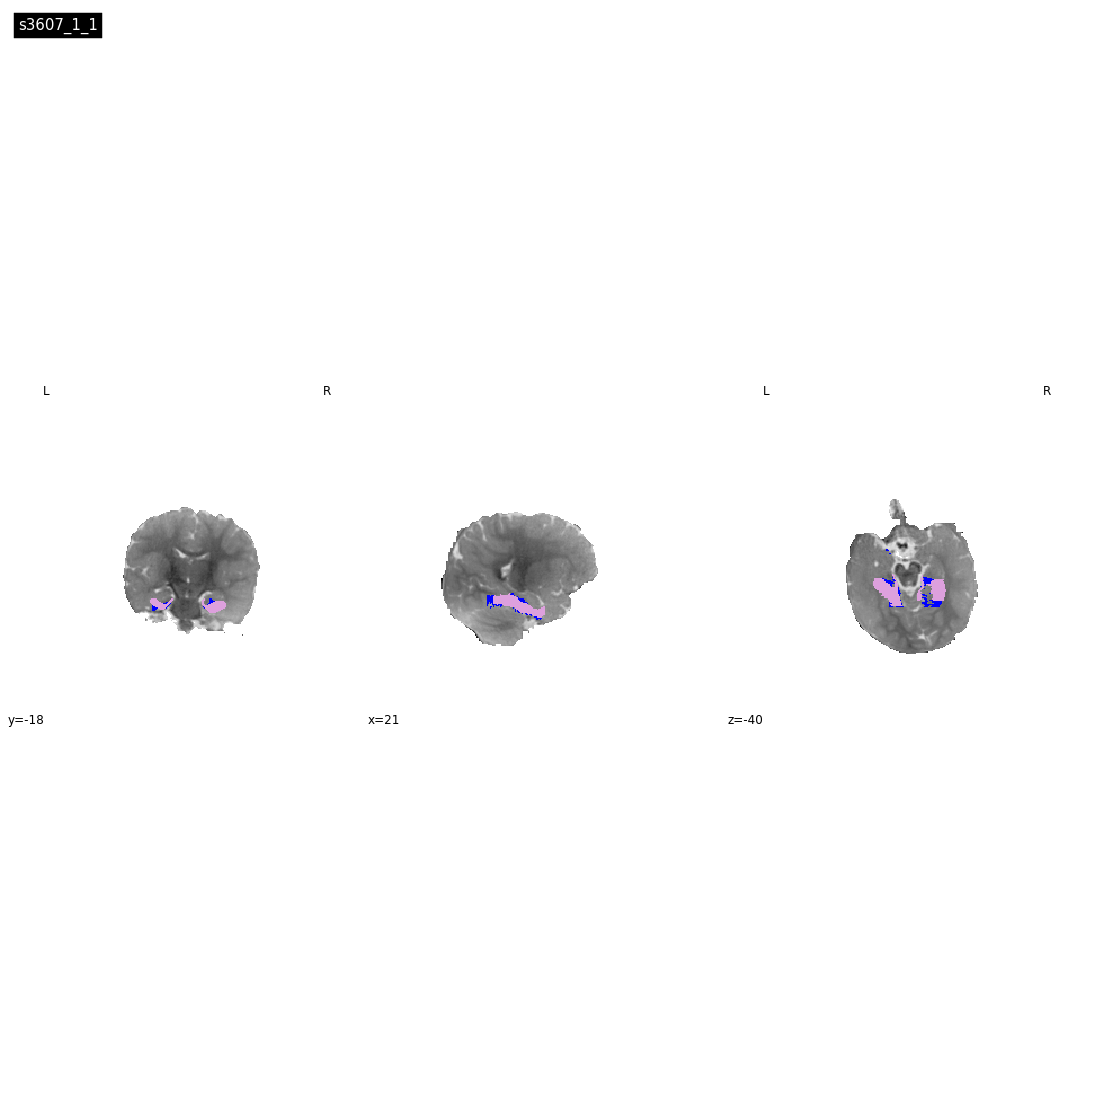

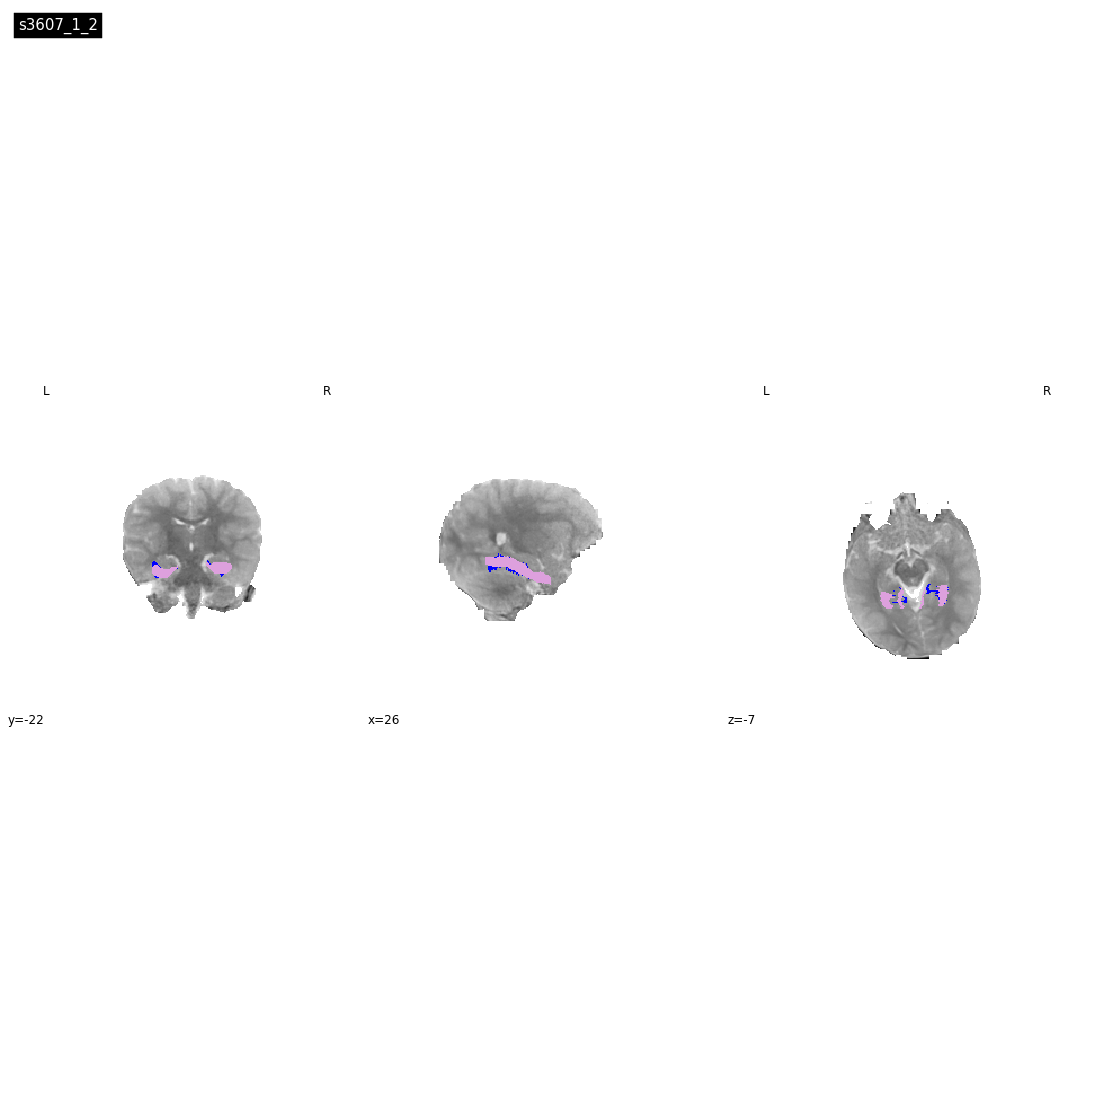

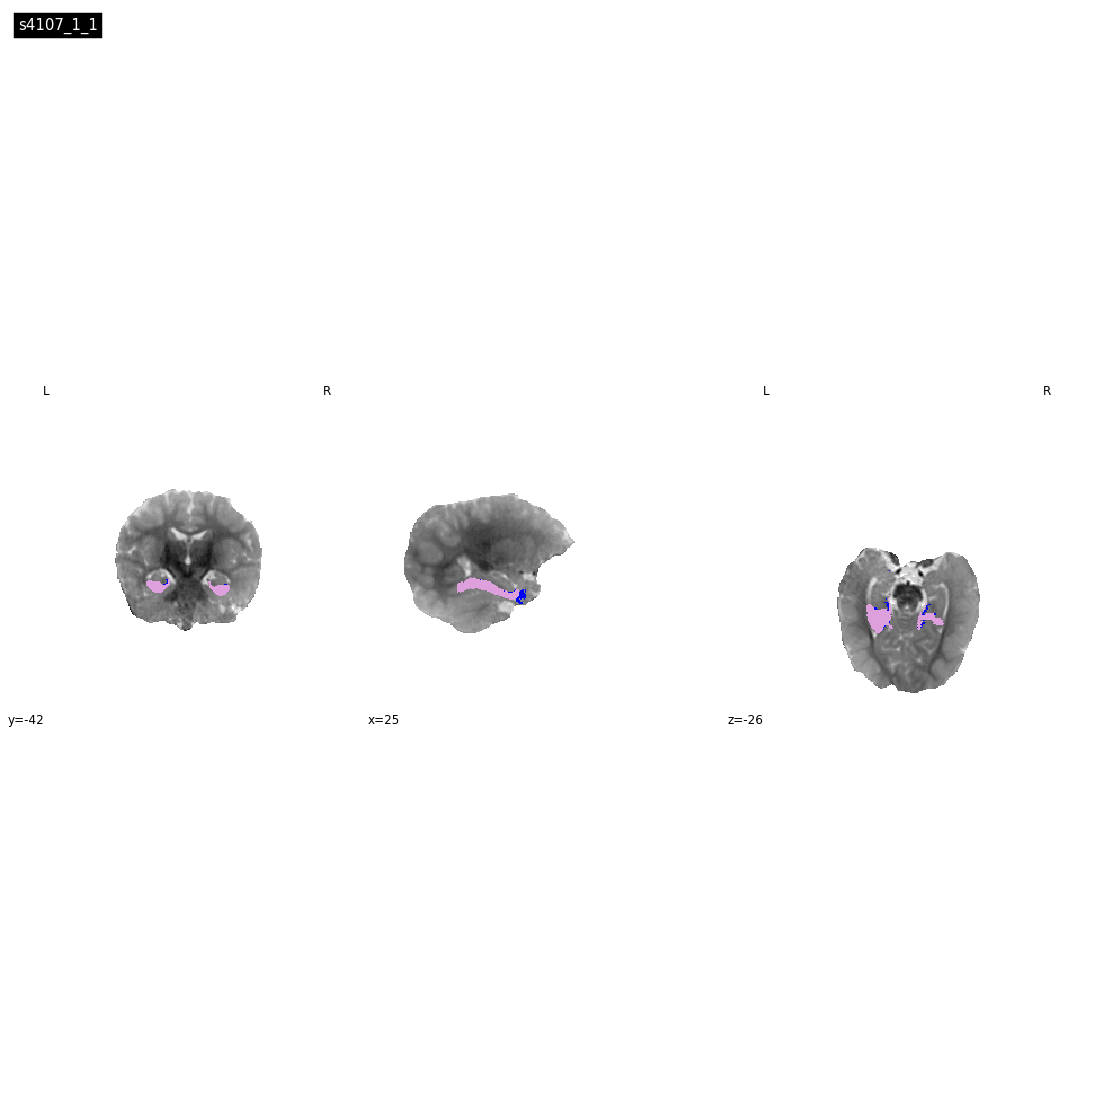

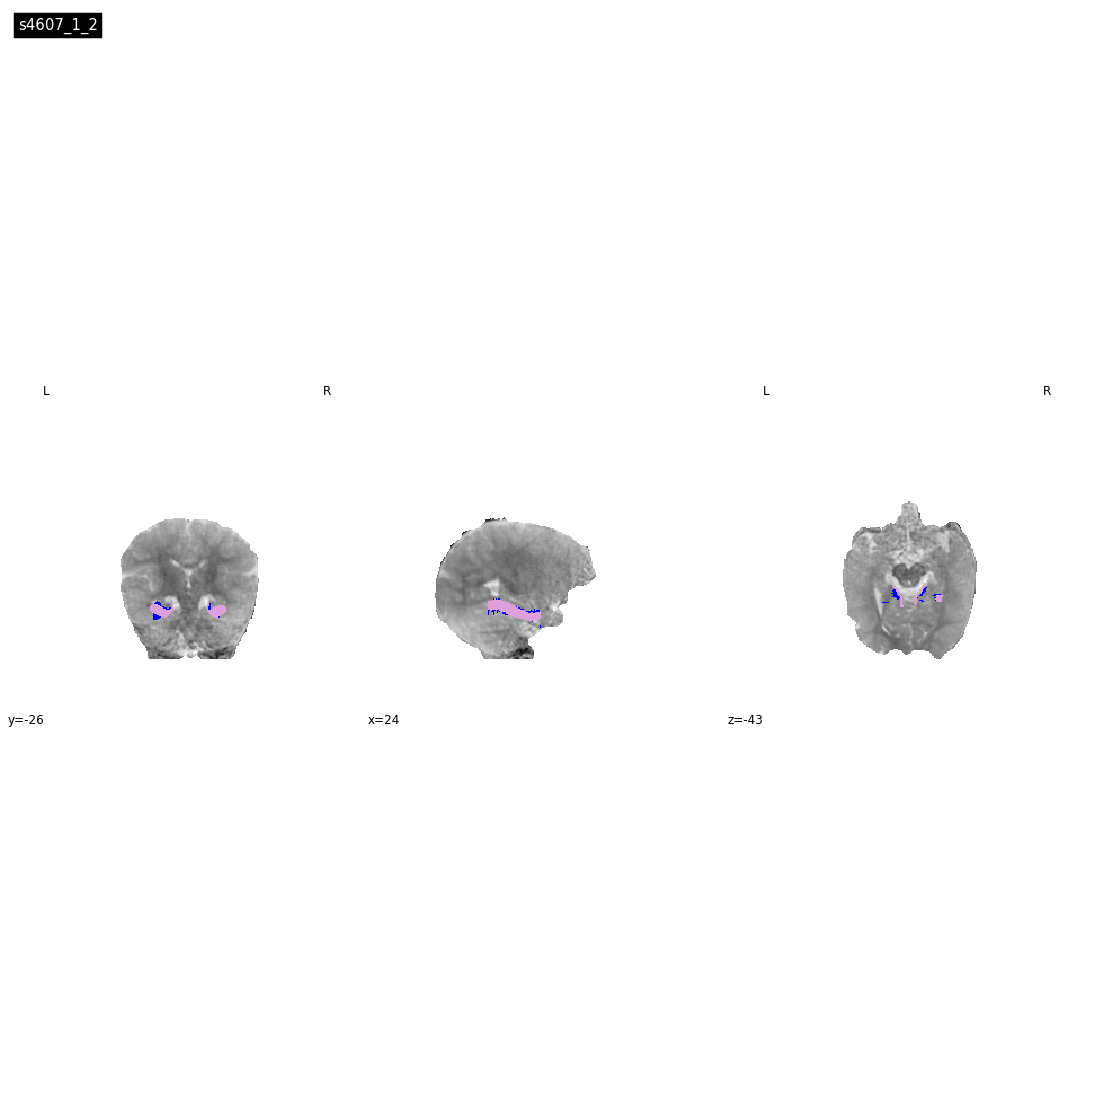

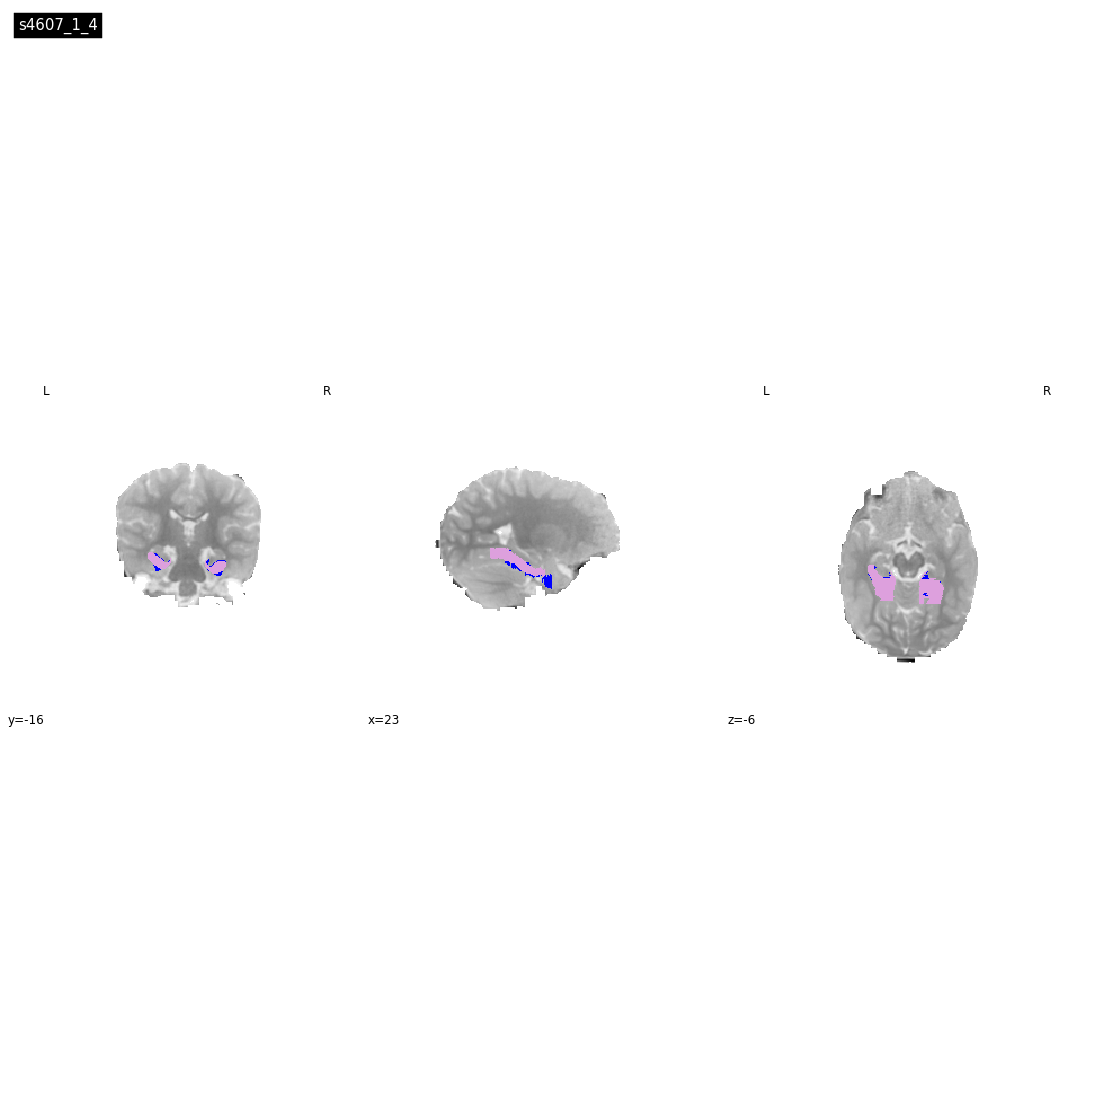

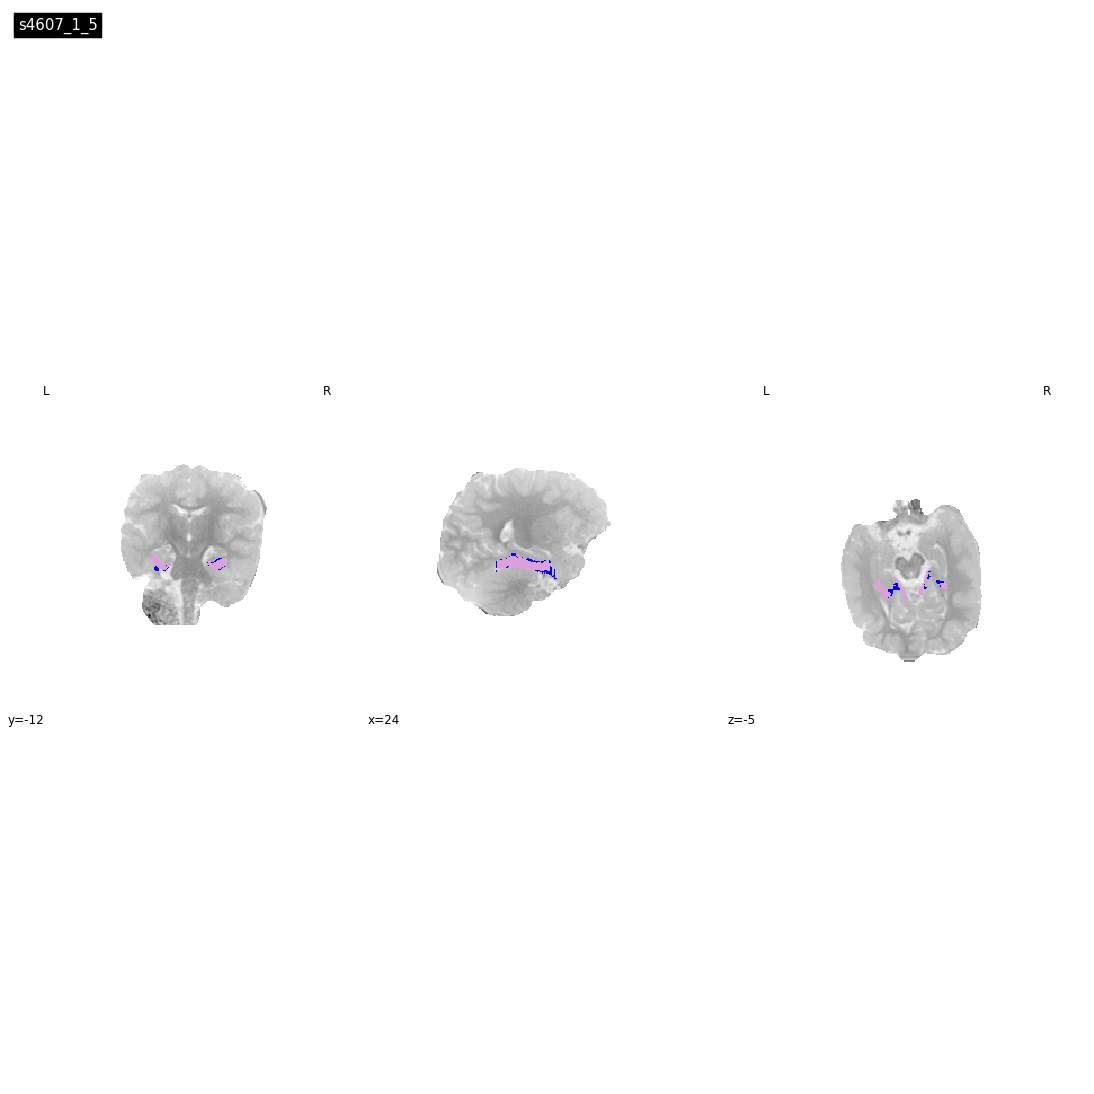

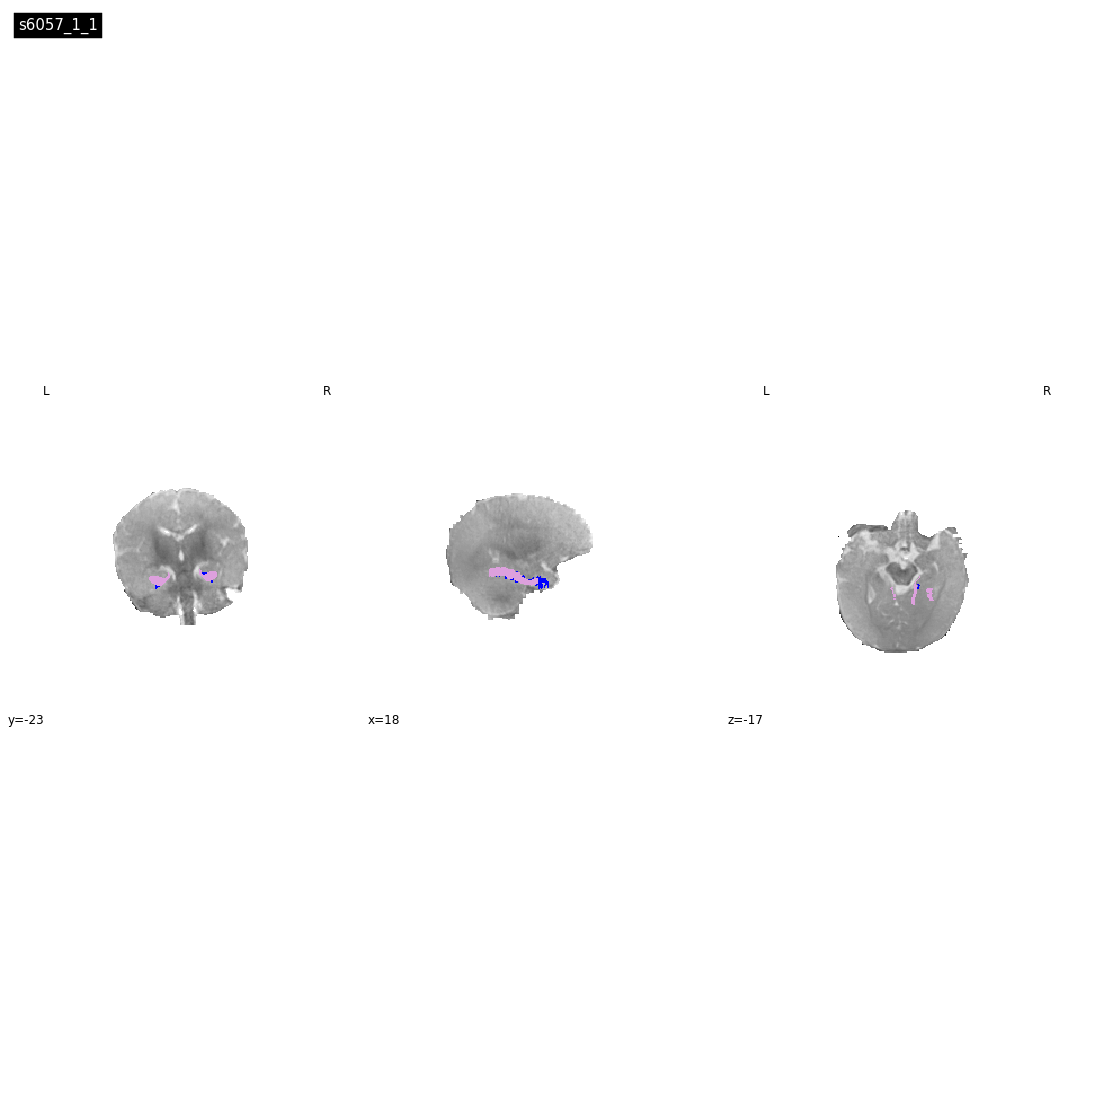

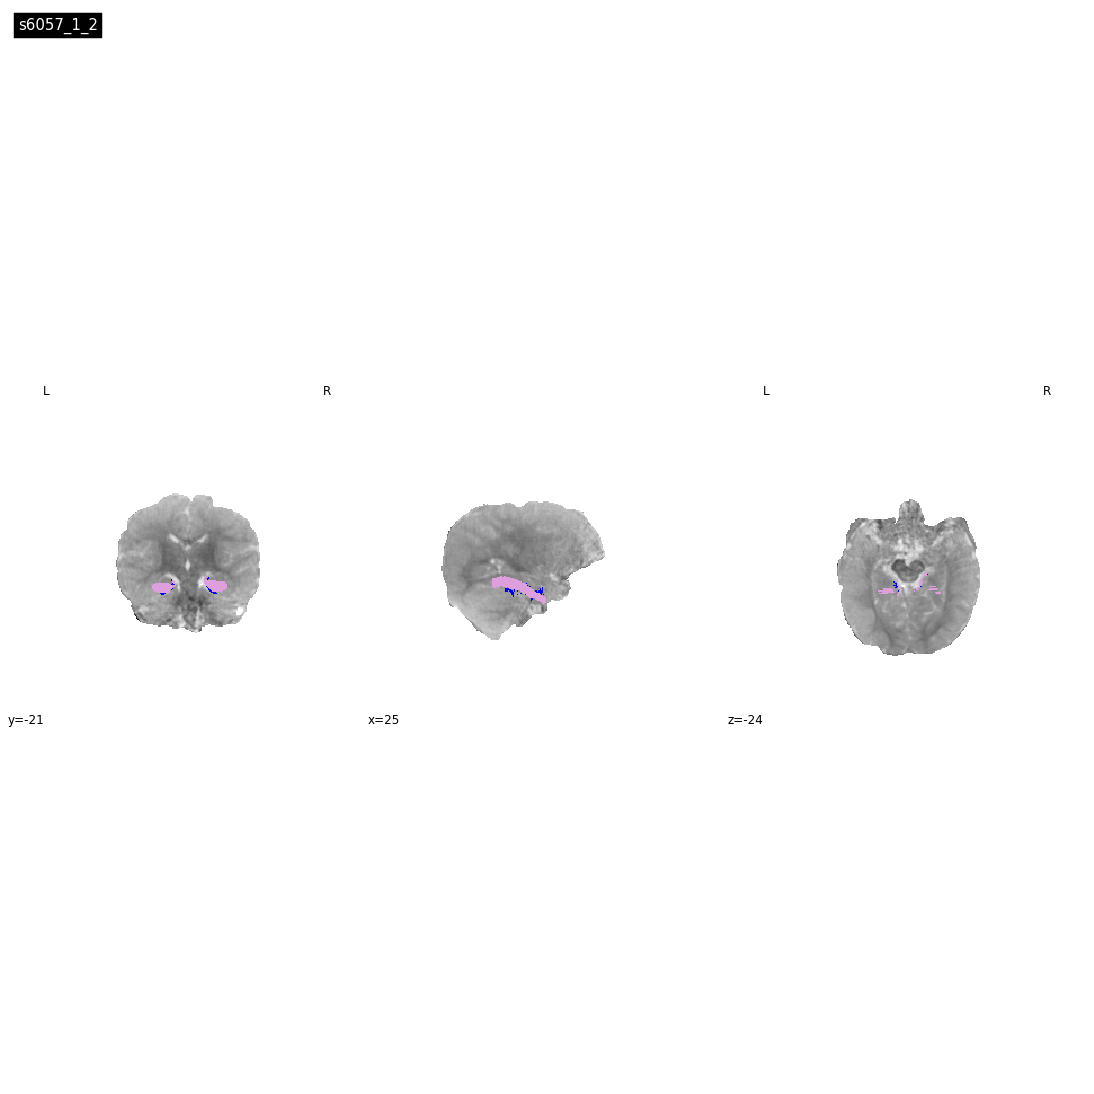

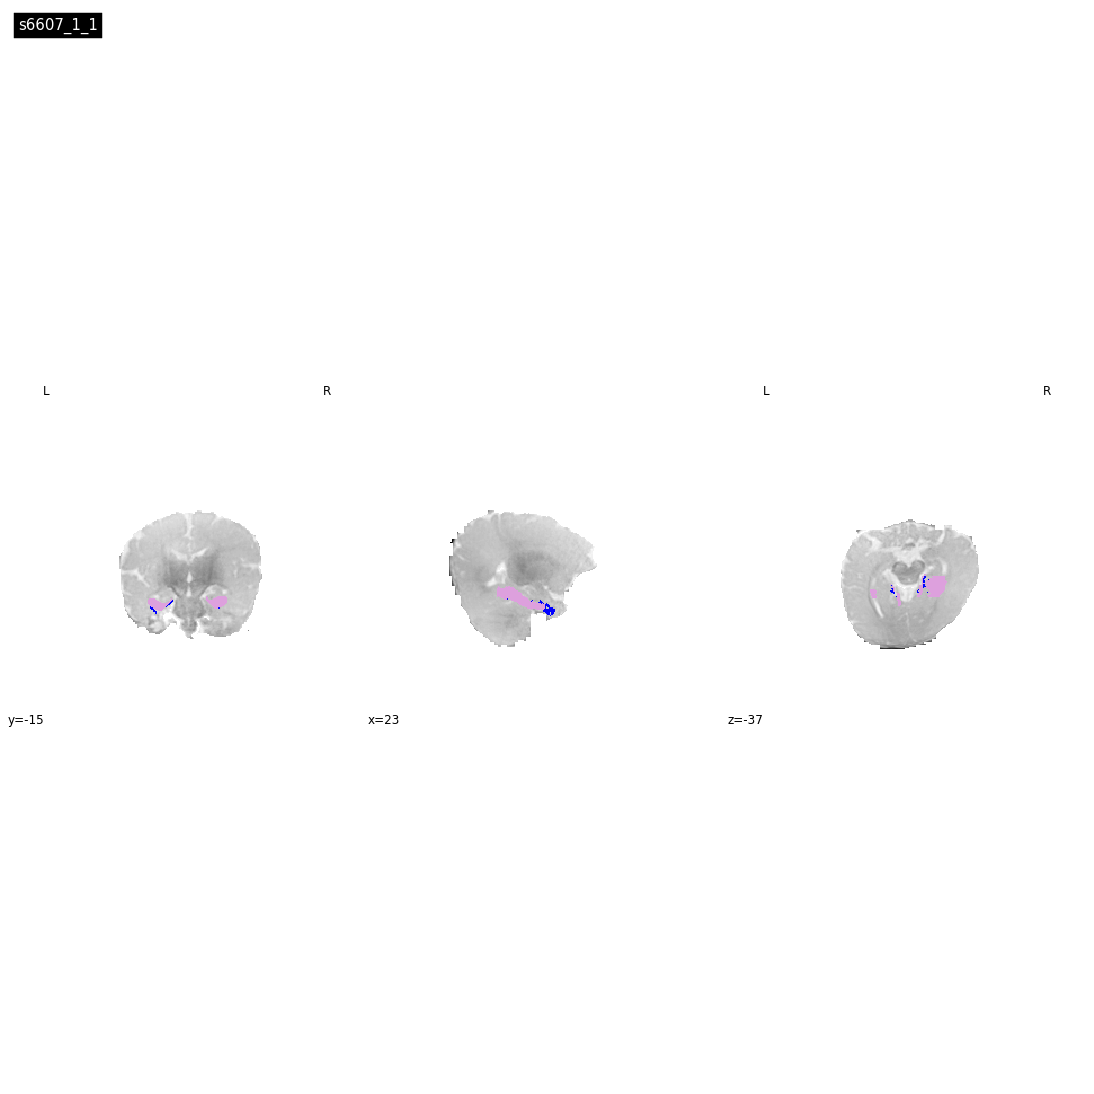

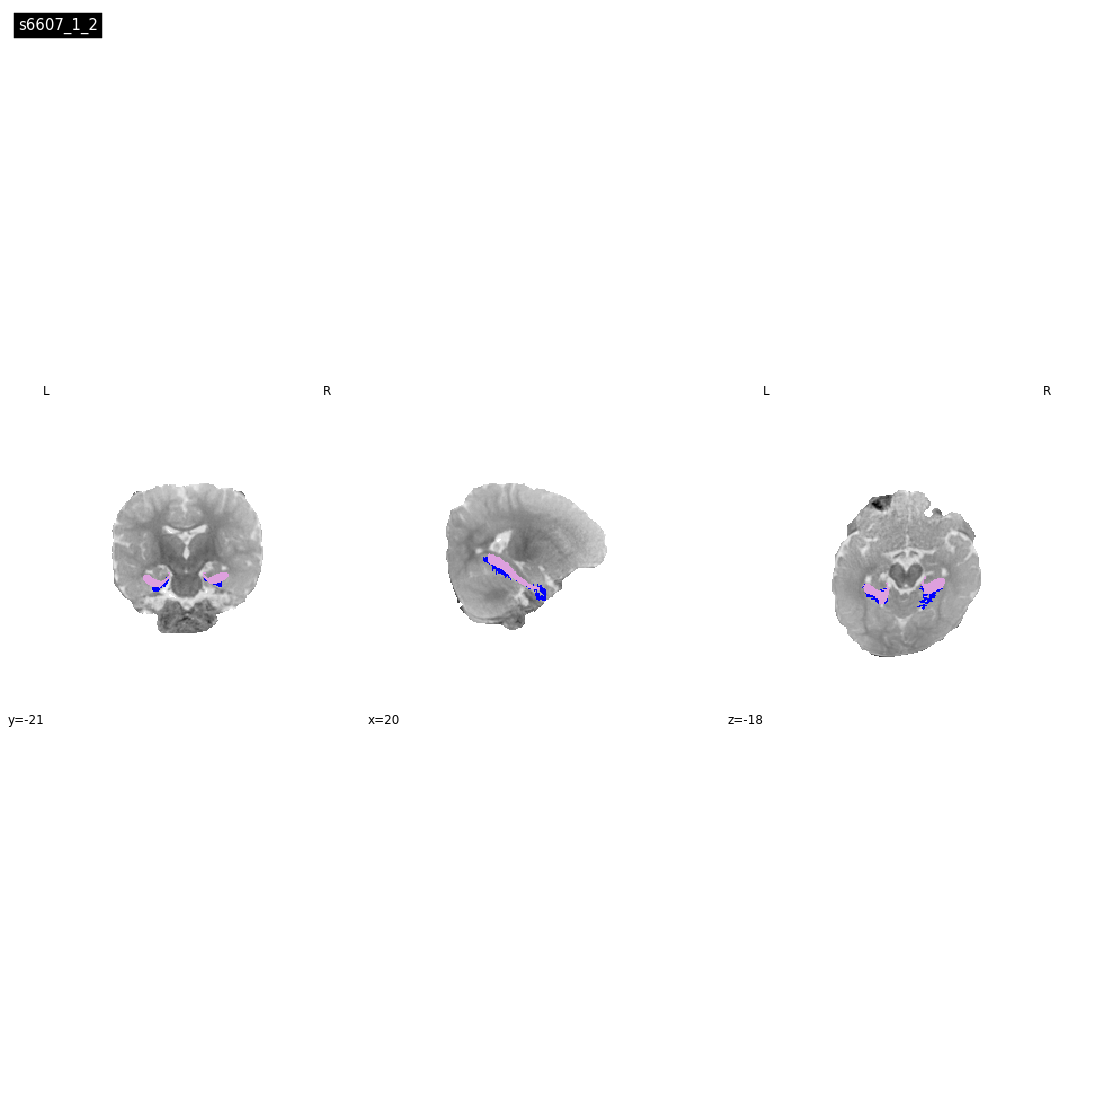

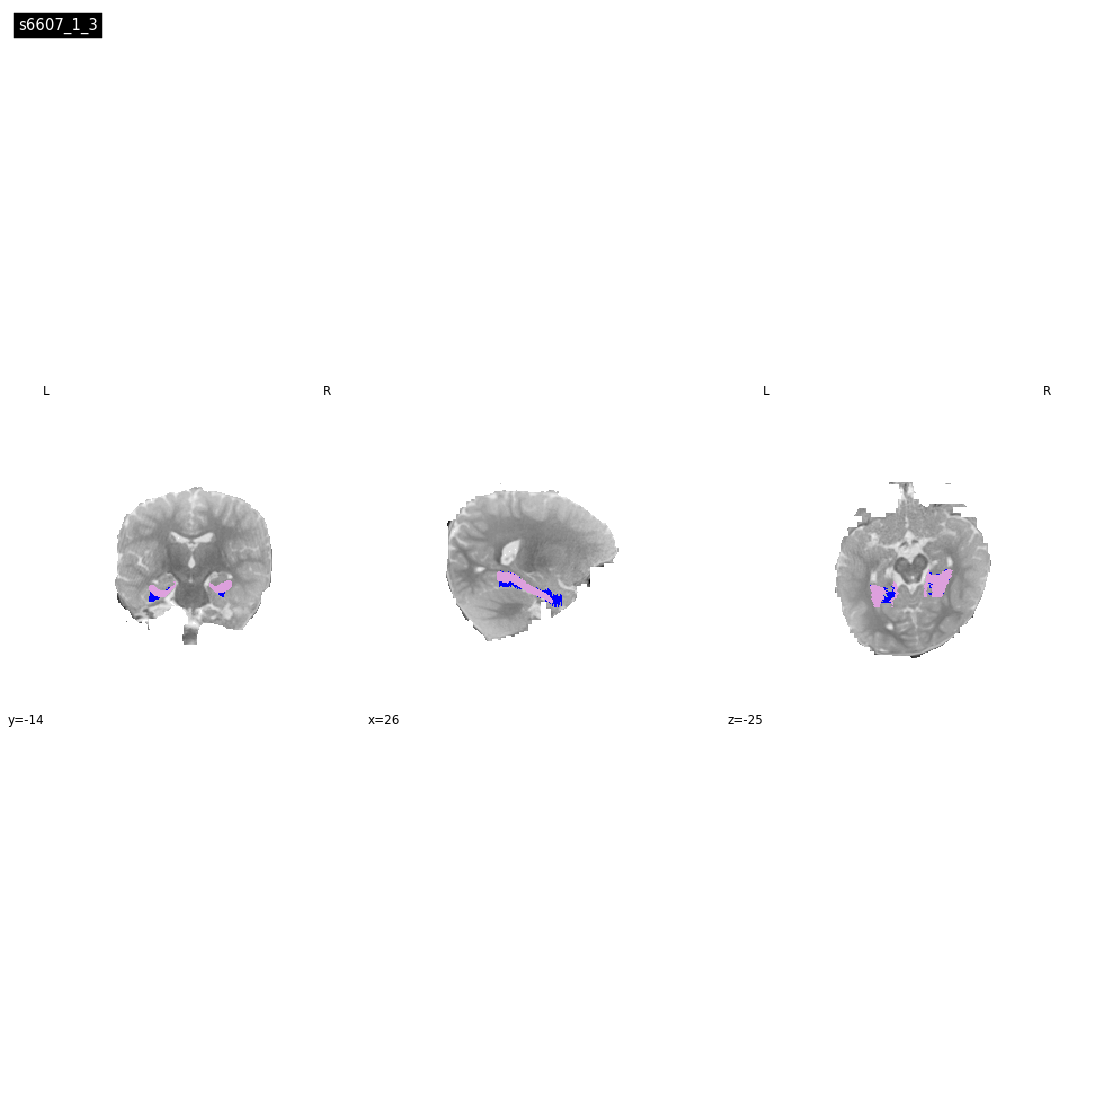

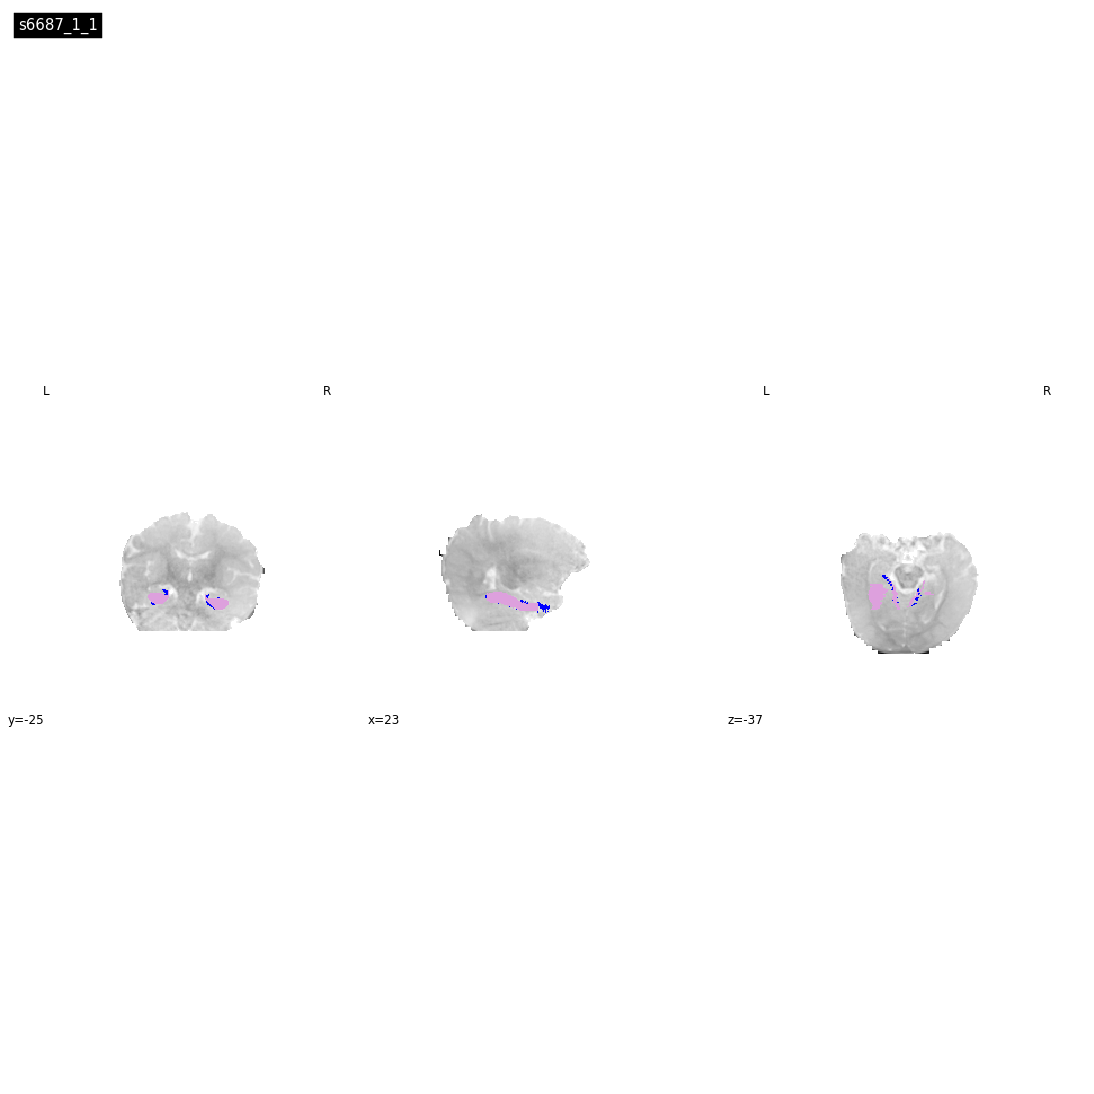

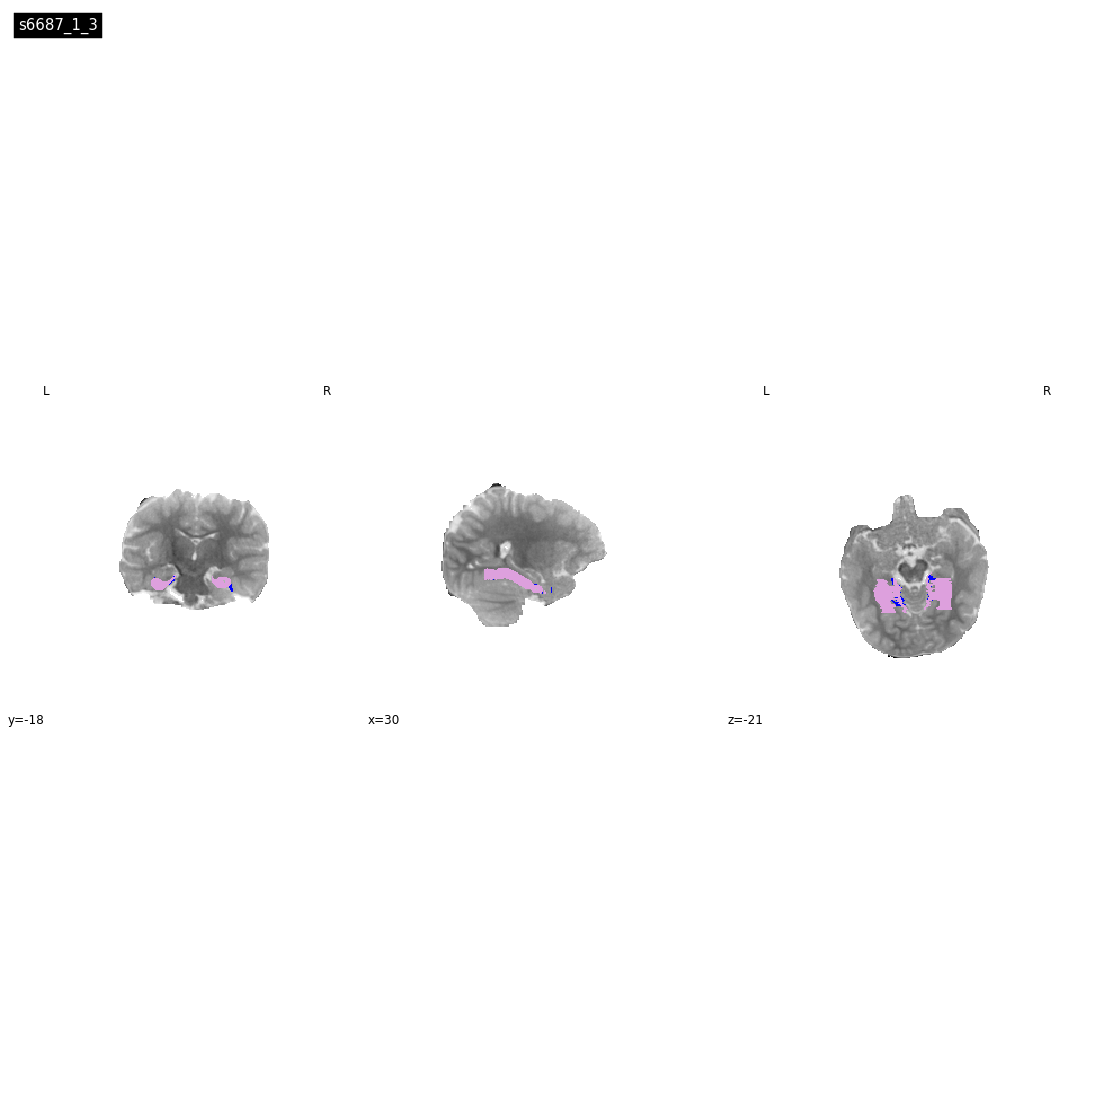

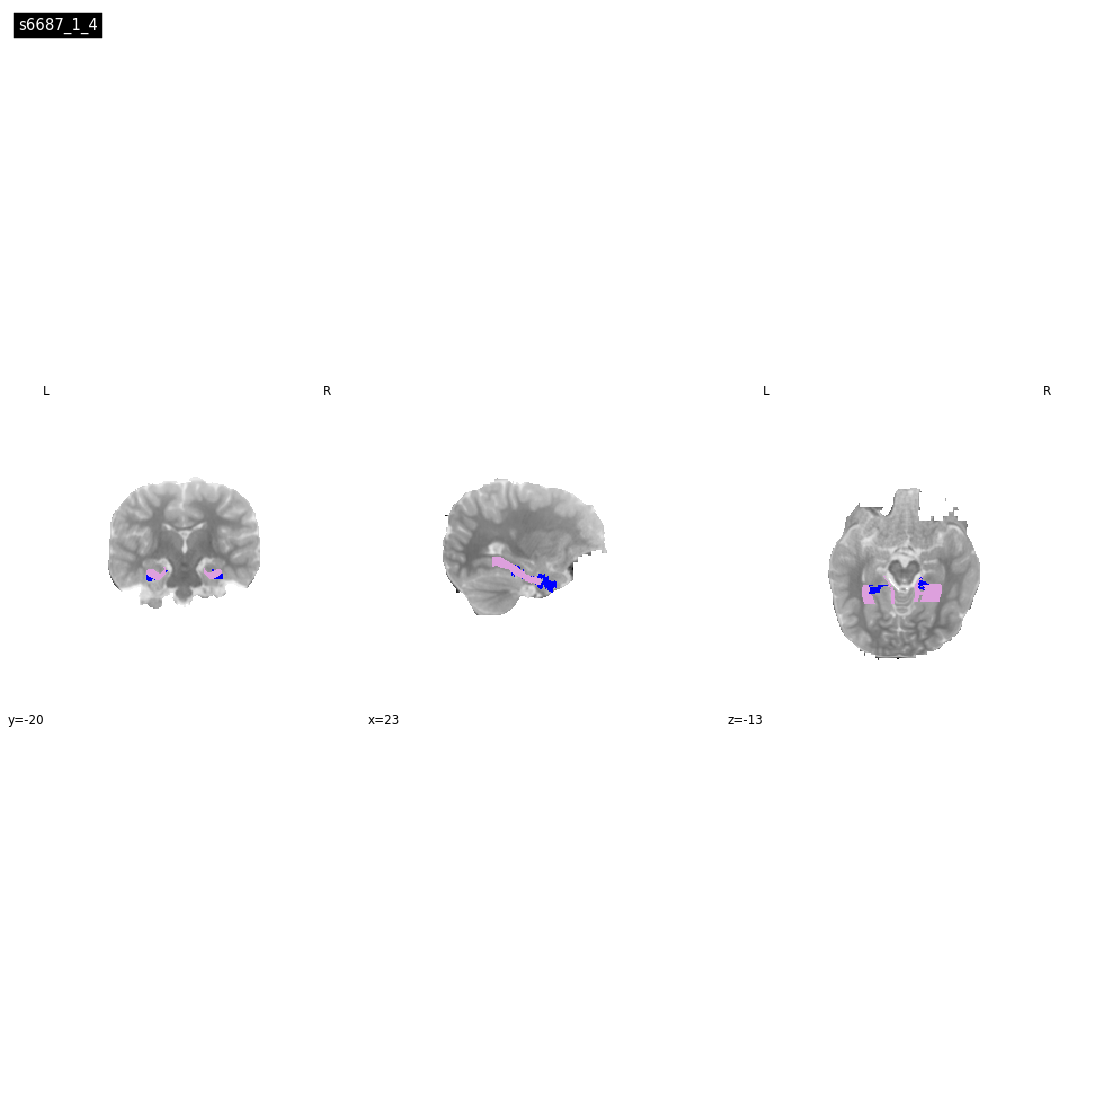

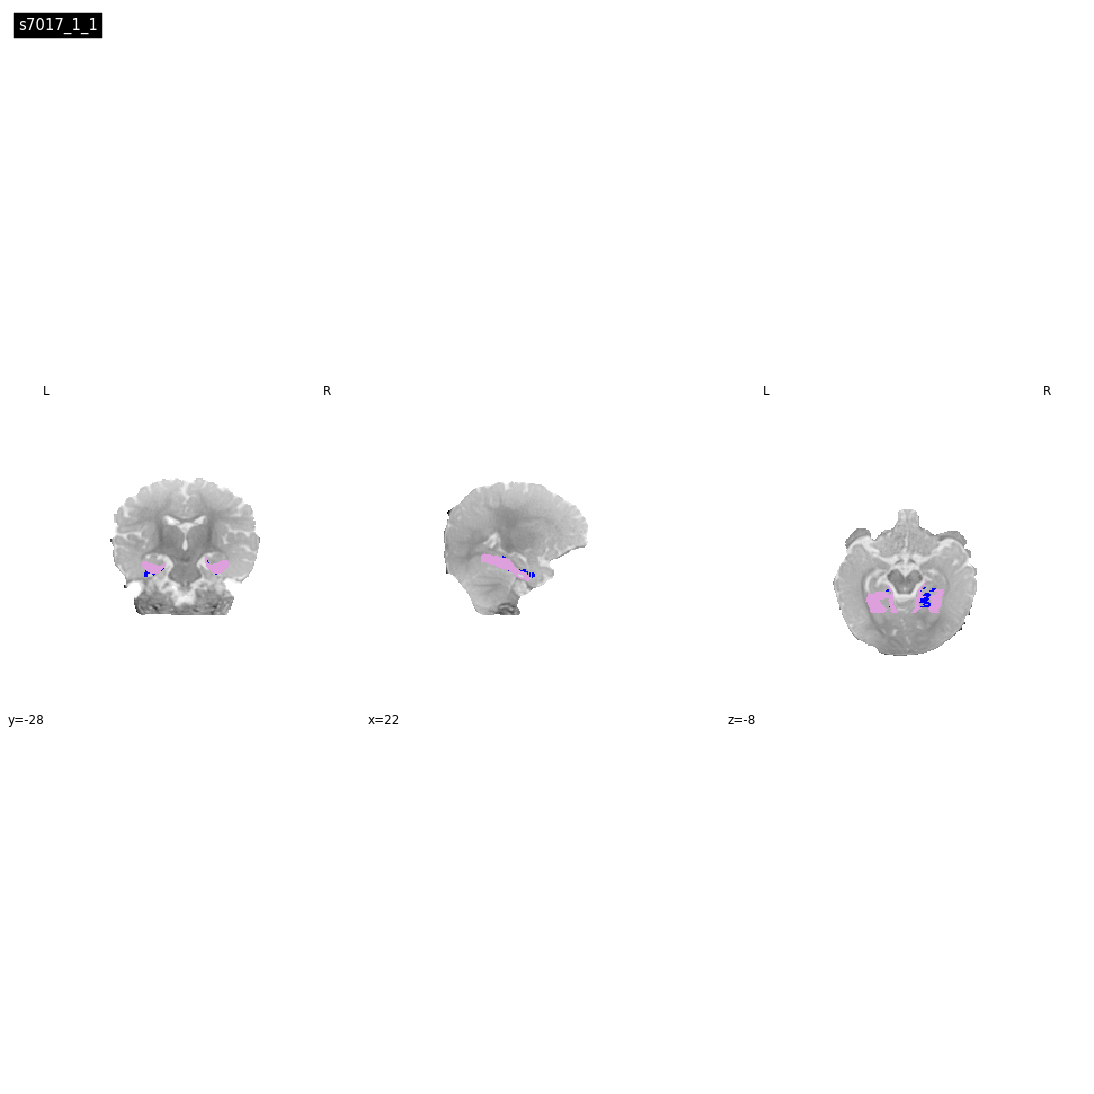

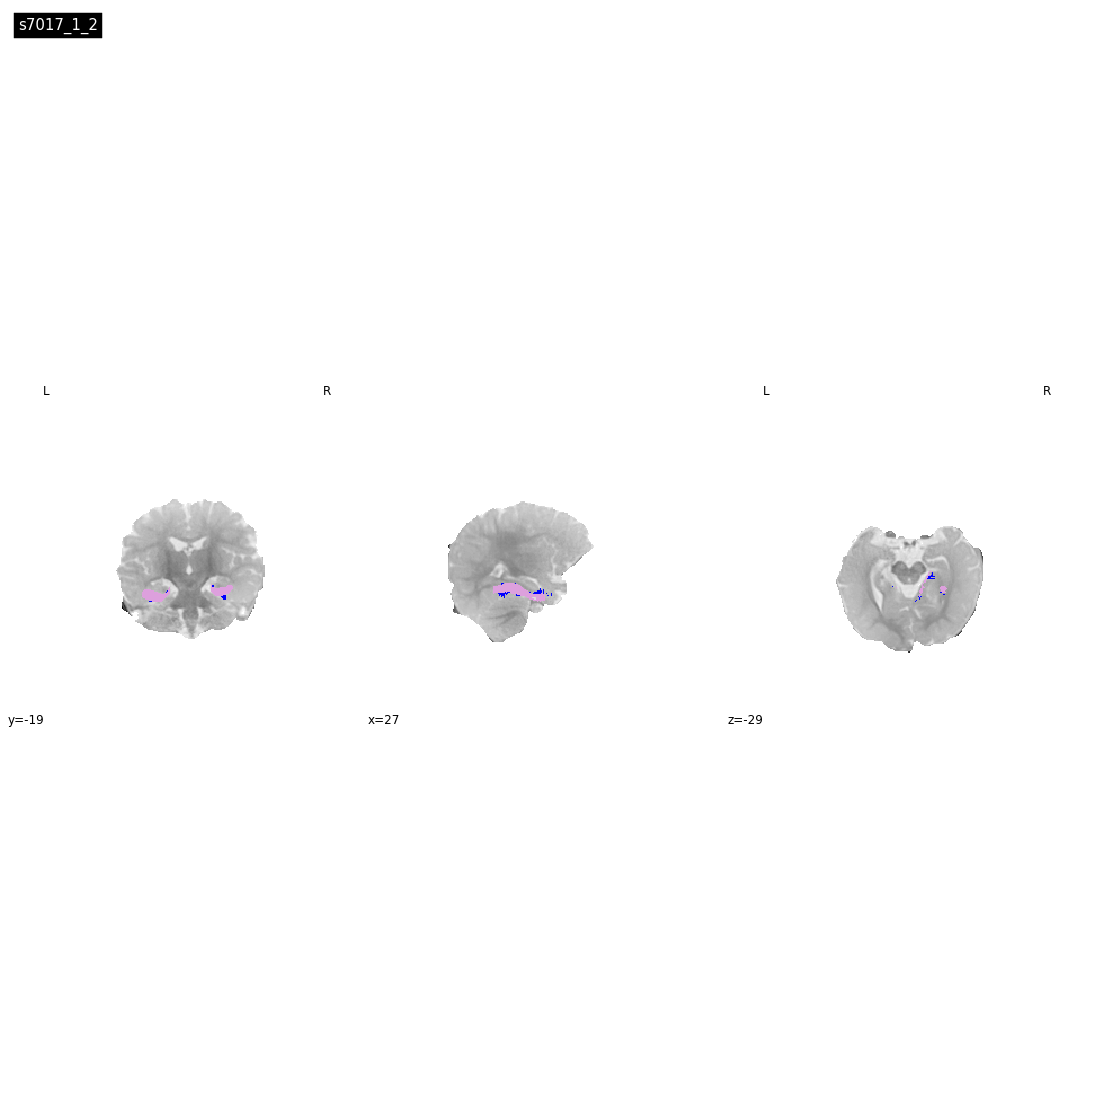

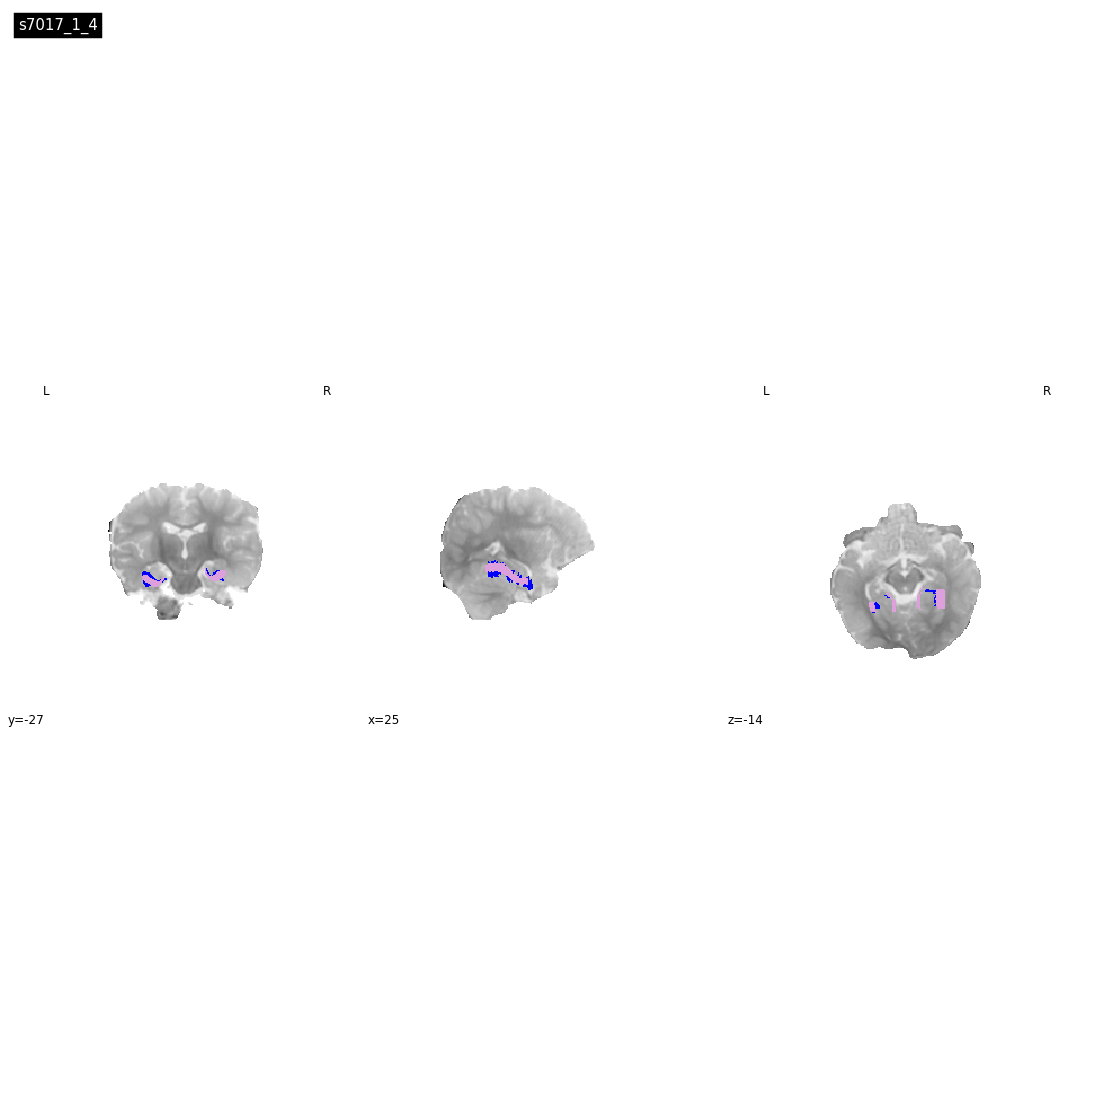

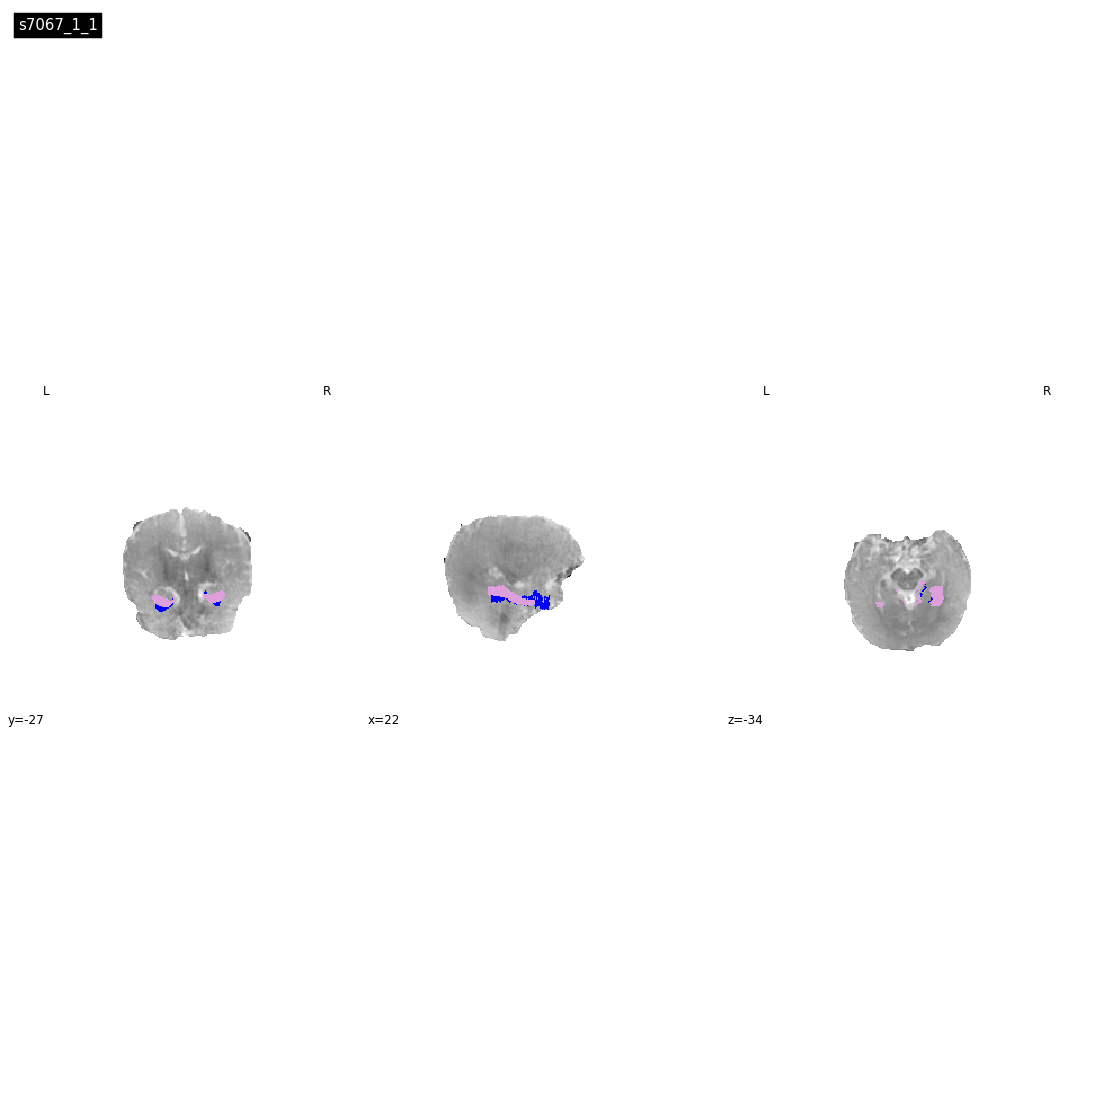

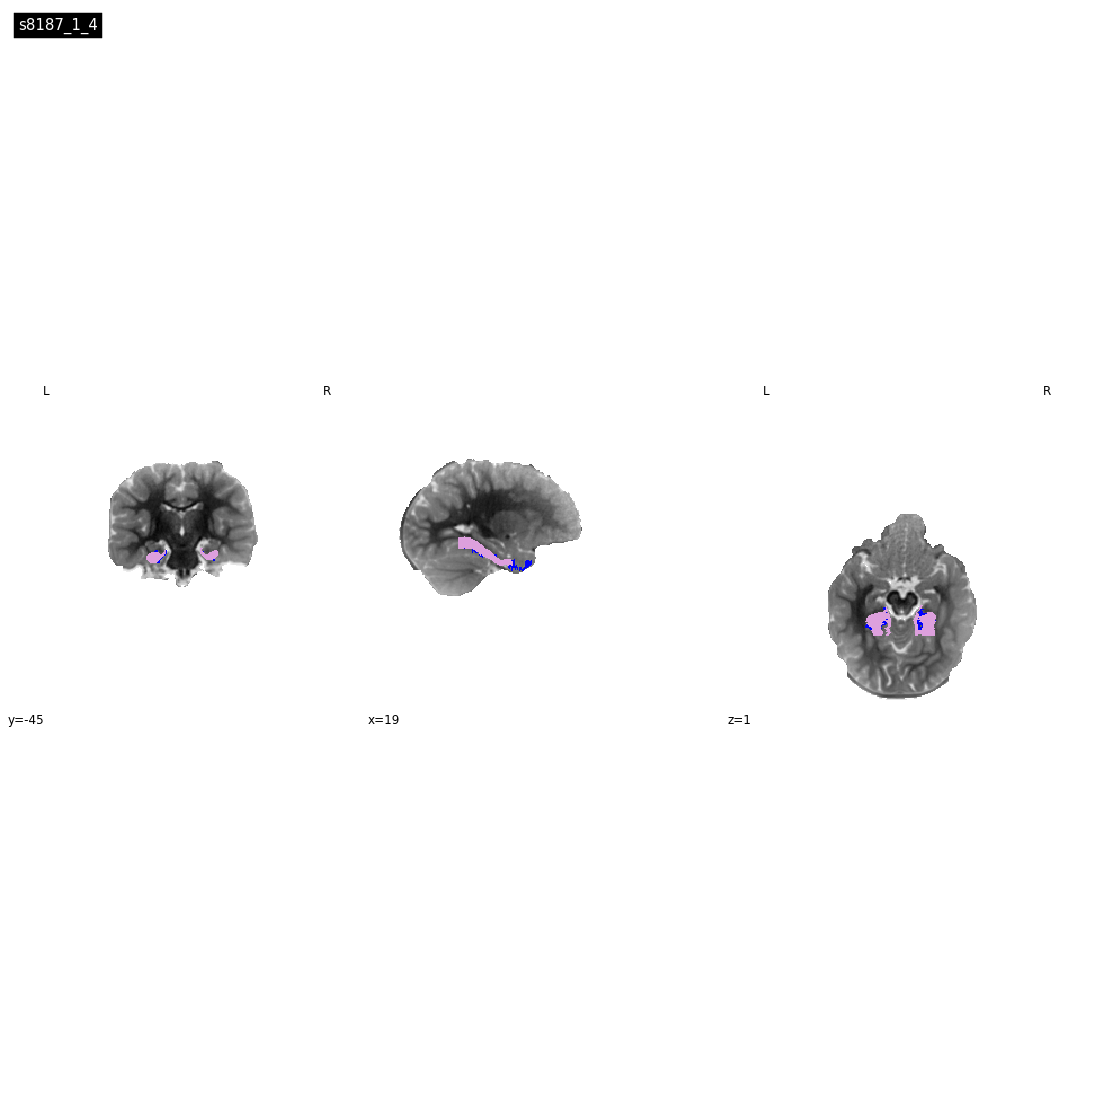

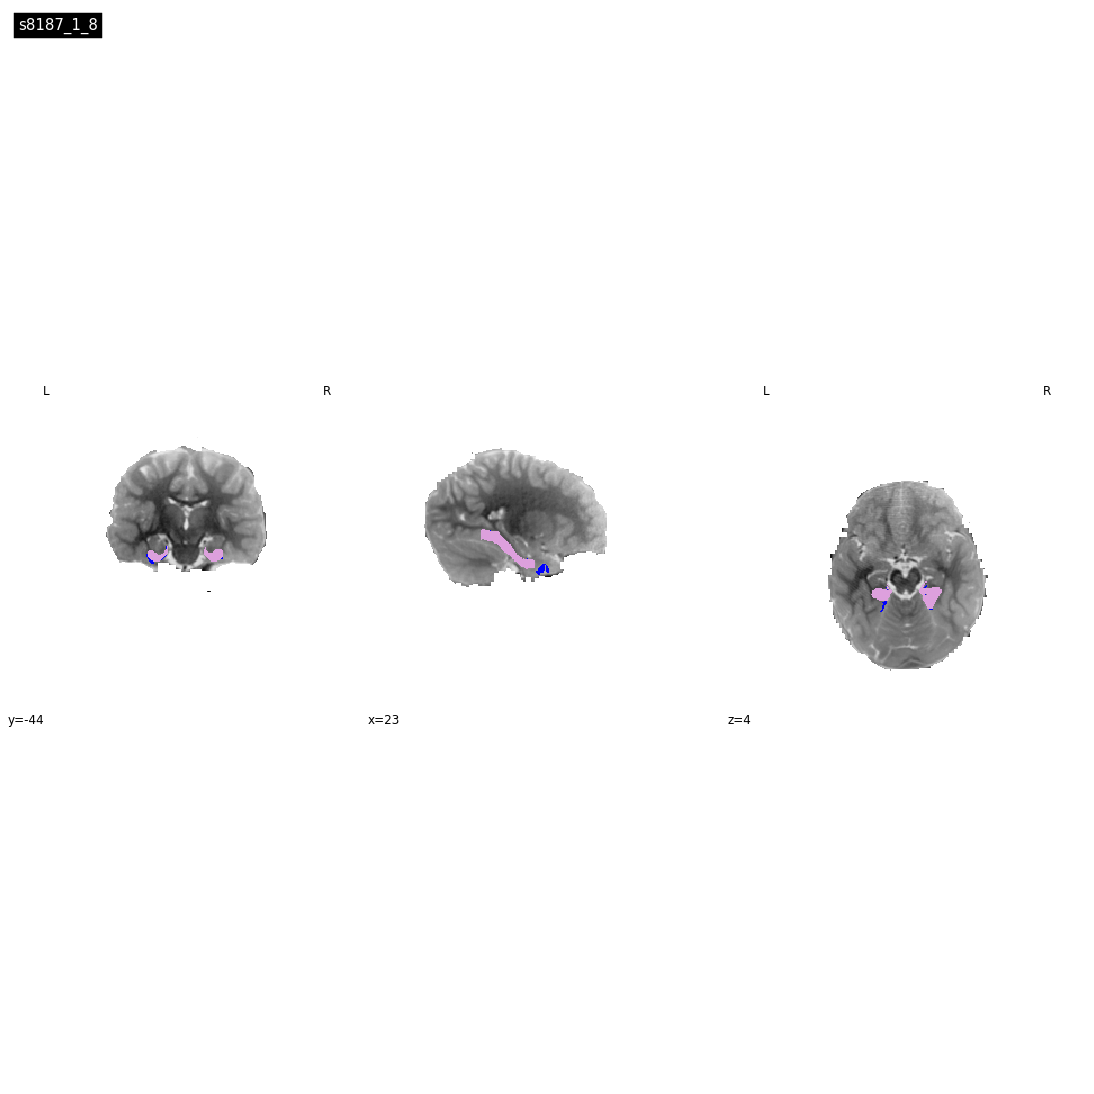

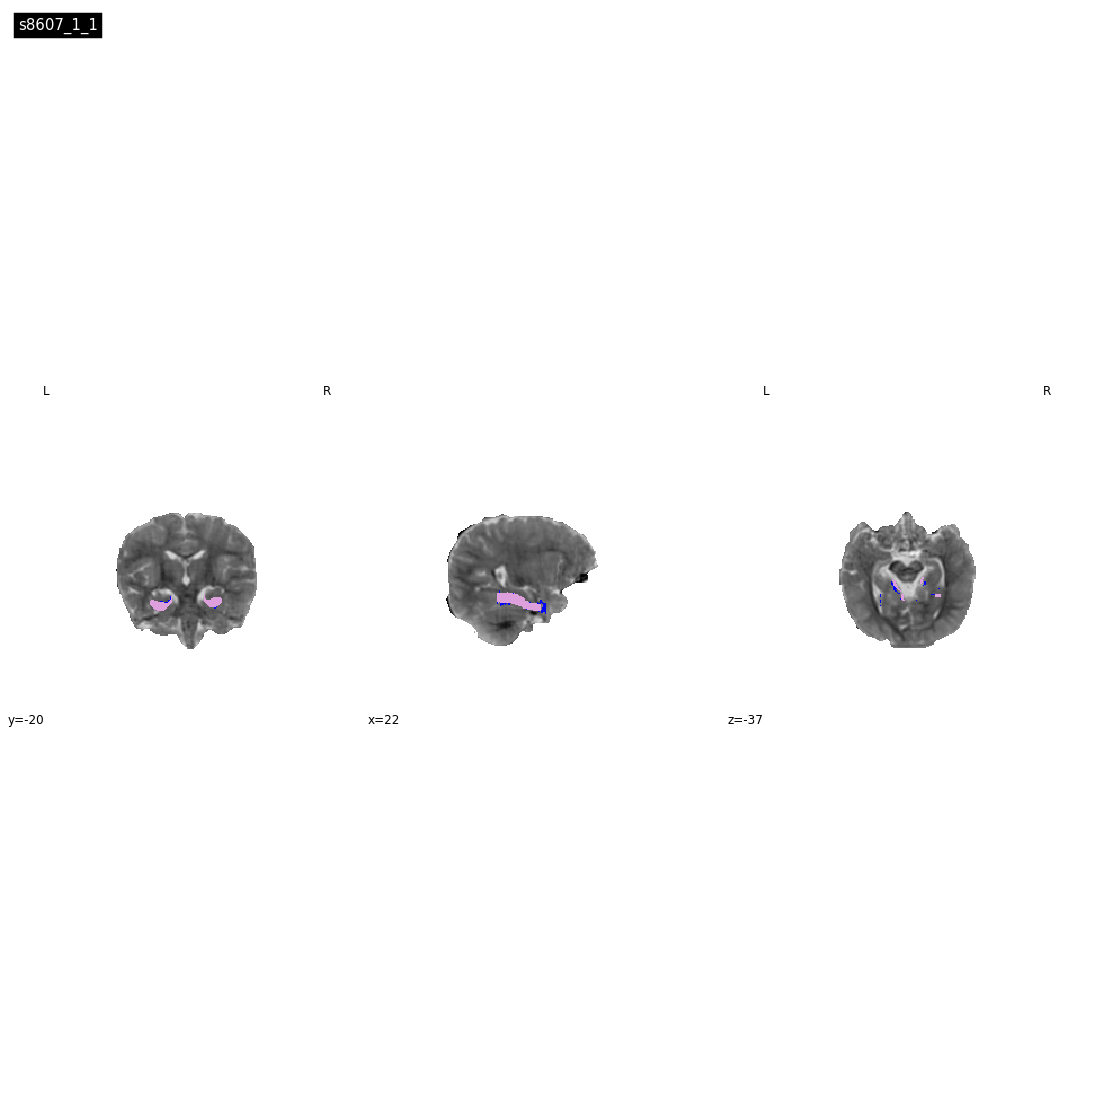

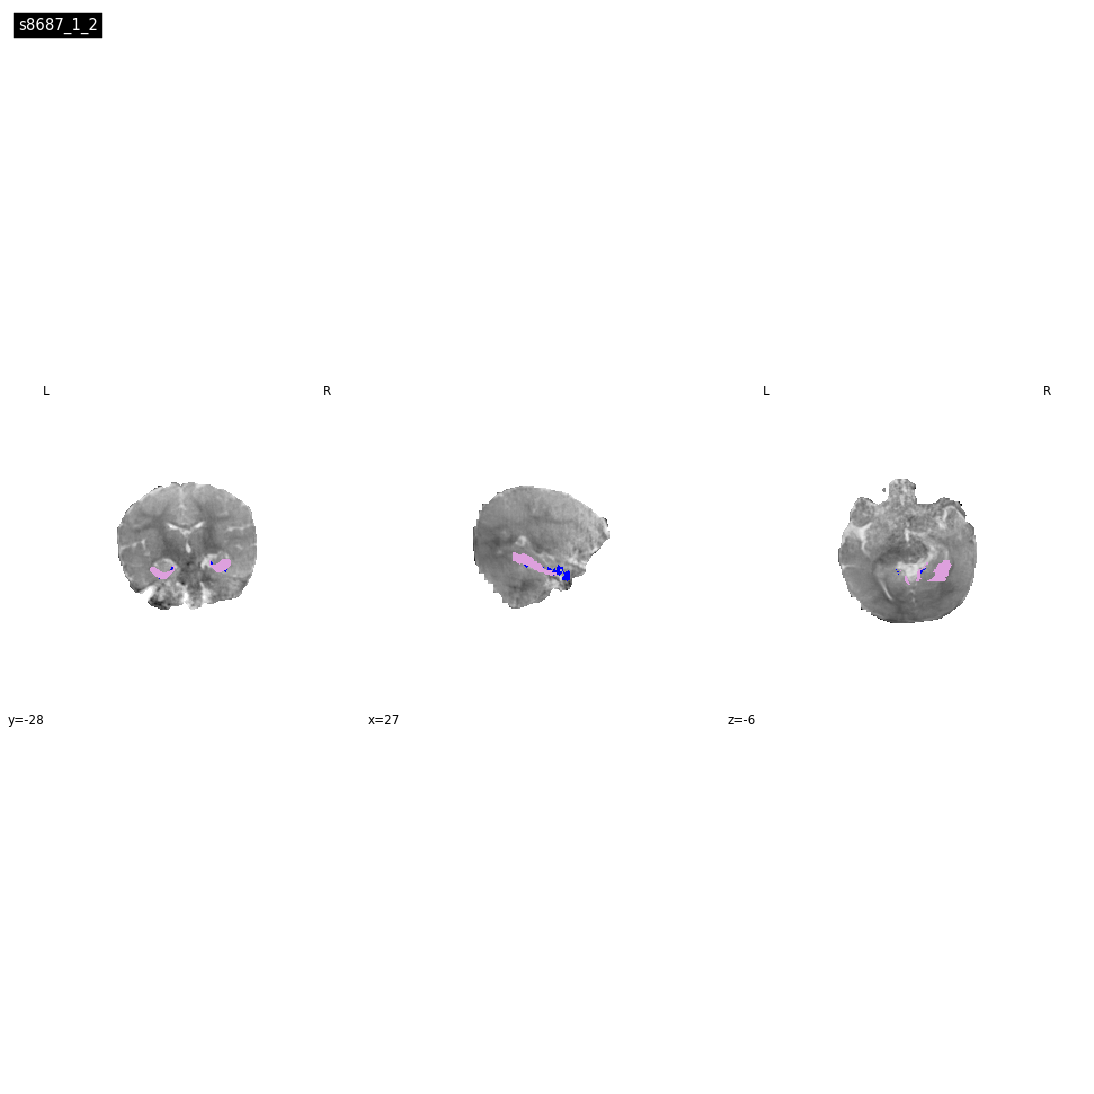

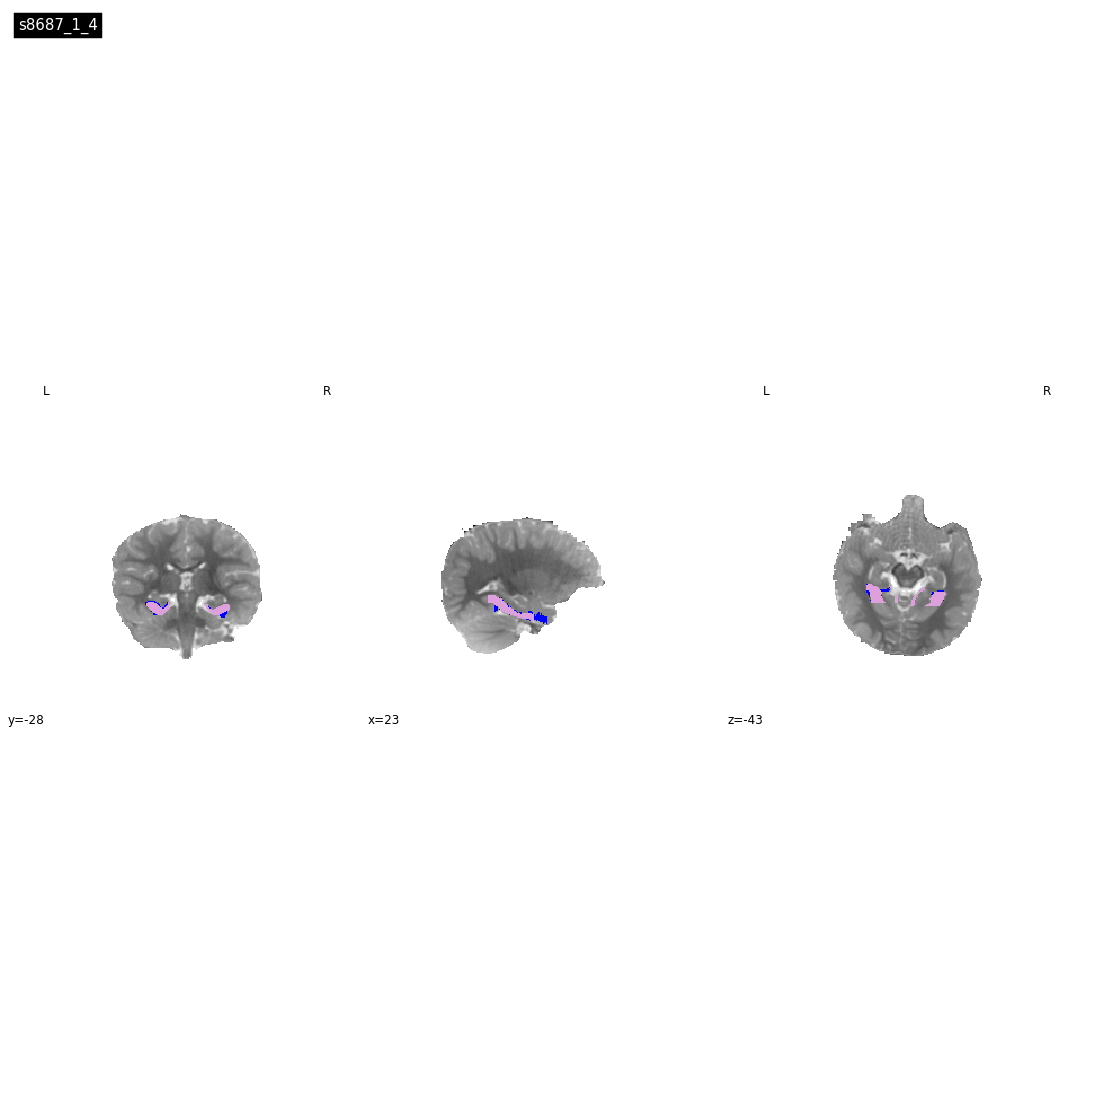

In [39]:
# Plot the data    
for ppt in ppt_names:
    
    plot_manual_ROI(ppt, MTL = True)

### MTL Inter-Rater Reliability <a class="anchor" id="section_3_1"></a>
In order to determine what the MTL IRR was, Dice values between the 42 corresponding participants that CE and JF segmented were calculated.

In [17]:
# Measure the IRR of the MTL data between the two raters
inter_rater_reliability_MTL = dice_compare(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF, 'Inter_Rater_Reliability', 'IRR', HPC=False)

IRR MTL Dice=0.52 (SD=0.09, range=0.32-0.70)


### Repeat vs Control Analysis <a class="anchor" id="section_3_2"></a>
We now compare our repeat Dice values (HPC and MTL) acquired from both linearly and nonlinearly aligned participants with control Dice values

Age Match Error = 0.31 (SD=0.38; Range=0.00—1.40)

Nonlinear vs Linear Repeats Approximating CE HPC: M=0.16, CI=[0.123, 0.189], p=0.000, 58 scan improvement from nonlinear alignment

Nonlinear vs Linear Repeats Approximating JF HPC: M=0.20, CI=[0.169, 0.241], p=0.000, 56 scan improvement from nonlinear alignment



Brain Region                          Linear Repeat Sample Mean  \
0       CE HPC  Dice=0.45, SD=0.13, range=0.13-0.70 (r=-0.39, ...   
1       JF HPC  Dice=0.39, SD=0.14, range=0.10-0.68 (r=-0.27, ...   
2       CE MTL  Dice=0.42, SD=0.11, range=0.21-0.66 (r=-0.25, ...   
3       JF MTL  Dice=0.53, SD=0.12, range=0.33-0.78 (r=-0.16, ...   

                          Linear Control Sample Mean  \
0  Dice=0.39, SD=0.11, range=0.16-0.62 (r=0.10, p...   
1  Dice=0.32, SD=0.10, range=0.07-0.56 (r=0.13, p...   
2  Dice=0.35, SD=0.08, range=0.13-0.54 (r=0.14, p...   
3  Dice=0.48, SD=0.10, range=0.15-0.65 (r=0.22, p...   

                    Linear Difference Brain Region  \
0   M=0.06, p=0.003, C.I.=0.020-0.092       CE HPC   
1   M=0.07, p=0.000, C.I.=0.038-0.110       JF HPC   
2  M= 0.06, p=0.000, C.I.=0.039-0.089       CE MTL   
3   M=0.05 (p=0.001, C.I.=0.020-0.080       JF MTL   

                        Nonlinear Repeat Sample Mean  \
0  Dice=0.60, SD=0.08, range=0.45-0.76 (r=-0.10, ...   
1  Dice=0.60, SD=0.07, range=0.43-0.72 (r=0.16, p...   
2  Dice=0.49, SD=0.09, range=0.23-0.68 (r=-0.19, ...   
3  Dice=0.65, SD=0.06, range=0.44-0.77 (r=0.11, p...   

                       Nonlinear Control Sample Mean  \
0  Dice=0.51, SD=0.07, range=0.28-0.63 (r=-0.15, ...   
1  Dice=0.47, SD=0.07, range=0.28-0.60 (r=-0.08, ...   
2  Dice=0.41, SD=0.08, range=0.27-0.62 (r=-0.25, ...   
3  Dice=0.57, SD=0.07, range=0.38-0.71 (r=-0.08, ...   

                 Nonlinear Difference  
0   M=0.10, p=0.000, C.I.=0.077-0.116  
1   M=0.13, p=0.000, C.I.=0.105-0.148  
2  M= 0.08, p=0.000, C.I.=0.058-0.101  
3   M=0.08 (p=0.000, C.I.=0.062-0.098

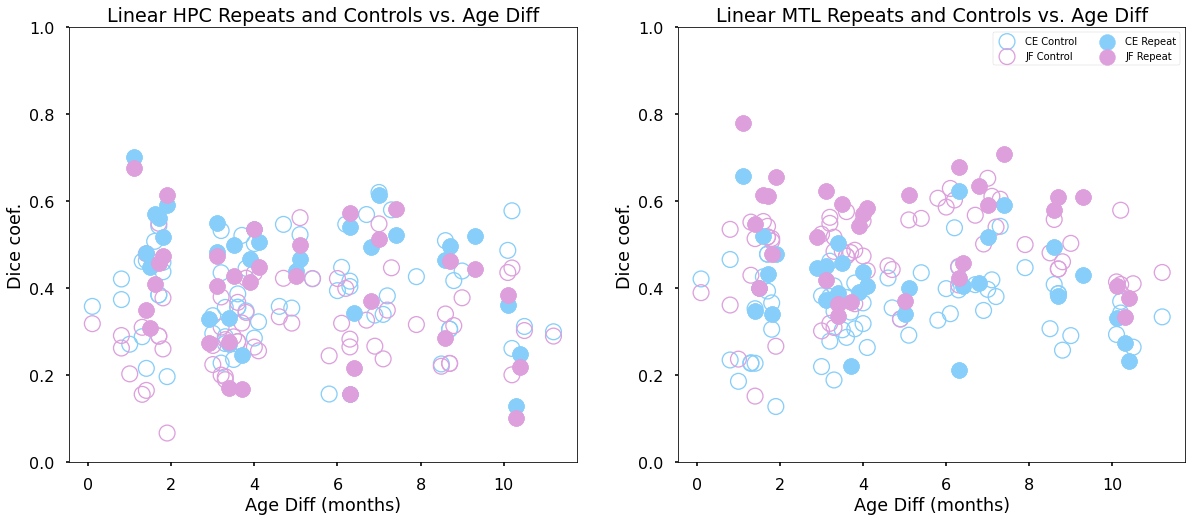

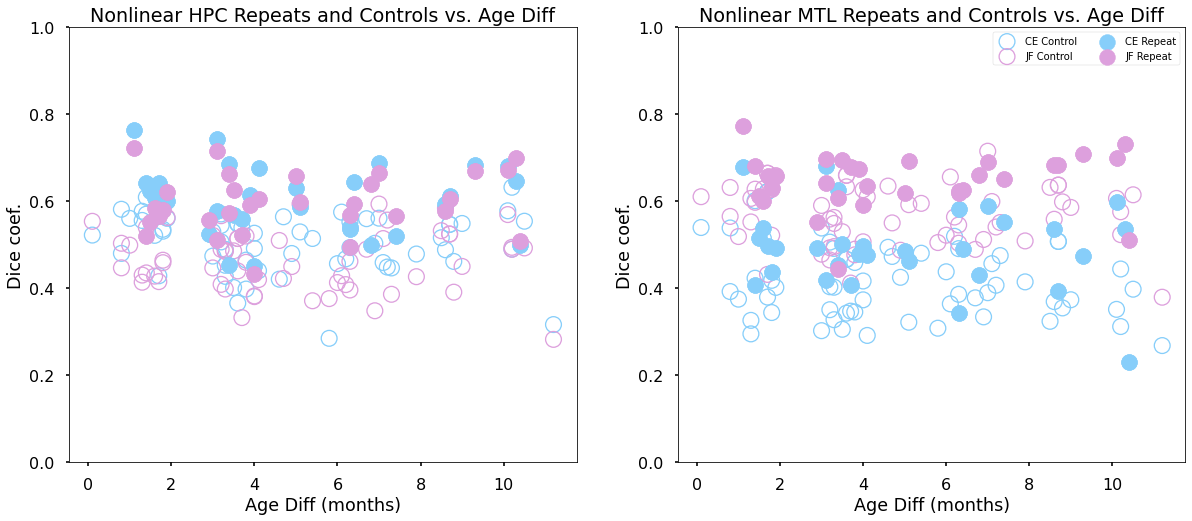

In [18]:
# Generate a table comparing linear repeat HPC/MTL Dice averages with corresponding control Dice averages
CE_linear_repeat_sample_HPC, CE_linear_lower_bound_HPC, CE_linear_repeat_sample_MTL, CE_linear_lower_bound_MTL, JF_linear_repeat_sample_HPC, JF_linear_lower_bound_HPC, JF_linear_repeat_sample_MTL, JF_linear_lower_bound_MTL, Repeats_Controls_Linear_Table, match_error = repeat_test(ordered_files_segmentations_linear_CE, ordered_files_segmentations_linear_JF, out_dir_segmentations_linear, 'Linear', HPC=False)

# Generate a nonlinear table with the repeat and control Dice averages
CE_nonlinear_repeat_sample_HPC, CE_nonlinear_lower_bound_HPC, CE_nonlinear_repeat_sample_MTL, CE_nonlinear_lower_bound_MTL, JF_nonlinear_repeat_sample_HPC, JF_nonlinear_lower_bound_HPC, JF_nonlinear_repeat_sample_MTL, JF_nonlinear_lower_bound_MTL, Repeats_Controls_Nonlinear_Table, match_error = repeat_test(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF, out_dir_segmentations_nonlinear, 'Nonlinear', HPC=False)

# Print the match error in age between pairs of repeat and control ppts
print('Age Match Error = %0.2f' % np.mean(abs(match_error)) + ' (SD=%0.2f'% stdev(abs(match_error)) + '; Range=%0.2f'% np.min(abs(match_error)) + '—%0.2f)'% np.max(abs(match_error))), print()

# Compare CE's nonlinear vs linear repeats approximating HPC
p_val, sign_count, CIs = randomise_diff(CE_nonlinear_repeat_sample_HPC - CE_linear_repeat_sample_HPC)
print('Nonlinear vs Linear Repeats Approximating CE HPC: M=%0.2f'% np.mean(CE_nonlinear_repeat_sample_HPC - CE_linear_repeat_sample_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()

# Compare JF's nonlinear vs linear repeats approximating HPC
p_val, sign_count, CIs = randomise_diff(JF_nonlinear_repeat_sample_HPC - JF_linear_repeat_sample_HPC)
print('Nonlinear vs Linear Repeats Approximating JF HPC: M=%0.2f'% np.mean(JF_nonlinear_repeat_sample_HPC - JF_linear_repeat_sample_HPC) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()
 
# Combine the linear and nonlinear tables
pd.concat([Repeats_Controls_Linear_Table.reset_index(drop=1), Repeats_Controls_Nonlinear_Table.reset_index(drop=1)], axis=1).fillna('')

### Average Infant Template MTL Analysis <a class="anchor" id="section_3_3"></a>

Analyze how well an average infant anatomical template, constructed via linearly and nonlinearly aligning infant data to standard space, predicted the manual MTL data of the two raters (no adult MTL data was made avaialble to us by Harvard-Oxford) 

Linear Average Infant Approximating CE MTL: Dice=0.39, SD=0.07, range=0.20-0.54)
Linear Average Infant vs JF Approximating CE MTL: M=-0.13, CI=[-0.158, -0.101], p=0.000, 2 scan improvement from IRR

Linear Average Infant Approximating JF MTL: Dice=0.46, SD=0.11, range=0.14-0.65
Linear Average Infant vs CE Approximating JF MTL: M=-0.05, CI=[-0.093, -0.016], p=0.005, 16 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

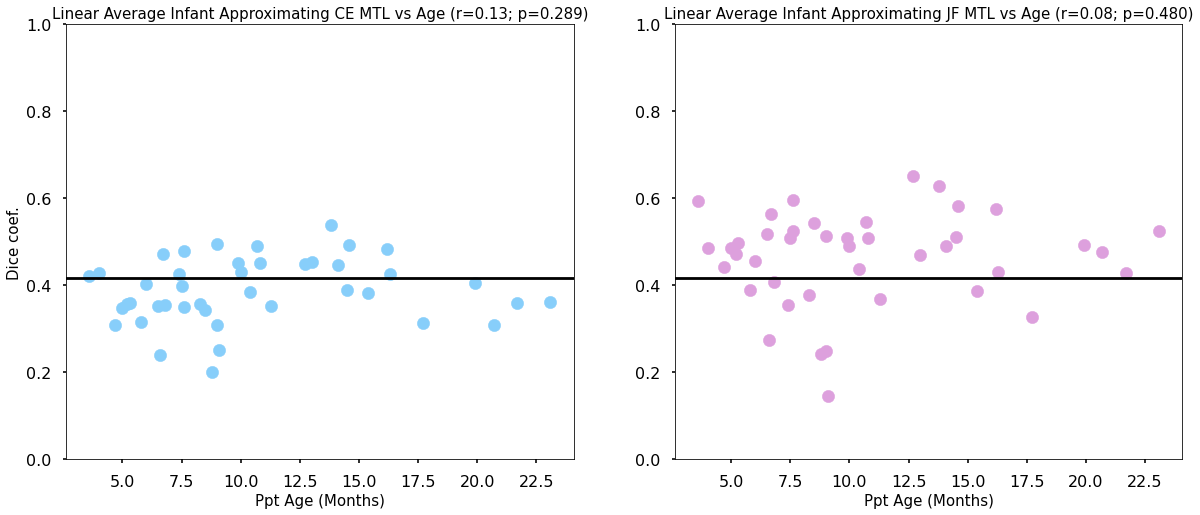

Nonlinear Average Infant Approximating CE MTL: Dice=0.50, SD=0.07, range=0.29-0.61)
Nonlinear Average Infant vs JF Approximating CE MTL: M=-0.02, CI=[-0.042, 0.000], p=0.055, 19 scan improvement from IRR

Nonlinear Average Infant Approximating JF MTL: Dice=0.59, SD=0.06, range=0.43-0.70
Nonlinear Average Infant vs CE Approximating JF MTL: M=0.08, CI=[0.049, 0.105], p=0.000, 33 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

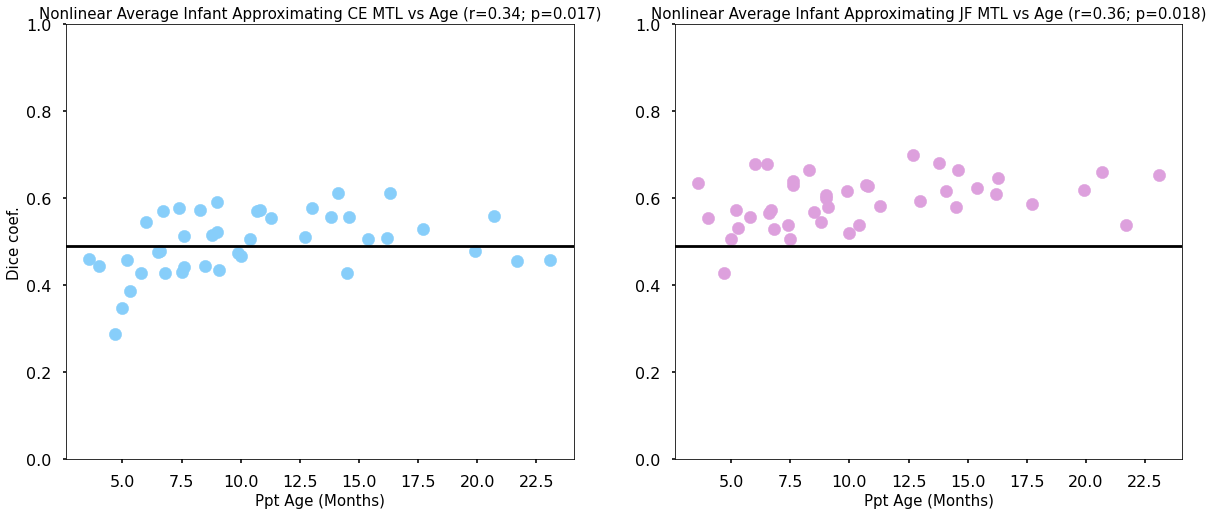

Nonlinear Infant vs Linear Infant Approximating CE MTL: M=0.11, CI=[0.085, 0.131], p=0.000, 41 scan improvement from nonlinear alignment

Nonlinear Infant vs Linear Infant Approximating JF MTL: M=0.13, CI=[0.102, 0.163], p=0.000, 40 scan improvement from nonlinear alignment



Brain Region                                 Linear Infant Dice  \
0       CE MTL  Dice=0.39 (IMP from IRR = 2, p=0.000, C.I.=-0....   
1       JF MTL  Dice=0.46 (IMP from IRR = 16, p=0.005, C.I.=-0...   

  Linear Infant Corr Brain Region  \
0    r=0.13, p=0.289       CE MTL   
1    r=0.08, p=0.480       JF MTL   

                               Nonlinear Infant Dice Nonlinear Infant Corr  
0  Dice=0.50 (IMP from IRR = 19, p=0.055, C.I.=-0...       r=0.34, p=0.017  
1  Dice=0.59 (IMP from IRR = 33, p=0.000, C.I.=0....       r=0.36, p=0.018

In [19]:
# Asses how well a linearly constructed average infant HPC template predicts the manual MTL data of the two raters in linear standard space
Linear_Average_Infant_MTL_Table, linear_infant_average_approx_linear_CE_MTL, linear_infant_average_approx_linear_JF_MTL = average_test(ordered_files_segmentations_linear_CE, ordered_files_segmentations_linear_JF, 'linear', 'Linear', HPC=False) 

# Asses how well a nonlinearly constructed average infant HPC template predicts the manual MTL data of the two raters in nonlinear standard space
Nonlinear_Average_Infant_MTL_Table, nonlinear_infant_average_approx_nonlinear_CE_MTL, nonlinear_infant_average_approx_nonlinear_JF_MTL = average_test(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF,'nonlinear', 'Nonlinear', HPC=False) 

# Compare CE's nonlinear vs linear infant
p_val, sign_count, CIs = randomise_diff(nonlinear_infant_average_approx_nonlinear_CE_MTL - linear_infant_average_approx_linear_CE_MTL)
print('Nonlinear Infant vs Linear Infant Approximating CE MTL: M=%0.2f'% np.mean(nonlinear_infant_average_approx_nonlinear_CE_MTL - linear_infant_average_approx_linear_CE_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()
 
# Compare JF's nonlinear vs linear infant
p_val, sign_count, CIs = randomise_diff(nonlinear_infant_average_approx_nonlinear_JF_MTL - linear_infant_average_approx_linear_JF_MTL)
print('Nonlinear Infant vs Linear Infant Approximating JF MTL: M=%0.2f'% np.mean(nonlinear_infant_average_approx_nonlinear_JF_MTL - linear_infant_average_approx_linear_JF_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from nonlinear alignment'), print()

# Combine the linear and nonlinear DataFrames together
pd.concat([Linear_Average_Infant_MTL_Table.reset_index(drop=1), Nonlinear_Average_Infant_MTL_Table.reset_index(drop=1)], axis=1).fillna('')

#### Bar Plot: Linear/nonlinear average infant templates approximating manual MTL data

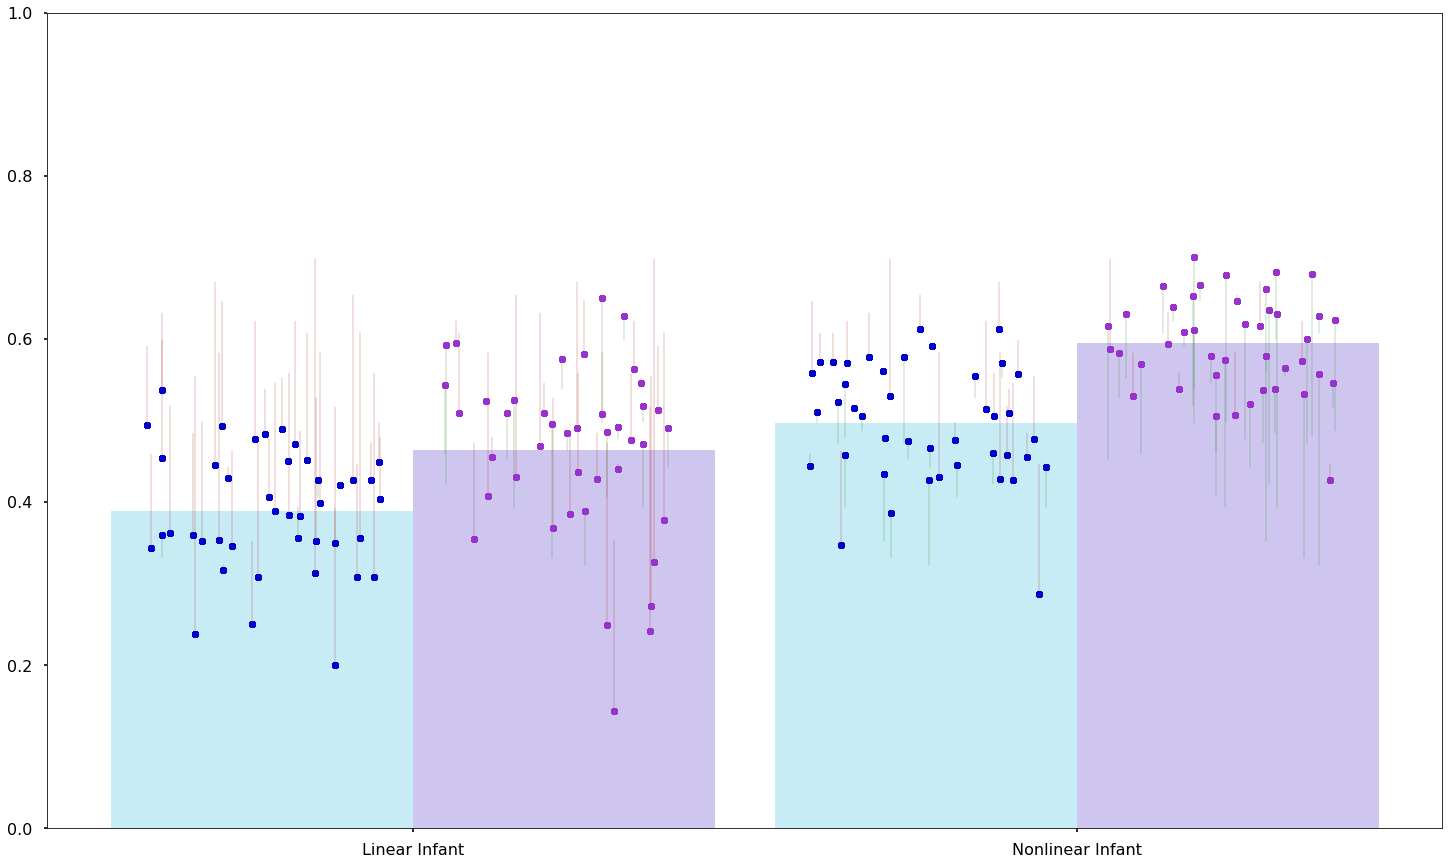

In [20]:
# Contruct a bar graph for this average template analysis
plt.figure(figsize=(25,15))
plt.ylim([0.0, 1.0])
plt.xticks([])

# Put the average tempaltes for both tracers into lists 
CE_templates = [linear_infant_average_approx_linear_CE_MTL, nonlinear_infant_average_approx_nonlinear_CE_MTL]
JF_templates = [linear_infant_average_approx_linear_JF_MTL, nonlinear_infant_average_approx_nonlinear_JF_MTL]

# Set the x-value for the bar 
CE_ticker = 0.5
JF_ticker = 1.5

# Set the x_range for the individual points
CE_point_range = [0.1,0.9]
JF_point_range = [1.1, 1.9]

# Loop through correpsonding template data from both tracers
for CE_template, JF_template in zip(CE_templates, JF_templates):
    
    # Plot CE's data
    jitter_bar(CE_template, inter_rater_reliability_MTL, 'CE', 42, x_range = CE_point_range)
    plt.bar(CE_ticker, np.mean(CE_template), width=1, color=[0.780, 0.924, 0.960])
    
    # Increase the ticker and x_range values for the next loop
    CE_ticker = CE_ticker + 2.2
    CE_point_range = np.add(CE_point_range, [2.2, 2.2])
    
    # Plot JF's data
    jitter_bar(JF_template, inter_rater_reliability_MTL, 'JF', 42, x_range = JF_point_range)
    plt.bar(JF_ticker, np.mean(JF_template), width=1, color=[0.808, 0.776, 0.936])

    # Increase the ticker and x_range values for the next loop
    JF_ticker = JF_ticker + 2.2
    JF_point_range = np.add(JF_point_range, [2.2, 2.2])

plt.xticks([1, 3.2], ['Linear Infant', 'Nonlinear Infant'])

plt.savefig(out_dir_plots + 'Average_infant_templates_approx_MTL_bar_graph.svg')

### CE-ASHS MTL Analyses <a class="anchor" id="section_3_4"></a>

Analyze how well CE-ASHS predicted the manual MTL segmentations of the two raters

CE ASHS Approximating CE MTL Dice=0.61 (SD=0.07, range=0.46-0.75)
CE-ASHS vs JF Approximating CE MTL: M=0.10, CI=[0.080, 0.113], p=0.000, 42 scan improvement from IRR

CE ASHS Approximating JF MTL Dice=0.61 (SD=0.06, range=0.50-0.74)
CE-ASHS vs CE Approximating JF MTL: M=0.10, CI=[0.073, 0.118], p=0.000, 38 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

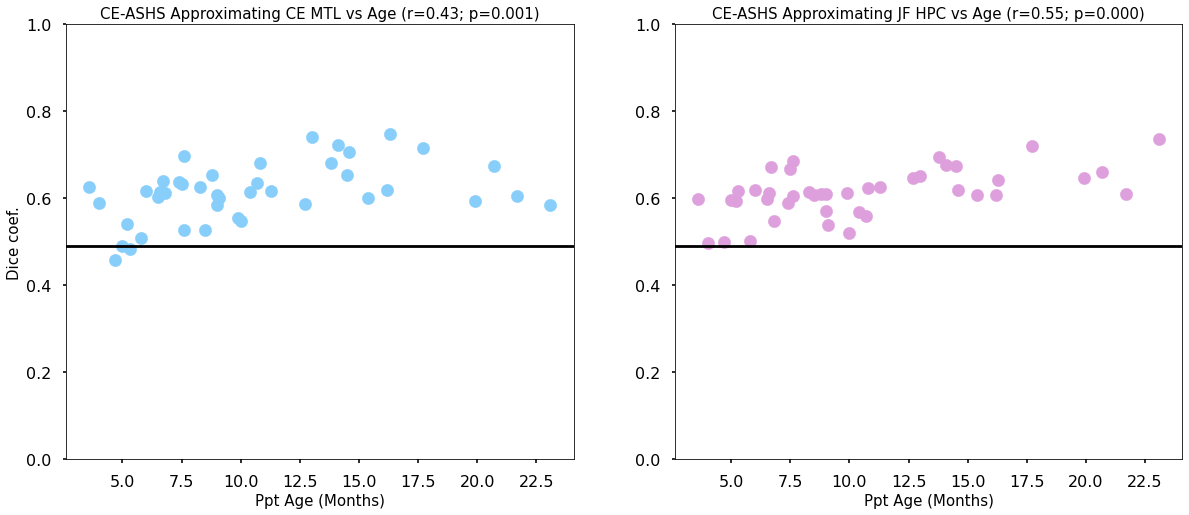

In [21]:
# Measure Dice values between CE-ASHS and CE
CE_ASHS_approx_CE_MTL = dice_compare_ASHS(ordered_files_segmentations_CE_ASHS_right, ordered_files_segmentations_CE_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'CE_ASHS_approximating_CE', 'CE ASHS Approximating CE', trained=True, HPC=False)

# Assess how well CE-ASHS approximated the MTL IRR of this study
p_val, sign_count, CIs = randomise_diff(CE_ASHS_approx_CE_MTL - inter_rater_reliability_MTL)
print('CE-ASHS vs JF Approximating CE MTL: M=%0.2f'% np.mean(CE_ASHS_approx_CE_MTL  - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between CE-ASHS and JF
CE_ASHS_approx_JF_MTL = dice_compare_ASHS(ordered_files_segmentations_CE_ASHS_right, ordered_files_segmentations_CE_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'CE_ASHS_approximating_JF', 'CE ASHS Approximating JF', trained=True, HPC=False)

# Assess how well CE-ASHS approximated the MTL IRR of this study
p_val, sign_count, CIs = randomise_diff(CE_ASHS_approx_JF_MTL - inter_rater_reliability_MTL)
print('CE-ASHS vs CE Approximating JF MTL: M=%0.2f'% np.mean(CE_ASHS_approx_JF_MTL  - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Plot and save the data
sub_plot(ordered_ppt_ages, CE_ASHS_approx_CE_MTL, CE_ASHS_approx_JF_MTL, 'CE-ASHS Approximating CE MTL vs Age', 'CE-ASHS Approximating JF HPC vs Age', CE_nonlinear_lower_bound_MTL, JF_nonlinear_lower_bound_MTL)

plt.savefig(out_dir_plots + 'CE_ASHS_approx_MTL_scatter_plot.svg')
    
plt.show()

### JF-ASHS MTL Analyses <a class="anchor" id="section_3_5"></a>

Analyze how well JF-ASHS predicted the manual MTL segmentations of the two raters

JF ASHS Approximating CE MTL Dice=0.54 (SD=0.09, range=0.36-0.68)
JF-ASHS vs JF Approximating CE MTL: M=0.03, CI=[0.014, 0.041], p=0.000, 33 scan improvement from IRR

JF ASHS Approximating JF MTL Dice=0.74 (SD=0.06, range=0.51-0.83)
JF-ASHS vs CE Approximating JF MTL: M=0.23, CI=[0.202, 0.253], p=0.000, 42 scan improvement from IRR



<Figure size 432x288 with 0 Axes>

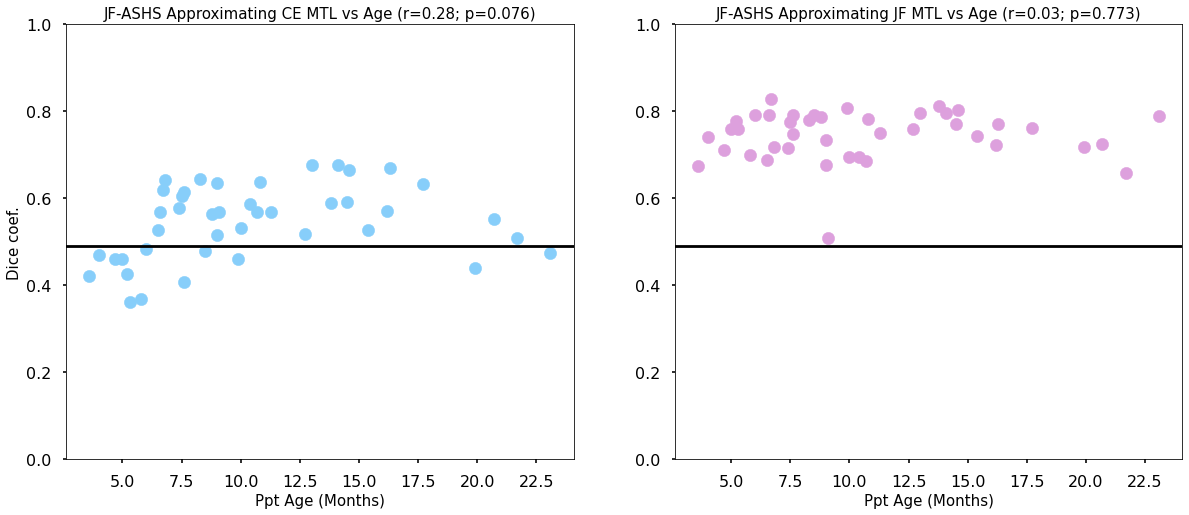

In [22]:
# Measure Dice values between JF-ASHS and CE
JF_ASHS_approx_CE_MTL = dice_compare_ASHS(ordered_files_segmentations_JF_ASHS_right, ordered_files_segmentations_JF_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'JF_ASHS_approximating_CE', 'JF ASHS Approximating CE', trained=True, HPC=False)

# Assess how well JF-ASHS approximated the MTL IRR of this study
p_val, sign_count, CIs = randomise_diff(JF_ASHS_approx_CE_MTL - inter_rater_reliability_MTL)
print('JF-ASHS vs JF Approximating CE MTL: M=%0.2f'% np.mean(JF_ASHS_approx_CE_MTL  - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between JF-ASHS and JF
JF_ASHS_approx_JF_MTL = dice_compare_ASHS(ordered_files_segmentations_JF_ASHS_right, ordered_files_segmentations_JF_ASHS_left, ordered_files_segmentations_nonlinear_JF,  'JF_ASHS_approximating_JF', 'JF ASHS Approximating JF', trained=True, HPC=False)

# Assess how well JF-ASHS approximated the MTL IRR of this study
p_val, sign_count, CIs = randomise_diff(JF_ASHS_approx_JF_MTL - inter_rater_reliability_MTL)
print('JF-ASHS vs CE Approximating JF MTL: M=%0.2f'% np.mean(JF_ASHS_approx_JF_MTL  - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Plot and save the data
sub_plot(ordered_ppt_ages, JF_ASHS_approx_CE_MTL, JF_ASHS_approx_JF_MTL, 'JF-ASHS Approximating CE MTL vs Age', 'JF-ASHS Approximating JF MTL vs Age', CE_nonlinear_lower_bound_MTL, JF_nonlinear_lower_bound_MTL)

plt.savefig(out_dir_plots + 'JF_ASHS_approx_MTL_scatter_plot.svg')
    
plt.show()

### Infant-Trained-ASHS MTL Analyses  <a class="anchor" id="section_3_6"></a>
Analyze how well Infant-Trained-ASHS predicted the manual MTL segmentations of the two raters

Infant-Trained-ASHS Approximating CE MTL Dice=0.58 (SD=0.08, range=0.42-0.73)
Infant-Trained-ASHS vs JF Approximating CE MTL:  M=0.06, CI=[0.051, 0.077], p=0.000, 39 scan improvement from IRR

Infant-Trained-ASHS Approximating JF MTL Dice=0.71 (SD=0.06, range=0.52-0.79)
Infant-Trained-ASHS  vs CE Approximating JF MTL:  M=0.20, CI=[0.173, 0.219], p=0.000, 42 scan improvement from IRR

Infant-Trained-ASHS  vs CE-ASHS Approximating CE MTL:  M=-0.03, CI=[-0.043, -0.022], p=0.000, 5 scan improvement from CE-ASHS

Infant-Trained-ASHS vs CE-ASHS Approximating JF MTL:  M=0.10, CI=[0.089, 0.110], p=0.000, 41 scan improvement from CE-ASHS

Infant-Trained-ASHS vs JF-ASHS Approximating JF MTL:  M=-0.03, CI=[-0.041, -0.023], p=0.000, 6 scan improvement from JF-ASHS

Infant-Trained-ASHS vs JF-ASHS Approximating CE MTL:  M=0.04, CI=[0.031, 0.043], p=0.000, 41 scan improvement from JF-ASHS



<Figure size 432x288 with 0 Axes>

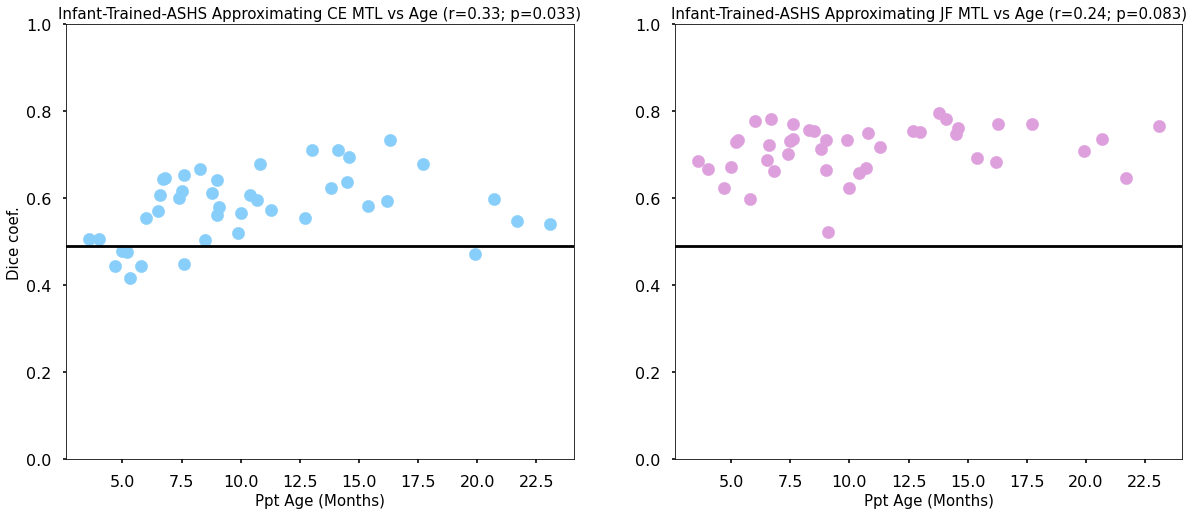

In [23]:
# Measure Dice values between Infant-Trained-ASHS and CE
infant_trained_ASHS_approx_CE_MTL = dice_compare_ASHS(ordered_files_segmentations_infant_trained_ASHS_right, ordered_files_segmentations_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'Infant_trained_ASHS_approximating_CE', 'Infant-Trained-ASHS Approximating CE', trained = True, HPC=False)

# Assess how well Infant-Trained-ASHS approximated the MTL IRR of this study
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_CE_MTL - inter_rater_reliability_MTL)
print('Infant-Trained-ASHS vs JF Approximating CE MTL:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_MTL  - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Measure Dice values between Infant-Trained-ASHS and JF
infant_trained_ASHS_approx_JF_MTL = dice_compare_ASHS(ordered_files_segmentations_infant_trained_ASHS_right, ordered_files_segmentations_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'Infant_trained_ASHS_approximating_JF', 'Infant-Trained-ASHS Approximating JF', trained = True, HPC=False)

# Assess how well Infant-Trained-ASHS approximated the MTL IRR of this study
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_JF_MTL - inter_rater_reliability_MTL)
print('Infant-Trained-ASHS  vs CE Approximating JF MTL:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_MTL  - inter_rater_reliability_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from IRR'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating CE with CE-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_CE_MTL - CE_ASHS_approx_CE_MTL)
print('Infant-Trained-ASHS  vs CE-ASHS Approximating CE MTL:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_MTL - CE_ASHS_approx_CE_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from CE-ASHS'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating JF with CE-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_JF_MTL - CE_ASHS_approx_JF_MTL)
print('Infant-Trained-ASHS vs CE-ASHS Approximating JF MTL:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_MTL - CE_ASHS_approx_JF_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from CE-ASHS'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating JF with JF-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_JF_MTL - JF_ASHS_approx_JF_MTL)
print('Infant-Trained-ASHS vs JF-ASHS Approximating JF MTL:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_MTL - JF_ASHS_approx_JF_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from JF-ASHS'), print()

# Compare the reliability of Infant-Trained-ASHS in approximating CE with JF-ASHS 
p_val, sign_count, CIs = randomise_diff(infant_trained_ASHS_approx_CE_MTL - JF_ASHS_approx_CE_MTL)
print('Infant-Trained-ASHS vs JF-ASHS Approximating CE MTL:  M=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_MTL - JF_ASHS_approx_CE_MTL) + ', CI=[%0.3f'%CIs[0] + ', %0.3f]'%CIs[1] + ', p=%0.3f'% p_val + ', ' + str(sign_count) + ' scan improvement from JF-ASHS'), print()

# Plot and save the correlation data
sub_plot(ordered_ppt_ages, infant_trained_ASHS_approx_CE_MTL, infant_trained_ASHS_approx_JF_MTL, 'Infant-Trained-ASHS Approximating CE MTL vs Age', 'Infant-Trained-ASHS Approximating JF MTL vs Age',  CE_nonlinear_lower_bound_MTL, JF_nonlinear_lower_bound_MTL)

plt.savefig(out_dir_plots + 'Infant_trained_ASHS_approx_MTL_scatter_plot.svg')
    
plt.show()

#### Data Table: ASHS

In [24]:
# Construct a DataFrame table containing the ASHS MTL data
regions =["CE MTL", "JF MTL"]

col_names = ['Brain Region', 'CE-ASHS', 'CE-ASHS Corr', 'JF-ASHS', 'JF-ASHS Corr', 'Infant-Trained-ASHS', 'Infant-Trained-ASHS Corr']

Dice_Matrix_Table = pd.DataFrame(columns=col_names)

# CE-ASHS data
p_val_CE, sign_count_CE, CIs_CE = randomise_diff(CE_ASHS_approx_CE_MTL - inter_rater_reliability_MTL)
p_val_JF, sign_count_JF, CIs_JF = randomise_diff(CE_ASHS_approx_JF_MTL - inter_rater_reliability_MTL)
CE_ASHS = ['Dice=%0.2f'% np.mean(CE_ASHS_approx_CE_MTL) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', CI=[%0.3f'%CIs_CE[0] + ', %0.3f]'%CIs_CE[1], 'Dice=%0.2f'% np.mean(CE_ASHS_approx_JF_MTL) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', CI=[%0.3f'%CIs_JF[0] + ', %0.3f]'%CIs_JF[1]]

CE_ASHS_corr = ['r=%0.2f'% np.corrcoef(CE_ASHS_approx_CE_MTL, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(CE_ASHS_approx_CE_MTL, ordered_ppt_ages),'r=%0.2f'% np.corrcoef(CE_ASHS_approx_JF_MTL, ordered_ppt_ages)[0,1] +', p=%0.3f'% randomise_corr(CE_ASHS_approx_JF_MTL, ordered_ppt_ages)]

#JF-ASHS data
p_val_CE, sign_count_CE, CIs_CE = randomise_diff(JF_ASHS_approx_CE_MTL - inter_rater_reliability_MTL)
p_val_JF, sign_count_JF, CIs_JF = randomise_diff(JF_ASHS_approx_JF_MTL - inter_rater_reliability_MTL)
JF_ASHS = ['Dice=%0.2f'% np.mean(JF_ASHS_approx_CE_MTL) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', CI=[%0.3f'%CIs_CE[0] + ', %0.3f]'%CIs_CE[1], 'Dice=%0.2f'% np.mean(JF_ASHS_approx_JF_MTL) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', CI=[%0.3f'%CIs_JF[0] + ', %0.3f]'%CIs_JF[1]]

JF_ASHS_corr = ['r=%0.2f'% np.corrcoef(JF_ASHS_approx_CE_MTL, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(JF_ASHS_approx_CE_MTL, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(JF_ASHS_approx_JF_MTL, ordered_ppt_ages)[0,1] +', p=%0.3f'% randomise_corr(JF_ASHS_approx_JF_MTL, ordered_ppt_ages)]

#Infant-Trained-ASHS data
p_val_CE, sign_count_CE, CIs_CE = randomise_diff(infant_trained_ASHS_approx_CE_MTL - inter_rater_reliability_MTL)
p_val_JF, sign_count_JF, CIs_JF = randomise_diff(infant_trained_ASHS_approx_JF_MTL - inter_rater_reliability_MTL)
infant_trained_ASHS = ['Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_MTL) + ' (IMP from IRR = ' + str(sign_count_CE) + ', p=%0.3f'% p_val_CE + ', CI=[%0.3f'%CIs_CE[0] + ', %0.3f]'%CIs_CE[1], 'Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_MTL) + ' (IMP from IRR = ' + str(sign_count_JF) + ', p=%0.3f'% p_val_JF + ', CI=[%0.3f'%CIs_JF[0] + ', %0.3f]'%CIs_JF[1]]

infant_trained_ASHS_corr = ['r=%0.2f'% np.corrcoef(infant_trained_ASHS_approx_CE_MTL, ordered_ppt_ages)[0,1] + ', p=%0.3f'% randomise_corr(infant_trained_ASHS_approx_CE_MTL, ordered_ppt_ages), 'r=%0.2f'% np.corrcoef(infant_trained_ASHS_approx_JF_MTL, ordered_ppt_ages)[0,1] +', p=%0.3f'% randomise_corr(infant_trained_ASHS_approx_JF_MTL, ordered_ppt_ages)]

Dice_Matrix_Table['Brain Region'] = regions

Dice_Matrix_Table['CE-ASHS'] = CE_ASHS
Dice_Matrix_Table['CE-ASHS Corr'] = CE_ASHS_corr

Dice_Matrix_Table['JF-ASHS'] = JF_ASHS
Dice_Matrix_Table['JF-ASHS Corr'] = JF_ASHS_corr

Dice_Matrix_Table['Infant-Trained-ASHS'] = infant_trained_ASHS
Dice_Matrix_Table['Infant-Trained-ASHS Corr'] = infant_trained_ASHS_corr

Dice_Matrix_Table

Brain Region                                            CE-ASHS  \
0       CE MTL  Dice=0.61 (IMP from IRR = 42, p=0.000, CI=[0.0...   
1       JF MTL  Dice=0.61 (IMP from IRR = 38, p=0.000, CI=[0.0...   

      CE-ASHS Corr                                            JF-ASHS  \
0  r=0.43, p=0.001  Dice=0.54 (IMP from IRR = 33, p=0.000, CI=[0.0...   
1  r=0.55, p=0.000  Dice=0.74 (IMP from IRR = 42, p=0.000, CI=[0.2...   

      JF-ASHS Corr                                Infant-Trained-ASHS  \
0  r=0.28, p=0.076  Dice=0.58 (IMP from IRR = 39, p=0.000, CI=[0.0...   
1  r=0.03, p=0.773  Dice=0.71 (IMP from IRR = 42, p=0.000, CI=[0.1...   

  Infant-Trained-ASHS Corr  
0          r=0.33, p=0.033  
1          r=0.24, p=0.083

#### Bar Plot: Trained ASHS models approximating MTL manual data

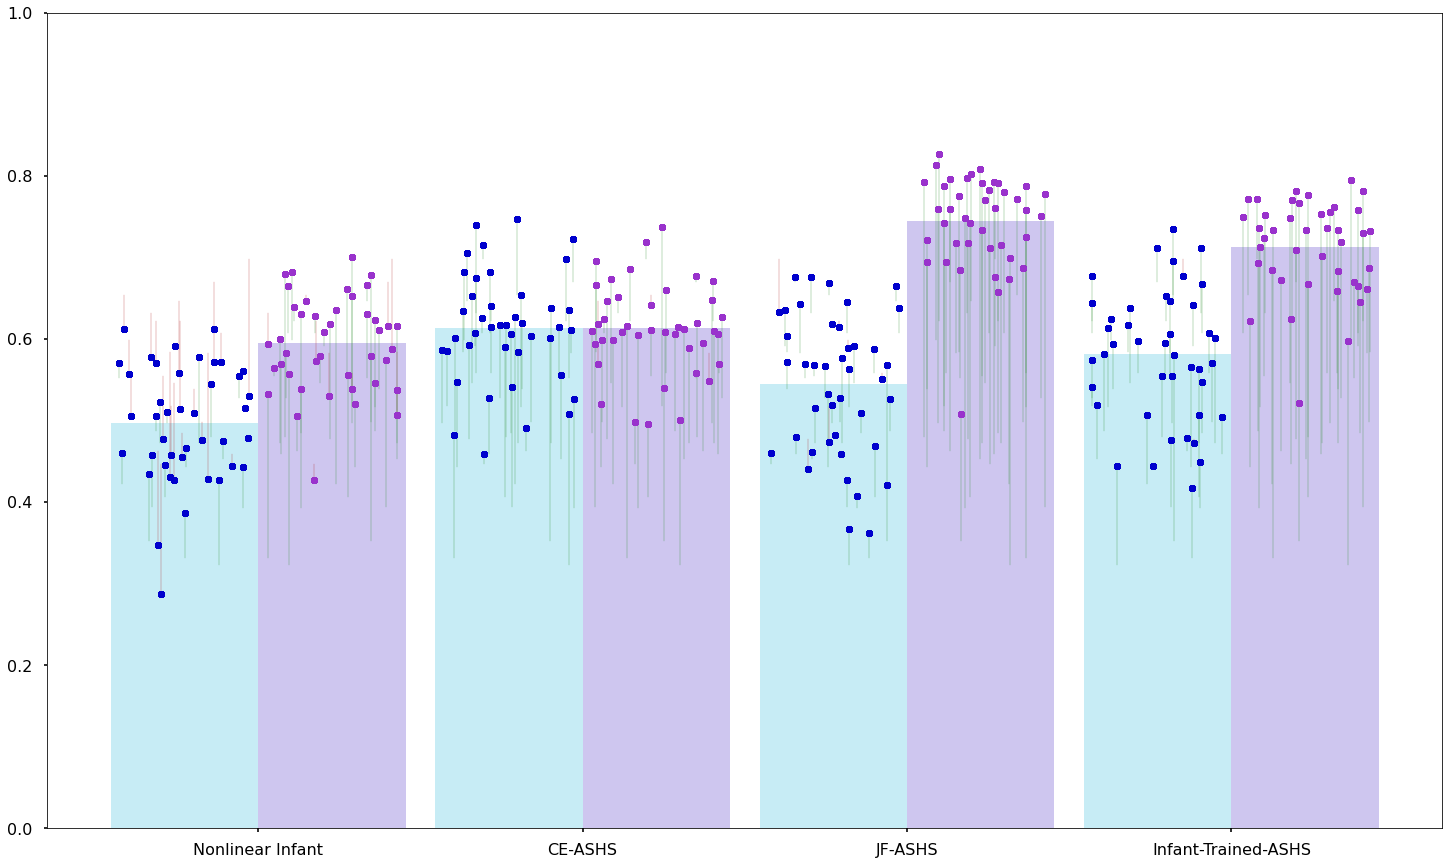

In [25]:
# Contruct a bar graph for this ASHS analysis
plt.figure(figsize=(25,15))
plt.ylim([0.0, 1.0])
plt.xticks([])

# Put the ASHS data from both tracers into lists 
CE_ASHS_models = [nonlinear_infant_average_approx_nonlinear_CE_MTL, CE_ASHS_approx_CE_MTL, JF_ASHS_approx_CE_MTL, infant_trained_ASHS_approx_CE_MTL]
JF_ASHS_models = [nonlinear_infant_average_approx_nonlinear_JF_MTL, CE_ASHS_approx_JF_MTL, JF_ASHS_approx_JF_MTL, infant_trained_ASHS_approx_JF_MTL]

# Set the x-values for the bar
CE_ticker = 0.5
JF_ticker = 1.5

# Set the x_range for the individual points
CE_point_range = [0.05,0.95]
JF_point_range = [1.05, 1.95]

# Loop through corresponding ASHS data from both tracers
for CE_model, JF_model in zip(CE_ASHS_models, JF_ASHS_models):
    
    # Plot CE's data
    jitter_bar(CE_model, inter_rater_reliability_MTL, 'CE', 42, x_range = CE_point_range)
    plt.bar(CE_ticker, np.mean(CE_model), width=1, color=[0.780, 0.924, 0.960])
    
    # Increase the ticker and x_range values for the next loop
    CE_ticker = CE_ticker + 2.2
    CE_point_range = np.add(CE_point_range, [2.2, 2.2])
    
    # Plot JF's data
    jitter_bar(JF_model, inter_rater_reliability_MTL, 'JF', 42, x_range = JF_point_range)
    plt.bar(JF_ticker, np.mean(JF_model), width=1, color=[0.808, 0.776, 0.936])
    
    # Increase the ticker and x_range values for the next loop
    JF_ticker = JF_ticker + 2.2
    JF_point_range = np.add(JF_point_range, [2.2, 2.2])
    
plt.xticks([1, 3.2, 5.4, 7.6], ['Nonlinear Infant', 'CE-ASHS', 'JF-ASHS', 'Infant-Trained-ASHS'])
    
plt.savefig(out_dir_plots + 'ASHS_approx_MTL_bar_graph.svg')

### LOP-ASHS Hippocampal and MTL Analyses <a class="anchor" id="section_3_7"></a>

ASHS models were trained in a leave-one-participant-out (LOP) fashion, in which all of a participants scans were left out of the training set. These analyses assess how well these models predict the segmentations of the participant it did not see. 

In [26]:
# Measure HPC and MTL Dice values between CE-ASHS and CE
LOP_CE_ASHS_approx_CE_HPC = dice_compare_ASHS(ordered_files_segmentations_LOP_CE_ASHS_right, ordered_files_segmentations_LOP_CE_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'LOP_CE_ASHS_approximating_CE', 'LOP-CE-ASHS Approximating CE', trained=True)
LOP_CE_ASHS_approx_CE_MTL = dice_compare_ASHS(ordered_files_segmentations_LOP_CE_ASHS_right, ordered_files_segmentations_LOP_CE_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'LOP_CE_ASHS_approximating_CE', 'LOP-CE-ASHS Approximating CE', trained=True, HPC=False)

print()

# Measure HPC and MTL Dice values between CE-ASHS and JF
LOP_CE_ASHS_approx_JF_HPC = dice_compare_ASHS(ordered_files_segmentations_LOP_CE_ASHS_right, ordered_files_segmentations_LOP_CE_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'LOP_CE_ASHS_approximating_JF', 'LOP-CE-ASHS Approximating JF', trained=True)
LOP_CE_ASHS_approx_JF_MTL = dice_compare_ASHS(ordered_files_segmentations_LOP_CE_ASHS_right, ordered_files_segmentations_LOP_CE_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'LOP_CE_ASHS_approximating_JF', 'LOP-CE-ASHS Approximating JF', trained=True, HPC=False)

LOP-CE-ASHS Approximating CE HPC Dice=0.72 (SD=0.06, range=0.60-0.81)
LOP-CE-ASHS Approximating CE MTL Dice=0.61 (SD=0.07, range=0.46-0.74)

LOP-CE-ASHS Approximating JF HPC Dice=0.58 (SD=0.05, range=0.48-0.65)
LOP-CE-ASHS Approximating JF MTL Dice=0.61 (SD=0.05, range=0.49-0.73)


In [27]:
# Measure HPC and MTL Dice values between JF-ASHS and CE
LOP_JF_ASHS_approx_CE_HPC = dice_compare_ASHS(ordered_files_segmentations_LOP_JF_ASHS_right, ordered_files_segmentations_LOP_JF_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'LOP_JF_ASHS_approximating_CE', 'LOP-JF-ASHS Approximating CE', trained=True)
LOP_JF_ASHS_approx_CE_MTL = dice_compare_ASHS(ordered_files_segmentations_LOP_JF_ASHS_right, ordered_files_segmentations_LOP_JF_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'LOP_JF_ASHS_ALIGNED_approximating_CE', 'LOP-JF-ASHS Approximating CE', trained=True, HPC=False)

print()

# Measure HPC and MTL Dice values between JF-ASHS and JF
LOP_JF_ASHS_approx_JF_HPC = dice_compare_ASHS(ordered_files_segmentations_LOP_JF_ASHS_right, ordered_files_segmentations_LOP_JF_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'LOP_JF_ASHS_approximating_JF', 'LOP-JF-ASHS Approximating JF', trained=True)
LOP_JF_ASHS_approx_JF_MTL = dice_compare_ASHS(ordered_files_segmentations_LOP_JF_ASHS_right, ordered_files_segmentations_LOP_JF_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'LOP_JF_ASHS_approximating_JF', 'LOP-JF-ASHS Approximating JF', trained=True, HPC=False)

LOP-JF-ASHS Approximating CE HPC Dice=0.59 (SD=0.07, range=0.43-0.69)
LOP-JF-ASHS Approximating CE MTL Dice=0.54 (SD=0.09, range=0.36-0.68)

LOP-JF-ASHS Approximating JF HPC Dice=0.71 (SD=0.06, range=0.58-0.80)
LOP-JF-ASHS Approximating JF MTL Dice=0.74 (SD=0.06, range=0.51-0.82)


In [28]:
# Measure HPC and MTL Dice values between Infant-Trained-ASHS and CE
LOP_infant_trained_ASHS_approx_CE_HPC = dice_compare_ASHS(ordered_files_segmentations_LOP_infant_trained_ASHS_right, ordered_files_segmentations_LOP_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'LOP_infant_trained_ASHS_approximating_CE', 'LOP-Infant-Trained-ASHS Approximating CE', trained=True)
LOP_infant_trained_ASHS_approx_CE_MTL = dice_compare_ASHS(ordered_files_segmentations_LOP_infant_trained_ASHS_right, ordered_files_segmentations_LOP_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_CE, 'LOP_infant_trained_ASHS_approximating_CE', 'LOP-Infant-Trained-ASHS Approximating CE', trained=True, HPC=False)

print()

# Measure HPC and MTL Dice values between Infant-Trained-ASHS and JF
LOP_infant_trained_ASHS_approx_JF_HPC = dice_compare_ASHS(ordered_files_segmentations_LOP_infant_trained_ASHS_right, ordered_files_segmentations_LOP_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'LOP_infant_trained_ASHS_approximating_JF', 'LOP-Infant-Trained-ASHS Approximating JF', trained=True)
LOP_infant_trained_ASHS_approx_JF_MTL = dice_compare_ASHS(ordered_files_segmentations_LOP_infant_trained_ASHS_right, ordered_files_segmentations_LOP_infant_trained_ASHS_left, ordered_files_segmentations_nonlinear_JF, 'LOP_infant_trained_ASHS_approximating_JF', 'LOP-Infant-Trained-ASHS Approximating JF', trained=True, HPC=False)

LOP-Infant-Trained-ASHS Approximating CE HPC Dice=0.68 (SD=0.06, range=0.47-0.78)
LOP-Infant-Trained-ASHS Approximating CE MTL Dice=0.58 (SD=0.08, range=0.44-0.73)

LOP-Infant-Trained-ASHS Approximating JF HPC Dice=0.67 (SD=0.06, range=0.55-0.77)
LOP-Infant-Trained-ASHS Approximating JF MTL Dice=0.71 (SD=0.05, range=0.55-0.79)


### LOP-ASHS Bland-Altman Plots <a class="anchor" id="section_3_8"></a>

Bias plots used to quantify the extent to which the volume of the hippocampus volume was over- or under-estimated by the LOP-ASHS models. 

LOP-CE-ASHS difference from zero: -546.39 , CI=[-735.824, -358.687], p=0.000

LOP-JF-ASHS difference from zero: -149.44 , CI=[-326.790, 28.704], p=0.103

LOP-Infant-trained-ASHS difference from zero: -420.44 , CI=[-615.680, -229.653], p=0.000


<Figure size 432x288 with 0 Axes>

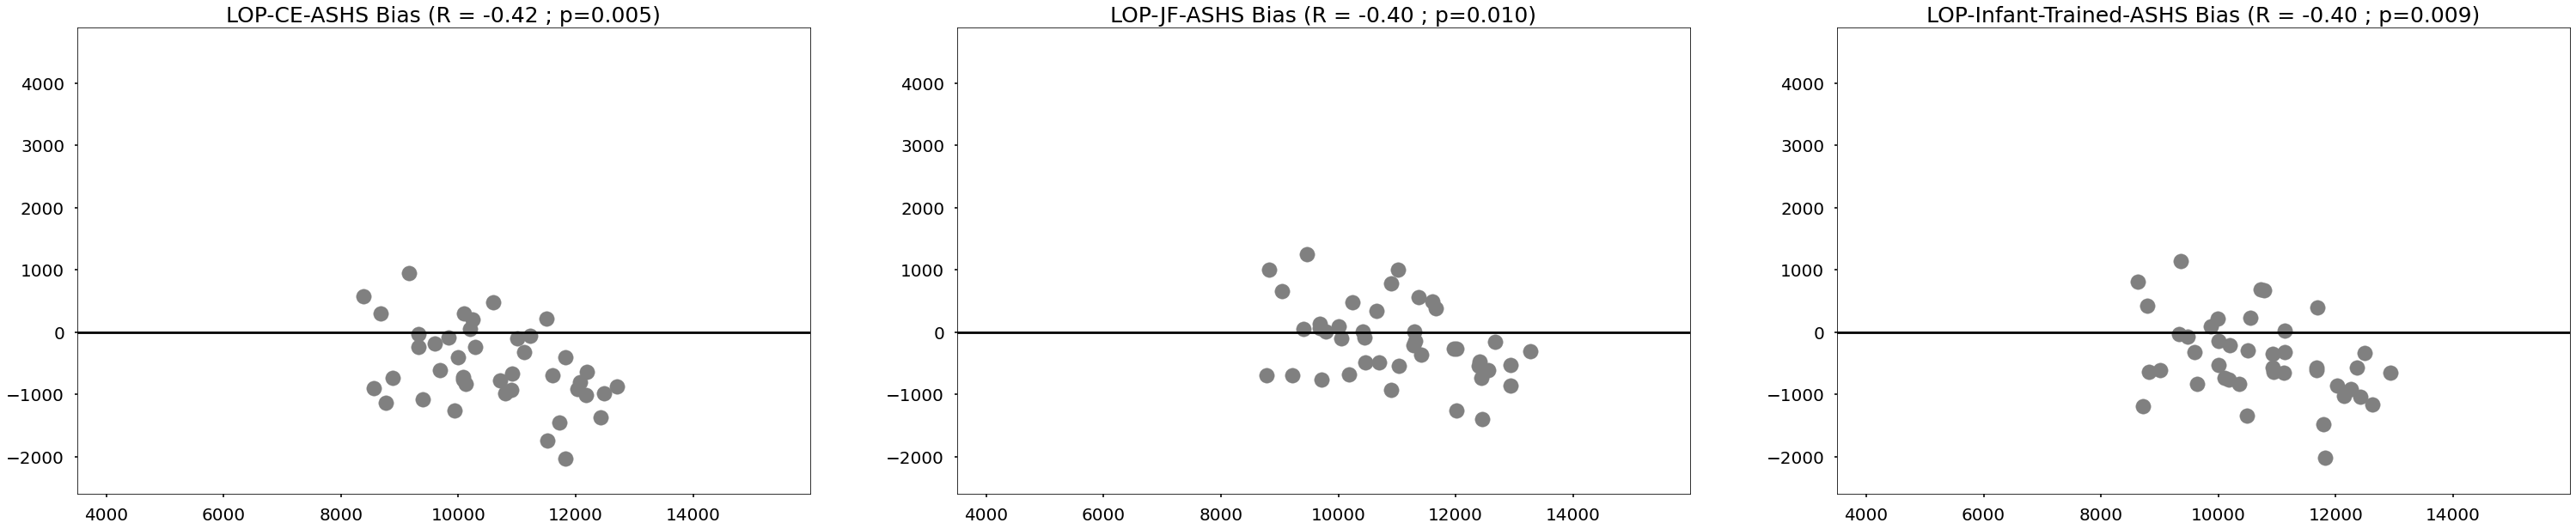

In [29]:
# Generate Bland-Altman plots
LOP_bland_altman_plots(ordered_files_segmentations_nonlinear_CE, ordered_files_segmentations_nonlinear_JF, 'LOP_Bland_Altman_plots')
plt.savefig(out_dir_plots + 'LOP_Bland_Altman_scatter_plots.svg')

#### Data Table: ASHS and LOP-ASHS

In [30]:
# Generate a DataFrame table with all of the LOP ASHS data
col_names = ['Brain Region', 'CE-ASHS', 'LOP-CE-ASHS', 'JF-ASHS', 'LOP-JF-ASHS', 'Infant-Trained-ASHS', 'LOP-Infant-Trained-ASHS']

Dice_Matrix_Table = pd.DataFrame(columns=col_names)

# Brain regions 
regions =["CE HPC", "CE MTL", "JF HPC", "JF MTL"]

# CE-ASHS data (for comparison)
CE_ASHS  = ['Dice=%0.2f'% np.mean(CE_ASHS_approx_CE_HPC) + ' (SD=%0.2f'% stdev(CE_ASHS_approx_CE_HPC) + ', range=%0.2f'% np.min(CE_ASHS_approx_CE_HPC) + '-%0.2f)'% np.max(CE_ASHS_approx_CE_HPC),'Dice=%0.2f'% np.mean(CE_ASHS_approx_CE_MTL) + ' (SD=%0.2f'% stdev(CE_ASHS_approx_CE_MTL) + ', range=%0.2f'% np.min(CE_ASHS_approx_CE_MTL) + '-%0.2f)'% np.max(CE_ASHS_approx_CE_MTL), 'Dice=%0.2f'% np.mean(CE_ASHS_approx_JF_HPC) + ' (SD=%0.2f'% stdev(CE_ASHS_approx_JF_HPC) + ', range=%0.2f'% np.min(CE_ASHS_approx_JF_HPC) + '-%0.2f)'% np.max(CE_ASHS_approx_JF_HPC), 'Dice=%0.2f'% np.mean(CE_ASHS_approx_JF_MTL) + ' (SD=%0.2f'% stdev(CE_ASHS_approx_JF_MTL) + ', range=%0.2f'% np.min(CE_ASHS_approx_JF_MTL) + '-%0.2f)'% np.max(CE_ASHS_approx_JF_MTL)]

# LOP-CE-ASHS data
LOP_CE_ASHS = ['Dice=%0.2f'% np.mean(LOP_CE_ASHS_approx_CE_HPC) + ' (SD=%0.2f'% stdev(LOP_CE_ASHS_approx_CE_HPC) + ', range=%0.2f'% np.min(LOP_CE_ASHS_approx_CE_HPC) + '-%0.2f)'% np.max(LOP_CE_ASHS_approx_CE_HPC), 'Dice=%0.2f'% np.mean(LOP_CE_ASHS_approx_CE_MTL) + ' (SD=%0.2f'% stdev(LOP_CE_ASHS_approx_CE_MTL) + ', range=%0.2f'% np.min(LOP_CE_ASHS_approx_CE_MTL) + '-%0.2f)'% np.max(LOP_CE_ASHS_approx_CE_MTL), 'Dice=%0.2f'% np.mean(LOP_CE_ASHS_approx_JF_HPC) + ' (SD=%0.2f'% stdev(LOP_CE_ASHS_approx_JF_HPC) + ', range=%0.2f'% np.min(LOP_CE_ASHS_approx_JF_HPC) + '-%0.2f)'% np.max(LOP_CE_ASHS_approx_JF_HPC), 'Dice=%0.2f'% np.mean(LOP_CE_ASHS_approx_JF_MTL) +' (SD=%0.2f'% stdev(LOP_CE_ASHS_approx_JF_MTL) + ', range=%0.2f'% np.min(LOP_CE_ASHS_approx_JF_MTL) + '-%0.2f)'% np.max(LOP_CE_ASHS_approx_JF_MTL)]

# JF-ASHS data (for comparison)
JF_ASHS  = ['Dice=%0.2f'% np.mean(JF_ASHS_approx_CE_HPC) + ' (SD=%0.2f'% stdev(JF_ASHS_approx_CE_HPC) + ', range=%0.2f'% np.min(JF_ASHS_approx_CE_HPC) + '-%0.2f)'% np.max(JF_ASHS_approx_CE_HPC), 'Dice=%0.2f'% np.mean(JF_ASHS_approx_CE_MTL) + ' (SD=%0.2f'% stdev(JF_ASHS_approx_CE_MTL) + ', range=%0.2f'% np.min(JF_ASHS_approx_CE_MTL) + '-%0.2f)'% np.max(JF_ASHS_approx_CE_MTL), 'Dice=%0.2f'% np.mean(JF_ASHS_approx_JF_HPC) + ' (SD=%0.2f'% stdev(JF_ASHS_approx_JF_HPC) + ', range=%0.2f'% np.min(JF_ASHS_approx_JF_HPC) + '-%0.2f)'% np.max(JF_ASHS_approx_JF_HPC), 'Dice=%0.2f'% np.mean(JF_ASHS_approx_JF_MTL) + ' (SD=%0.2f'% stdev(JF_ASHS_approx_JF_MTL) + ', range=%0.2f'% np.min(JF_ASHS_approx_JF_MTL) + '-%0.2f)'% np.max(JF_ASHS_approx_JF_MTL)]

# LOP-JF-ASHS data
LOP_JF_ASHS = ['Dice=%0.2f'% np.mean(LOP_JF_ASHS_approx_CE_HPC) + ' (SD=%0.2f'% stdev(LOP_JF_ASHS_approx_CE_HPC) + ', range=%0.2f'% np.min(LOP_JF_ASHS_approx_CE_HPC) + '-%0.2f)'% np.max(LOP_JF_ASHS_approx_CE_HPC), 'Dice=%0.2f'% np.mean(LOP_JF_ASHS_approx_CE_MTL) + ' (SD=%0.2f'% stdev(LOP_JF_ASHS_approx_CE_MTL) + ', range=%0.2f'% np.min(LOP_JF_ASHS_approx_CE_MTL) + '-%0.2f)'% np.max(LOP_JF_ASHS_approx_CE_MTL), 'Dice=%0.2f'% np.mean(LOP_JF_ASHS_approx_JF_HPC) + ' (SD=%0.2f'% stdev(LOP_JF_ASHS_approx_JF_HPC) + ', range=%0.2f'% np.min(LOP_JF_ASHS_approx_JF_HPC) + '-%0.2f)'% np.max(LOP_JF_ASHS_approx_JF_HPC), 'Dice=%0.2f'% np.mean(LOP_JF_ASHS_approx_JF_MTL) +' (SD=%0.2f'% stdev(LOP_JF_ASHS_approx_JF_MTL) + ', range=%0.2f'% np.min(LOP_JF_ASHS_approx_JF_MTL) + '-%0.2f)'% np.max(LOP_JF_ASHS_approx_JF_MTL)]

# Infant-Trained-ASHS data (for comparison)
infant_trained_ASHS  = ['Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_HPC) + ' (SD=%0.2f'% stdev(infant_trained_ASHS_approx_CE_HPC) + ', range=%0.2f'% np.min(infant_trained_ASHS_approx_CE_HPC) + '-%0.2f)'% np.max(infant_trained_ASHS_approx_CE_HPC),'Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_CE_MTL) + ' (SD=%0.2f'% stdev(infant_trained_ASHS_approx_CE_MTL) + ', range=%0.2f'% np.min(infant_trained_ASHS_approx_CE_MTL) + '-%0.2f)'% np.max(infant_trained_ASHS_approx_CE_MTL), 'Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_HPC) + ' (SD=%0.2f'% stdev(infant_trained_ASHS_approx_JF_HPC) + ', range=%0.2f'% np.min(infant_trained_ASHS_approx_JF_HPC) + '-%0.2f)'% np.max(infant_trained_ASHS_approx_JF_HPC), 'Dice=%0.2f'% np.mean(infant_trained_ASHS_approx_JF_MTL) + ' (SD=%0.2f'% stdev(infant_trained_ASHS_approx_JF_MTL) + ', range=%0.2f'% np.min(infant_trained_ASHS_approx_JF_MTL) + '-%0.2f)'% np.max(infant_trained_ASHS_approx_JF_MTL)]

#LOP-Infant-Trained-ASHS data
LOP_infant_trained_ASHS  = ['Dice=%0.2f'% np.mean(LOP_infant_trained_ASHS_approx_CE_HPC) + ' (SD=%0.2f'% stdev(LOP_infant_trained_ASHS_approx_CE_HPC) + ', range=%0.2f'% np.min(LOP_infant_trained_ASHS_approx_CE_HPC) + '-%0.2f)'% np.max(LOP_infant_trained_ASHS_approx_CE_HPC),'Dice=%0.2f'% np.mean(LOP_infant_trained_ASHS_approx_CE_MTL) + ' (SD=%0.2f'% stdev(LOP_infant_trained_ASHS_approx_CE_MTL) + ', range=%0.2f'% np.min(LOP_infant_trained_ASHS_approx_CE_MTL) + '—%0.2f)'% np.max(LOP_infant_trained_ASHS_approx_CE_MTL), 'Dice=%0.2f'% np.mean(LOP_infant_trained_ASHS_approx_JF_HPC) + ' (SD=%0.2f'% stdev(LOP_infant_trained_ASHS_approx_JF_HPC) + ', range=%0.2f'% np.min(LOP_infant_trained_ASHS_approx_JF_HPC) + '—%0.2f)'% np.max(LOP_infant_trained_ASHS_approx_JF_HPC), 'Dice=%0.2f'% np.mean(LOP_infant_trained_ASHS_approx_JF_MTL) + ' (SD=%0.2f'% stdev(LOP_infant_trained_ASHS_approx_JF_MTL) + ', range=%0.2f'% np.min(LOP_infant_trained_ASHS_approx_JF_MTL) + '-%0.2f)'% np.max(LOP_infant_trained_ASHS_approx_JF_MTL)]

Dice_Matrix_Table['Brain Region'] = regions

Dice_Matrix_Table['CE-ASHS'] = CE_ASHS
Dice_Matrix_Table['LOP-CE-ASHS'] = LOP_CE_ASHS

Dice_Matrix_Table['JF-ASHS'] = JF_ASHS
Dice_Matrix_Table['LOP-JF-ASHS'] = LOP_JF_ASHS

Dice_Matrix_Table['Infant-Trained-ASHS'] = infant_trained_ASHS
Dice_Matrix_Table['LOP-Infant-Trained-ASHS'] = LOP_infant_trained_ASHS

Dice_Matrix_Table

Brain Region                               CE-ASHS  \
0       CE HPC  Dice=0.73 (SD=0.06, range=0.59-0.82)   
1       CE MTL  Dice=0.61 (SD=0.07, range=0.46-0.75)   
2       JF HPC  Dice=0.58 (SD=0.05, range=0.46-0.65)   
3       JF MTL  Dice=0.61 (SD=0.06, range=0.50-0.74)   

                            LOP-CE-ASHS                               JF-ASHS  \
0  Dice=0.72 (SD=0.06, range=0.60-0.81)  Dice=0.59 (SD=0.07, range=0.43-0.70)   
1  Dice=0.61 (SD=0.07, range=0.46-0.74)  Dice=0.54 (SD=0.09, range=0.36-0.68)   
2  Dice=0.58 (SD=0.05, range=0.48-0.65)  Dice=0.72 (SD=0.06, range=0.58-0.80)   
3  Dice=0.61 (SD=0.05, range=0.49-0.73)  Dice=0.74 (SD=0.06, range=0.51-0.83)   

                            LOP-JF-ASHS                   Infant-Trained-ASHS  \
0  Dice=0.59 (SD=0.07, range=0.43-0.69)  Dice=0.67 (SD=0.06, range=0.54-0.78)   
1  Dice=0.54 (SD=0.09, range=0.36-0.68)  Dice=0.58 (SD=0.08, range=0.42-0.73)   
2  Dice=0.71 (SD=0.06, range=0.58-0.80)  Dice=0.67 (SD=0.06, range=0.52-0.76)   
3  Dice=0.74 (SD=0.06, range=0.51-0.82)  Dice=0.71 (SD=0.06, range=0.52-0.79)   

                LOP-Infant-Trained-ASHS  
0  Dice=0.68 (SD=0.06, range=0.47-0.78)  
1  Dice=0.58 (SD=0.08, range=0.44—0.73)  
2  Dice=0.67 (SD=0.06, range=0.55—0.77)  
3  Dice=0.71 (SD=0.05, range=0.55-0.79)

### Average Template Data Table  <a class="anchor" id="section_3_9"></a>

Every average template Dice value generated from this present study

In [31]:
# Plot all the participant, average template, FreeSurfer, and ASHS HPC data into one DataFrame table
col_names = ['Hashed Name', 'Age', 'HPC IRR', 'Linear Infant Approx. CE HPC', 'Linear Infant Approx. JF HPC', 'Linear Adult Approx. CE HPC', 'Linear Adult Approx. JF HPC', 'Nonlinear Infant Approx. CE HPC', 'Nonlinear Infant Approx. JF HPC', 'Nonlinear Adult Approx. CE HPC', 'Nonlinear Adult Approx. JF HPC', 'MTL IRR', 'Linear Infant Approx. CE MTL', 'Linear Infant Approx. JF MTL', 'Nonlinear Infant Approx. CE MTL', 'Nonlinear Infant Approx. JF MTL', 'FreeSurfer Approx. CE HPC', 'FreeSurfer Approx. JF HPC']

df_Template_data = pd.DataFrame(columns=col_names)

# Participant data
df_Template_data['Hashed Name'] = ordered_ppt_names
df_Template_data['Age'] = ordered_ppt_ages

# IRR data
df_Template_data['HPC IRR'] = ['%.5f' % elem for elem in inter_rater_reliability_HPC]
df_Template_data['MTL IRR'] = ['%.3f' % elem for elem in inter_rater_reliability_MTL]

# Linear average infant HPC data
df_Template_data['Linear Infant Approx. CE HPC'] = ['%.3f' % elem for elem in linear_infant_average_approx_linear_CE_HPC]
df_Template_data['Linear Infant Approx. JF HPC'] = ['%.3f' % elem for elem in linear_infant_average_approx_linear_JF_HPC]

# Linear average infant MTL data  
df_Template_data['Linear Infant Approx. CE MTL'] = ['%.3f' % elem for elem in linear_infant_average_approx_linear_CE_MTL]
df_Template_data['Linear Infant Approx. JF MTL'] = ['%.3f' % elem for elem in linear_infant_average_approx_linear_JF_MTL]

# Linear average adult HPC data
df_Template_data['Linear Adult Approx. CE HPC'] = ['%.3f' % elem for elem in adult_average_approx_linear_CE_HPC]
df_Template_data['Linear Adult Approx. JF HPC'] = ['%.3f' % elem for elem in adult_average_approx_linear_JF_HPC]

# Nonlinear average infant HPC data
df_Template_data['Nonlinear Infant Approx. CE HPC'] = ['%.3f' % elem for elem in nonlinear_infant_average_approx_nonlinear_CE_HPC]
df_Template_data['Nonlinear Infant Approx. JF HPC'] = ['%.3f' % elem for elem in nonlinear_infant_average_approx_nonlinear_JF_HPC]

# Nonlinear average infant  MTL data  
df_Template_data['Nonlinear Infant Approx. CE MTL'] = ['%.3f' % elem for elem in nonlinear_infant_average_approx_nonlinear_CE_MTL]
df_Template_data['Nonlinear Infant Approx. JF MTL'] = ['%.3f' % elem for elem in nonlinear_infant_average_approx_nonlinear_JF_MTL]

# Nonlinear average adult HPC data
df_Template_data['Nonlinear Adult Approx. CE HPC'] = ['%.3f' % elem for elem in adult_average_approx_nonlinear_CE_HPC]
df_Template_data['Nonlinear Adult Approx. JF HPC'] = ['%.3f' % elem for elem in adult_average_approx_nonlinear_JF_HPC]

# FreeSurfer HPC data
freesurfer_approx_CE_HPC_modified = list(freesurfer_approx_CE_HPC[:])
freesurfer_approx_CE_HPC_modified.insert(15,0) 
freesurfer_approx_CE_HPC_modified.insert(39,0) 
df_Template_data['FreeSurfer Approx. CE HPC'] = ['%.3f' % elem for elem in freesurfer_approx_CE_HPC_modified]

freesurfer_approx_JF_HPC_modified = list(freesurfer_approx_JF_HPC[:])
freesurfer_approx_JF_HPC_modified.insert(15,0) 
freesurfer_approx_JF_HPC_modified.insert(39,0) 
df_Template_data['FreeSurfer Approx. JF HPC'] = ['%.3f' % elem for elem in freesurfer_approx_JF_HPC_modified]

df_Template_data.to_csv('Template.csv')

df_Template_data


Hashed Name   Age  HPC IRR Linear Infant Approx. CE HPC  \
0    s6057_1_1   3.6  0.50384                        0.488   
1    s6607_1_1   4.0  0.58575                        0.403   
2    s7067_1_1   4.7  0.46048                        0.298   
3    s6687_1_1   5.0  0.49082                        0.174   
4    s7017_1_1   5.2  0.47985                        0.494   
5    s0687_1_1   5.3  0.48669                        0.438   
6    s8687_1_2   5.8  0.57497                        0.300   
7    s2687_1_2   6.0  0.58569                        0.216   
8    s2037_1_2   6.5  0.64239                        0.370   
9    s7017_1_2   6.6  0.50899                        0.342   
10   s4607_1_2   6.7  0.48946                        0.376   
11   s1057_1_1   6.8  0.57865                        0.214   
12   s6607_1_2   7.4  0.62553                        0.251   
13   s3607_1_1   7.5  0.58687                        0.267   
14   s0607_1_1   7.6  0.67968                        0.403   
15   s6057_1_2   7.6  0.50655                        0.465   
16   s7017_1_4   8.3  0.49507                        0.412   
17   s8607_1_1   8.5  0.65255                        0.333   
18   s4107_1_1   8.8  0.53027                        0.173   
19   s0687_1_2   9.0  0.62862                        0.356   
20   s0057_1_3   9.0  0.55605                        0.347   
21   s0307_1_2   9.1  0.58867                        0.145   
22   s2687_1_3   9.9  0.60398                        0.372   
23   s1017_1_1  10.0  0.42575                        0.304   
24   s3607_1_2  10.4  0.49646                        0.351   
25   s1607_1_2  10.7  0.52959                        0.399   
26   s6607_1_3  10.8  0.65788                        0.333   
27   s6687_1_3  11.3  0.59756                        0.290   
28   s0607_1_2  12.7  0.58263                        0.453   
29   s4607_1_4  13.0  0.67225                        0.372   
30   s8187_1_4  13.8  0.65122                        0.450   
31   s4607_1_5  14.1  0.62458                        0.315   
32   s8687_1_4  14.5  0.69785                        0.335   
33   s0607_1_3  14.6  0.62784                        0.448   
34   s6687_1_4  15.4  0.49432                        0.415   
35   s0607_1_4  16.2  0.46944                        0.401   
36   s2687_1_4  16.3  0.61254                        0.282   
37   s0607_1_5  17.7  0.61771                        0.333   
38   s2307_1_1  19.9  0.63557                        0.272   
39   s1187_1_1  20.7  0.58149                        0.368   
40   s2307_1_2  21.7  0.60142                        0.270   
41   s8187_1_8  23.1  0.61840                        0.408   

   Linear Infant Approx. JF HPC Linear Adult Approx. CE HPC  \
0                         0.376                       0.584   
1                         0.378                       0.535   
2                         0.306                       0.537   
3                         0.307                       0.257   
4                         0.288                       0.576   
5                         0.389                       0.411   
6                         0.270                       0.407   
7                         0.222                       0.295   
8                         0.332                       0.451   
9                         0.130                       0.529   
10                        0.366                       0.274   
11                        0.234                       0.245   
12                        0.244                       0.368   
13                        0.323                       0.317   
14                        0.337                       0.539   
15                        0.389                       0.475   
16                        0.272                       0.493   
17                        0.343                       0.311   
18                        0.032                       0.407   
19                        0.194                       0.526   
20           

### ASHS Data Table <a class="anchor" id="section_3_10"></a>
Every ASHS Dice value generated from this present study

In [32]:
# Plot all the participant, average template, and ASHS MTL data into one DataFrame table
col_names = ['Hashed Name', 'Age', 'HPC IRR', 'Adult-Pretrained-ASHS Approx. CE HPC', 'Adult-Pretrained-ASHS Approx. JF HPC', 'CE-ASHS Approx. CE HPC', 'CE-ASHS Approx. JF HPC', 'JF-ASHS Approx. CE HPC', 'JF-ASHS Approx. JF HPC', 'Infant-Trained-ASHS Approx. CE HPC', 'Infant-Trained-ASHS Approx. JF HPC', 'MTL IRR', 'CE-ASHS Approx. CE MTL', 'CE-ASHS Approx. JF MTL', 'JF-ASHS Approx. CE MTL', 'JF-ASHS Approx. JF MTL', 'Infant-Trained-ASHS Approx. CE MTL', 'Infant-Trained-ASHS Approx. JF MTL']

df_ASHS_data = pd.DataFrame(columns=col_names)

# Participant data
df_ASHS_data['Hashed Name'] = ordered_ppt_names

df_ASHS_data['Age'] = ordered_ppt_ages

# IRR data
df_ASHS_data['HPC IRR'] = ['%.3f' % elem for elem in inter_rater_reliability_HPC]
df_ASHS_data['MTL IRR'] = ['%.3f' % elem for elem in inter_rater_reliability_MTL]

# Adult-pretrained-ASHS HPC data
df_ASHS_data['Adult-Pretrained-ASHS Approx. CE HPC'] = ['%.3f' % elem for elem in adult_pretrained_ASHS_approx_CE_HPC]
df_ASHS_data['Adult-Pretrained-ASHS Approx. JF HPC'] = ['%.3f' % elem for elem in adult_pretrained_ASHS_approx_JF_HPC]

# CE-ASHS HPC data
df_ASHS_data['CE-ASHS Approx. CE HPC'] = ['%.3f' % elem for elem in CE_ASHS_approx_CE_HPC]
df_ASHS_data['CE-ASHS Approx. JF HPC'] = ['%.3f' % elem for elem in CE_ASHS_approx_JF_HPC]

# CE-ASHS MTL data
df_ASHS_data['CE-ASHS Approx. CE MTL'] = ['%.3f' % elem for elem in CE_ASHS_approx_CE_MTL]
df_ASHS_data['CE-ASHS Approx. JF MTL'] = ['%.3f' % elem for elem in CE_ASHS_approx_JF_MTL]

# JF-ASHS HPC data
df_ASHS_data['JF-ASHS Approx. CE HPC'] = ['%.3f' % elem for elem in JF_ASHS_approx_CE_HPC]
df_ASHS_data['JF-ASHS Approx. JF HPC'] = ['%.3f' % elem for elem in JF_ASHS_approx_JF_HPC]

#JF-ASHS MTL data
df_ASHS_data['JF-ASHS Approx. CE MTL'] = ['%.3f' % elem for elem in JF_ASHS_approx_CE_MTL]
df_ASHS_data['JF-ASHS Approx. JF MTL'] = ['%.3f' % elem for elem in JF_ASHS_approx_JF_MTL]

#Infant-trained-ASHS HPC data
df_ASHS_data['Infant-Trained-ASHS Approx. CE HPC'] = ['%.3f' % elem for elem in infant_trained_ASHS_approx_CE_HPC]
df_ASHS_data['Infant-Trained-ASHS Approx. JF HPC'] = ['%.3f' % elem for elem in infant_trained_ASHS_approx_JF_HPC]

#Infant-trained-ASHS MTL data
df_ASHS_data['Infant-Trained-ASHS Approx. CE MTL'] = ['%.3f' % elem for elem in infant_trained_ASHS_approx_CE_MTL]
df_ASHS_data['Infant-Trained-ASHS Approx. JF MTL'] = ['%.3f' % elem for elem in infant_trained_ASHS_approx_JF_MTL]

df_ASHS_data.to_csv('ASHS.csv')

df_ASHS_data

Hashed Name   Age HPC IRR Adult-Pretrained-ASHS Approx. CE HPC  \
0    s6057_1_1   3.6   0.504                                0.598   
1    s6607_1_1   4.0   0.586                                0.665   
2    s7067_1_1   4.7   0.460                                0.526   
3    s6687_1_1   5.0   0.491                                0.542   
4    s7017_1_1   5.2   0.480                                0.698   
5    s0687_1_1   5.3   0.487                                0.637   
6    s8687_1_2   5.8   0.575                                0.514   
7    s2687_1_2   6.0   0.586                                0.643   
8    s2037_1_2   6.5   0.642                                0.729   
9    s7017_1_2   6.6   0.509                                0.723   
10   s4607_1_2   6.7   0.489                                0.574   
11   s1057_1_1   6.8   0.579                                0.703   
12   s6607_1_2   7.4   0.626                                0.683   
13   s3607_1_1   7.5   0.587                                0.665   
14   s0607_1_1   7.6   0.680                                0.742   
15   s6057_1_2   7.6   0.507                                0.572   
16   s7017_1_4   8.3   0.495                                0.599   
17   s8607_1_1   8.5   0.653                                0.690   
18   s4107_1_1   8.8   0.530                                0.766   
19   s0687_1_2   9.0   0.629                                0.714   
20   s0057_1_3   9.0   0.556                                0.688   
21   s0307_1_2   9.1   0.589                                0.718   
22   s2687_1_3   9.9   0.604                                0.623   
23   s1017_1_1  10.0   0.426                                0.562   
24   s3607_1_2  10.4   0.496                                0.592   
25   s1607_1_2  10.7   0.530                                0.724   
26   s6607_1_3  10.8   0.658                                0.761   
27   s6687_1_3  11.3   0.598                                0.695   
28   s0607_1_2  12.7   0.583                                0.556   
29   s4607_1_4  13.0   0.672                                0.751   
30   s8187_1_4  13.8   0.651                                0.773   
31   s4607_1_5  14.1   0.625                                0.755   
32   s8687_1_4  14.5   0.698                                0.750   
33   s0607_1_3  14.6   0.628                                0.768   
34   s6687_1_4  15.4   0.494                                0.688   
35   s0607_1_4  16.2   0.469                                0.544   
36   s2687_1_4  16.3   0.613                                0.702   
37   s0607_1_5  17.7   0.618                                0.778   
38   s2307_1_1  19.9   0.636                                0.769   
39   s1187_1_1  20.7   0.581                                0.770   
40   s2307_1_2  21.7   0.601                                0.728   
41   s8187_1_8  23.1   0.618                                0.738   

   Adult-Pretrained-ASHS Approx. JF HPC CE-ASHS Approx. CE HPC  \
0                                 0.557                  0.659   
1                                 0.630                  0.703   
2                                 0.486                  0.595   
3                                 0.608                  0.616   
4                                 0.529                  0.772   
5                                 0.542                  0.738   
6                                 0.574                  0.636   
7                                 0.676                  0.733   
8                                 0.661                  0.754   
9                                 0.568                  0.786   
10                                0.614                  0.624   
11                                0.583                  0.714   
12                                0.690                  0.687   
13                                0.639                  0.711   
14                                0.714      

In [33]:
# Plot all the participant, average template, and ASHS MTL data into one DataFrame table
col_names = ['Hashed Name', 'Age', 'HPC IRR', 'Adult-Pretrained-ASHS Approx. CE HPC', 'Adult-Pretrained-ASHS Approx. JF HPC', 'CE-ASHS Approx. CE HPC', 'CE-ASHS Approx. JF HPC', 'JF-ASHS Approx. CE HPC', 'JF-ASHS Approx. JF HPC', 'Infant-Trained-ASHS Approx. CE HPC', 'Infant-Trained-ASHS Approx. JF HPC']

df_ASHS_data = pd.DataFrame(columns=col_names)

# Participant data
df_ASHS_data['Hashed Name'] = ordered_ppt_names

df_ASHS_data['Age'] = ordered_ppt_ages

# IRR data
df_ASHS_data['HPC IRR'] = ['%.2f' % elem for elem in inter_rater_reliability_HPC]

# Adult-pretrained-ASHS HPC data
df_ASHS_data['Adult-Pretrained-ASHS Approx. CE HPC'] = ['%.2f' % elem for elem in adult_pretrained_ASHS_approx_CE_HPC]
df_ASHS_data['Adult-Pretrained-ASHS Approx. JF HPC'] = ['%.2f' % elem for elem in adult_pretrained_ASHS_approx_JF_HPC]

# CE-ASHS HPC data
df_ASHS_data['CE-ASHS Approx. CE HPC'] = ['%.2f' % elem for elem in CE_ASHS_approx_CE_HPC]
df_ASHS_data['CE-ASHS Approx. JF HPC'] = ['%.2f' % elem for elem in CE_ASHS_approx_JF_HPC]

# JF-ASHS HPC data
df_ASHS_data['JF-ASHS Approx. CE HPC'] = ['%.2f' % elem for elem in JF_ASHS_approx_CE_HPC]
df_ASHS_data['JF-ASHS Approx. JF HPC'] = ['%.2f' % elem for elem in JF_ASHS_approx_JF_HPC]

#Infant-trained-ASHS HPC data
df_ASHS_data['Infant-Trained-ASHS Approx. CE HPC'] = ['%.2f' % elem for elem in infant_trained_ASHS_approx_CE_HPC]
df_ASHS_data['Infant-Trained-ASHS Approx. JF HPC'] = ['%.2f' % elem for elem in infant_trained_ASHS_approx_JF_HPC]


df_ASHS_data.to_csv('ASHS.csv')

df_ASHS_data

Hashed Name   Age HPC IRR Adult-Pretrained-ASHS Approx. CE HPC  \
0    s6057_1_1   3.6    0.50                                 0.60   
1    s6607_1_1   4.0    0.59                                 0.66   
2    s7067_1_1   4.7    0.46                                 0.53   
3    s6687_1_1   5.0    0.49                                 0.54   
4    s7017_1_1   5.2    0.48                                 0.70   
5    s0687_1_1   5.3    0.49                                 0.64   
6    s8687_1_2   5.8    0.57                                 0.51   
7    s2687_1_2   6.0    0.59                                 0.64   
8    s2037_1_2   6.5    0.64                                 0.73   
9    s7017_1_2   6.6    0.51                                 0.72   
10   s4607_1_2   6.7    0.49                                 0.57   
11   s1057_1_1   6.8    0.58                                 0.70   
12   s6607_1_2   7.4    0.63                                 0.68   
13   s3607_1_1   7.5    0.59                                 0.66   
14   s0607_1_1   7.6    0.68                                 0.74   
15   s6057_1_2   7.6    0.51                                 0.57   
16   s7017_1_4   8.3    0.50                                 0.60   
17   s8607_1_1   8.5    0.65                                 0.69   
18   s4107_1_1   8.8    0.53                                 0.77   
19   s0687_1_2   9.0    0.63                                 0.71   
20   s0057_1_3   9.0    0.56                                 0.69   
21   s0307_1_2   9.1    0.59                                 0.72   
22   s2687_1_3   9.9    0.60                                 0.62   
23   s1017_1_1  10.0    0.43                                 0.56   
24   s3607_1_2  10.4    0.50                                 0.59   
25   s1607_1_2  10.7    0.53                                 0.72   
26   s6607_1_3  10.8    0.66                                 0.76   
27   s6687_1_3  11.3    0.60                                 0.69   
28   s0607_1_2  12.7    0.58                                 0.56   
29   s4607_1_4  13.0    0.67                                 0.75   
30   s8187_1_4  13.8    0.65                                 0.77   
31   s4607_1_5  14.1    0.62                                 0.76   
32   s8687_1_4  14.5    0.70                                 0.75   
33   s0607_1_3  14.6    0.63                                 0.77   
34   s6687_1_4  15.4    0.49                                 0.69   
35   s0607_1_4  16.2    0.47                                 0.54   
36   s2687_1_4  16.3    0.61                                 0.70   
37   s0607_1_5  17.7    0.62                                 0.78   
38   s2307_1_1  19.9    0.64                                 0.77   
39   s1187_1_1  20.7    0.58                                 0.77   
40   s2307_1_2  21.7    0.60                                 0.73   
41   s8187_1_8  23.1    0.62                                 0.74   

   Adult-Pretrained-ASHS Approx. JF HPC CE-ASHS Approx. CE HPC  \
0                                  0.56                   0.66   
1                                  0.63                   0.70   
2                                  0.49                   0.59   
3                                  0.61                   0.62   
4                                  0.53                   0.77   
5                                  0.54                   0.74   
6                                  0.57                   0.64   
7                                  0.68                   0.73   
8                                  0.66                   0.75   
9                                  0.57                   0.79   
10                                 0.61                   0.62   
11                                 0.58                   0.71   
12                                 0.69                   0.69   
13                                 0.64                   0.71   
14                                 0.71      